# Pacotes úteis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore');

from statsmodels.tsa.seasonal import seasonal_decompose as stl
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg as AR
from sklearn.tree import DecisionTreeRegressor as dt
from itertools import product
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score

from statsmodels.tsa.statespace.sarimax import SARIMAX as sr
from numpy import log
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import random
random.seed(12345)

from sklearn.metrics import r2_score


from sklearn.model_selection import cross_val_score as crv

from math import log

import statsmodels.api as sm

import seaborn as sns

import matplotlib.animation as animation

# EDA



## Carregando o dataset

In [2]:
df = pd.read_excel("DadosBA.xlsx", sheet_name = None)
df = pd.concat([df['2018'],df['2019'],df['2020']]) # Concatenar data from 2018 and 2020 dataframes
# df = pd.concat([df['2020']]) # Concatenar data from 2018 and 2020 dataframes
df.set_index('Timestamp', inplace = True) #set timestamps as index



In [3]:
df.replace(to_replace='Bad',value=np.nan,inplace=True)
df.isna().any() # verifique se existem valores NAN (sequências 'Bad' substituídas)
df.interpolate(inplace=True)

df = df.dropna()

In [4]:
filtro = (df.index.year>=2018)
df = df[filtro]
filtro = (df.index.year<=2020)
df = df[filtro]
# filtro = (df.index.hour>=18)
# df = df[filtro]
# filtro = (df.index.hour<=21)
# df = df[filtro]

hora = '24h'

df.isna().any() # verifique se não há valores NAN
df = df.rename(columns={'BAIRRO ALTO -  / FREQ B1': 'FREQUENCIA BOMBA 1',
                        'BAIRRO ALTO -  / FREQ B2': 'FREQUENCIA BOMBA 2',
                        'BAIRRO ALTO -  / FREQ B3':'FREQUENCIA BOMBA 3',
                        'BAIRRO ALTO - LT01 / NÍVEL':'NIVEL DO RESERVATÓRIO - LT01',
                        'BAIRRO ALTO - FT01 / ENT IRAI':'VAZÃO DE ENTRADA - FT01',
                        'BAIRRO ALTO - FT02 / GBAL':'VAZÃO DE GRAVIDADE - FT02',
                        'BAIRRO ALTO - FT03 / RBAL':'VAZÃO DE RECALQUE - FT03',
                        'BAIRRO ALTO - PT01 / SUCÇÃO':'PRESSÃO DE SUCÇÃO - PT01',
                        'BAIRRO ALTO - PT02 / RBAL':'PRESSÃO DE RECALQUE - PT02'})


# Barra da demanda no horario de pico 

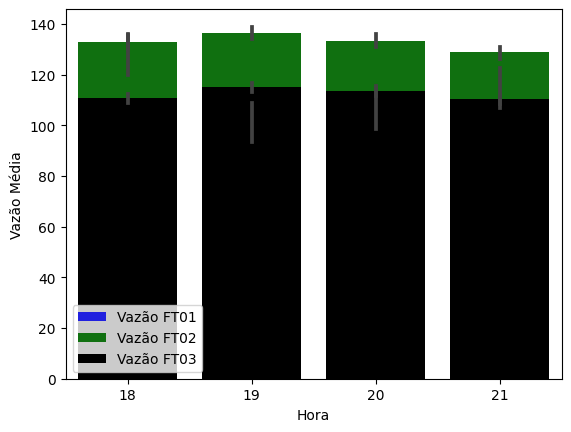

In [5]:


# Filtro para os horários de interesse (18h às 21h)
filtro = (df.index.hour >= 18) & (df.index.hour <= 21)
df_horarios_pico = df[filtro]

# Criar um gráfico de barras para mostrar a demanda média em cada hora
sns.barplot(x=df_horarios_pico.index.hour, y=df_horarios_pico['VAZÃO DE ENTRADA - FT01'], color='blue', label='Vazão FT01')
sns.barplot(x=df_horarios_pico.index.hour, y=df_horarios_pico['VAZÃO DE GRAVIDADE - FT02'], color='green', label='Vazão FT02')
sns.barplot(x=df_horarios_pico.index.hour, y=df_horarios_pico['VAZÃO DE RECALQUE - FT03'], color='black', label='Vazão FT03')

#plt.title('Vazão Média nos Horários de Pico')
plt.xlabel('Hora')
plt.ylabel('Vazão Média')
plt.legend()
plt.savefig('grafico-barras-demanda.pdf', format='pdf', dpi=600)
plt.show()



In [6]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import seaborn as sns

# # Filtro para os horários de interesse (18h às 21h)
# filtro = (df.index.hour >= 18) & (df.index.hour <= 21)
# df_horarios_pico = df[filtro]

# # Configuração inicial do gráfico
# fig, ax = plt.subplots(figsize=(8, 6))
# sns.barplot(x=df_horarios_pico.index.hour, y=df_horarios_pico['VAZÃO DE ENTRADA - FT01'], color='blue', label='Vazão FT01')
# sns.barplot(x=df_horarios_pico.index.hour, y=df_horarios_pico['VAZÃO DE GRAVIDADE - FT02'], color='green', label='Vazão FT02')
# sns.barplot(x=df_horarios_pico.index.hour, y=df_horarios_pico['VAZÃO DE RECALQUE - FT03'], color='black', label='Vazão FT03')

# plt.xlabel('Hora')
# plt.ylabel('Vazão Média')
# plt.legend()

# # Função de atualização para a animação
# def update(frame):
#     ax.clear()
#     sns.barplot(x=df_horarios_pico.index.hour[:frame+1], y=df_horarios_pico['VAZÃO DE ENTRADA - FT01'][:frame+1], color='blue', label='Vazão FT01')
#     sns.barplot(x=df_horarios_pico.index.hour[:frame+1], y=df_horarios_pico['VAZÃO DE GRAVIDADE - FT02'][:frame+1], color='green', label='Vazão FT02')
#     sns.barplot(x=df_horarios_pico.index.hour[:frame+1], y=df_horarios_pico['VAZÃO DE RECALQUE - FT03'][:frame+1], color='black', label='Vazão FT03')
#     plt.xlabel('Hora')
#     plt.ylabel('Vazão Média')
#     plt.legend()

# # Criação da animação
# ani = animation.FuncAnimation(fig, update, frames=len(df_horarios_pico), interval=200)

# # Salvar a animação em um arquivo GIF
# animation_file = 'barra-h-pico-animacao.gif'
# ani.save(animation_file, writer='pillow')

# # Exibir a animação
# plt.show()


In [7]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import seaborn as sns
# from IPython.display import HTML

# # Filtro para os horários de interesse (18h às 21h)
# filtro = (df.index.hour >= 18) & (df.index.hour <= 21)
# df_horarios_pico = df[filtro]

# # Configuração inicial do gráfico
# fig, ax = plt.subplots(figsize=(8, 6))
# font = {'family': 'serif', 'style': 'oblique', 'size': 12}
# plt.rc('font', **font)
# barplot = sns.barplot(x=df_horarios_pico.index.hour, y=df_horarios_pico['VAZÃO DE ENTRADA - FT01'], color='blue', label='Vazão FT01')
# barplot = sns.barplot(x=df_horarios_pico.index.hour, y=df_horarios_pico['VAZÃO DE GRAVIDADE - FT02'], color='green', label='Vazão FT02')
# barplot = sns.barplot(x=df_horarios_pico.index.hour, y=df_horarios_pico['VAZÃO DE RECALQUE - FT03'], color='black', label='Vazão FT03')

# # Função de atualização para a animação
# def animate(frame):
#     # Atualiza a altura das barras para cada quadro
#     for bar, val in zip(barplot.patches, df_horarios_pico.iloc[frame]):
#         bar.set_height(val)

# # Criação da animação
# ani = animation.FuncAnimation(fig, animate, frames=len(df_horarios_pico), interval=200)

# # Converter a animação em formato HTML
# html = ani.to_jshtml()

# # Exibir a animação no Jupyter Notebook
# HTML(html)


In [8]:
# Filtrar os horários de interesse (18h às 21h)
filtro_horarios = (df.index.hour >= 18) & (df.index.hour <= 21)
df_horarios_pico = df[filtro_horarios]

# Encontrar a data e hora do horário de maior demanda para cada variável
horario_maior_demanda_ft01 = df_horarios_pico['VAZÃO DE ENTRADA - FT01'].idxmax()
horario_maior_demanda_ft02 = df_horarios_pico['VAZÃO DE GRAVIDADE - FT02'].idxmax()
horario_maior_demanda_ft03 = df_horarios_pico['VAZÃO DE RECALQUE - FT03'].idxmax()

print("Horário de maior demanda das 18h às 21h - VAZÃO DE ENTRADA- FT01:")
print(horario_maior_demanda_ft01)
print("Horário de maior demanda das 18h às 21h - VAZÃO DE GRAVIDADE - FT02:")
print(horario_maior_demanda_ft02)
print("Horário de maior demanda das 18h às 21h - VAZÃO DE RECALQUE - FT03:")
print(horario_maior_demanda_ft03)


Horário de maior demanda das 18h às 21h - VAZÃO DE ENTRADA- FT01:
2020-10-08 21:00:00
Horário de maior demanda das 18h às 21h - VAZÃO DE GRAVIDADE - FT02:
2020-10-20 18:00:00
Horário de maior demanda das 18h às 21h - VAZÃO DE RECALQUE - FT03:
2020-11-26 19:00:00


In [9]:
# Filtro para os horários de interesse (18h às 21h)
filtro_horarios = (df.index.hour >= 18) & (df.index.hour <= 21)
df_filtrado = df[filtro_horarios]

# Criação do DataFrame para armazenar os resultados
df_maior_demanda = pd.DataFrame(columns=['Variável', 'Horário de Maior Demanda', 'Valor da Demanda'])

# Variável VAZÃO DE ENTRADA - FT01
horario_maior_demanda_ft01 = df_filtrado[df_filtrado['VAZÃO DE ENTRADA - FT01'] == df_filtrado['VAZÃO DE ENTRADA - FT01'].max()].index[0]
demanda_maior_horario_ft01 = df_filtrado.loc[horario_maior_demanda_ft01, 'VAZÃO DE ENTRADA - FT01']
df_maior_demanda = df_maior_demanda.append({'Variável': 'VAZÃO DE ENTRADA - FT01',
                                            'Horário de Maior Demanda': horario_maior_demanda_ft01,
                                            'Valor da Demanda': demanda_maior_horario_ft01},
                                           ignore_index=True)

# Variável VAZÃO DE GRAVIDADE - FT02
horario_maior_demanda_ft02 = df_filtrado[df_filtrado['VAZÃO DE GRAVIDADE - FT02'] == df_filtrado['VAZÃO DE GRAVIDADE - FT02'].max()].index[0]
demanda_maior_horario_ft02 = df_filtrado.loc[horario_maior_demanda_ft02, 'VAZÃO DE GRAVIDADE - FT02']
df_maior_demanda = df_maior_demanda.append({'Variável': 'VAZÃO DE GRAVIDADE - FT02',
                                            'Horário de Maior Demanda': horario_maior_demanda_ft02,
                                            'Valor da Demanda': demanda_maior_horario_ft02},
                                           ignore_index=True)

# Variável VAZÃO DE RECALQUE - FT03
horario_maior_demanda_ft03 = df_filtrado[df_filtrado['VAZÃO DE RECALQUE - FT03'] == df_filtrado['VAZÃO DE RECALQUE - FT03'].max()].index[0]
demanda_maior_horario_ft03 = df_filtrado.loc[horario_maior_demanda_ft03, 'VAZÃO DE RECALQUE - FT03']
df_maior_demanda = df_maior_demanda.append({'Variável': 'VAZÃO DE RECALQUE - FT03',
                                            'Horário de Maior Demanda': horario_maior_demanda_ft03,
                                            'Valor da Demanda': demanda_maior_horario_ft03},
                                           ignore_index=True)

# Arredondar os valores para duas casas decimais
df_maior_demanda['Valor da Demanda'] = df_maior_demanda['Valor da Demanda'].round(2)

# Exibir o DataFrame com os resultados
print(df_maior_demanda)


                    Variável Horário de Maior Demanda  Valor da Demanda
0    VAZÃO DE ENTRADA - FT01      2020-10-08 21:00:00            383.87
1  VAZÃO DE GRAVIDADE - FT02      2020-10-20 18:00:00            326.17
2   VAZÃO DE RECALQUE - FT03      2020-11-26 19:00:00            194.35


In [10]:
df_maior_demanda.to_excel('maior_demanda.xlsx', index=False)

In [11]:
demanda_horario_pico = df.between_time('18:00:00', '21:00:00')['NIVEL DO RESERVATÓRIO - LT01'].max()
volume_minimo = demanda_horario_pico * 1.2 *1000

print(f"O volume mínimo de água necessário é de {volume_minimo:.2f} litros.")



O volume mínimo de água necessário é de 5285.90 litros.


In [12]:
# Calcular os percentis
pressao_percentil10 = round(df['PRESSÃO DE SUCÇÃO - PT01'].quantile(0.10), 2)
pressao_percentil90 = round(df['PRESSÃO DE SUCÇÃO - PT01'].quantile(0.90), 2)

# Imprimir os resultados
print("Pressão Percentil 10:", pressao_percentil10)
print("Pressão Percentil 90:", pressao_percentil90)


Pressão Percentil 10: 3.48
Pressão Percentil 90: 5.29


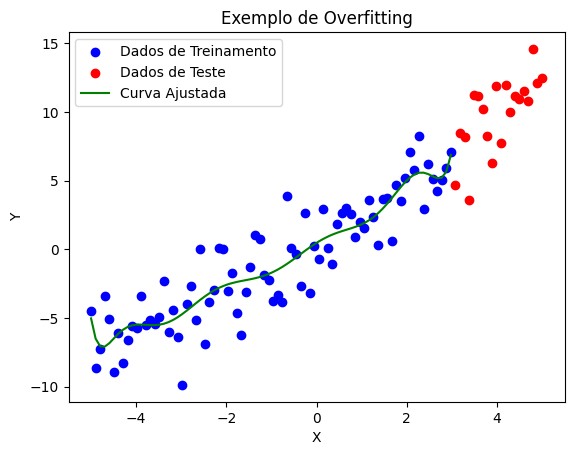

In [13]:


# Gerando dados de exemplo
np.random.seed(0)
x = np.linspace(-5, 5, 100)
y_true = 2 * x + 1 + np.random.normal(0, 2, 100)

# Adicionando ruído ao conjunto de treinamento
x_train = x[:80]
y_train = y_true[:80] + np.random.normal(0, 0.5, 80)

# Adicionando ruído ao conjunto de teste
x_test = x[80:]
y_test = y_true[80:] + np.random.normal(0, 0.5, 20)

# Ajustando um modelo polinomial de alta ordem
degree = 10
p = np.polyfit(x_train, y_train, degree)
y_train_pred = np.polyval(p, x_train)
y_test_pred = np.polyval(p, x_test)

# Plotando os dados e a curva ajustada
plt.scatter(x_train, y_train, color='blue', label='Dados de Treinamento')
plt.scatter(x_test, y_test, color='red', label='Dados de Teste')
plt.plot(x_train, y_train_pred, color='green', label='Curva Ajustada')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Exemplo de Overfitting')
plt.show()


Erro quadrático médio (treinamento): 0.847678856420971
Erro quadrático médio (teste): 0.6536995137170021


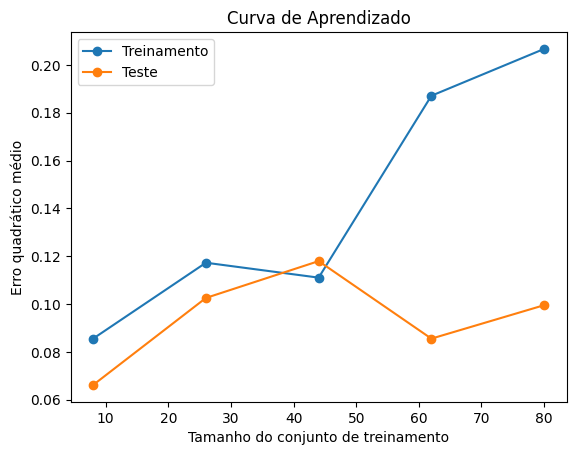

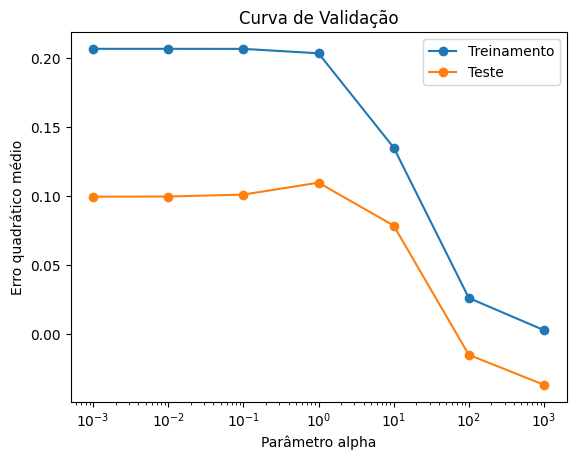

In [14]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Geração de dados de exemplo
np.random.seed(42)
X = np.random.rand(100, 1)
y = 2 * X.squeeze() + np.random.randn(100)

# Divisão dos dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinamento do modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Avaliação do modelo nos dados de treinamento
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
print("Erro quadrático médio (treinamento):", train_mse)

# Avaliação do modelo nos dados de teste
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Erro quadrático médio (teste):", test_mse)

# Curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot da curva de aprendizado
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', label='Treinamento')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Teste')
plt.xlabel('Tamanho do conjunto de treinamento')
plt.ylabel('Erro quadrático médio')
plt.legend(loc='best')
plt.title('Curva de Aprendizado')
plt.show()

# Curva de validação
param_range = np.logspace(-3, 3, 7)
train_scores, test_scores = validation_curve(Ridge(), X, y, param_name="alpha", param_range=param_range, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot da curva de validação
plt.figure()
plt.plot(param_range, train_scores_mean, 'o-', label='Treinamento')
plt.plot(param_range, test_scores_mean, 'o-', label='Teste')
plt.xscale('log')
plt.xlabel('Parâmetro alpha')
plt.ylabel('Erro quadrático médio')
plt.legend(loc='best')
plt.title('Curva de Validação')
plt.show()


In [15]:
# Calcular os percentis
pressao_percentil10 = round(df['PRESSÃO DE RECALQUE - PT02'].quantile(0.10), 2)
pressao_percentil90 = round(df['PRESSÃO DE RECALQUE - PT02'].quantile(0.90), 2)

# Imprimir os resultados
print("Pressão Percentil 10:", pressao_percentil10)
print("Pressão Percentil 90:", pressao_percentil90)

Pressão Percentil 10: 15.82
Pressão Percentil 90: 24.02


In [16]:
print(df.columns)

Index(['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3',
       'NIVEL DO RESERVATÓRIO - LT01', 'VAZÃO DE ENTRADA - FT01',
       'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02'],
      dtype='object')


# Demanda diaria

In [17]:

# Definir as variáveis
nivel_reservatorio = df['NIVEL DO RESERVATÓRIO - LT01']
vazao_entrada = df['VAZÃO DE ENTRADA - FT01'] / 3600  # Converter para m³/s
vazao_gravidade = df['VAZÃO DE GRAVIDADE - FT02'] / 3600  # Converter para m³/s
vazao_recalque = df['VAZÃO DE RECALQUE - FT03'] / 3600  # Converter para m³/s

# Calcular a variação do nível do reservatório
variacao_nivel_reservatorio = vazao_entrada - vazao_gravidade - vazao_recalque

# Verificar o equilíbrio do nível do reservatório
equilibrio = variacao_nivel_reservatorio.mean() == 0

# Exibir o resultado
if equilibrio:
    print("O sistema está em equilíbrio.")
else:
    print("O sistema não está em equilíbrio.")


O sistema não está em equilíbrio.


In [18]:
vazao_entrada = df_maior_demanda.loc[df_maior_demanda['Variável'] == 'VAZÃO DE ENTRADA - FT01', 'Valor da Demanda'].values[0]
vazao_gravidade = df_maior_demanda.loc[df_maior_demanda['Variável'] == 'VAZÃO DE GRAVIDADE - FT02', 'Valor da Demanda'].values[0]
vazao_recalque = df_maior_demanda.loc[df_maior_demanda['Variável'] == 'VAZÃO DE RECALQUE - FT03', 'Valor da Demanda'].values[0]


In [19]:
demanda_diaria = 904.39


In [20]:
quantidade_agua_necessaria = demanda_diaria - vazao_entrada - vazao_gravidade - vazao_recalque


In [21]:
if quantidade_agua_necessaria == 0:
    print("Existe um equilíbrio entre a demanda diária e as vazões.")
else:
    print("Não existe um equilíbrio entre a demanda diária e as vazões.")


Não existe um equilíbrio entre a demanda diária e as vazões.


In [22]:

# Variáveis de vazão em litros por hora
vazao_entrada = 383.87
vazao_gravidade = 326.17
vazao_recalque = 194.35

# Demanda diária em litros
demanda_diaria = 5000

# Calcular a quantidade de água necessária para atender à demanda diária
quantidade_agua_necessaria = np.round(demanda_diaria - vazao_entrada - vazao_gravidade - vazao_recalque, 2)

# Imprimir o resultado
print(f"A quantidade de água necessária para atender à demanda diária é de {quantidade_agua_necessaria} litros.")


A quantidade de água necessária para atender à demanda diária é de 4095.61 litros.


In [23]:
# Variáveis de vazão em litros por hora
vazao_entrada = df['VAZÃO DE ENTRADA - FT01'].max()
vazao_gravidade = df['VAZÃO DE GRAVIDADE - FT02'].max()
vazao_recalque = df['VAZÃO DE RECALQUE - FT03'].max()

# Cálculo da demanda diária
demanda_diaria = df['VAZÃO DE ENTRADA - FT01'] + df['VAZÃO DE GRAVIDADE - FT02'] + df['VAZÃO DE RECALQUE - FT03']

# Soma total da demanda diária
demanda_total = demanda_diaria.sum()

# Calcular a quantidade de água necessária para atender à demanda diária
quantidade_agua_necessaria = demanda_total - vazao_entrada - vazao_gravidade - vazao_recalque

# Verificar se há equilíbrio entre as vazões e a demanda diária
if quantidade_agua_necessaria == 0:
    print("Existe equilíbrio entre as vazões e a demanda diária.")
elif quantidade_agua_necessaria > 0:
    print("Há um excesso de água, é possível reduzir as vazões para atingir o equilíbrio.")
else:
    print("Há uma deficiência de água, é necessário aumentar as vazões para atingir o equilíbrio.")


Há um excesso de água, é possível reduzir as vazões para atingir o equilíbrio.


In [24]:
# Calcular a soma das vazões por intervalo de tempo (por exemplo, a cada hora)
vazoes_por_intervalo = df[['VAZÃO DE ENTRADA - FT01', 'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03']].sum(axis=1)

# Definir a frequência dos dados (por exemplo, a cada hora)
frequencia = '1H'

# Resample dos dados para a frequência desejada (por exemplo, de hora em hora)
vazoes_resample = vazoes_por_intervalo.resample(frequencia).sum()

# Calcular a demanda diária somando as vazões
demandas_diarias = vazoes_resample.resample('D').sum()

# Imprimir as demandas diárias
print(demandas_diarias)


Timestamp
2018-01-01     8137.145294
2018-01-02     9104.172798
2018-01-03     9453.075214
2018-01-04     9435.461704
2018-01-05    10297.908028
                  ...     
2020-12-27    10498.914763
2020-12-28    11283.025036
2020-12-29    10440.954248
2020-12-30    10612.092546
2020-12-31    10735.596754
Freq: D, Length: 1096, dtype: float64


In [25]:
# Filtrar os horários de interesse (18h às 21h)
df_horarios_pico = df[(df.index.hour >= 18) & (df.index.hour <= 21)]

# Identificar os horários de maior demanda
horarios_maior_demanda = df_horarios_pico[df_horarios_pico['VAZÃO DE RECALQUE - FT03'] == df_horarios_pico['VAZÃO DE RECALQUE - FT03'].max()].index

# Exibir os horários de maior demanda
print("Horários de maior demanda das 18h às 21h:")
for horario in horarios_maior_demanda:
    print(horario)


Horários de maior demanda das 18h às 21h:
2020-11-26 19:00:00


In [26]:
# Filtrar os horários de interesse (18h às 21h)
df_horarios_pico = df[(df.index.hour >= 18) & (df.index.hour <= 21)]

# Identificar os horários de maior demanda
horarios_maior_demanda = df_horarios_pico[df_horarios_pico['VAZÃO DE ENTRADA - FT01'] == df_horarios_pico['VAZÃO DE ENTRADA - FT01'].max()].index

# Exibir os horários de maior demanda
print("Horários de maior demanda das 18h às 21h:")
for horario in horarios_maior_demanda:
    print(horario)


Horários de maior demanda das 18h às 21h:
2020-10-08 21:00:00


In [27]:
# Filtrar os horários de interesse (18h às 21h)
df_horarios_pico = df[(df.index.hour >= 18) & (df.index.hour <= 21)]

# Identificar os horários de maior demanda
horarios_maior_demanda = df_horarios_pico[df_horarios_pico['VAZÃO DE GRAVIDADE - FT02'] == df_horarios_pico['VAZÃO DE GRAVIDADE - FT02'].max()].index

# Exibir os horários de maior demanda
print("Horários de maior demanda das 18h às 21h:")
for horario in horarios_maior_demanda:
    print(horario)


Horários de maior demanda das 18h às 21h:
2020-10-20 18:00:00


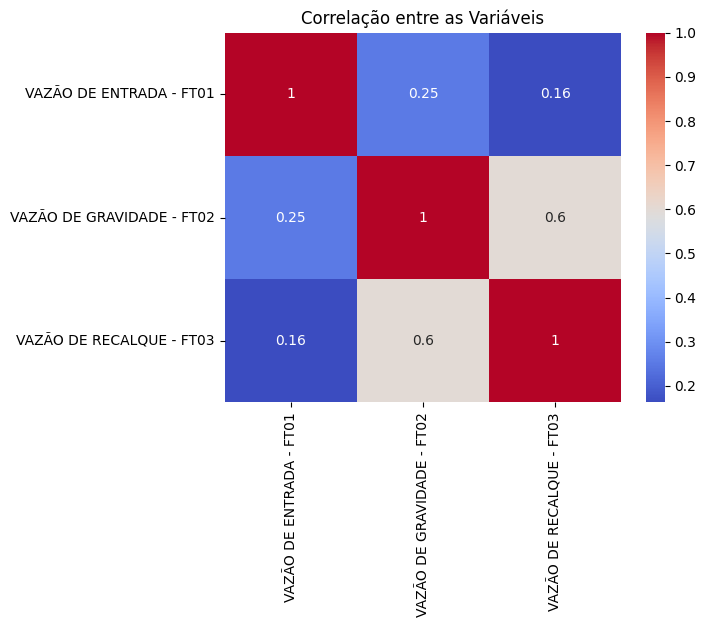

In [28]:
# Filtrar os horários de interesse (18h às 21h)
df_horarios_pico = df[(df.index.hour >= 18) & (df.index.hour <= 21)]

# Selecionar as variáveis relevantes
variaveis = ['VAZÃO DE ENTRADA - FT01', 'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03']
df_variaveis = df_horarios_pico[variaveis]

# Calcular a matriz de correlação
correlacoes = df_variaveis.corr()

# Plotar um heatmap da matriz de correlação
sns.heatmap(correlacoes, annot=True, cmap='coolwarm')
plt.title('Correlação entre as Variáveis')
plt.show()


In [29]:
demanda_media = df['VAZÃO DE RECALQUE - FT03'].mean()
demanda_media_formatada = format(round(demanda_media, 2), ".2f")

print(f"A demanda média é: {demanda_media_formatada}")


A demanda média é: 100.14


In [30]:
demanda_media = df['VAZÃO DE ENTRADA - FT01'].mean()
demanda_media_formatada = format(round(demanda_media, 2), ".2f")

print(f"A demanda média é: {demanda_media_formatada}")



A demanda média é: 211.77


In [31]:
demanda_media = df['VAZÃO DE GRAVIDADE - FT02'].mean()
demanda_media_formatada = format(round(demanda_media, 2), ".2f")

print(f"A demanda média é: {demanda_media_formatada}")



A demanda média é: 113.80


In [32]:
# filtro = (df.index.year>=2018)
# df = df[filtro]
# filtro = (df.index.year<=2020)
# df = df[filtro]
# # filtro = (df.index.hour>=18)
# # df = df[filtro]
# # filtro = (df.index.hour<=21)
# # df = df[filtro]

# hora = '24h'

# df.isna().any() # verifique se não há valores NAN
# df = df.rename(columns={'BAIRRO ALTO -  / FREQ B1': 'FREQUENCIA BOMBA 1',
#                         'BAIRRO ALTO -  / FREQ B2': 'FREQUENCIA BOMBA 2',
#                         'BAIRRO ALTO -  / FREQ B3':'FREQUENCIA BOMBA 3',
#                         'BAIRRO ALTO - LT01 / NÍVEL':'NIVEL DO RESERVATÓRIO - LT01',
#                         'BAIRRO ALTO - FT01 / ENT IRAI':'VAZÃO DE ENTRADA - FT01',
#                         'BAIRRO ALTO - FT02 / GBAL':'VAZÃO DE GRAVIDADE - FT02',
#                         'BAIRRO ALTO - FT03 / RBAL':'VAZÃO DE RECALQUE - FT03',
#                         'BAIRRO ALTO - PT01 / SUCÇÃO':'PRESSÃO DE SUCÇÃO - PT01',
#                         'BAIRRO ALTO - PT02 / RBAL':'PRESSÃO DE RECALQUE - PT02'})
# df

In [33]:
df.replace(to_replace='Bad',value=np.nan,inplace=True)
df.isna().any() # verifique se existem valores NAN (sequências 'Bad' substituídas)
df.interpolate(inplace=True)

df = df.dropna()

# 24 horas

df = df.resample('24h').mean()
# df = df.resample('24h').min()
# df2 = df.resample('24h', offset = "19h").mean()
# df3 = df.resample('24h', offset = "20h").mean()
# df4 = df.resample('24h', offset = "21h").mean()
df.shape

(1096, 9)

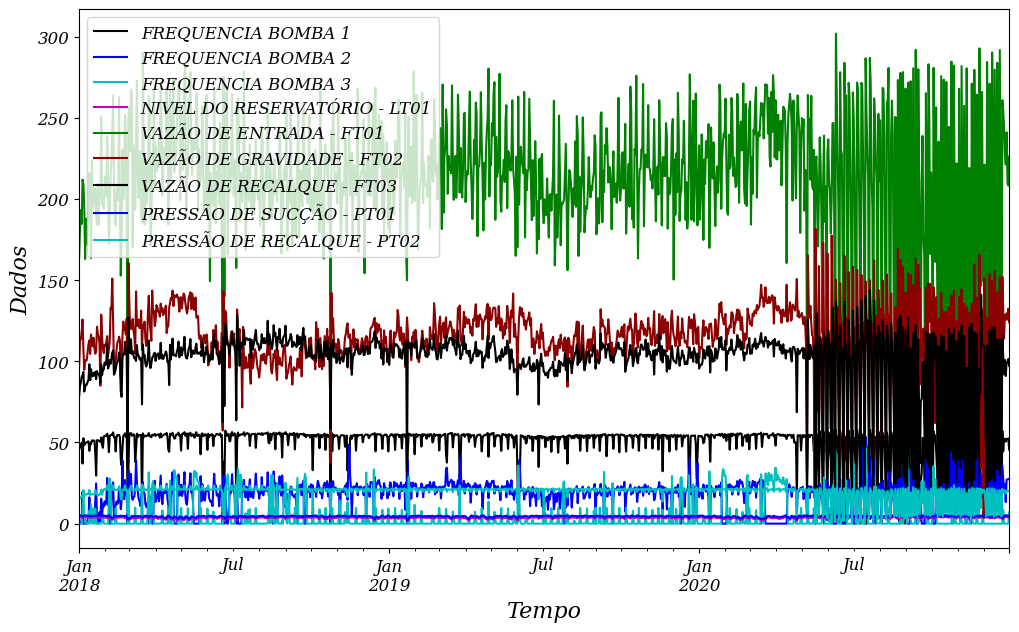

In [34]:

font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
# gráfico de linha
df.plot(figsize = (12,7), color = ['k', 'b', 'c', 'm', 'g', 'darkred'])
plt.xlabel('Tempo', fontsize = 16)
plt.ylabel("Dados", fontsize = 16)
plt.legend(loc = 2)
plt.savefig("dados todo.pdf", dpi=600)
plt.show()


In [35]:
# from fast_ml.model_development import train_valid_test_split

# X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = target, 
#                                                                             train_size=0.8, valid_size=0.1, test_size=0.1)

# # Get the shape of all the datasets
# print(X_train.shape), print(y_train.shape)
# print(X_valid.shape), print(y_valid.shape)
# print(X_test.shape), print(y_test.shape)

# Treino, test e validação


In [36]:
#%% Divide os dados em treinamento, validação e teste
# 70% para treinamento e validação (18.414 amostras) e 30% para teste (7.892 amostras)
# Das 18.414 amostras, 80% para treinamento (14.731 amostras) e 20% para validação (3.683 amostras)

# thresholds
trn_samples = int((len(df)*70/100)*(80/100))
vld_samples = int((len(df)*70/100)*(20/100))
tst_samples = int((len(df)*30/100))

trn = df.iloc[:trn_samples]
vld = df.iloc[trn_samples:trn_samples+vld_samples]
tst = df.iloc[trn_samples+vld_samples:]

endog_tst = tst['NIVEL DO RESERVATÓRIO - LT01']
exog_tst = tst[['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3'
                , 'VAZÃO DE ENTRADA - FT01', 'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02']]

# exog_tst = tst[['PRESSÃO DE SUCÇÃO - PT01']]



endog_vld = vld['NIVEL DO RESERVATÓRIO - LT01']
exog_vld = vld[['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3',
       'VAZÃO DE ENTRADA - FT01',
       'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02']]

# exog_vld = vld[['PRESSÃO DE SUCÇÃO - PT01']]


       
endog_trn = trn['NIVEL DO RESERVATÓRIO - LT01']
exog_trn = trn[['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3',
       'VAZÃO DE ENTRADA - FT01',
       'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02']]

# exog_trn = trn[['PRESSÃO DE SUCÇÃO - PT01']]



endog = df['NIVEL DO RESERVATÓRIO - LT01']
exog = df[['FREQUENCIA BOMBA 1', 'FREQUENCIA BOMBA 2', 'FREQUENCIA BOMBA 3'
                , 'VAZÃO DE ENTRADA - FT01', 'VAZÃO DE GRAVIDADE - FT02', 'VAZÃO DE RECALQUE - FT03',
       'PRESSÃO DE SUCÇÃO - PT01', 'PRESSÃO DE RECALQUE - PT02']]

# exog = df[['PRESSÃO DE SUCÇÃO - PT01']]


rt = 'LT01 (m³)'

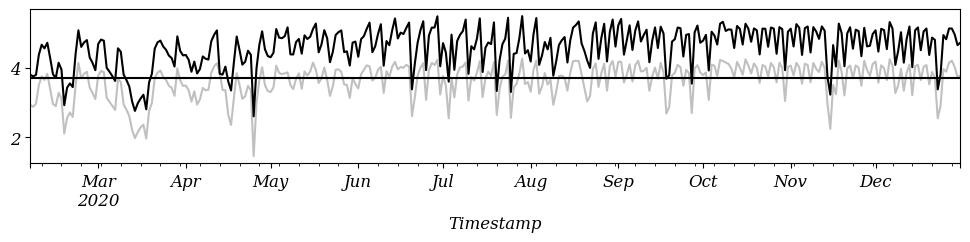

In [37]:
plt.figure(figsize = (12,2))
tst['NIVEL DO RESERVATÓRIO - LT01'].plot(color = 'silver')
tst['PRESSÃO DE SUCÇÃO - PT01'].plot(color = 'black')
plt.axhline(y=3.7, color = 'black')
plt.show()

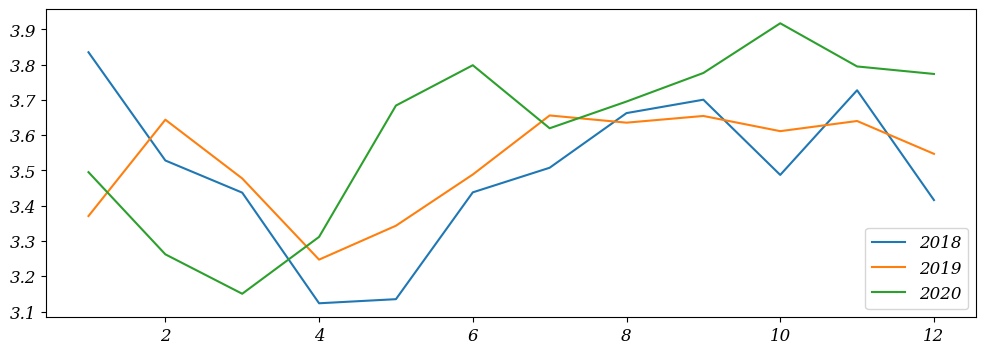

In [38]:

## Agrupando por ano
idx_year = df.index.year
idx_month = df.index.month
plt.figure(figsize = (12,4))
plt.plot(endog.groupby(by = [idx_year, idx_month]).mean().unstack(level = 0))
# plt.title('Agruapdo por Ano')
plt.legend(['2018','2019', '2020'])
# plt.legend(['2020'])
plt.savefig(f"media-agrupada.pdf", dpi=600)
plt.show()

## Diferença com o valor anterior

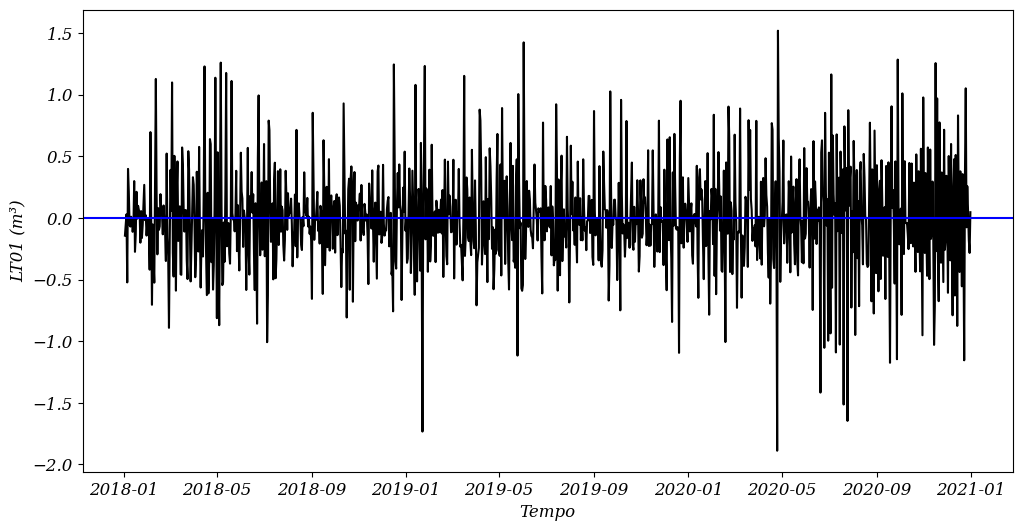

In [39]:

plt.figure(figsize = (12,6))

font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog.diff(), 'black')
plt.axhline(y=0, color = 'b')
plt.ylabel(rt)
plt.xlabel("Tempo")
plt.savefig("estacionaridade.pdf", dpi=600)
plt.show()

In [40]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation

# # Dados para o gráfico
# endog_diff = endog.diff()  # Substitua 'endog' pelos seus dados reais

# # Configuração inicial do gráfico
# fig, ax = plt.subplots(figsize=(12, 6))
# font = {'family': 'serif', 'style': 'oblique', 'size': 12}
# plt.rc('font', **font)
# line, = ax.plot(endog_diff, 'black')
# ax.axhline(y=0, color='b')
# ax.set_ylabel(rt)
# ax.set_xlabel("Tempo")

# # Função de atualização para a animação
# def update(frame):
#     line.set_data(range(frame), endog_diff[:frame])

# # Criação da animação
# ani = animation.FuncAnimation(fig, update, frames=len(endog_diff), interval=200)

# # Salvar a animação como um arquivo GIF
# animation_file = 'ruido-animacao.gif'
# ani.save(animation_file, writer='imagemagick')

# print(f"Animação salva como '{animation_file}'.")


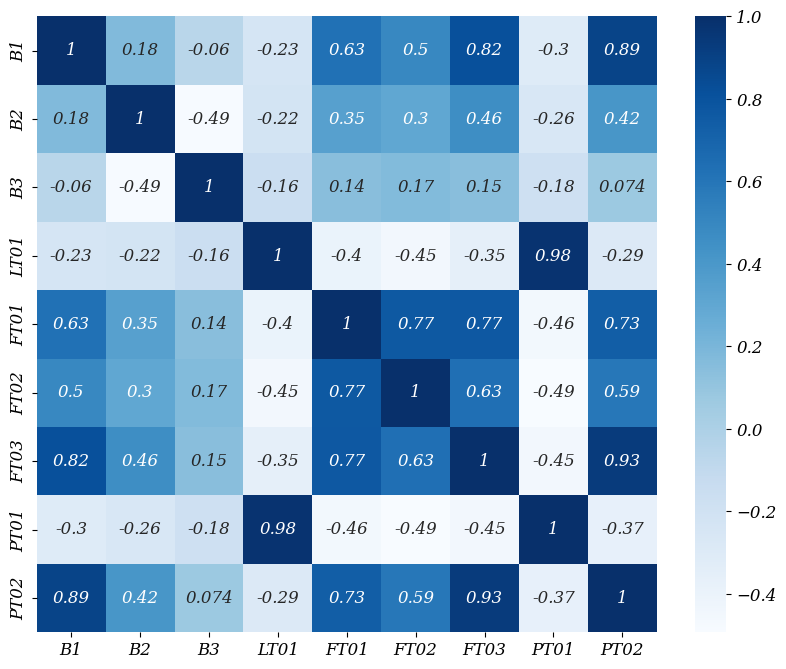

In [41]:
df2 = df.rename(columns={'FREQUENCIA BOMBA 1': 'B1',
                        'FREQUENCIA BOMBA 2': 'B2',
                        'FREQUENCIA BOMBA 3': 'B3',
                        'NIVEL DO RESERVATÓRIO - LT01': 'LT01',
                        'VAZÃO DE ENTRADA - FT01': 'FT01',
                        'VAZÃO DE GRAVIDADE - FT02': 'FT02',
                        'VAZÃO DE RECALQUE - FT03': 'FT03',
                        'PRESSÃO DE SUCÇÃO - PT01': 'PT01',
                        'PRESSÃO DE RECALQUE - PT02': 'PT02'})

plt.figure(figsize = (10,8))
sns.color_palette(as_cmap = True)
sns.heatmap(df2.corr(method = 'pearson'), annot = True, cmap = 'Blues')
plt.savefig(f"person.pdf", dpi=600)
plt.show()

In [42]:
df_horarios_pico = df2[(df.index.hour >= 18) & (df.index.hour <= 21)]
df_horarios_pico.describe().to_excel('estatistica.xlsx')

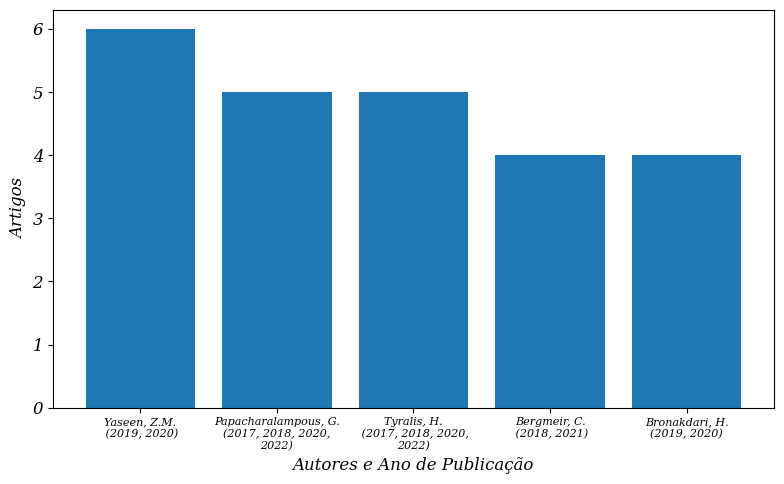

In [43]:
import matplotlib.pyplot as plt

nomes = ['Yaseen, Z.M.\n (2019, 2020)', 'Papacharalampous, G.\n(2017, 2018, 2020,\n2022)',
          'Tyralis, H.\n (2017, 2018, 2020,\n2022)', 'Bergmeir, C.\n (2018, 2021)', 'Bronakdari, H.\n(2019, 2020)']
artigos = [6, 5, 5, 4, 4]

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(nomes, artigos)
ax.set_xlabel('Autores e Ano de Publicação')
ax.set_ylabel('Artigos')
ax.tick_params(axis='x', rotation=0, labelsize=8)  # Rotação de 0 graus para os rótulos do eixo x
plt.tight_layout()
plt.savefig(f"Autores Relação entre artigos publicados.pdf", dpi=600)
plt.show()


In [44]:
import plotly.graph_objects as go

paises = ['China', 'Estados Unidos', 'India', 'Brasil', 'Espanha', 'Australia', 'Reino Unido', 'Iran', 'Canadá', 'Malaysia']
artigos = [96, 56, 46, 25, 24, 22, 20, 17, 14, 14]

fig = go.Figure(data=go.Choropleth(
    locations=paises,
    z=artigos,
    locationmode='country names',
    colorscale='Blues',
    colorbar_title='Artigos',
))

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig.show()


In [45]:
import plotly.graph_objects as go

paises = ['CHN', 'USA', 'IND', 'BRA', 'ESP', 'GBR', 'AUS', 'IRN', 'MYS', 'CAN']
artigos = [119, 67, 57, 32, 28, 25, 24, 18, 17, 16]

fig = go.Figure(data=go.Choropleth(
    locations=paises,
    z=artigos,
    locationmode='ISO-3',
    colorscale='Greys',
    colorbar_title='Artigos',
))

fig.update_layout(
    title_text='',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig.update_traces(text=artigos, hovertemplate='%{location}<br>Artigos: %{text}')

fig.update_layout(showlegend=False)

fig.write_image('mapa mundi artigos.pdf')


fig.show()


In [46]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# paises = ['CHN', 'USA', 'IND', 'BRA', 'ESP', 'GBR', 'AUS', 'IRN', 'MYS', 'CAN']
# artigos = [119, 67, 57, 32, 28, 25, 24, 18, 17, 16]

# # Criação dos subplots
# fig = make_subplots(rows=1, cols=10)

# # Adiciona os traces (choropleth) em cada subplot
# for i, pais in enumerate(paises):
#     data = go.Choropleth(
#         locations=[pais],
#         z=[artigos[i]],
#         locationmode='ISO-3',
#         colorscale='Greys',
#         colorbar_title='Artigos',
#         showscale=False
#     )
#     fig.add_trace(data, row=1, col=i+1)

# # Atualiza o layout
# fig.update_layout(
#     title_text='Contagem de Artigos por País',
#     geo=dict(
#         showframe=False,
#         showcoastlines=False,
#         projection_type='equirectangular'
#     )
# )

# fig.update_geos(visible=False, projection_type="equirectangular")

# # Exibe o gráfico
# fig.show()


In [47]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio

paises = ['CHN', 'USA', 'IND', 'BRA', 'ESP', 'GBR', 'AUS', 'IRN', 'MYS', 'CAN']
artigos = [119, 67, 57, 32, 28, 25, 24, 18, 17, 16]

# Lista para armazenar as imagens geradas
images = []

# Criação das visualizações e adição das imagens à lista
for i, pais in enumerate(paises):
    fig = go.Figure(data=go.Choropleth(
        locations=[pais],
        z=[artigos[i]],
        locationmode='ISO-3',
        colorscale='Greys',
        colorbar_title='Artigos',
        showscale=False
    ))
    fig.update_layout(
        title_text=f'Contagem de Artigos - {pais}',
        geo=dict(
            showframe=False,
            showcoastlines=False,
            projection_type='equirectangular'
        )
    )
    
    # Salvar a visualização como imagem PNG
    image_file = f'mapa_{paises[i]}.png'
    fig.write_image(image_file)
    
    # Adicionar a imagem à lista
    images.append(imageio.imread(image_file))

# Salvar a lista de imagens como arquivo GIF
animation_file = 'mapa_animacao.gif'
imageio.mimsave(animation_file, images, duration=3)

print(f"Animação salva como '{animation_file}'.")


Animação salva como 'mapa_animacao.gif'.


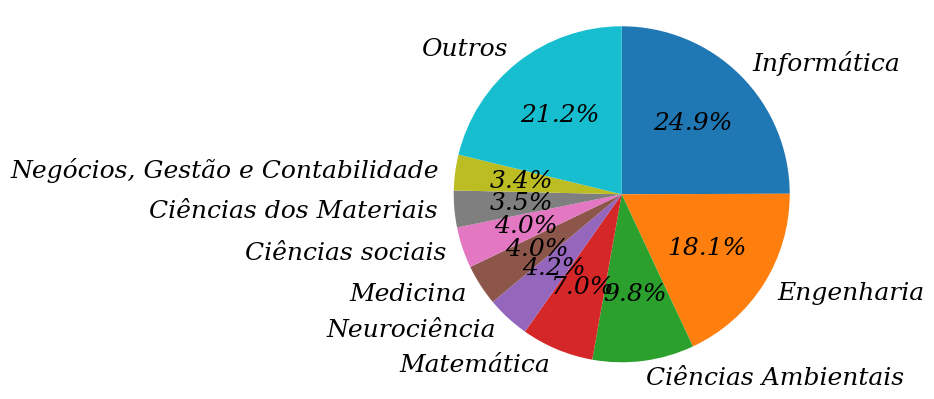

In [48]:
import matplotlib.pyplot as plt

categorias = ['Informática', 'Engenharia', 'Ciências Ambientais', 'Matemática', 'Neurociência', 'Medicina',
              'Ciências sociais', 'Ciências dos Materiais', 'Negócios, Gestão e Contabilidade', 'Outros']
artigos = [240, 174, 94, 67, 40, 38, 38, 34, 33, 204]

# Paleta de cores personalizada
cores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Configurações do gráfico
fig, ax = plt.subplots()
ax.pie(artigos, labels=categorias, autopct='%1.1f%%', startangle=90, counterclock=False, colors=cores, textprops={'fontsize': 18})
ax.axis('equal')  # Assegura que o gráfico fique circular

# Título do gráfico

plt.savefig(f"areas.pdf", dpi=600)
# Exibe o gráfico
plt.show()


In [49]:
import plotly.graph_objects as go
import plotly.offline as pyo
import imageio

categorias = ['Informática', 'Engenharia', 'Ciências Ambientais', 'Matemática', 'Neurociência', 'Medicina',
              'Ciências sociais', 'Ciências dos Materiais', 'Negócios, Gestão e Contabilidade', 'Outros']
artigos = [240, 174, 94, 67, 40, 38, 38, 34, 33, 204]

# Configuração inicial do gráfico
fig = go.Figure()

# Configuração da animação
fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            buttons=[
                dict(
                    label='Play',
                    method='animate',
                    args=[
                        None,
                        {
                            'frame': {'duration': 500, 'redraw': True},
                            'fromcurrent': True,
                            'transition': {'duration': 0}
                        }
                    ]
                )
            ]
        )
    ]
)

# Criação dos frames da animação
frames = []
for i in range(len(categorias)):
    data = go.Pie(labels=categorias[:i+1], values=artigos[:i+1])
    frame = go.Frame(data=[data])
    frames.append(frame)

# Adiciona os frames à animação
fig.frames = frames

# Configurações finais do layout
fig.update_layout(
    title='Distribuição de Artigos por Categoria',
    showlegend=False
)

# Salvar os frames como imagens em uma lista
images = []
for i, frame in enumerate(frames):
    fig.frames = [frame]
    image_file = f'frame{i+1}.png'
    fig.write_image(image_file)
    images.append(imageio.imread(image_file))

# Salvar a animação como um arquivo GIF
animation_file = 'animacao_pizza.gif'
imageio.mimsave(animation_file, images, duration=1)

# Exibir a animação
pyo.iplot(fig)


In [50]:
# from pandas_profiling import ProfileReport
# import sweetviz as sv

# # EDA using pandas-profiling
# profile = ProfileReport(df, explorative=True)

# #Saving results to a HTML file
# profile.to_file("output.html")

# # EDA using Autoviz
# sweet_report = sv.analyze(df)

# #Saving results to HTML file
# sweet_report.show_html('sweet_report.html')


In [51]:
# plt.plot(df2.LT01)

In [52]:

# import dtale


# dtale.show(df2)

In [53]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# s = df2['LT01']
# sd_result = seasonal_decompose(s, model='additive')

In [54]:
from statsmodels.tsa.filters.hp_filter import hpfilter

s = df['NIVEL DO RESERVATÓRIO - LT01']
cycle, trend = hpfilter(s, lamb=1600)

In [55]:
# sd_result.plot();

# Ruido branco

In [56]:
df.mean()

FREQUENCIA BOMBA 1               48.830497
FREQUENCIA BOMBA 2               17.538055
FREQUENCIA BOMBA 3                4.298657
NIVEL DO RESERVATÓRIO - LT01      3.544512
VAZÃO DE ENTRADA - FT01         211.770616
VAZÃO DE GRAVIDADE - FT02       113.804986
VAZÃO DE RECALQUE - FT03        100.138612
PRESSÃO DE SUCÇÃO - PT01          4.485225
PRESSÃO DE RECALQUE - PT02       19.424306
dtype: float64

In [57]:
df2.mean().to_excel('media.xlsx')


In [58]:
df2.describe().to_excel('estatistica.xlsx')

In [59]:
df.describe()

FREQUENCIA BOMBA 1  FREQUENCIA BOMBA 2  FREQUENCIA BOMBA 3  \
count         1096.000000         1096.000000         1096.000000   
mean            48.830497           17.538055            4.298657   
std             12.354038            9.281923            8.975660   
min              0.000000            0.000000            0.000000   
25%             50.491298           13.288937            0.000000   
50%             54.203522           19.964554            0.000000   
75%             54.818361           22.791507            2.375866   
max             57.884742           53.488396           46.841334   

       NIVEL DO RESERVATÓRIO - LT01  VAZÃO DE ENTRADA - FT01  \
count                   1096.000000              1096.000000   
mean                       3.544512               211.770616   
std                        0.437642                44.496078   
min                        1.458840                22.853874   
25%                        3.345124               195.944118   
50%                        3.644086               215.790903   
75%                        3.842757               238.325011   
max                        4.255611               301.862820   

       VAZÃO DE GRAVIDADE - FT02  VAZÃO DE RECALQUE - FT03  \
count                1096.000000               1096.000000   
mean                  113.804986                100.138612   
std                    21.485903                 19.821714   
min                     3.583976                 10.383355   
25%                   105.095669                 99.238742   
50%                   115.733042                104.845575   
75%                   126.246380                110.005659   
max                   181.565478                143.988415   

       PRESSÃO DE SUCÇÃO - PT01  PRESSÃO DE RECALQUE - PT02  
count               1096.000000                 1096.000000  
mean                   4.485225                   19.424306  
std                    0.486895                    4.323327  
min                    1.924965                    0.830832  
25%                    4.244901                   19.805492  
50%                    4.570760                   21.015114  
75%                    4.813108                   21.140136  
max                    5.475387                   23.678933


# Métodos preditivos

In [60]:

from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df2.LT01.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -4.248240
p-value: 0.000545


<Figure size 1200x200 with 0 Axes>

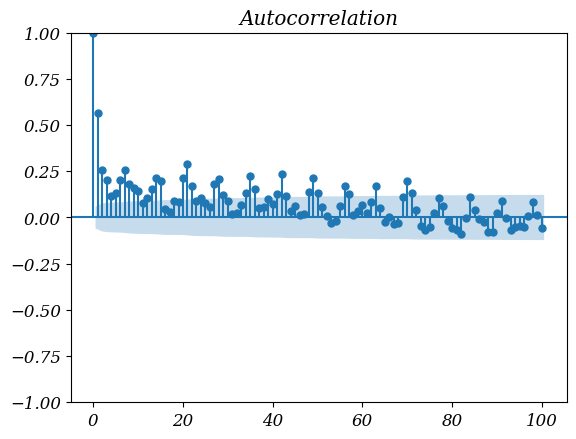

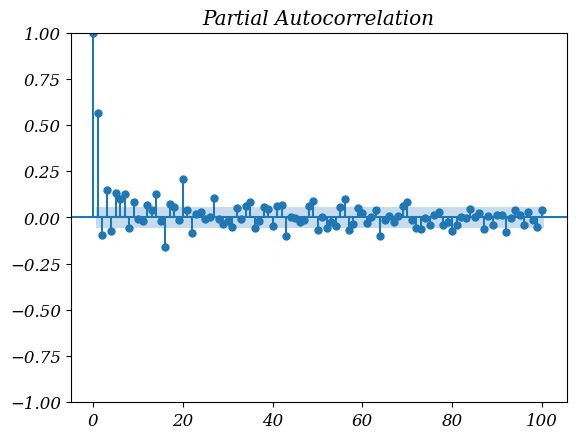

In [61]:

plt.figure(figsize = (12,2))
plot_acf(endog,lags=100)
plot_pacf(endog,lags=100)
plt.show()


## Estacionalidade


In [62]:

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Passa numa série cronológica e num título opcional, devolve um relatório ADF
    """
    print(f'Teste de Dickey-Fuller Aumentado: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['Estatística de teste ADF', 'p-valor', '# atrasos utilizados', '# observações']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'valor crítico ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Fortes provas contra a hipótese nula")
        print("Rejeitar a hipótese nula")
        print("Os dados não têm raiz unitária e são estacionários")
    else:
        print("Fracas provas contra a hipótese nula")
        print("Não rejeitar a hipótese nula")
        print("Os dados têm uma raiz unitária e não são estacionários")


adf_test(endog)


Teste de Dickey-Fuller Aumentado: 
Estatística de teste ADF      -4.248240
p-valor                        0.000545
# atrasos utilizados          21.000000
# observações               1074.000000
valor crítico (1%)            -3.436453
valor crítico (5%)            -2.864235
valor crítico (10%)           -2.568205
Fortes provas contra a hipótese nula
Rejeitar a hipótese nula
Os dados não têm raiz unitária e são estacionários


# Decomposição STL

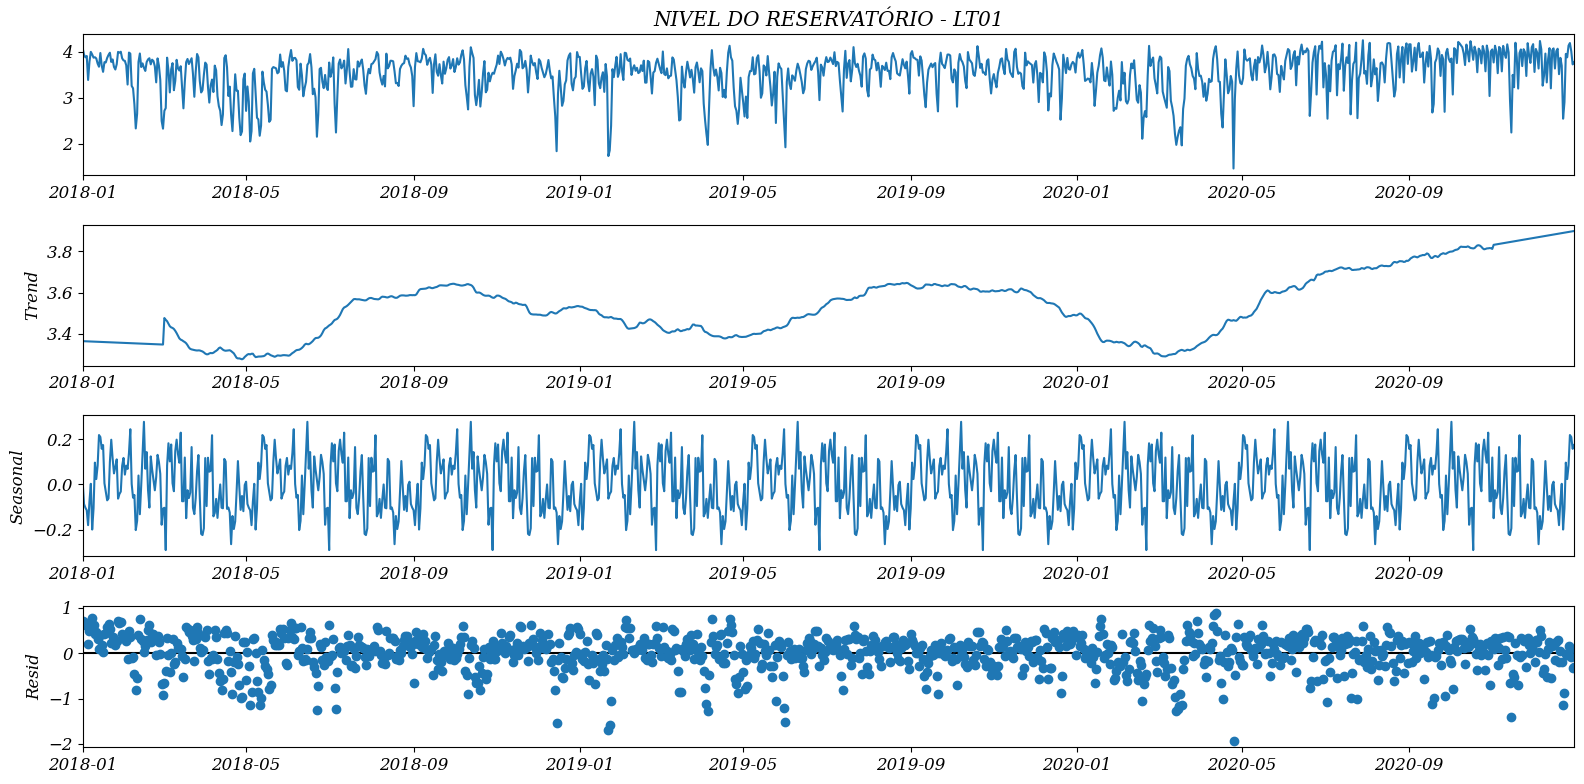

In [63]:

rst = stl(endog, model='add', extrapolate_trend='freq', period=10*12)
rcParams['figure.figsize'] = 16,8 # aumentar o tamanho do grafico
rst.plot()
plt.show()


<Figure size 1500x600 with 0 Axes>

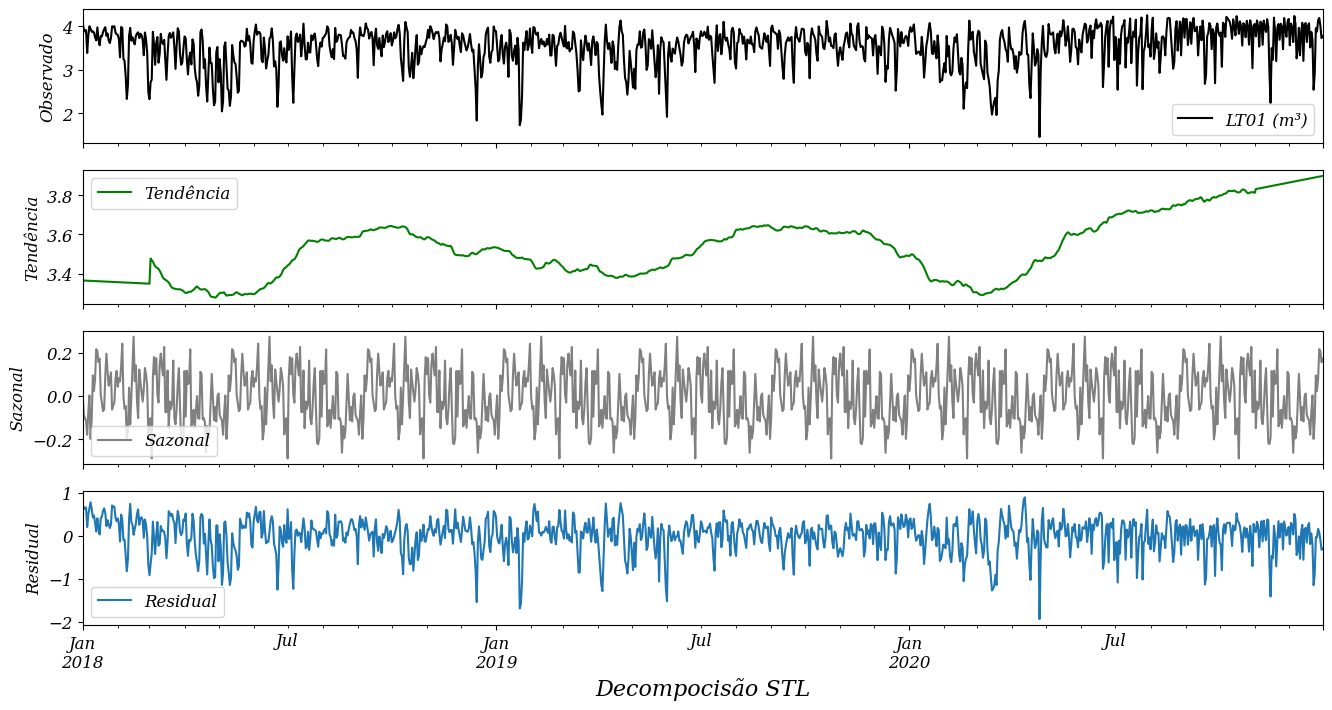

In [64]:
plt.figure(figsize = (15,6))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
fig, axes = plt.subplots(4, 1, sharex=True)
rcParams['figure.figsize'] = 16,8 # aumentar o tamanho do grafico
rst.observed.plot(ax=axes[0], legend=True, label = rt, color='black')
axes[0].set_ylabel('Observado')
rst.trend.plot(ax=axes[1], legend=True, label = 'Tendência', color='g')
axes[1].set_ylabel('Tendência')
rst.seasonal.plot(ax=axes[2], legend=True, label = 'Sazonal', color = 'gray')
axes[2].set_ylabel('Sazonal')
rst.resid.plot(ax=axes[3], legend=True, label = 'Residual')
axes[3].set_ylabel('Residual')
plt.xlabel( 'Decompocisão STL', fontsize = 16)
plt.savefig("STL.pdf", dpi=600)
plt.show()


In [65]:
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from statsmodels.tsa.seasonal import STL

# # Aplicar o método STL na série temporal
# rst = STL(endog, seasonal=7).fit()

# # Configuração inicial do gráfico
# fig, ax = plt.subplots(figsize=(16, 8))

# # Função de atualização para a animação
# def update(frame):
#     # Limpar o gráfico antes de atualizar
#     plt.cla()
    
#     # Plotar a tendência até o quadro atual
#     rst.trend[:frame].plot(ax=ax)
    
#     # Configurações adicionais do gráfico
#     plt.title('Tendência da Série Temporal')
#     plt.xlabel('Tempo')
#     plt.ylabel('Valores')
#     plt.grid(True)

# # Criação da animação
# ani = animation.FuncAnimation(fig, update, frames=len(rst.trend), interval=200)

# # Salvar a animação em um arquivo GIF
# animation_file = 'stl_animacao_tendencia.gif'
# ani.save(animation_file, writer='pillow')

# # Exibir a animação
# plt.show()


In [66]:


from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(endog)


(0.01, False)

In [67]:
# ## Auto ARIMA 
# from pmdarima import auto_arima
# stepwise_fit = auto_arima(endog_trn, start_p=0, start_q=0,
#                           max_p=10, max_q=10, m=12,
#                           start_P=0, seasonal=True,
#                           d=0, D=1, trace=True,
#                           error_action='ignore',   # não queremos saber se uma encomenda não funciona
#                           suppress_warnings=True,  # não queremos avisos de convergência
#                           stepwise=True)           # programado para escalonar
# stepwise_fit.summary()


## Modelo atualizado

In [68]:
# arima = str(stepwise_fit)
# best= pd.DataFrame({'p' : [arima[7]],
# 'd':[arima[9]],'q':[arima[11]],
# 'P' : [arima[14]],'D':[arima[16]],'Q':[arima[18]],'M':[arima[21]+arima[22]]},
# index=['Melhor Modelo'],)
# best.to_excel('best.xlsx')
# best

In [69]:
# arima = str(stepwise_fit)
# best= pd.DataFrame({'p' : [arima[7]],
# 'd':[arima[9]],'q':[arima[11]],
# 'P' : [arima[14]],'D':[arima[16]],'Q':[arima[18]],'M':[arima[21]]},
# index=['Melhor Modelo'],)
# best.to_excel('best.xlsx')
# best

In [70]:
# best = pd.read_excel("best.xlsx")
# p1 = int(best['p'])
# d1 = int(best['d'])
# q1 = int(best['q'])
# P1 = int(best['P'])
# D1 = int(best['D'])
# Q1 = int(best['Q'])
# M1 = int(best['M'])

In [71]:
p1 = 7
d1 = 1
q1 = 7
P1 = 2
D1 = 1
Q1 = 0
M1 = 12

# Modelos de previsão


### sMAPE

In [72]:
import numpy as np

def smape(y_true, y_pred):
    """
    Calculates the Symmetric Mean Absolute Percentage Error (SMAPE) between y_true and y_pred.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true) + np.abs(y_pred)
    return np.mean(numerator / denominator) * 100

y_true = [1, 2, 3, 4, 5]
y_pred = [1.2, 2.3, 3.4, 4.5, 5.6]
print(smape(y_true, y_pred))


6.772076715324527


### RRMSE

In [73]:

def rrmse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    rrmse = rmse / np.mean(y_true)
    return rrmse

y_true = [1, 2, 3, 4, 5]
y_pred = [1.5, 2.5, 3.5, 4.5, 5.5]
print(rrmse(y_true, y_pred))


0.16666666666666666


## Numeros de dias


In [74]:
# # Sem as 24 horas
# pv = 7*24
# pvl = str(int(pv/24))+' dias a frente'

# print(pv, pvl)
# 1, 7, 14, 30
# Com as 24 horas
pv = 1
pv_7 = 7
pv_14 = 14
pv_30 = 30
pvl = str(pv)+' dia à frente'
pvl_7 = str(pv_7)+' dias à frente'
pvl_14 = str(pv_14)+' dias à frente'
pvl_30 = str(pv_30)+' dias à frente'

print(pv, pvl)
print(pv_7, pvl_7)
print(pv_14, pvl_14)
print(pv_30, pvl_30)

1 1 dia à frente
7 7 dias à frente
14 14 dias à frente
30 30 dias à frente


## Auto-Regressivo Exogedo (ARX)

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARX (7) sMAPE Error: 4.015 Train
ARX (7) sMAPE Error: 3.653 Validation
ARX (7) sMAPE Error: 5.330 Test
ARX (7) sMAPE Error: 4.389 
ARX (7) MAE Error: 0.264 Train
ARX (7) MAE Error: 0.253 Validation
ARX (7) MAE Error: 0.367 Test
ARX (7) MAE Error: 0.295 
ARX (7) RRMSE Error: 0.105 Train
ARX (7) RRMSE Error: 0.097 Validation
ARX (7) RRMSE Error: 0.134 Test
ARX (7) RRMSE Error: 0.115 


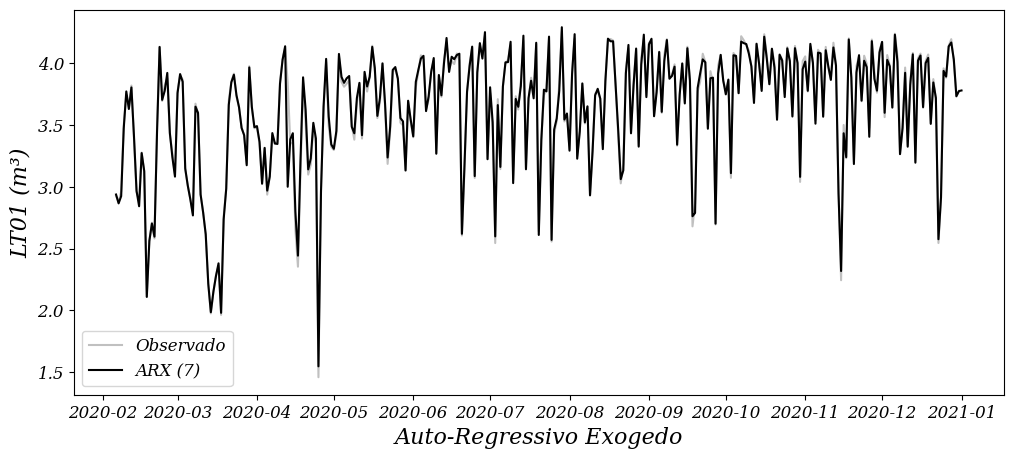

In [75]:
model_trn = ARIMA(endog_trn, exog_trn, order = (p1,0,0))
res_trn = model_trn.fit()

model_tst = ARIMA(endog_tst, exog_tst, order = (p1,0,0))
res_tst = model_tst.fit()

model_vld = ARIMA(endog_vld, exog_vld, order = (p1,0,0))
res_vld = model_vld.fit()

model = ARIMA(endog, exog, order = (p1,0,0))
res = model.fit()

### Previsão

arx_trn = res_trn.predict(start = -len(trn), end = len(trn)+0, exog = exog_trn[len(trn)-0-1:])
arx_vld = res_vld.predict(start = -len(vld), end = len(vld)+0, exog = exog_vld[len(vld)-0-1:])
arx_tst = res_tst.predict(start = -len(tst), end = len(tst)+0, exog = exog_tst[len(tst)-0-1:])
arx = res.predict(start = -len(df), end = len(df)+0, exog = exog[len(df)-0-1:])

### Erros AR

smape_ARX_trn = smape(endog_trn, arx_trn[0+1:])
smape_ARX_vld = smape(endog_vld, arx_vld[0+1:])
smape_ARX_tst = smape(endog_tst, arx_tst[0+1:])
ARX_smape = smape(endog, arx[0+1:])

mae_ARX_trn = mean_absolute_error(endog_trn, arx_trn[0+1:])
mae_ARX_vld = mean_absolute_error(endog_vld, arx_vld[0+1:])
mae_ARX_tst = mean_absolute_error(endog_tst, arx_tst[0+1:])
ARX_mae = mean_absolute_error(endog, arx[0+1:])

rrmse_ARX_trn = rrmse(endog_trn, arx_trn[0+1:])
rrmse_ARX_vld = rrmse(endog_vld, arx_vld[0+1:])
rrmse_ARX_tst = rrmse(endog_tst, arx_tst[0+1:])
ARX_rrmse = rrmse(endog, arx[0+1:])


print(f"ARX ({p1}) sMAPE Error: {smape_ARX_trn:2.3f} Train")
print(f"ARX ({p1}) sMAPE Error: {smape_ARX_vld:2.3f} Validation")
print(f"ARX ({p1}) sMAPE Error: {smape_ARX_tst:2.3f} Test")
print(f"ARX ({p1}) sMAPE Error: {ARX_smape:2.3f} ")

print(f"ARX ({p1}) MAE Error: {mae_ARX_trn:2.3f} Train")
print(f"ARX ({p1}) MAE Error: {mae_ARX_vld:2.3f} Validation")
print(f"ARX ({p1}) MAE Error: {mae_ARX_tst:2.3f} Test")
print(f"ARX ({p1}) MAE Error: {ARX_mae:2.3f} ")

print(f"ARX ({p1}) RRMSE Error: {rrmse_ARX_trn:2.3f} Train")
print(f"ARX ({p1}) RRMSE Error: {rrmse_ARX_vld:2.3f} Validation")
print(f"ARX ({p1}) RRMSE Error: {rrmse_ARX_tst:2.3f} Test")
print(f"ARX ({p1}) RRMSE Error: {ARX_rrmse:2.3f} ")

### Plotagem das previsão

# Um dia à frente

# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arx_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel( 'Auto-Regressivo Exogedo', fontsize = 16)
plt.legend(['Observado', f"ARX ({p1})"])
plt.savefig(f'ARX.pdf', dpi=600)
plt.show()


### 1 dia à frente

In [76]:

### Previsão

arx_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv, exog = exog_trn[len(trn)-pv-1:])
arx_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv, exog = exog_vld[len(vld)-pv-1:])
arx_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv, exog = exog_tst[len(tst)-pv-1:])
arx = res.predict(start = -len(df), end = len(df)+pv, exog = exog[len(df)-pv-1:])

### Erros AR

smape_ARX_trn = smape(endog_trn, arx_trn[pv+1:])
smape_ARX_vld = smape(endog_vld, arx_vld[pv+1:])
smape_ARX_tst = smape(endog_tst, arx_tst[pv+1:])
ARX_smape = smape(endog, arx[pv+1:])

mae_ARX_trn = mean_absolute_error(endog_trn, arx_trn[pv+1:])
mae_ARX_vld = mean_absolute_error(endog_vld, arx_vld[pv+1:])
mae_ARX_tst = mean_absolute_error(endog_tst, arx_tst[pv+1:])
ARX_mae = mean_absolute_error(endog, arx[pv+1:])

rrmse_ARX_trn = rrmse(endog_trn, arx_trn[pv+1:])
rrmse_ARX_vld = rrmse(endog_vld, arx_vld[pv+1:])
rrmse_ARX_tst = rrmse(endog_tst, arx_tst[pv+1:])
ARX_rrmse = rrmse(endog, arx[pv+1:])


print(f"ARX ({p1}) sMAPE Error: {smape_ARX_trn:2.3f} Train")
print(f"ARX ({p1}) sMAPE Error: {smape_ARX_vld:2.3f} Validation")
print(f"ARX ({p1}) sMAPE Error: {smape_ARX_tst:2.3f} Test")
print(f"ARX ({p1}) sMAPE Error: {ARX_smape:2.3f} ")

print(f"ARX ({p1}) MAE Error: {mae_ARX_trn:2.3f} Train")
print(f"ARX ({p1}) MAE Error: {mae_ARX_vld:2.3f} Validation")
print(f"ARX ({p1}) MAE Error: {mae_ARX_tst:2.3f} Test")
print(f"ARX ({p1}) MAE Error: {ARX_mae:2.3f} ")

print(f"ARX ({p1}) RRMSE Error: {rrmse_ARX_trn:2.3f} Train")
print(f"ARX ({p1}) RRMSE Error: {rrmse_ARX_vld:2.3f} Validation")
print(f"ARX ({p1}) RRMSE Error: {rrmse_ARX_tst:2.3f} Test")
print(f"ARX ({p1}) RRMSE Error: {ARX_rrmse:2.3f} ")

### Plotagem das previsão

# Um dia à frente

# # test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(arx_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel( 'Auto-Regressivo Exogedo', fontsize = 16)
# plt.legend(['Observado', f"ARX ({p1})"])
# plt.savefig(f'{pv}-ARX.pdf', dpi=600)
# plt.show()


ARX (7) sMAPE Error: 5.743 Train
ARX (7) sMAPE Error: 5.083 Validation
ARX (7) sMAPE Error: 6.694 Test
ARX (7) sMAPE Error: 5.980 
ARX (7) MAE Error: 0.377 Train
ARX (7) MAE Error: 0.354 Validation
ARX (7) MAE Error: 0.462 Test
ARX (7) MAE Error: 0.402 
ARX (7) RRMSE Error: 0.147 Train
ARX (7) RRMSE Error: 0.129 Validation
ARX (7) RRMSE Error: 0.162 Test
ARX (7) RRMSE Error: 0.150 


### 7 dias à frente

In [77]:

### Previsão

arx_7_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_7, exog = exog_trn[len(trn)-pv_7-1:])
arx_7_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_7, exog = exog_vld[len(vld)-pv_7-1:])
arx_7_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_7, exog = exog_tst[len(tst)-pv_7-1:])
arx_7 = res.predict(start = -len(df), end = len(df)+pv_7, exog = exog[len(df)-pv_7-1:])

### Erros AR

smape_ARX_7_trn = smape(endog_trn, arx_7_trn[pv_7+1:])
smape_ARX_7_vld = smape(endog_vld, arx_7_vld[pv_7+1:])
smape_ARX_7_tst = smape(endog_tst, arx_7_tst[pv_7+1:])
ARX_7_smape = smape(endog, arx_7[pv_7+1:])

mae_ARX_7_trn = mean_absolute_error(endog_trn, arx_7_trn[pv_7+1:])
mae_ARX_7_vld = mean_absolute_error(endog_vld, arx_7_vld[pv_7+1:])
mae_ARX_7_tst = mean_absolute_error(endog_tst, arx_7_tst[pv_7+1:])
ARX_7_mae = mean_absolute_error(endog, arx_7[pv_7+1:])

rrmse_ARX_7_trn = rrmse(endog_trn, arx_7_trn[pv_7+1:])
rrmse_ARX_7_vld = rrmse(endog_vld, arx_7_vld[pv_7+1:])
rrmse_ARX_7_tst = rrmse(endog_tst, arx_7_tst[pv_7+1:])
ARX_7_rrmse = rrmse(endog, arx_7[pv_7+1:])


print(f"ARX ({p1}) sMAPE Error: {smape_ARX_7_trn:2.3f} Train")
print(f"ARX ({p1}) sMAPE Error: {smape_ARX_7_vld:2.3f} Validation")
print(f"ARX ({p1}) sMAPE Error: {smape_ARX_7_tst:2.3f} Test")
print(f"ARX ({p1}) sMAPE Error: {ARX_7_smape:2.3f} ")

print(f"ARX ({p1}) MAE Error: {mae_ARX_7_trn:2.3f} Train")
print(f"ARX ({p1}) MAE Error: {mae_ARX_7_vld:2.3f} Validation")
print(f"ARX ({p1}) MAE Error: {mae_ARX_7_tst:2.3f} Test")
print(f"ARX ({p1}) MAE Error: {ARX_7_mae:2.3f} ")

print(f"ARX ({p1}) RRMSE Error: {rrmse_ARX_7_trn:2.3f} Train")
print(f"ARX ({p1}) RRMSE Error: {rrmse_ARX_7_vld:2.3f} Validation")
print(f"ARX ({p1}) RRMSE Error: {rrmse_ARX_7_tst:2.3f} Test")
print(f"ARX ({p1}) RRMSE Error: {ARX_7_rrmse:2.3f} ")

### Plotagem das previsão

# 7 dia à frente

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(arx_7_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel( 'Auto-Regressivo Exogedo', fontsize = 16)
# plt.legend(['Observado', f"ARX ({p1})"])
# plt.savefig(f'{pv_7}-ARX_7.pdf', dpi=600)
# plt.show()


ARX (7) sMAPE Error: 5.737 Train
ARX (7) sMAPE Error: 4.585 Validation
ARX (7) sMAPE Error: 7.015 Test
ARX (7) sMAPE Error: 6.059 
ARX (7) MAE Error: 0.377 Train
ARX (7) MAE Error: 0.319 Validation
ARX (7) MAE Error: 0.479 Test
ARX (7) MAE Error: 0.406 
ARX (7) RRMSE Error: 0.150 Train
ARX (7) RRMSE Error: 0.119 Validation
ARX (7) RRMSE Error: 0.174 Test
ARX (7) RRMSE Error: 0.156 


### 14 dias à frente

In [78]:
### Previsão

arx_14_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_14, exog = exog_trn[len(trn)-pv_14-1:])
arx_14_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_14, exog = exog_vld[len(vld)-pv_14-1:])
arx_14_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_14, exog = exog_tst[len(tst)-pv_14-1:])
arx_14 = res.predict(start = -len(df), end = len(df)+pv_14, exog = exog[len(df)-pv_14-1:])

### Erros AR

smape_ARX_14_trn = smape(endog_trn, arx_14_trn[pv_14+1:])
smape_ARX_14_vld = smape(endog_vld, arx_14_vld[pv_14+1:])
smape_ARX_14_tst = smape(endog_tst, arx_14_tst[pv_14+1:])
ARX_14_smape = smape(endog, arx_14[pv_14+1:])

mae_ARX_14_trn = mean_absolute_error(endog_trn, arx_14_trn[pv_14+1:])
mae_ARX_14_vld = mean_absolute_error(endog_vld, arx_14_vld[pv_14+1:])
mae_ARX_14_tst = mean_absolute_error(endog_tst, arx_14_tst[pv_14+1:])
ARX_14_mae = mean_absolute_error(endog, arx_14[pv_14+1:])

rrmse_ARX_14_trn = rrmse(endog_trn, arx_14_trn[pv_14+1:])
rrmse_ARX_14_vld = rrmse(endog_vld, arx_14_vld[pv_14+1:])
rrmse_ARX_14_tst = rrmse(endog_tst, arx_14_tst[pv_14+1:])
ARX_14_rrmse = rrmse(endog, arx_14[pv_14+1:])


print(f"ARX ({p1}) sMAPE Error: {smape_ARX_14_trn:2.3f} Train")
print(f"ARX ({p1}) sMAPE Error: {smape_ARX_14_vld:2.3f} Validation")
print(f"ARX ({p1}) sMAPE Error: {smape_ARX_14_tst:2.3f} Test")
print(f"ARX ({p1}) sMAPE Error: {ARX_14_smape:2.3f} ")

print(f"ARX ({p1}) MAE Error: {mae_ARX_14_trn:2.3f} Train")
print(f"ARX ({p1}) MAE Error: {mae_ARX_14_vld:2.3f} Validation")
print(f"ARX ({p1}) MAE Error: {mae_ARX_14_tst:2.3f} Test")
print(f"ARX ({p1}) MAE Error: {ARX_14_mae:2.3f} ")

print(f"ARX ({p1}) RRMSE Error: {rrmse_ARX_14_trn:2.3f} Train")
print(f"ARX ({p1}) RRMSE Error: {rrmse_ARX_14_vld:2.3f} Validation")
print(f"ARX ({p1}) RRMSE Error: {rrmse_ARX_14_tst:2.3f} Test")
print(f"ARX ({p1}) RRMSE Error: {ARX_14_rrmse:2.3f} ")

### Plotagem das previsão

# 14 dia à frente

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(arx_14_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel( 'Auto-Regressivo Exogedo', fontsize = 16)
# plt.legend(['Observado', f"ARX ({p1})"])
# plt.savefig(f'{pv_14}-ARX_14.pdf', dpi=600)
# plt.show()


ARX (7) sMAPE Error: 6.081 Train
ARX (7) sMAPE Error: 4.441 Validation
ARX (7) sMAPE Error: 5.743 Test
ARX (7) sMAPE Error: 5.923 
ARX (7) MAE Error: 0.399 Train
ARX (7) MAE Error: 0.309 Validation
ARX (7) MAE Error: 0.384 Test
ARX (7) MAE Error: 0.393 
ARX (7) RRMSE Error: 0.157 Train
ARX (7) RRMSE Error: 0.120 Validation
ARX (7) RRMSE Error: 0.155 Test
ARX (7) RRMSE Error: 0.154 


### 30 dias à frente

In [79]:

### Previsão

arx_30_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_30, exog = exog_trn[len(trn)-pv_30-1:])
arx_30_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_30, exog = exog_vld[len(vld)-pv_30-1:])
arx_30_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_30, exog = exog_tst[len(tst)-pv_30-1:])
arx_30 = res.predict(start = -len(df), end = len(df)+pv_30, exog = exog[len(df)-pv_30-1:])

### Erros AR

smape_ARX_30_trn = smape(endog_trn, arx_30_trn[pv_30+1:])
smape_ARX_30_vld = smape(endog_vld, arx_30_vld[pv_30+1:])
smape_ARX_30_tst = smape(endog_tst, arx_30_tst[pv_30+1:])
ARX_30_smape = smape(endog, arx_30[pv_30+1:])

mae_ARX_30_trn = mean_absolute_error(endog_trn, arx_30_trn[pv_30+1:])
mae_ARX_30_vld = mean_absolute_error(endog_vld, arx_30_vld[pv_30+1:])
mae_ARX_30_tst = mean_absolute_error(endog_tst, arx_30_tst[pv_30+1:])
ARX_30_mae = mean_absolute_error(endog, arx_30[pv_30+1:])

rrmse_ARX_30_trn = rrmse(endog_trn, arx_30_trn[pv_30+1:])
rrmse_ARX_30_vld = rrmse(endog_vld, arx_30_vld[pv_30+1:])
rrmse_ARX_30_tst = rrmse(endog_tst, arx_30_tst[pv_30+1:])
ARX_30_rrmse = rrmse(endog, arx_30[pv_30+1:])


print(f"ARX ({p1}) sMAPE Error: {smape_ARX_30_trn:2.3f} Train")
print(f"ARX ({p1}) sMAPE Error: {smape_ARX_30_vld:2.3f} Validation")
print(f"ARX ({p1}) sMAPE Error: {smape_ARX_30_tst:2.3f} Test")
print(f"ARX ({p1}) sMAPE Error: {ARX_30_smape:2.3f} ")

print(f"ARX ({p1}) MAE Error: {mae_ARX_30_trn:2.3f} Train")
print(f"ARX ({p1}) MAE Error: {mae_ARX_30_vld:2.3f} Validation")
print(f"ARX ({p1}) MAE Error: {mae_ARX_30_tst:2.3f} Test")
print(f"ARX ({p1}) MAE Error: {ARX_30_mae:2.3f} ")

print(f"ARX ({p1}) RRMSE Error: {rrmse_ARX_30_trn:2.3f} Train")
print(f"ARX ({p1}) RRMSE Error: {rrmse_ARX_30_vld:2.3f} Validation")
print(f"ARX ({p1}) RRMSE Error: {rrmse_ARX_30_tst:2.3f} Test")
print(f"ARX ({p1}) RRMSE Error: {ARX_30_rrmse:2.3f} ")

### Plotagem das previsão

# 30 dia à frente

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(arx_30_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel( 'Auto-Regressivo Exogedo', fontsize = 16)
# plt.legend(['Observado', f"ARX ({p1})"])
# plt.savefig(f'{pv_30}-ARX_30.pdf', dpi=600)
# plt.show()


ARX (7) sMAPE Error: 6.585 Train
ARX (7) sMAPE Error: 4.328 Validation
ARX (7) sMAPE Error: 6.762 Test
ARX (7) sMAPE Error: 6.682 
ARX (7) MAE Error: 0.432 Train
ARX (7) MAE Error: 0.302 Validation
ARX (7) MAE Error: 0.462 Test
ARX (7) MAE Error: 0.447 
ARX (7) RRMSE Error: 0.169 Train
ARX (7) RRMSE Error: 0.122 Validation
ARX (7) RRMSE Error: 0.173 Test
ARX (7) RRMSE Error: 0.169 


Índices das anomalias encontradas: [67]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


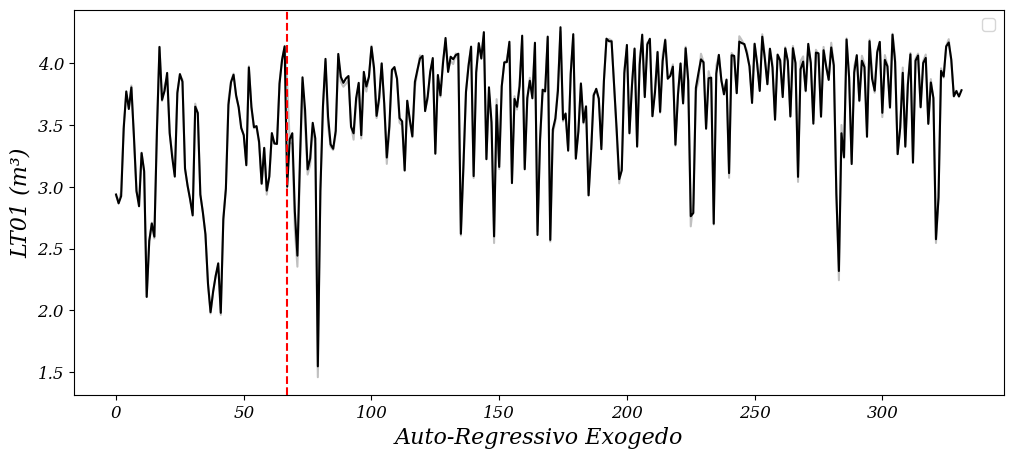

In [80]:
# Código anterior...


# Detecção de anomalias nos resíduos
residuals = res_tst.resid
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
threshold = 3 * std_residuals  # Definindo um limite de 3 desvios padrões

anomalies = np.where(np.abs(residuals) > threshold)[0]

print("Índices das anomalias encontradas:", anomalies)

# Plot dos dados observados
plt.figure(figsize=(12, 5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(arx_tst), 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel( 'Auto-Regressivo Exogedo', fontsize = 16)
plt.legend(['Observado', f"ARX ({p1})"])

# Destacar anomalias
anomaly_indices = anomalies
anomaly_values = endog[anomaly_indices]


# Adicionar linhas verticais para cada valor de anomalia

for anomaly_idx in anomaly_indices:
    plt.axvline(x=anomaly_idx, color='red', linestyle='--')
plt.savefig(f"{pv}-anomalia-SARIMAX.pdf", dpi=600)
plt.legend()
plt.show()

## Animação ARX

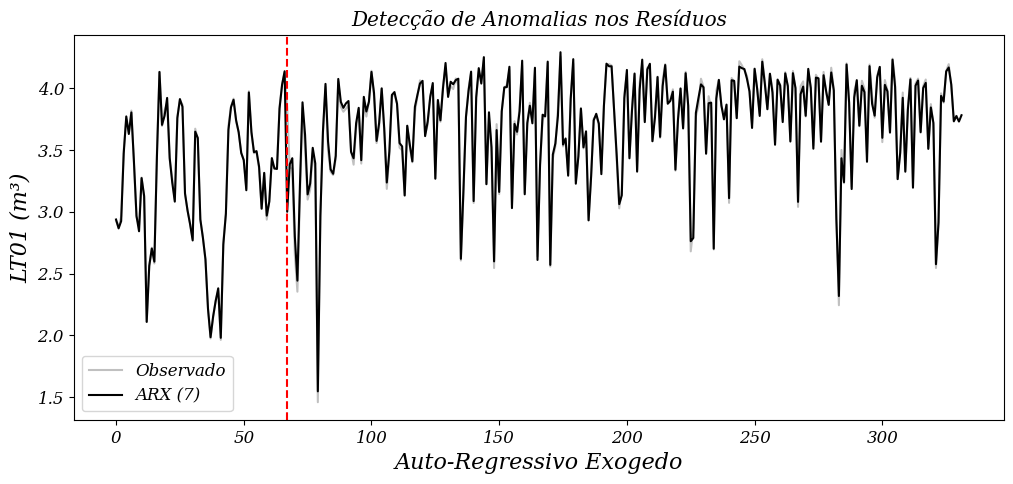

In [81]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np



# Configuração inicial do gráfico
fig, ax = plt.subplots(figsize=(12, 5))
plt.ylabel(rt, fontsize=16)
plt.xlabel('Auto-Regressivo Exogedo', fontsize=16)
plt.legend(['Observado', f"ARX ({p1})"])

# Função de atualização para a animação
def update(frame):
    plt.cla()
    plt.plot(list(endog_tst), 'silver')
    plt.plot(list(arx_tst), 'black')
    plt.ylabel(rt, fontsize=16)
    plt.xlabel('Auto-Regressivo Exogedo', fontsize=16)
    plt.legend(['Observado', f"ARX ({p1})"])
    
    # Destacar anomalias até o quadro atual
    anomaly_indices = anomalies[:frame+1]
    anomaly_values = endog[anomaly_indices]
    
    for anomaly_idx in anomaly_indices:
        plt.axvline(x=anomaly_idx, color='red', linestyle='--')
    
    plt.title('Detecção de Anomalias nos Resíduos')
    

# Criação da animação
ani = animation.FuncAnimation(fig, update, frames=len(anomalies), interval=200)

# Salvar a animação em um arquivo GIF
animation_file = 'animacao_anomalias.gif'
ani.save(animation_file, writer='pillow')

# Exibir a animação
plt.show()


# Lag Ljung Box

In [82]:
lag = [10]
lag

[10]

In [83]:

lj_arx_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_arx_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_arx_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_arx_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)


## Auto-Regressivo (AR)


AR (7) sMAPE Error: 2.391 Train
AR (7) sMAPE Error: 2.329 Validation
AR (7) sMAPE Error: 3.278 Test
AR (7) sMAPE Error: 2.464 
AR (7) MAE Error: 0.157 Train
AR (7) MAE Error: 0.161 Validation
AR (7) MAE Error: 0.224 Test
AR (7) MAE Error: 0.164 
AR (7) RRMSE Error: 0.059 Train
AR (7) RRMSE Error: 0.057 Validation
AR (7) RRMSE Error: 0.076 Test
AR (7) RRMSE Error: 0.061 


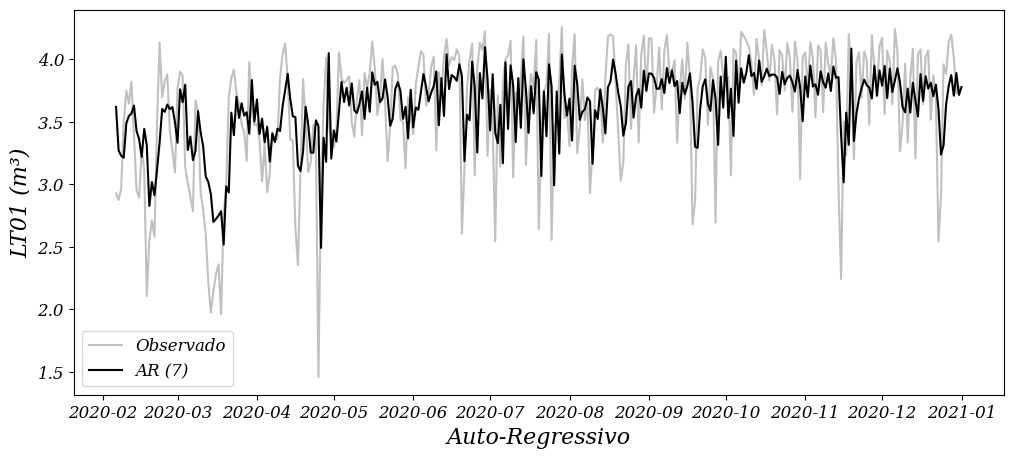

In [84]:
model_trn = ARIMA(endog_trn, order = (p1,0,0))
res_trn = model_trn.fit()

model_tst = ARIMA(endog_tst, order = (p1,0,0))
res_tst = model_tst.fit()

model_vld = ARIMA(endog_vld, order = (p1,0,0))
res_vld = model_vld.fit()

model = ARIMA(endog, order = (p1,0,0))
res = model.fit()

### Previsão

ar_trn = res_trn.predict(start = -len(trn), end = len(trn)+0)
ar_vld = res_vld.predict(start = -len(vld), end = len(vld)+0)
ar_tst = res_tst.predict(start = -len(tst), end = len(tst)+0)
ar = res.predict(start = -len(df), end = len(df)+0)

### Erros AR

smape_AR_trn = smape(endog_trn, ar_trn[0+1:])
smape_AR_vld = smape(endog_vld, ar_vld[0+1:])
smape_AR_tst = smape(endog_tst, ar_tst[0+1:])
AR_smape = smape(endog, ar[0+1:])

mae_AR_trn = mean_absolute_error(endog_trn, ar_trn[0+1:])
mae_AR_vld = mean_absolute_error(endog_vld, ar_vld[0+1:])
mae_AR_tst = mean_absolute_error(endog_tst, ar_tst[0+1:])
AR_mae = mean_absolute_error(endog, ar[0+1:])

rrmse_AR_trn = rrmse(endog_trn, ar_trn[0+1:])
rrmse_AR_vld = rrmse(endog_vld, ar_vld[0+1:])
rrmse_AR_tst = rrmse(endog_tst, ar_tst[0+1:])
AR_rrmse = rrmse(endog, ar[0+1:])

print(f"AR ({p1}) sMAPE Error: {smape_AR_trn:2.3f} Train")
print(f"AR ({p1}) sMAPE Error: {smape_AR_vld:2.3f} Validation")
print(f"AR ({p1}) sMAPE Error: {smape_AR_tst:2.3f} Test")
print(f"AR ({p1}) sMAPE Error: {AR_smape:2.3f} ")

print(f"AR ({p1}) MAE Error: {mae_AR_trn:2.3f} Train")
print(f"AR ({p1}) MAE Error: {mae_AR_vld:2.3f} Validation")
print(f"AR ({p1}) MAE Error: {mae_AR_tst:2.3f} Test")
print(f"AR ({p1}) MAE Error: {AR_mae:2.3f} ")

print(f"AR ({p1}) RRMSE Error: {rrmse_AR_trn:2.3f} Train")
print(f"AR ({p1}) RRMSE Error: {rrmse_AR_vld:2.3f} Validation")
print(f"AR ({p1}) RRMSE Error: {rrmse_AR_tst:2.3f} Test")
print(f"AR ({p1}) RRMSE Error: {AR_rrmse:2.3f} ")

### Plotagem das previsão

# 1 dia à frente

# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(ar_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel( 'Auto-Regressivo', fontsize = 16)
plt.legend(['Observado', f"AR ({p1})"])
plt.savefig(f'AR.pdf', dpi=600)
plt.show()


### 1 dia à frente

In [85]:
model_trn = ARIMA(endog_trn, order = (p1,0,0))
res_trn = model_trn.fit()

model_tst = ARIMA(endog_tst, order = (p1,0,0))
res_tst = model_tst.fit()

model_vld = ARIMA(endog_vld, order = (p1,0,0))
res_vld = model_vld.fit()

model = ARIMA(endog, order = (p1,0,0))
res = model.fit()

### Previsão

ar_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
ar_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
ar_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
ar = res.predict(start = -len(df), end = len(df)+pv)

### Erros AR

smape_AR_trn = smape(endog_trn, ar_trn[pv+1:])
smape_AR_vld = smape(endog_vld, ar_vld[pv+1:])
smape_AR_tst = smape(endog_tst, ar_tst[pv+1:])
AR_smape = smape(endog, ar[pv+1:])

mae_AR_trn = mean_absolute_error(endog_trn, ar_trn[pv+1:])
mae_AR_vld = mean_absolute_error(endog_vld, ar_vld[pv+1:])
mae_AR_tst = mean_absolute_error(endog_tst, ar_tst[pv+1:])
AR_mae = mean_absolute_error(endog, ar[pv+1:])

rrmse_AR_trn = rrmse(endog_trn, ar_trn[pv+1:])
rrmse_AR_vld = rrmse(endog_vld, ar_vld[pv+1:])
rrmse_AR_tst = rrmse(endog_tst, ar_tst[pv+1:])
AR_rrmse = rrmse(endog, ar[pv+1:])

print(f"AR ({p1}) sMAPE Error: {smape_AR_trn:2.3f} Train")
print(f"AR ({p1}) sMAPE Error: {smape_AR_vld:2.3f} Validation")
print(f"AR ({p1}) sMAPE Error: {smape_AR_tst:2.3f} Test")
print(f"AR ({p1}) sMAPE Error: {AR_smape:2.3f} ")

print(f"AR ({p1}) MAE Error: {mae_AR_trn:2.3f} Train")
print(f"AR ({p1}) MAE Error: {mae_AR_vld:2.3f} Validation")
print(f"AR ({p1}) MAE Error: {mae_AR_tst:2.3f} Test")
print(f"AR ({p1}) MAE Error: {AR_mae:2.3f} ")

print(f"AR ({p1}) RRMSE Error: {rrmse_AR_trn:2.3f} Train")
print(f"AR ({p1}) RRMSE Error: {rrmse_AR_vld:2.3f} Validation")
print(f"AR ({p1}) RRMSE Error: {rrmse_AR_tst:2.3f} Test")
print(f"AR ({p1}) RRMSE Error: {AR_rrmse:2.3f} ")

### Plotagem das previsão

# 1 dia à frente

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(ar_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel( 'Auto-Regressivo', fontsize = 16)
# plt.legend(['Observado', f"AR ({p1})"])
# plt.savefig(f'{pv}-AR.pdf', dpi=600)
# plt.show()


AR (7) sMAPE Error: 4.559 Train
AR (7) sMAPE Error: 4.069 Validation
AR (7) sMAPE Error: 4.748 Test
AR (7) sMAPE Error: 4.436 
AR (7) MAE Error: 0.306 Train
AR (7) MAE Error: 0.285 Validation
AR (7) MAE Error: 0.329 Test
AR (7) MAE Error: 0.302 
AR (7) RRMSE Error: 0.120 Train
AR (7) RRMSE Error: 0.102 Validation
AR (7) RRMSE Error: 0.117 Test
AR (7) RRMSE Error: 0.115 


### 7 dias à frente

In [86]:

### Previsão

ar_7_trn = res_trn.predict(star_7t = -len(trn), end = len(trn)+pv_7)
ar_7_vld = res_vld.predict(star_7t = -len(vld), end = len(vld)+pv_7)
ar_7_tst = res_tst.predict(star_7t = -len(tst), end = len(tst)+pv_7)
ar_7 = res.predict(star_7t = -len(df), end = len(df)+pv_7)

### Erros AR_7

smape_AR_7_trn = smape(endog_trn, ar_7_trn[pv_7+1:])
smape_AR_7_vld = smape(endog_vld, ar_7_vld[pv_7+1:])
smape_AR_7_tst = smape(endog_tst, ar_7_tst[pv_7+1:])
AR_7_smape = smape(endog, ar_7[pv_7+1:])

mae_AR_7_trn = mean_absolute_error(endog_trn, ar_7_trn[pv_7+1:])
mae_AR_7_vld = mean_absolute_error(endog_vld, ar_7_vld[pv_7+1:])
mae_AR_7_tst = mean_absolute_error(endog_tst, ar_7_tst[pv_7+1:])
AR_7_mae = mean_absolute_error(endog, ar_7[pv_7+1:])

rrmse_AR_7_trn = rrmse(endog_trn, ar_7_trn[pv_7+1:])
rrmse_AR_7_vld = rrmse(endog_vld, ar_7_vld[pv_7+1:])
rrmse_AR_7_tst = rrmse(endog_tst, ar_7_tst[pv_7+1:])
AR_7_rrmse = rrmse(endog, ar_7[pv_7+1:])

print(f"AR ({p1}) sMAPE Error: {smape_AR_7_trn:2.3f} Train")
print(f"AR ({p1}) sMAPE Error: {smape_AR_7_vld:2.3f} Validation")
print(f"AR ({p1}) sMAPE Error: {smape_AR_7_tst:2.3f} Test")
print(f"AR ({p1}) sMAPE Error: {AR_7_smape:2.3f} ")

print(f"AR ({p1}) MAE Error: {mae_AR_7_trn:2.3f} Train")
print(f"AR ({p1}) MAE Error: {mae_AR_7_vld:2.3f} Validation")
print(f"AR ({p1}) MAE Error: {mae_AR_7_tst:2.3f} Test")
print(f"AR ({p1}) MAE Error: {AR_7_mae:2.3f} ")

print(f"AR ({p1}) RRMSE Error: {rrmse_AR_7_trn:2.3f} Train")
print(f"AR ({p1}) RRMSE Error: {rrmse_AR_7_vld:2.3f} Validation")
print(f"AR ({p1}) RRMSE Error: {rrmse_AR_7_tst:2.3f} Test")
print(f"AR ({p1}) RRMSE Error: {AR_7_rrmse:2.3f} ")

### Plotagem das previsão

# 7 dias à frente

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(ar_7_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel( 'Auto-Regressivo', fontsize = 16)
# plt.legend(['Observado', f"AR ({p1})"])
# plt.savefig(f'{pv_7}-AR_7.pdf', dpi=600)
# plt.show()


AR (7) sMAPE Error: 4.458 Train
AR (7) sMAPE Error: 3.523 Validation
AR (7) sMAPE Error: 5.536 Test
AR (7) sMAPE Error: 4.666 
AR (7) MAE Error: 0.296 Train
AR (7) MAE Error: 0.245 Validation
AR (7) MAE Error: 0.383 Test
AR (7) MAE Error: 0.316 
AR (7) RRMSE Error: 0.114 Train
AR (7) RRMSE Error: 0.089 Validation
AR (7) RRMSE Error: 0.138 Test
AR (7) RRMSE Error: 0.119 


### 14 dias à frente

In [87]:

### Previsão

ar_14_trn = res_trn.predict(star_14t = -len(trn), end = len(trn)+pv_14)
ar_14_vld = res_vld.predict(star_14t = -len(vld), end = len(vld)+pv_14)
ar_14_tst = res_tst.predict(star_14t = -len(tst), end = len(tst)+pv_14)
ar_14 = res.predict(star_14t = -len(df), end = len(df)+pv_14)

### Erros AR_14

smape_AR_14_trn = smape(endog_trn, ar_14_trn[pv_14+1:])
smape_AR_14_vld = smape(endog_vld, ar_14_vld[pv_14+1:])
smape_AR_14_tst = smape(endog_tst, ar_14_tst[pv_14+1:])
AR_14_smape = smape(endog, ar_14[pv_14+1:])

mae_AR_14_trn = mean_absolute_error(endog_trn, ar_14_trn[pv_14+1:])
mae_AR_14_vld = mean_absolute_error(endog_vld, ar_14_vld[pv_14+1:])
mae_AR_14_tst = mean_absolute_error(endog_tst, ar_14_tst[pv_14+1:])
AR_14_mae = mean_absolute_error(endog, ar_14[pv_14+1:])

rrmse_AR_14_trn = rrmse(endog_trn, ar_14_trn[pv_14+1:])
rrmse_AR_14_vld = rrmse(endog_vld, ar_14_vld[pv_14+1:])
rrmse_AR_14_tst = rrmse(endog_tst, ar_14_tst[pv_14+1:])
AR_14_rrmse = rrmse(endog, ar_14[pv_14+1:])

print(f"AR ({p1}) sMAPE Error: {smape_AR_14_trn:2.3f} Train")
print(f"AR ({p1}) sMAPE Error: {smape_AR_14_vld:2.3f} Validation")
print(f"AR ({p1}) sMAPE Error: {smape_AR_14_tst:2.3f} Test")
print(f"AR ({p1}) sMAPE Error: {AR_14_smape:2.3f} ")

print(f"AR ({p1}) MAE Error: {mae_AR_14_trn:2.3f} Train")
print(f"AR ({p1}) MAE Error: {mae_AR_14_vld:2.3f} Validation")
print(f"AR ({p1}) MAE Error: {mae_AR_14_tst:2.3f} Test")
print(f"AR ({p1}) MAE Error: {AR_14_mae:2.3f} ")

print(f"AR ({p1}) RRMSE Error: {rrmse_AR_14_trn:2.3f} Train")
print(f"AR ({p1}) RRMSE Error: {rrmse_AR_14_vld:2.3f} Validation")
print(f"AR ({p1}) RRMSE Error: {rrmse_AR_14_tst:2.3f} Test")
print(f"AR ({p1}) RRMSE Error: {AR_14_rrmse:2.3f} ")

### Plotagem das previsão

# 14 dias à frente

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(ar_14_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel( 'Auto-Regressivo', fontsize = 16)
# plt.legend(['Observado', f"AR ({p1})"])
# plt.savefig(f'{pv_14}-AR_14.pdf', dpi=600)
# plt.show()


AR (7) sMAPE Error: 5.016 Train
AR (7) sMAPE Error: 3.790 Validation
AR (7) sMAPE Error: 5.502 Test
AR (7) sMAPE Error: 4.950 
AR (7) MAE Error: 0.334 Train
AR (7) MAE Error: 0.264 Validation
AR (7) MAE Error: 0.378 Test
AR (7) MAE Error: 0.335 
AR (7) RRMSE Error: 0.127 Train
AR (7) RRMSE Error: 0.097 Validation
AR (7) RRMSE Error: 0.139 Test
AR (7) RRMSE Error: 0.127 


### 30 dias à frente 

In [88]:

### Previsão

ar_30_trn = res_trn.predict(star_30t = -len(trn), end = len(trn)+pv_30)
ar_30_vld = res_vld.predict(star_30t = -len(vld), end = len(vld)+pv_30)
ar_30_tst = res_tst.predict(star_30t = -len(tst), end = len(tst)+pv_30)
ar_30 = res.predict(star_30t = -len(df), end = len(df)+pv_30)

### Erros AR_30

smape_AR_30_trn = smape(endog_trn, ar_30_trn[pv_30+1:])
smape_AR_30_vld = smape(endog_vld, ar_30_vld[pv_30+1:])
smape_AR_30_tst = smape(endog_tst, ar_30_tst[pv_30+1:])
AR_30_smape = smape(endog, ar_30[pv_30+1:])

mae_AR_30_trn = mean_absolute_error(endog_trn, ar_30_trn[pv_30+1:])
mae_AR_30_vld = mean_absolute_error(endog_vld, ar_30_vld[pv_30+1:])
mae_AR_30_tst = mean_absolute_error(endog_tst, ar_30_tst[pv_30+1:])
AR_30_mae = mean_absolute_error(endog, ar_30[pv_30+1:])

rrmse_AR_30_trn = rrmse(endog_trn, ar_30_trn[pv_30+1:])
rrmse_AR_30_vld = rrmse(endog_vld, ar_30_vld[pv_30+1:])
rrmse_AR_30_tst = rrmse(endog_tst, ar_30_tst[pv_30+1:])
AR_30_rrmse = rrmse(endog, ar_30[pv_30+1:])

print(f"AR ({p1}) sMAPE Error: {smape_AR_30_trn:2.3f} Train")
print(f"AR ({p1}) sMAPE Error: {smape_AR_30_vld:2.3f} Validation")
print(f"AR ({p1}) sMAPE Error: {smape_AR_30_tst:2.3f} Test")
print(f"AR ({p1}) sMAPE Error: {AR_30_smape:2.3f} ")

print(f"AR ({p1}) MAE Error: {mae_AR_30_trn:2.3f} Train")
print(f"AR ({p1}) MAE Error: {mae_AR_30_vld:2.3f} Validation")
print(f"AR ({p1}) MAE Error: {mae_AR_30_tst:2.3f} Test")
print(f"AR ({p1}) MAE Error: {AR_30_mae:2.3f} ")

print(f"AR ({p1}) RRMSE Error: {rrmse_AR_30_trn:2.3f} Train")
print(f"AR ({p1}) RRMSE Error: {rrmse_AR_30_vld:2.3f} Validation")
print(f"AR ({p1}) RRMSE Error: {rrmse_AR_30_tst:2.3f} Test")
print(f"AR ({p1}) RRMSE Error: {AR_30_rrmse:2.3f} ")

### Plotagem das previsão

# 30 dias à frente

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(ar_30_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel( 'Auto-Regressivo', fontsize = 16)
# plt.legend(['Observado', f"AR ({p1})"])
# plt.savefig(f'{pv_30}-AR_30.pdf', dpi=600)
# plt.show()


AR (7) sMAPE Error: 5.729 Train
AR (7) sMAPE Error: 4.442 Validation
AR (7) sMAPE Error: 5.432 Test
AR (7) sMAPE Error: 5.404 
AR (7) MAE Error: 0.383 Train
AR (7) MAE Error: 0.311 Validation
AR (7) MAE Error: 0.375 Test
AR (7) MAE Error: 0.367 
AR (7) RRMSE Error: 0.147 Train
AR (7) RRMSE Error: 0.109 Validation
AR (7) RRMSE Error: 0.137 Test
AR (7) RRMSE Error: 0.137 


# Anomalias AR

Índices das anomalias encontradas: [ 79 135 170]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


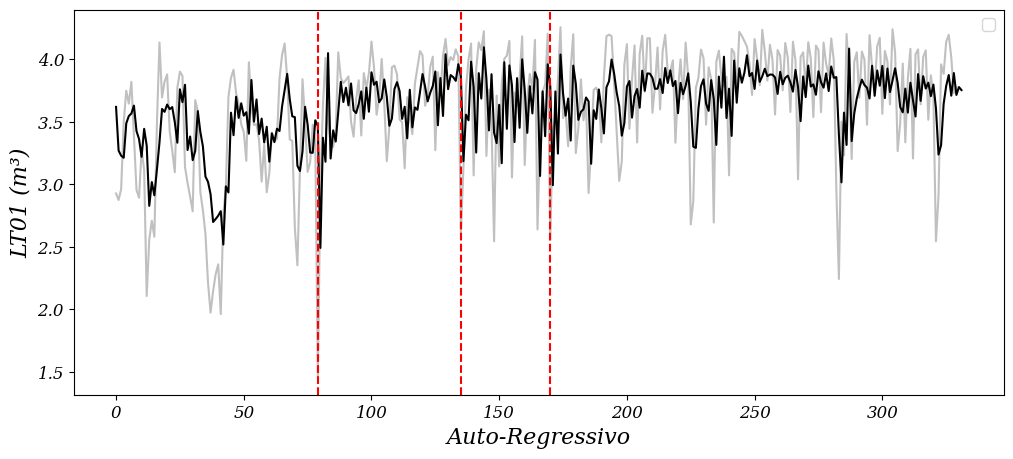

In [89]:
# Código anterior...


# Detecção de anomalias nos resíduos
residuals = res_tst.resid
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
threshold = 3 * std_residuals  # Definindo um limite de 3 desvios padrões

anomalies = np.where(np.abs(residuals) > threshold)[0]

print("Índices das anomalias encontradas:", anomalies)

# Plot dos dados observados
plt.figure(figsize=(12, 5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(ar_tst), 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel( 'Auto-Regressivo', fontsize = 16)
plt.legend(['Observado', f"AR ({p1})"])

# Destacar anomalias
anomaly_indices = anomalies
anomaly_values = endog[anomaly_indices]


# Adicionar linhas verticais para cada valor de anomalia

for anomaly_idx in anomaly_indices:
    plt.axvline(x=anomaly_idx, color='red', linestyle='--')
plt.savefig(f"{pv}-anomalia-SARIMAX.pdf", dpi=600)
plt.legend()
plt.show()


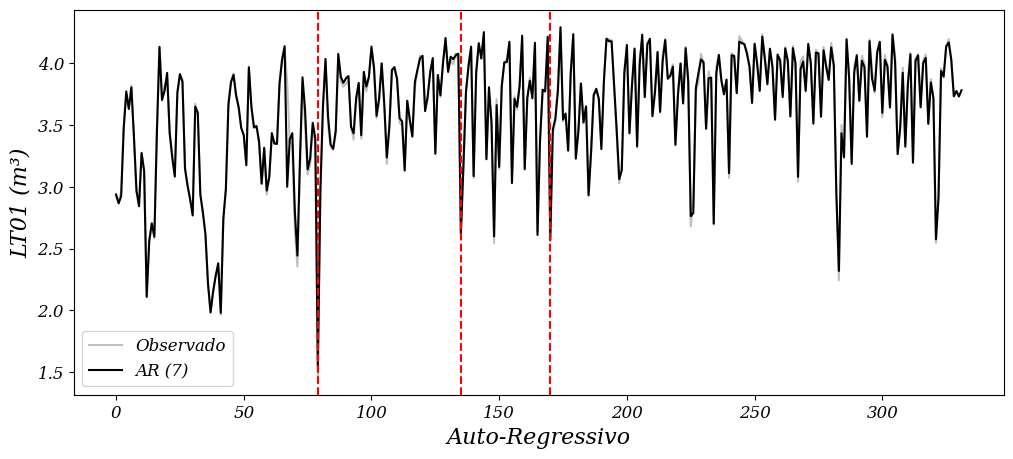

In [90]:


# Configuração inicial do gráfico
fig, ax = plt.subplots(figsize=(12, 5))
plt.ylabel(rt, fontsize=16)
plt.xlabel('Auto-Regressivo Exogedo', fontsize=16)
plt.legend(['Observado', f"ARX ({p1})"])

# Função de atualização para a animação
def update(frame):
    plt.cla()
    plt.plot(list(endog_tst), 'silver')
    plt.plot(list(arx_tst), 'black')
    plt.ylabel(rt, fontsize = 16)
    plt.xlabel( 'Auto-Regressivo', fontsize = 16)
    plt.legend(['Observado', f"AR ({p1})"])
    
    # Destacar anomalias até o quadro atual
    anomaly_indices = anomalies[:frame+1]
    anomaly_values = endog[anomaly_indices]
    
    for anomaly_idx in anomaly_indices:
        plt.axvline(x=anomaly_idx, color='red', linestyle='--')
    
    

# Criação da animação
ani = animation.FuncAnimation(fig, update, frames=len(anomalies), interval=200)

# Salvar a animação em um arquivo GIF
animation_file = 'animacao_anomalias.gif'
ani.save(animation_file, writer='pillow')

# Exibir a animação
plt.show()


In [91]:
lj_ar_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_ar_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_ar_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_ar_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## Médias Móveis (MA)


MA (7) sMAPE Error: 2.207 Train
MA (7) sMAPE Error: 2.249 Validation
MA (7) sMAPE Error: 3.367 Test
MA (7) sMAPE Error: 2.468 
MA (7) MAE Error: 0.144 Train
MA (7) MAE Error: 0.155 Validation
MA (7) MAE Error: 0.230 Test
MA (7) MAE Error: 0.164 
MA (7) RRMSE Error: 0.055 Train
MA (7) RRMSE Error: 0.056 Validation
MA (7) RRMSE Error: 0.078 Test
MA (7) RRMSE Error: 0.061 Test


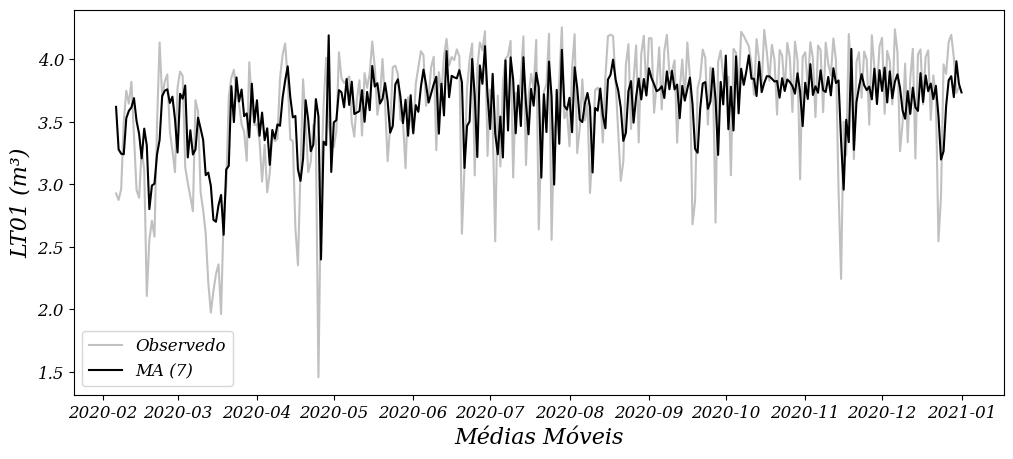

In [92]:

model_trn = ARIMA(endog_trn,order=(0,0,q1))
res_trn = model_trn.fit()

model_vld = ARIMA(endog_vld,order=(0,0,q1))
res_vld = model_vld.fit()

model_tst = ARIMA(endog_tst,order=(0,0,q1))
res_tst = model_tst.fit()

model = ARIMA(endog,order=(0,0,q1))
res = model.fit()

### Previsão

ma_trn = res_trn.predict(start = -len(trn), end = len(trn)+0)
ma_vld = res_vld.predict(start = -len(vld), end = len(vld)+0)
ma_tst = res_tst.predict(start = -len(tst), end = len(tst)+0)
MA = res.predict(start = -len(df), end = len(df)+0)

### Erros MA

smape_MA_trn = smape(endog_trn, ma_trn[0+1:])
smape_MA_vld = smape(endog_vld, ma_vld[0+1:])
smape_MA_tst = smape(endog_tst, ma_tst[0+1:])
MA_smape = smape(endog, MA[0+1:])

mae_MA_trn = mean_absolute_error(endog_trn, ma_trn[0+1:])
mae_MA_vld = mean_absolute_error(endog_vld, ma_vld[0+1:])
mae_MA_tst = mean_absolute_error(endog_tst, ma_tst[0+1:])
MA_mae = mean_absolute_error(endog, MA[0+1:])

rrmse_MA_trn = rrmse(endog_trn, ma_trn[0+1:])
rrmse_MA_vld = rrmse(endog_vld, ma_vld[0+1:])
rrmse_MA_tst = rrmse(endog_tst, ma_tst[0+1:])
MA_rrmse = rrmse(endog, MA[0+1:])

print(f"MA ({q1}) sMAPE Error: {smape_MA_trn:2.3f} Train")
print(f"MA ({q1}) sMAPE Error: {smape_MA_vld:2.3f} Validation")
print(f"MA ({q1}) sMAPE Error: {smape_MA_tst:2.3f} Test")
print(f"MA ({q1}) sMAPE Error: {MA_smape:2.3f} ")

print(f"MA ({q1}) MAE Error: {mae_MA_trn:2.3f} Train")
print(f"MA ({q1}) MAE Error: {mae_MA_vld:2.3f} Validation")
print(f"MA ({q1}) MAE Error: {mae_MA_tst:2.3f} Test")
print(f"MA ({q1}) MAE Error: {MA_mae:2.3f} ")

print(f"MA ({q1}) RRMSE Error: {rrmse_MA_trn:2.3f} Train")
print(f"MA ({q1}) RRMSE Error: {rrmse_MA_vld:2.3f} Validation")
print(f"MA ({q1}) RRMSE Error: {rrmse_MA_tst:2.3f} Test")
print(f"MA ({q1}) RRMSE Error: {MA_rrmse:2.3f} Test")


### Plotagem das previsão


# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(ma_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel('Médias Móveis', fontsize = 16)
plt.legend(['Observedo', f"MA ({q1})"])
plt.savefig(f"MA.pdf", dpi=600)

plt.show()


### 1 dia à frente

In [93]:


### Previsão

ma_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
ma_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
ma_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
MA = res.predict(start = -len(df), end = len(df)+pv)

### Erros MA

smape_MA_trn = smape(endog_trn, ma_trn[pv+1:])
smape_MA_vld = smape(endog_vld, ma_vld[pv+1:])
smape_MA_tst = smape(endog_tst, ma_tst[pv+1:])
MA_smape = smape(endog, MA[pv+1:])

mae_MA_trn = mean_absolute_error(endog_trn, ma_trn[pv+1:])
mae_MA_vld = mean_absolute_error(endog_vld, ma_vld[pv+1:])
mae_MA_tst = mean_absolute_error(endog_tst, ma_tst[pv+1:])
MA_mae = mean_absolute_error(endog, MA[pv+1:])

rrmse_MA_trn = rrmse(endog_trn, ma_trn[pv+1:])
rrmse_MA_vld = rrmse(endog_vld, ma_vld[pv+1:])
rrmse_MA_tst = rrmse(endog_tst, ma_tst[pv+1:])
MA_rrmse = rrmse(endog, MA[pv+1:])

print(f"MA ({q1}) sMAPE Error: {smape_MA_trn:2.3f} Train")
print(f"MA ({q1}) sMAPE Error: {smape_MA_vld:2.3f} Validation")
print(f"MA ({q1}) sMAPE Error: {smape_MA_tst:2.3f} Test")
print(f"MA ({q1}) sMAPE Error: {MA_smape:2.3f} ")

print(f"MA ({q1}) MAE Error: {mae_MA_trn:2.3f} Train")
print(f"MA ({q1}) MAE Error: {mae_MA_vld:2.3f} Validation")
print(f"MA ({q1}) MAE Error: {mae_MA_tst:2.3f} Test")
print(f"MA ({q1}) MAE Error: {MA_mae:2.3f} ")

print(f"MA ({q1}) RRMSE Error: {rrmse_MA_trn:2.3f} Train")
print(f"MA ({q1}) RRMSE Error: {rrmse_MA_vld:2.3f} Validation")
print(f"MA ({q1}) RRMSE Error: {rrmse_MA_tst:2.3f} Test")
print(f"MA ({q1}) RRMSE Error: {MA_rrmse:2.3f} Test")


### Plotagem das previsão


# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(ma_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel('Médias Móveis', fontsize = 16)
# plt.legend(['Observedo', f"MA ({q1})"])
# plt.savefig(f"{pv}-MA.pdf", dpi=600)

# plt.show()


MA (7) sMAPE Error: 4.421 Train
MA (7) sMAPE Error: 3.977 Validation
MA (7) sMAPE Error: 4.862 Test
MA (7) sMAPE Error: 4.434 
MA (7) MAE Error: 0.296 Train
MA (7) MAE Error: 0.278 Validation
MA (7) MAE Error: 0.336 Test
MA (7) MAE Error: 0.302 
MA (7) RRMSE Error: 0.115 Train
MA (7) RRMSE Error: 0.101 Validation
MA (7) RRMSE Error: 0.119 Test
MA (7) RRMSE Error: 0.114 Test


### 7 dias à frente

In [94]:

### Previsão

ma_7_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_7)
ma_7_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_7)
ma_7_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_7)
MA_7 = res.predict(start = -len(df), end = len(df)+pv_7)

### Erros MA_7

smape_MA_7_trn = smape(endog_trn, ma_7_trn[pv_7+1:])
smape_MA_7_vld = smape(endog_vld, ma_7_vld[pv_7+1:])
smape_MA_7_tst = smape(endog_tst, ma_7_tst[pv_7+1:])
MA_7_smape = smape(endog, MA_7[pv_7+1:])

mae_MA_7_trn = mean_absolute_error(endog_trn, ma_7_trn[pv_7+1:])
mae_MA_7_vld = mean_absolute_error(endog_vld, ma_7_vld[pv_7+1:])
mae_MA_7_tst = mean_absolute_error(endog_tst, ma_7_tst[pv_7+1:])
MA_7_mae = mean_absolute_error(endog, MA_7[pv_7+1:])

rrmse_MA_7_trn = rrmse(endog_trn, ma_7_trn[pv_7+1:])
rrmse_MA_7_vld = rrmse(endog_vld, ma_7_vld[pv_7+1:])
rrmse_MA_7_tst = rrmse(endog_tst, ma_7_tst[pv_7+1:])
MA_7_rrmse = rrmse(endog, MA_7[pv_7+1:])

print(f"MA ({q1}) sMAPE Error: {smape_MA_7_trn:2.3f} Train")
print(f"MA ({q1}) sMAPE Error: {smape_MA_7_vld:2.3f} Validation")
print(f"MA ({q1}) sMAPE Error: {smape_MA_7_tst:2.3f} Test")
print(f"MA ({q1}) sMAPE Error: {MA_7_smape:2.3f} ")

print(f"MA ({q1}) MAE Error: {mae_MA_7_trn:2.3f} Train")
print(f"MA ({q1}) MAE Error: {mae_MA_7_vld:2.3f} Validation")
print(f"MA ({q1}) MAE Error: {mae_MA_7_tst:2.3f} Test")
print(f"MA ({q1}) MAE Error: {MA_7_mae:2.3f} ")

print(f"MA ({q1}) RRMSE Error: {rrmse_MA_7_trn:2.3f} Train")
print(f"MA ({q1}) RRMSE Error: {rrmse_MA_7_vld:2.3f} Validation")
print(f"MA ({q1}) RRMSE Error: {rrmse_MA_7_tst:2.3f} Test")
print(f"MA ({q1}) RRMSE Error: {MA_7_rrmse:2.3f} Test")


### Plotagem das previsão


# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(ma_7_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel('Médias Móveis', fontsize = 16)
# plt.legend(['Observedo', f"MA ({q1})"])
# plt.savefig(f"{pv_7}-MA_7.pdf", dpi=600)

# plt.show()


MA (7) sMAPE Error: 4.947 Train
MA (7) sMAPE Error: 3.859 Validation
MA (7) sMAPE Error: 5.804 Test
MA (7) sMAPE Error: 5.144 
MA (7) MAE Error: 0.329 Train
MA (7) MAE Error: 0.269 Validation
MA (7) MAE Error: 0.403 Test
MA (7) MAE Error: 0.350 
MA (7) RRMSE Error: 0.127 Train
MA (7) RRMSE Error: 0.099 Validation
MA (7) RRMSE Error: 0.146 Test
MA (7) RRMSE Error: 0.132 Test


### 14 dias à frente

In [95]:

### Previsão

ma_14_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_14)
ma_14_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_14)
ma_14_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_14)
MA_14 = res.predict(start = -len(df), end = len(df)+pv_14)

### Erros MA_14

smape_MA_14_trn = smape(endog_trn, ma_14_trn[pv_14+1:])
smape_MA_14_vld = smape(endog_vld, ma_14_vld[pv_14+1:])
smape_MA_14_tst = smape(endog_tst, ma_14_tst[pv_14+1:])
MA_14_smape = smape(endog, MA_14[pv_14+1:])

mae_MA_14_trn = mean_absolute_error(endog_trn, ma_14_trn[pv_14+1:])
mae_MA_14_vld = mean_absolute_error(endog_vld, ma_14_vld[pv_14+1:])
mae_MA_14_tst = mean_absolute_error(endog_tst, ma_14_tst[pv_14+1:])
MA_14_mae = mean_absolute_error(endog, MA_14[pv_14+1:])

rrmse_MA_14_trn = rrmse(endog_trn, ma_14_trn[pv_14+1:])
rrmse_MA_14_vld = rrmse(endog_vld, ma_14_vld[pv_14+1:])
rrmse_MA_14_tst = rrmse(endog_tst, ma_14_tst[pv_14+1:])
MA_14_rrmse = rrmse(endog, MA_14[pv_14+1:])

print(f"MA ({q1}) sMAPE Error: {smape_MA_14_trn:2.3f} Train")
print(f"MA ({q1}) sMAPE Error: {smape_MA_14_vld:2.3f} Validation")
print(f"MA ({q1}) sMAPE Error: {smape_MA_14_tst:2.3f} Test")
print(f"MA ({q1}) sMAPE Error: {MA_14_smape:2.3f} ")

print(f"MA ({q1}) MAE Error: {mae_MA_14_trn:2.3f} Train")
print(f"MA ({q1}) MAE Error: {mae_MA_14_vld:2.3f} Validation")
print(f"MA ({q1}) MAE Error: {mae_MA_14_tst:2.3f} Test")
print(f"MA ({q1}) MAE Error: {MA_14_mae:2.3f} ")

print(f"MA ({q1}) RRMSE Error: {rrmse_MA_14_trn:2.3f} Train")
print(f"MA ({q1}) RRMSE Error: {rrmse_MA_14_vld:2.3f} Validation")
print(f"MA ({q1}) RRMSE Error: {rrmse_MA_14_tst:2.3f} Test")
print(f"MA ({q1}) RRMSE Error: {MA_14_rrmse:2.3f} Test")


### Plotagem das previsão


# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(ma_14_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel('Médias Móveis', fontsize = 16)
# plt.legend(['Observedo', f"MA ({q1})"])
# plt.savefig(f"{pv_14}-MA_14.pdf", dpi=600)

# plt.show()


MA (7) sMAPE Error: 5.048 Train
MA (7) sMAPE Error: 3.813 Validation
MA (7) sMAPE Error: 5.606 Test
MA (7) sMAPE Error: 5.002 
MA (7) MAE Error: 0.336 Train
MA (7) MAE Error: 0.265 Validation
MA (7) MAE Error: 0.385 Test
MA (7) MAE Error: 0.339 
MA (7) RRMSE Error: 0.128 Train
MA (7) RRMSE Error: 0.098 Validation
MA (7) RRMSE Error: 0.141 Test
MA (7) RRMSE Error: 0.128 Test


### 30 dias à frente

In [96]:

### Previsão

ma_30_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_30)
ma_30_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_30)
ma_30_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_30)
MA_30 = res.predict(start = -len(df), end = len(df)+pv_30)

### Erros MA_30

smape_MA_30_trn = smape(endog_trn, ma_30_trn[pv_30+1:])
smape_MA_30_vld = smape(endog_vld, ma_30_vld[pv_30+1:])
smape_MA_30_tst = smape(endog_tst, ma_30_tst[pv_30+1:])
MA_30_smape = smape(endog, MA_30[pv_30+1:])

mae_MA_30_trn = mean_absolute_error(endog_trn, ma_30_trn[pv_30+1:])
mae_MA_30_vld = mean_absolute_error(endog_vld, ma_30_vld[pv_30+1:])
mae_MA_30_tst = mean_absolute_error(endog_tst, ma_30_tst[pv_30+1:])
MA_30_mae = mean_absolute_error(endog, MA_30[pv_30+1:])

rrmse_MA_30_trn = rrmse(endog_trn, ma_30_trn[pv_30+1:])
rrmse_MA_30_vld = rrmse(endog_vld, ma_30_vld[pv_30+1:])
rrmse_MA_30_tst = rrmse(endog_tst, ma_30_tst[pv_30+1:])
MA_30_rrmse = rrmse(endog, MA_30[pv_30+1:])

print(f"MA ({q1}) sMAPE Error: {smape_MA_30_trn:2.3f} Train")
print(f"MA ({q1}) sMAPE Error: {smape_MA_30_vld:2.3f} Validation")
print(f"MA ({q1}) sMAPE Error: {smape_MA_30_tst:2.3f} Test")
print(f"MA ({q1}) sMAPE Error: {MA_30_smape:2.3f} ")

print(f"MA ({q1}) MAE Error: {mae_MA_30_trn:2.3f} Train")
print(f"MA ({q1}) MAE Error: {mae_MA_30_vld:2.3f} Validation")
print(f"MA ({q1}) MAE Error: {mae_MA_30_tst:2.3f} Test")
print(f"MA ({q1}) MAE Error: {MA_30_mae:2.3f} ")

print(f"MA ({q1}) RRMSE Error: {rrmse_MA_30_trn:2.3f} Train")
print(f"MA ({q1}) RRMSE Error: {rrmse_MA_30_vld:2.3f} Validation")
print(f"MA ({q1}) RRMSE Error: {rrmse_MA_30_tst:2.3f} Test")
print(f"MA ({q1}) RRMSE Error: {MA_30_rrmse:2.3f} Test")


### Plotagem das previsão


# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(ma_30_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel('Médias Móveis', fontsize = 16)
# plt.legend(['Observedo', f"MA ({q1})"])
# plt.savefig(f"{pv_30}-MA_30.pdf", dpi=600)

# plt.show()


MA (7) sMAPE Error: 5.670 Train
MA (7) sMAPE Error: 4.375 Validation
MA (7) sMAPE Error: 5.553 Test
MA (7) sMAPE Error: 5.362 
MA (7) MAE Error: 0.379 Train
MA (7) MAE Error: 0.306 Validation
MA (7) MAE Error: 0.384 Test
MA (7) MAE Error: 0.364 
MA (7) RRMSE Error: 0.146 Train
MA (7) RRMSE Error: 0.107 Validation
MA (7) RRMSE Error: 0.139 Test
MA (7) RRMSE Error: 0.137 Test


Índices das anomalias encontradas: [79]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


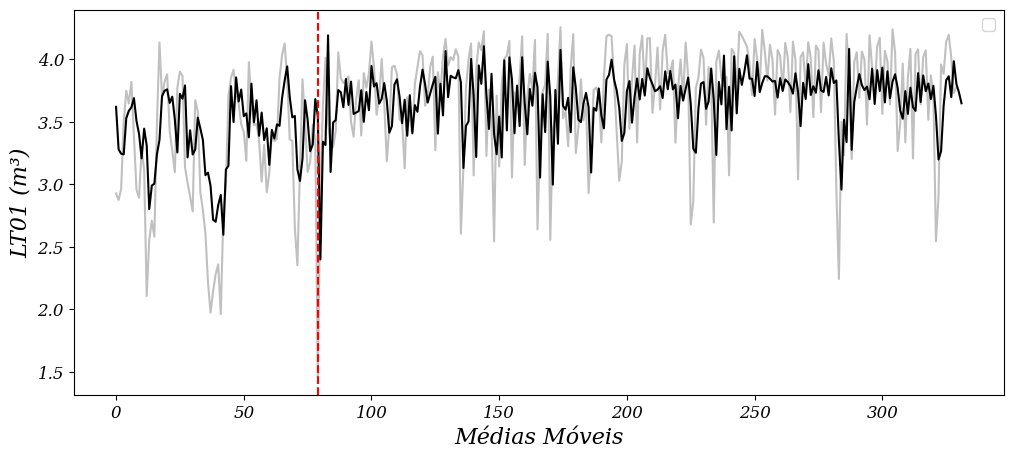

In [97]:
# Código anterior...


# Detecção de anomalias nos resíduos
residuals = res_tst.resid
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
threshold = 3 * std_residuals  # Definindo um limite de 3 desvios padrões

anomalies = np.where(np.abs(residuals) > threshold)[0]

print("Índices das anomalias encontradas:", anomalies)

# Plot dos dados observados
plt.figure(figsize=(12, 5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(ma_tst), 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel('Médias Móveis', fontsize = 16)
plt.legend(['Observedo', f"MA ({q1})"])

# Destacar anomalias
anomaly_indices = anomalies
anomaly_values = endog[anomaly_indices]


# Adicionar linhas verticais para cada valor de anomalia

for anomaly_idx in anomaly_indices:
    plt.axvline(x=anomaly_idx, color='red', linestyle='--')
plt.savefig(f"{pv}-anomalia-MA.pdf", dpi=600)
plt.legend()
plt.show()


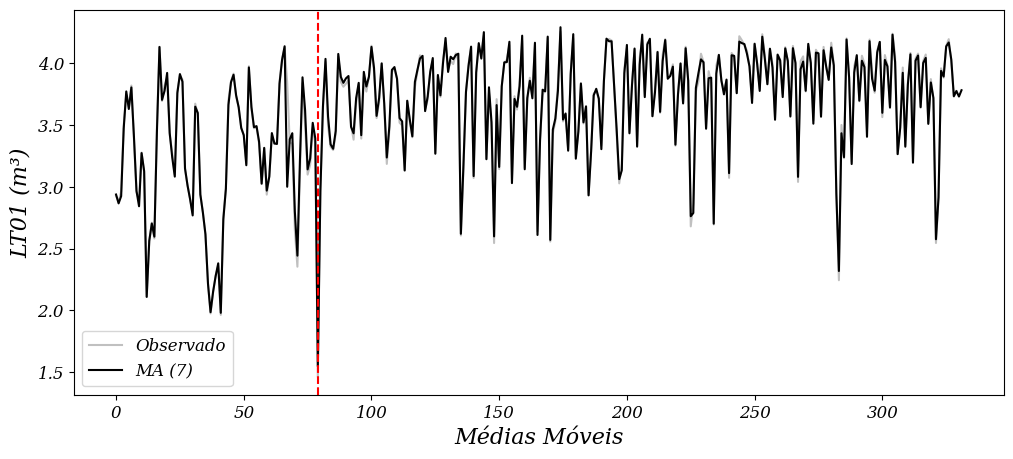

In [98]:

# Configuração inicial do gráfico
fig, ax = plt.subplots(figsize=(12, 5))
plt.ylabel(rt, fontsize=16)
plt.xlabel('Médias Móveis', fontsize=16)
plt.legend(['Observado', f"MA ({q1})"])

# Função de atualização para a animação
def update(frame):
    plt.cla()
    plt.plot(list(endog_tst), 'silver')
    plt.plot(list(arx_tst), 'black')
    plt.ylabel(rt, fontsize=16)
    plt.xlabel('Médias Móveis', fontsize=16)
    plt.legend(['Observado', f"MA ({q1})"])

    # Destacar anomalias até o quadro atual
    anomaly_indices = anomalies[:frame+1]
    anomaly_values = endog[anomaly_indices]

    for anomaly_idx in anomaly_indices:
        plt.axvline(x=anomaly_idx, color='red', linestyle='--')

    

# Criação da animação
ani = animation.FuncAnimation(fig, update, frames=len(anomalies), interval=200)

# Salvar a animação em um arquivo GIF
animation_file = 'animacao_medias_moveis.gif'
ani.save(animation_file, writer='pillow')

# Exibir a animação
plt.show()


In [99]:

lj_ma_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_ma_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_ma_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_ma_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)


## ARMA


c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARMA (7, 7) sMAPE Error: 2.662 Train
ARMA (7, 7) sMAPE Error: 2.700 Validation
ARMA (7, 7) sMAPE Error: 3.598 Test
ARMA (7, 7) sMAPE Error: 2.618 
ARMA (7, 7) MAE Error: 0.176 Train
ARMA (7, 7) MAE Error: 0.188 Validation
ARMA (7, 7) MAE Error: 0.250 Test
ARMA (7, 7) MAE Error: 0.175
ARMA (7, 7) RRMSE Error: 0.065 Train
ARMA (7, 7) RRMSE Error: 0.064 Validation
ARMA (7, 7) RRMSE Error: 0.083 Test
ARMA (7, 7) RRMSE Error: 0.065 Test


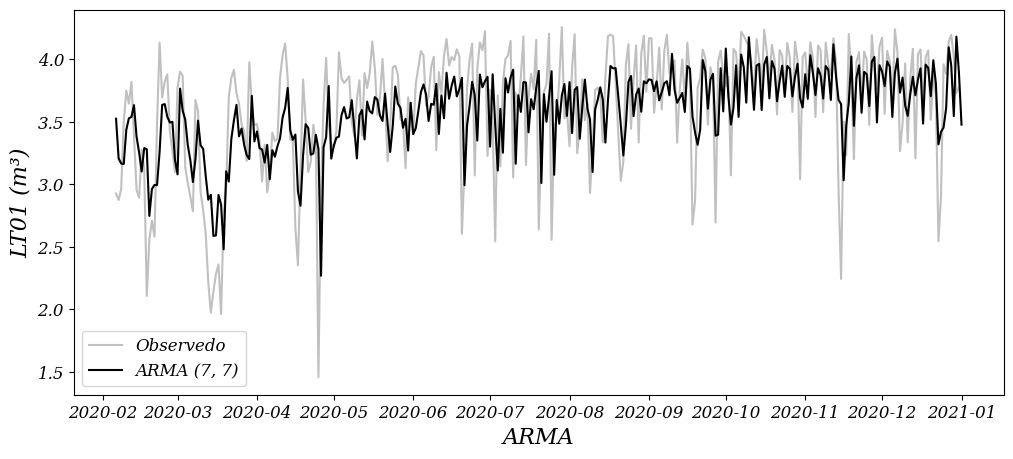

In [100]:

model_trn = ARIMA(endog_trn,order=(p1,0,q1))
res_trn = model_trn.fit()

model_vld = ARIMA(endog_vld,order=(p1,0,q1))
res_vld = model_vld.fit()

model_tst = ARIMA(endog_tst,order=(p1,0,q1))
res_tst = model_tst.fit()

model = ARIMA(endog,order=(p1,0,q1))
res = model.fit()

arma_trn = res_trn.predict(start = -len(trn), end = len(trn)+0)
arma_vld = res_vld.predict(start = -len(vld), end = len(vld)+0)
arma_tst = res_tst.predict(start = -len(tst), end = len(tst)+0)
arma = res.predict(start = -len(df), end = len(df)+0)


### Erros ARMA



smape_ARMA_trn = smape(endog_trn, arma_trn[0+1:])
smape_ARMA_vld = smape(endog_vld, arma_vld[0+1:])
smape_ARMA_tst = smape(endog_tst, arma_tst[0+1:])
ARMA_smape = smape(endog, arma[0+1:])

mae_ARMA_trn = mean_absolute_error(endog_trn, arma_trn[0+1:])
mae_ARMA_vld = mean_absolute_error(endog_vld, arma_vld[0+1:])
mae_ARMA_tst = mean_absolute_error(endog_tst, arma_tst[0+1:])
ARMA_mae = mean_absolute_error(endog, arma[0+1:])

rrmse_ARMA_trn = rrmse(endog_trn, arma_trn[0+1:])
rrmse_ARMA_vld = rrmse(endog_vld, arma_vld[0+1:])
rrmse_ARMA_tst = rrmse(endog_tst, arma_tst[0+1:])
ARMA_rrmse = rrmse(endog, arma[0+1:])


print(f"ARMA {p1,q1} sMAPE Error: {smape_ARMA_trn:2.3f} Train")
print(f"ARMA {p1,q1} sMAPE Error: {smape_ARMA_vld:2.3f} Validation")
print(f"ARMA {p1,q1} sMAPE Error: {smape_ARMA_tst:2.3f} Test")
print(f"ARMA {p1,q1} sMAPE Error: {ARMA_smape:2.3f} ")

print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_trn:2.3f} Train")
print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_vld:2.3f} Validation")
print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_tst:2.3f} Test")
print(f"ARMA {p1,q1} MAE Error: {ARMA_mae:2.3f}")

print(f"ARMA {p1,q1} RRMSE Error: {rrmse_ARMA_trn:2.3f} Train")
print(f"ARMA {p1,q1} RRMSE Error: {rrmse_ARMA_vld:2.3f} Validation")
print(f"ARMA {p1,q1} RRMSE Error: {rrmse_ARMA_tst:2.3f} Test")
print(f"ARMA {p1,q1} RRMSE Error: {ARMA_rrmse:2.3f} Test")

### Plotagem das previsão


# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arma_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel('ARMA', fontsize = 16)
plt.legend(['Observedo', f"ARMA {p1,q1}"])
plt.savefig(f"ARMA.pdf", dpi=600)
plt.show()


### 1 dia à frente

In [101]:



arma_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
arma_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
arma_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
arma = res.predict(start = -len(df), end = len(df)+pv)


### Erros ARMA



smape_ARMA_trn = smape(endog_trn, arma_trn[pv+1:])
smape_ARMA_vld = smape(endog_vld, arma_vld[pv+1:])
smape_ARMA_tst = smape(endog_tst, arma_tst[pv+1:])
ARMA_smape = smape(endog, arma[pv+1:])

mae_ARMA_trn = mean_absolute_error(endog_trn, arma_trn[pv+1:])
mae_ARMA_vld = mean_absolute_error(endog_vld, arma_vld[pv+1:])
mae_ARMA_tst = mean_absolute_error(endog_tst, arma_tst[pv+1:])
ARMA_mae = mean_absolute_error(endog, arma[pv+1:])

rrmse_ARMA_trn = rrmse(endog_trn, arma_trn[pv+1:])
rrmse_ARMA_vld = rrmse(endog_vld, arma_vld[pv+1:])
rrmse_ARMA_tst = rrmse(endog_tst, arma_tst[pv+1:])
ARMA_rrmse = rrmse(endog, arma[pv+1:])


print(f"ARMA {p1,q1} sMAPE Error: {smape_ARMA_trn:2.3f} Train")
print(f"ARMA {p1,q1} sMAPE Error: {smape_ARMA_vld:2.3f} Validation")
print(f"ARMA {p1,q1} sMAPE Error: {smape_ARMA_tst:2.3f} Test")
print(f"ARMA {p1,q1} sMAPE Error: {ARMA_smape:2.3f} ")

print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_trn:2.3f} Train")
print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_vld:2.3f} Validation")
print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_tst:2.3f} Test")
print(f"ARMA {p1,q1} MAE Error: {ARMA_mae:2.3f}")

print(f"ARMA {p1,q1} RRMSE Error: {rrmse_ARMA_trn:2.3f} Train")
print(f"ARMA {p1,q1} RRMSE Error: {rrmse_ARMA_vld:2.3f} Validation")
print(f"ARMA {p1,q1} RRMSE Error: {rrmse_ARMA_tst:2.3f} Test")
print(f"ARMA {p1,q1} RRMSE Error: {ARMA_rrmse:2.3f} Test")

### Plotagem das previsão


# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(arma_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel('ARMA', fontsize = 16)
# plt.legend(['Observedo', f"ARMA {p1,q1}"])
# plt.savefig(f"{pv}-ARMA.pdf", dpi=600)
# plt.show()


ARMA (7, 7) sMAPE Error: 4.837 Train
ARMA (7, 7) sMAPE Error: 4.213 Validation
ARMA (7, 7) sMAPE Error: 4.920 Test
ARMA (7, 7) sMAPE Error: 4.629 
ARMA (7, 7) MAE Error: 0.325 Train
ARMA (7, 7) MAE Error: 0.295 Validation
ARMA (7, 7) MAE Error: 0.340 Test
ARMA (7, 7) MAE Error: 0.316
ARMA (7, 7) RRMSE Error: 0.125 Train
ARMA (7, 7) RRMSE Error: 0.104 Validation
ARMA (7, 7) RRMSE Error: 0.119 Test
ARMA (7, 7) RRMSE Error: 0.120 Test


### 7 dias à frente

In [102]:

arma_7_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_7)
arma_7_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_7)
arma_7_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_7)
arma_7 = res.predict(start = -len(df), end = len(df)+pv_7)


### Erros ARMA_7



smape_ARMA_7_trn = smape(endog_trn, arma_7_trn[pv_7+1:])
smape_ARMA_7_vld = smape(endog_vld, arma_7_vld[pv_7+1:])
smape_ARMA_7_tst = smape(endog_tst, arma_7_tst[pv_7+1:])
ARMA_7_smape = smape(endog, arma_7[pv_7+1:])

mae_ARMA_7_trn = mean_absolute_error(endog_trn, arma_7_trn[pv_7+1:])
mae_ARMA_7_vld = mean_absolute_error(endog_vld, arma_7_vld[pv_7+1:])
mae_ARMA_7_tst = mean_absolute_error(endog_tst, arma_7_tst[pv_7+1:])
ARMA_7_mae = mean_absolute_error(endog, arma_7[pv_7+1:])

rrmse_ARMA_7_trn = rrmse(endog_trn, arma_7_trn[pv_7+1:])
rrmse_ARMA_7_vld = rrmse(endog_vld, arma_7_vld[pv_7+1:])
rrmse_ARMA_7_tst = rrmse(endog_tst, arma_7_tst[pv_7+1:])
ARMA_7_rrmse = rrmse(endog, arma_7[pv_7+1:])


print(f"ARMA {p1,q1} sMAPE Error: {smape_ARMA_7_trn:2.3f} Train")
print(f"ARMA {p1,q1} sMAPE Error: {smape_ARMA_7_vld:2.3f} Validation")
print(f"ARMA {p1,q1} sMAPE Error: {smape_ARMA_7_tst:2.3f} Test")
print(f"ARMA {p1,q1} sMAPE Error: {ARMA_7_smape:2.3f} ")

print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_7_trn:2.3f} Train")
print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_7_vld:2.3f} Validation")
print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_7_tst:2.3f} Test")
print(f"ARMA {p1,q1} MAE Error: {ARMA_7_mae:2.3f}")

print(f"ARMA {p1,q1} RRMSE Error: {rrmse_ARMA_7_trn:2.3f} Train")
print(f"ARMA {p1,q1} RRMSE Error: {rrmse_ARMA_7_vld:2.3f} Validation")
print(f"ARMA {p1,q1} RRMSE Error: {rrmse_ARMA_7_tst:2.3f} Test")
print(f"ARMA {p1,q1} RRMSE Error: {ARMA_7_rrmse:2.3f} Test")

### Plotagem das previsão


# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(arma_7_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel('ARMA', fontsize = 16)
# plt.legend(['Observedo', f"ARM {p1,q1}"])
# plt.savefig(f"{pv_7}-ARMA_7.pdf", dpi=600)
# plt.show()


ARMA (7, 7) sMAPE Error: 4.947 Train
ARMA (7, 7) sMAPE Error: 3.938 Validation
ARMA (7, 7) sMAPE Error: 5.582 Test
ARMA (7, 7) sMAPE Error: 4.612 
ARMA (7, 7) MAE Error: 0.330 Train
ARMA (7, 7) MAE Error: 0.274 Validation
ARMA (7, 7) MAE Error: 0.384 Test
ARMA (7, 7) MAE Error: 0.312
ARMA (7, 7) RRMSE Error: 0.125 Train
ARMA (7, 7) RRMSE Error: 0.097 Validation
ARMA (7, 7) RRMSE Error: 0.136 Test
ARMA (7, 7) RRMSE Error: 0.118 Test


### 14 dias à frente

In [103]:

arma_14_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_14)
arma_14_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_14)
arma_14_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_14)
arma_14 = res.predict(start = -len(df), end = len(df)+pv_14)


### Erros ARMA_14



smape_ARMA_14_trn = smape(endog_trn, arma_14_trn[pv_14+1:])
smape_ARMA_14_vld = smape(endog_vld, arma_14_vld[pv_14+1:])
smape_ARMA_14_tst = smape(endog_tst, arma_14_tst[pv_14+1:])
ARMA_14_smape = smape(endog, arma_14[pv_14+1:])

mae_ARMA_14_trn = mean_absolute_error(endog_trn, arma_14_trn[pv_14+1:])
mae_ARMA_14_vld = mean_absolute_error(endog_vld, arma_14_vld[pv_14+1:])
mae_ARMA_14_tst = mean_absolute_error(endog_tst, arma_14_tst[pv_14+1:])
ARMA_14_mae = mean_absolute_error(endog, arma_14[pv_14+1:])

rrmse_ARMA_14_trn = rrmse(endog_trn, arma_14_trn[pv_14+1:])
rrmse_ARMA_14_vld = rrmse(endog_vld, arma_14_vld[pv_14+1:])
rrmse_ARMA_14_tst = rrmse(endog_tst, arma_14_tst[pv_14+1:])
ARMA_14_rrmse = rrmse(endog, arma_14[pv_14+1:])


print(f"ARMA {p1,q1} sMAPE Error: {smape_ARMA_14_trn:2.3f} Train")
print(f"ARMA {p1,q1} sMAPE Error: {smape_ARMA_14_vld:2.3f} Validation")
print(f"ARMA {p1,q1} sMAPE Error: {smape_ARMA_14_tst:2.3f} Test")
print(f"ARMA {p1,q1} sMAPE Error: {ARMA_14_smape:2.3f} ")

print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_14_trn:2.3f} Train")
print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_14_vld:2.3f} Validation")
print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_14_tst:2.3f} Test")
print(f"ARMA {p1,q1} MAE Error: {ARMA_14_mae:2.3f}")

print(f"ARMA {p1,q1} RRMSE Error: {rrmse_ARMA_14_trn:2.3f} Train")
print(f"ARMA {p1,q1} RRMSE Error: {rrmse_ARMA_14_vld:2.3f} Validation")
print(f"ARMA {p1,q1} RRMSE Error: {rrmse_ARMA_14_tst:2.3f} Test")
print(f"ARMA {p1,q1} RRMSE Error: {ARMA_14_rrmse:2.3f} Test")

### Plotagem das previsão


# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(arma_14_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel('ARMA', fontsize = 16)
# plt.legend(['Observedo', f"ARM {p1,q1}"])
# plt.savefig(f"{pv_14}-ARMA_14.pdf", dpi=600)
# plt.show()


ARMA (7, 7) sMAPE Error: 5.248 Train
ARMA (7, 7) sMAPE Error: 4.538 Validation
ARMA (7, 7) sMAPE Error: 5.059 Test
ARMA (7, 7) sMAPE Error: 4.616 
ARMA (7, 7) MAE Error: 0.350 Train
ARMA (7, 7) MAE Error: 0.317 Validation
ARMA (7, 7) MAE Error: 0.344 Test
ARMA (7, 7) MAE Error: 0.311
ARMA (7, 7) RRMSE Error: 0.132 Train
ARMA (7, 7) RRMSE Error: 0.113 Validation
ARMA (7, 7) RRMSE Error: 0.128 Test
ARMA (7, 7) RRMSE Error: 0.119 Test


### 30 dias à frente

In [104]:

arma_30_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_30)
arma_30_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_30)
arma_30_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_30)
arma_30 = res.predict(start = -len(df), end = len(df)+pv_30)


### Erros ARMA_30



smape_ARMA_30_trn = smape(endog_trn, arma_30_trn[pv_30+1:])
smape_ARMA_30_vld = smape(endog_vld, arma_30_vld[pv_30+1:])
smape_ARMA_30_tst = smape(endog_tst, arma_30_tst[pv_30+1:])
ARMA_30_smape = smape(endog, arma_30[pv_30+1:])

mae_ARMA_30_trn = mean_absolute_error(endog_trn, arma_30_trn[pv_30+1:])
mae_ARMA_30_vld = mean_absolute_error(endog_vld, arma_30_vld[pv_30+1:])
mae_ARMA_30_tst = mean_absolute_error(endog_tst, arma_30_tst[pv_30+1:])
ARMA_30_mae = mean_absolute_error(endog, arma_30[pv_30+1:])

rrmse_ARMA_30_trn = rrmse(endog_trn, arma_30_trn[pv_30+1:])
rrmse_ARMA_30_vld = rrmse(endog_vld, arma_30_vld[pv_30+1:])
rrmse_ARMA_30_tst = rrmse(endog_tst, arma_30_tst[pv_30+1:])
ARMA_30_rrmse = rrmse(endog, arma_30[pv_30+1:])


print(f"ARMA {p1,q1} sMAPE Error: {smape_ARMA_30_trn:2.3f} Train")
print(f"ARMA {p1,q1} sMAPE Error: {smape_ARMA_30_vld:2.3f} Validation")
print(f"ARMA {p1,q1} sMAPE Error: {smape_ARMA_30_tst:2.3f} Test")
print(f"ARMA {p1,q1} sMAPE Error: {ARMA_30_smape:2.3f} ")

print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_30_trn:2.3f} Train")
print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_30_vld:2.3f} Validation")
print(f"ARMA {p1,q1} MAE Error: {mae_ARMA_30_tst:2.3f} Test")
print(f"ARMA {p1,q1} MAE Error: {ARMA_30_mae:2.3f}")

print(f"ARMA {p1,q1} RRMSE Error: {rrmse_ARMA_30_trn:2.3f} Train")
print(f"ARMA {p1,q1} RRMSE Error: {rrmse_ARMA_30_vld:2.3f} Validation")
print(f"ARMA {p1,q1} RRMSE Error: {rrmse_ARMA_30_tst:2.3f} Test")
print(f"ARMA {p1,q1} RRMSE Error: {ARMA_30_rrmse:2.3f} Test")

### Plotagem das previsão


# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(arma_30_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel('ARMA', fontsize = 16)
# plt.legend(['Observedo', f"ARM {p1,q1}"])
# plt.savefig(f"{pv_30}-ARMA_30.pdf", dpi=600)
# plt.show()


ARMA (7, 7) sMAPE Error: 5.731 Train
ARMA (7, 7) sMAPE Error: 4.350 Validation
ARMA (7, 7) sMAPE Error: 5.554 Test
ARMA (7, 7) sMAPE Error: 5.664 
ARMA (7, 7) MAE Error: 0.383 Train
ARMA (7, 7) MAE Error: 0.304 Validation
ARMA (7, 7) MAE Error: 0.384 Test
ARMA (7, 7) MAE Error: 0.385
ARMA (7, 7) RRMSE Error: 0.145 Train
ARMA (7, 7) RRMSE Error: 0.108 Validation
ARMA (7, 7) RRMSE Error: 0.137 Test
ARMA (7, 7) RRMSE Error: 0.143 Test


Índices das anomalias encontradas: [ 12  79 135 165 170 283]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


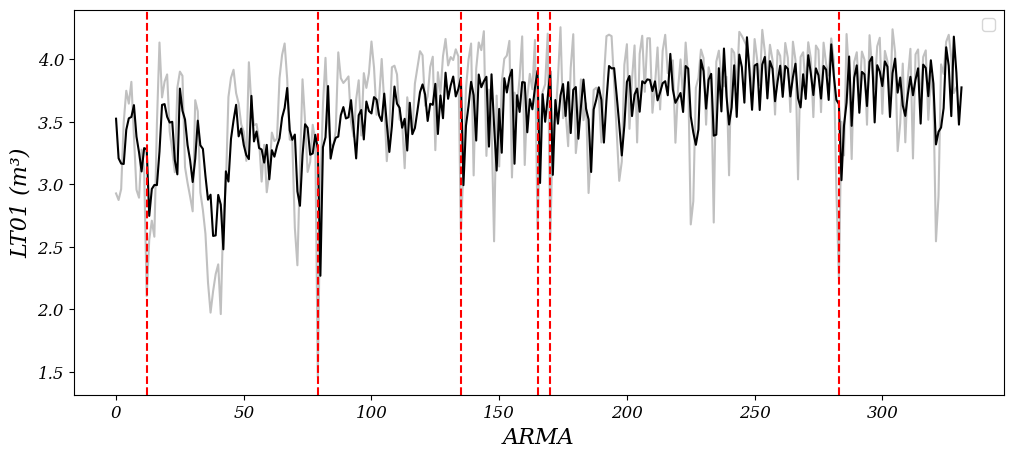

In [105]:
# Código anterior...


# Detecção de anomalias nos resíduos
residuals = res_tst.resid
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
threshold = 3 * std_residuals  # Definindo um limite de 3 desvios padrões

anomalies = np.where(np.abs(residuals) > threshold)[0]

print("Índices das anomalias encontradas:", anomalies)

# Plot dos dados observados
plt.figure(figsize=(12, 5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(arma_tst), 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel('ARMA', fontsize = 16)
plt.legend(['Observedo', f"ARMA {p1,q1}"])

# Destacar anomalias
anomaly_indices = anomalies
anomaly_values = endog[anomaly_indices]

# Adicionar linhas verticais para cada valor de anomalia

for anomaly_idx in anomaly_indices:
    plt.axvline(x=anomaly_idx, color='red', linestyle='--')
plt.savefig(f"{pv}-anomalia-SARIMAX.pdf", dpi=600)
plt.legend()
plt.show()


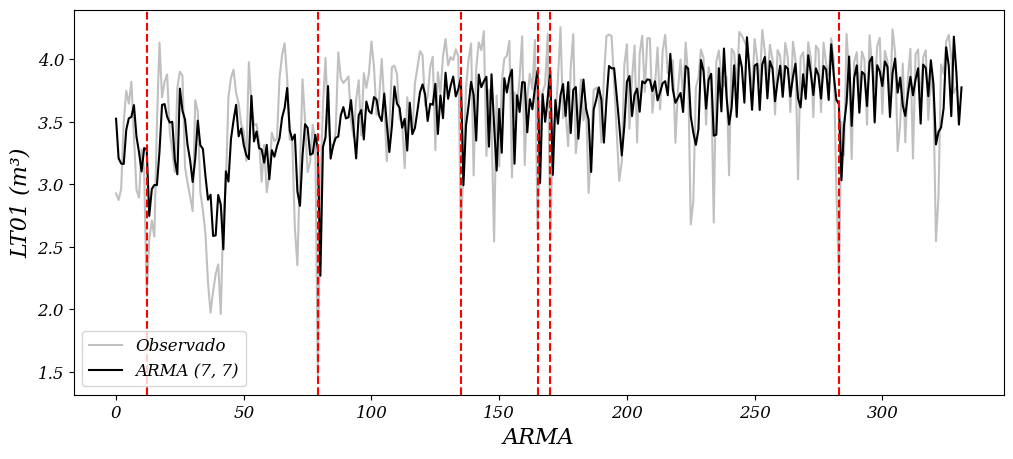

In [106]:

# Código anterior...

# Configuração inicial do gráfico
fig, ax = plt.subplots(figsize=(12, 5))
plt.ylabel(rt, fontsize=16)
plt.xlabel('ARMA', fontsize=16)
plt.legend(['Observado', f"ARMA {p1,q1}"])

# Função de atualização para a animação
def update(frame):
    plt.cla()
    plt.plot(list(endog_tst), 'silver')
    plt.plot(list(arma_tst), 'black')
    plt.ylabel(rt, fontsize=16)
    plt.xlabel('ARMA', fontsize=16)
    plt.legend(['Observado', f"ARMA {p1,q1}"])
    
    # Atualizar a posição das linhas verticais para destacar as anomalias
    for anomaly_idx in anomaly_indices[:frame+1]:
        plt.axvline(x=anomaly_idx, color='red', linestyle='--')
    
    
    

# Criação da animação
ani = animation.FuncAnimation(fig, update, frames=len(anomaly_indices), interval=200)

# Salvar a animação em um arquivo GIF
animation_file = 'arma_animacao_detecao_anomalias.gif'
ani.save(animation_file, writer='pillow')

# Exibir a animação
plt.show()


In [107]:

lj_arma_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_arma_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_arma_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_arma_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## ARIMA

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (7, 1, 7) sMAPE Error: 2.482 Train
ARIMA (7, 1, 7) sMAPE Error: 2.378 Validation
ARIMA (7, 1, 7) sMAPE Error: 3.577 Test
ARIMA (7, 1, 7) sMAPE Error: 2.527
ARIMA (7, 1, 7) MAE Error: 0.164 Train
ARIMA (7, 1, 7) MAE Error: 0.164 Validation
ARIMA (7, 1, 7) MAE Error: 0.248 Test
ARIMA (7, 1, 7) MAE Error: 0.168
ARIMA (7, 1, 7) RRMSE Error: 0.062 Train
ARIMA (7, 1, 7) RRMSE Error: 0.059 Validation
ARIMA (7, 1, 7) RRMSE Error: 0.084 Test
ARIMA (7, 1, 7) RRMSE Error: 0.062


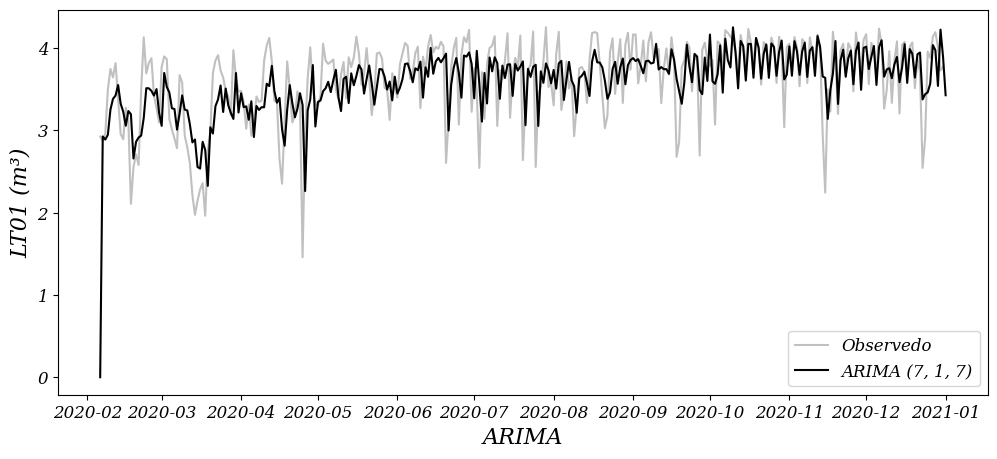

In [108]:

model_trn = ARIMA(endog_trn,
                        order=(p1,d1,q1))
res_trn = model_trn.fit()

model_vld = ARIMA(endog_vld,
                        order=(p1,d1,q1))
res_vld = model_vld.fit()

model_tst = ARIMA(endog_tst,
                        order=(p1,d1,q1))
res_tst = model_tst.fit()

model_df = ARIMA(endog,
                        order=(p1,d1,q1))
res_df = model_df.fit()

arima_trn = res_trn.predict(start = -len(trn), end = len(trn)+0)
arima_vld = res_vld.predict(start = -len(vld), end = len(vld)+0)
arima_tst = res_tst.predict(start = -len(tst), end = len(tst)+0)
arima = res_df.predict(start = -len(df), end = len(df)+0)

### Erros ARIMA



smape_ARIMA_trn = smape(endog_trn, arima_trn[0+1:])
smape_ARIMA_vld = smape(endog_vld, arima_vld[0+1:])
smape_ARIMA_tst = smape(endog_tst, arima_tst[0+1:])
ARIMA_smape = smape(endog, arima[0+1:])

mae_ARIMA_trn = mean_absolute_error(endog_trn, arima_trn[0+1:])
mae_ARIMA_vld = mean_absolute_error(endog_vld, arima_vld[0+1:])
mae_ARIMA_tst = mean_absolute_error(endog_tst, arima_tst[0+1:])
ARIMA_mae = mean_absolute_error(endog, arima[0+1:])

rrmse_ARIMA_trn = rrmse(endog_trn, arima_trn[0+1:])
rrmse_ARIMA_vld = rrmse(endog_vld, arima_vld[0+1:])
rrmse_ARIMA_tst = rrmse(endog_tst, arima_tst[0+1:])
ARIMA_rrmse = rrmse(endog, arima[0+1:])

print(f"ARIMA {p1,d1,q1} sMAPE Error: {smape_ARIMA_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} sMAPE Error: {smape_ARIMA_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} sMAPE Error: {smape_ARIMA_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} sMAPE Error: {ARIMA_smape:2.3f}")

print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} MAE Error: {ARIMA_mae:2.3f}")

print(f"ARIMA {p1,d1,q1} RRMSE Error: {rrmse_ARIMA_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} RRMSE Error: {rrmse_ARIMA_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} RRMSE Error: {rrmse_ARIMA_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} RRMSE Error: {ARIMA_rrmse:2.3f}")


# ### Plotagem das previsão

# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arima_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel('ARIMA', fontsize = 16)
plt.legend(['Observedo', f"ARIMA {p1,d1,q1}"])
plt.savefig(f"ARIMA.pdf", dpi=600)
plt.show()


### 1 dia à frente

In [109]:


arima_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
arima_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
arima_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
arima = res_df.predict(start = -len(df), end = len(df)+pv)

### Erros ARIMA



smape_ARIMA_trn = smape(endog_trn, arima_trn[pv+1:])
smape_ARIMA_vld = smape(endog_vld, arima_vld[pv+1:])
smape_ARIMA_tst = smape(endog_tst, arima_tst[pv+1:])
ARIMA_smape = smape(endog, arima[pv+1:])

mae_ARIMA_trn = mean_absolute_error(endog_trn, arima_trn[pv+1:])
mae_ARIMA_vld = mean_absolute_error(endog_vld, arima_vld[pv+1:])
mae_ARIMA_tst = mean_absolute_error(endog_tst, arima_tst[pv+1:])
ARIMA_mae = mean_absolute_error(endog, arima[pv+1:])

rrmse_ARIMA_trn = rrmse(endog_trn, arima_trn[pv+1:])
rrmse_ARIMA_vld = rrmse(endog_vld, arima_vld[pv+1:])
rrmse_ARIMA_tst = rrmse(endog_tst, arima_tst[pv+1:])
ARIMA_rrmse = rrmse(endog, arima[pv+1:])

print(f"ARIMA {p1,d1,q1} sMAPE Error: {smape_ARIMA_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} sMAPE Error: {smape_ARIMA_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} sMAPE Error: {smape_ARIMA_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} sMAPE Error: {ARIMA_smape:2.3f}")

print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} MAE Error: {ARIMA_mae:2.3f}")

print(f"ARIMA {p1,d1,q1} RRMSE Error: {rrmse_ARIMA_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} RRMSE Error: {rrmse_ARIMA_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} RRMSE Error: {rrmse_ARIMA_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} RRMSE Error: {ARIMA_rrmse:2.3f}")


# ### Plotagem das previsão

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(arima_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel('ARIMA', fontsize = 16)
# plt.legend(['Observedo', f"ARIMA {p1,d1,q1}"])
# plt.savefig(f"{pv}-ARIMA.pdf", dpi=600)
# plt.show()


ARIMA (7, 1, 7) sMAPE Error: 4.496 Train
ARIMA (7, 1, 7) sMAPE Error: 3.995 Validation
ARIMA (7, 1, 7) sMAPE Error: 4.982 Test
ARIMA (7, 1, 7) sMAPE Error: 4.461
ARIMA (7, 1, 7) MAE Error: 0.302 Train
ARIMA (7, 1, 7) MAE Error: 0.280 Validation
ARIMA (7, 1, 7) MAE Error: 0.346 Test
ARIMA (7, 1, 7) MAE Error: 0.303
ARIMA (7, 1, 7) RRMSE Error: 0.116 Train
ARIMA (7, 1, 7) RRMSE Error: 0.098 Validation
ARIMA (7, 1, 7) RRMSE Error: 0.122 Test
ARIMA (7, 1, 7) RRMSE Error: 0.115


### 7 dias à frente

In [110]:

arima_7_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_7)
arima_7_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_7)
arima_7_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_7)
arima_7 = res_df.predict(start = -len(df), end = len(df)+pv_7)

### Erros ARIMA_7



smape_ARIMA_7_trn = smape(endog_trn, arima_7_trn[pv_7+1:])
smape_ARIMA_7_vld = smape(endog_vld, arima_7_vld[pv_7+1:])
smape_ARIMA_7_tst = smape(endog_tst, arima_7_tst[pv_7+1:])
ARIMA_7_smape = smape(endog, arima_7[pv_7+1:])

mae_ARIMA_7_trn = mean_absolute_error(endog_trn, arima_7_trn[pv_7+1:])
mae_ARIMA_7_vld = mean_absolute_error(endog_vld, arima_7_vld[pv_7+1:])
mae_ARIMA_7_tst = mean_absolute_error(endog_tst, arima_7_tst[pv_7+1:])
ARIMA_7_mae = mean_absolute_error(endog, arima_7[pv_7+1:])

rrmse_ARIMA_7_trn = rrmse(endog_trn, arima_7_trn[pv_7+1:])
rrmse_ARIMA_7_vld = rrmse(endog_vld, arima_7_vld[pv_7+1:])
rrmse_ARIMA_7_tst = rrmse(endog_tst, arima_7_tst[pv_7+1:])
ARIMA_7_rrmse = rrmse(endog, arima_7[pv_7+1:])

print(f"ARIMA {p1,d1,q1} sMAPE Error: {smape_ARIMA_7_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} sMAPE Error: {smape_ARIMA_7_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} sMAPE Error: {smape_ARIMA_7_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} sMAPE Error: {ARIMA_7_smape:2.3f}")

print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_7_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_7_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_7_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} MAE Error: {ARIMA_7_mae:2.3f}")

print(f"ARIMA {p1,d1,q1} RRMSE Error: {rrmse_ARIMA_7_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} RRMSE Error: {rrmse_ARIMA_7_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} RRMSE Error: {rrmse_ARIMA_7_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} RRMSE Error: {ARIMA_7_rrmse:2.3f}")


# ### Plotagem das previsão

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(arima_7_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel('ARIMA', fontsize = 16)
# plt.legend(['Observedo', f"ARIMA {p1,d1,q1}"])
# plt.savefig(f"{pv_7}-ARIMA_7.pdf", dpi=600)
# plt.show()


ARIMA (7, 1, 7) sMAPE Error: 5.129 Train
ARIMA (7, 1, 7) sMAPE Error: 4.169 Validation
ARIMA (7, 1, 7) sMAPE Error: 5.702 Test
ARIMA (7, 1, 7) sMAPE Error: 4.635
ARIMA (7, 1, 7) MAE Error: 0.342 Train
ARIMA (7, 1, 7) MAE Error: 0.292 Validation
ARIMA (7, 1, 7) MAE Error: 0.393 Test
ARIMA (7, 1, 7) MAE Error: 0.314
ARIMA (7, 1, 7) RRMSE Error: 0.132 Train
ARIMA (7, 1, 7) RRMSE Error: 0.108 Validation
ARIMA (7, 1, 7) RRMSE Error: 0.139 Test
ARIMA (7, 1, 7) RRMSE Error: 0.119


### 14 dias à frente

In [111]:

arima_14_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_14)
arima_14_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_14)
arima_14_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_14)
arima_14 = res_df.predict(start = -len(df), end = len(df)+pv_14)

### Erros ARIMA_14



smape_ARIMA_14_trn = smape(endog_trn, arima_14_trn[pv_14+1:])
smape_ARIMA_14_vld = smape(endog_vld, arima_14_vld[pv_14+1:])
smape_ARIMA_14_tst = smape(endog_tst, arima_14_tst[pv_14+1:])
ARIMA_14_smape = smape(endog, arima_14[pv_14+1:])

mae_ARIMA_14_trn = mean_absolute_error(endog_trn, arima_14_trn[pv_14+1:])
mae_ARIMA_14_vld = mean_absolute_error(endog_vld, arima_14_vld[pv_14+1:])
mae_ARIMA_14_tst = mean_absolute_error(endog_tst, arima_14_tst[pv_14+1:])
ARIMA_14_mae = mean_absolute_error(endog, arima_14[pv_14+1:])

rrmse_ARIMA_14_trn = rrmse(endog_trn, arima_14_trn[pv_14+1:])
rrmse_ARIMA_14_vld = rrmse(endog_vld, arima_14_vld[pv_14+1:])
rrmse_ARIMA_14_tst = rrmse(endog_tst, arima_14_tst[pv_14+1:])
ARIMA_14_rrmse = rrmse(endog, arima_14[pv_14+1:])

print(f"ARIMA {p1,d1,q1} sMAPE Error: {smape_ARIMA_14_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} sMAPE Error: {smape_ARIMA_14_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} sMAPE Error: {smape_ARIMA_14_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} sMAPE Error: {ARIMA_14_smape:2.3f}")

print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_14_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_14_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_14_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} MAE Error: {ARIMA_14_mae:2.3f}")

print(f"ARIMA {p1,d1,q1} RRMSE Error: {rrmse_ARIMA_14_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} RRMSE Error: {rrmse_ARIMA_14_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} RRMSE Error: {rrmse_ARIMA_14_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} RRMSE Error: {ARIMA_14_rrmse:2.3f}")


# ### Plotagem das previsão

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(arima_14_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel('ARIMA', fontsize = 16)
# plt.legend(['Observedo', f"ARIMA {p1,d1,q1}"])
# plt.savefig(f"{pv_14}-ARIMA_14.pdf", dpi=600)
# plt.show()


ARIMA (7, 1, 7) sMAPE Error: 5.282 Train
ARIMA (7, 1, 7) sMAPE Error: 4.223 Validation
ARIMA (7, 1, 7) sMAPE Error: 4.975 Test
ARIMA (7, 1, 7) sMAPE Error: 4.720
ARIMA (7, 1, 7) MAE Error: 0.353 Train
ARIMA (7, 1, 7) MAE Error: 0.295 Validation
ARIMA (7, 1, 7) MAE Error: 0.338 Test
ARIMA (7, 1, 7) MAE Error: 0.318
ARIMA (7, 1, 7) RRMSE Error: 0.137 Train
ARIMA (7, 1, 7) RRMSE Error: 0.109 Validation
ARIMA (7, 1, 7) RRMSE Error: 0.127 Test
ARIMA (7, 1, 7) RRMSE Error: 0.122


### 30 dias à frente 

In [112]:

arima_30_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_30)
arima_30_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_30)
arima_30_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_30)
arima_30 = res_df.predict(start = -len(df), end = len(df)+pv_30)

### Erros ARIMA_30



smape_ARIMA_30_trn = smape(endog_trn, arima_30_trn[pv_30+1:])
smape_ARIMA_30_vld = smape(endog_vld, arima_30_vld[pv_30+1:])
smape_ARIMA_30_tst = smape(endog_tst, arima_30_tst[pv_30+1:])
ARIMA_30_smape = smape(endog, arima_30[pv_30+1:])

mae_ARIMA_30_trn = mean_absolute_error(endog_trn, arima_30_trn[pv_30+1:])
mae_ARIMA_30_vld = mean_absolute_error(endog_vld, arima_30_vld[pv_30+1:])
mae_ARIMA_30_tst = mean_absolute_error(endog_tst, arima_30_tst[pv_30+1:])
ARIMA_30_mae = mean_absolute_error(endog, arima_30[pv_30+1:])

rrmse_ARIMA_30_trn = rrmse(endog_trn, arima_30_trn[pv_30+1:])
rrmse_ARIMA_30_vld = rrmse(endog_vld, arima_30_vld[pv_30+1:])
rrmse_ARIMA_30_tst = rrmse(endog_tst, arima_30_tst[pv_30+1:])
ARIMA_30_rrmse = rrmse(endog, arima_30[pv_30+1:])

print(f"ARIMA {p1,d1,q1} sMAPE Error: {smape_ARIMA_30_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} sMAPE Error: {smape_ARIMA_30_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} sMAPE Error: {smape_ARIMA_30_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} sMAPE Error: {ARIMA_30_smape:2.3f}")

print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_30_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_30_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} MAE Error: {mae_ARIMA_30_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} MAE Error: {ARIMA_30_mae:2.3f}")

print(f"ARIMA {p1,d1,q1} RRMSE Error: {rrmse_ARIMA_30_trn:2.3f} Train")
print(f"ARIMA {p1,d1,q1} RRMSE Error: {rrmse_ARIMA_30_vld:2.3f} Validation")
print(f"ARIMA {p1,d1,q1} RRMSE Error: {rrmse_ARIMA_30_tst:2.3f} Test")
print(f"ARIMA {p1,d1,q1} RRMSE Error: {ARIMA_30_rrmse:2.3f}")


# ### Plotagem das previsão

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(arima_30_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel('ARIMA', fontsize = 16)
# plt.legend(['Observedo', f"ARIMA {p1,d1,q1}"])
# plt.savefig(f"{pv_30}-ARIMA_30.pdf", dpi=600)
# plt.show()


ARIMA (7, 1, 7) sMAPE Error: 5.902 Train
ARIMA (7, 1, 7) sMAPE Error: 4.874 Validation
ARIMA (7, 1, 7) sMAPE Error: 5.634 Test
ARIMA (7, 1, 7) sMAPE Error: 5.526
ARIMA (7, 1, 7) MAE Error: 0.395 Train
ARIMA (7, 1, 7) MAE Error: 0.343 Validation
ARIMA (7, 1, 7) MAE Error: 0.390 Test
ARIMA (7, 1, 7) MAE Error: 0.375
ARIMA (7, 1, 7) RRMSE Error: 0.151 Train
ARIMA (7, 1, 7) RRMSE Error: 0.119 Validation
ARIMA (7, 1, 7) RRMSE Error: 0.140 Test
ARIMA (7, 1, 7) RRMSE Error: 0.140


Índices das anomalias encontradas: [  0  79 135 170 283]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


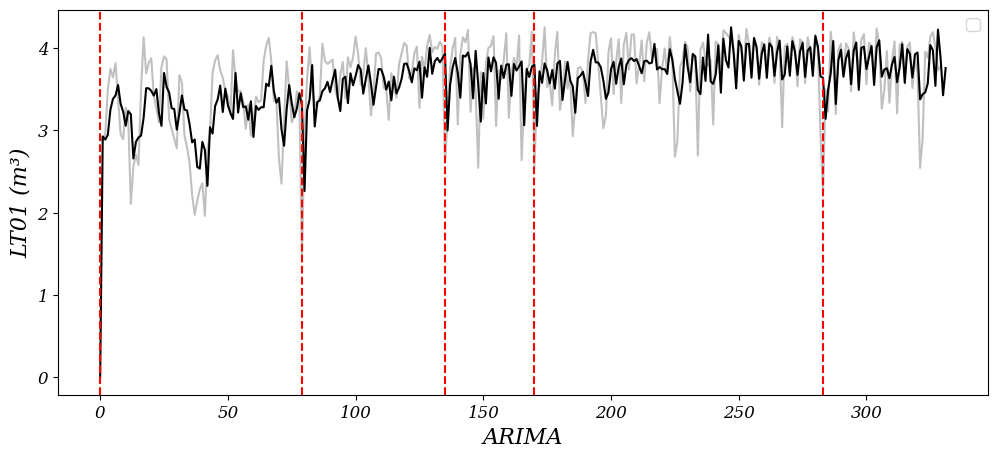

In [113]:
# Código anterior...


# Detecção de anomalias nos resíduos
residuals = res_tst.resid
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
threshold = 3 * std_residuals  # Definindo um limite de 3 desvios padrões

anomalies = np.where(np.abs(residuals) > threshold)[0]

print("Índices das anomalias encontradas:", anomalies)

# Plot dos dados observados
plt.figure(figsize=(12, 5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(arima_tst), 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel('ARIMA', fontsize = 16)
plt.legend(['Observedo', f"ARIMA {p1,d1,q1}"])

# Destacar anomalias
anomaly_indices = anomalies
anomaly_values = endog[anomaly_indices]


# Adicionar linhas verticais para cada valor de anomalia

for anomaly_idx in anomaly_indices:
    plt.axvline(x=anomaly_idx, color='red', linestyle='--')
plt.savefig(f"{pv}-anomalia-SARIMAX.pdf", dpi=600)
plt.legend()
plt.show()


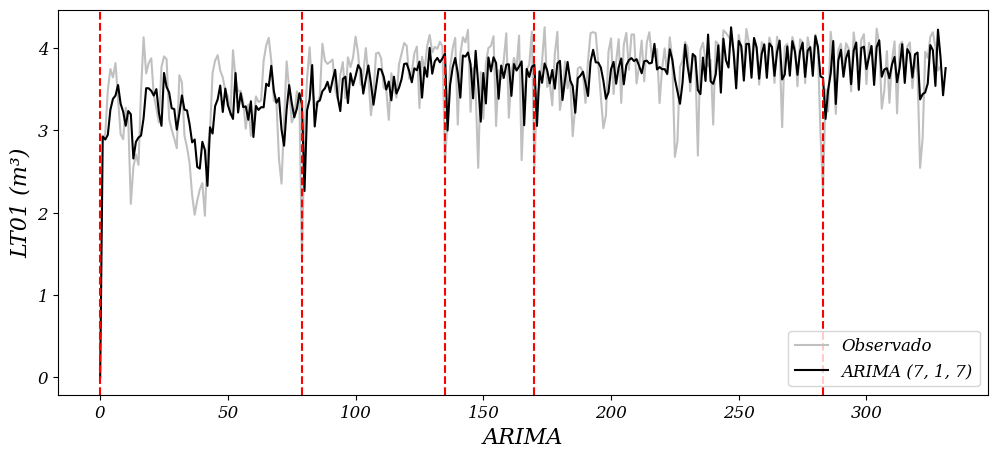

In [114]:

# Código anterior...

# Configuração inicial do gráfico
fig, ax = plt.subplots(figsize=(12, 5))
plt.ylabel(rt, fontsize=16)
plt.xlabel('ARIMA', fontsize=16)
plt.legend(['Observado', f"ARIMA {p1,d1,q1}"])

# Função de atualização para a animação
def update(frame):
    plt.cla()
    plt.plot(list(endog_tst), 'silver')
    plt.plot(list(arima_tst), 'black')
    plt.ylabel(rt, fontsize=16)
    plt.xlabel('ARIMA', fontsize=16)
    plt.legend(['Observado', f"ARIMA {p1,d1,q1}"])
    
    # Atualizar a posição das linhas verticais para destacar as anomalias
    for anomaly_idx in anomaly_indices[:frame+1]:
        plt.axvline(x=anomaly_idx, color='red', linestyle='--')
    
    
    

# Criação da animação
ani = animation.FuncAnimation(fig, update, frames=len(anomaly_indices), interval=200)

# Salvar a animação em um arquivo GIF
animation_file = 'animacao_detecao_anomalias.gif'
ani.save(animation_file, writer='pillow')

# Exibir a animação
plt.show()


In [115]:

lj_arima_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_arima_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_arima_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_arima_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## SARIMA


c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 3.372 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 2.924 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 4.172 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 3.555
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.225 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.208 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.292 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.241
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.084 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.085 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.103 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.088


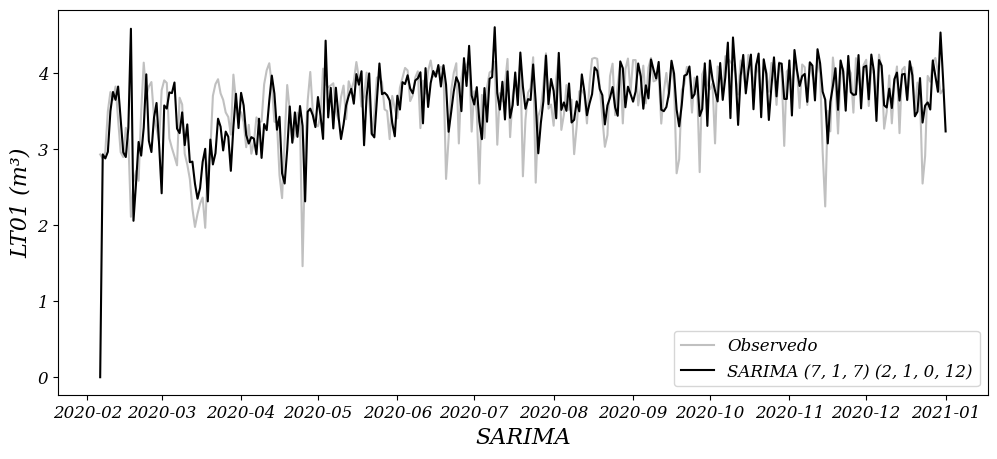

In [116]:
model_trn = sr(endog_trn,order=(p1,d1,q1),
                 seasonal_order = (P1,D1,Q1,M1),
                 simple_differencing=False)
res_trn = model_trn.fit(dis=False)

model_vld = sr(endog_vld,order=(p1,d1,q1),
                 seasonal_order = (P1,D1,Q1,M1),
                 simple_differencing=False)
res_vld = model_vld.fit(dis=False)

model_tst = sr(endog_tst,order=(p1,d1,q1),
                 seasonal_order = (P1,D1,Q1,M1),
                 simple_differencing=False)
res_tst = model_tst.fit(dis=False)

model_df = sr(endog,order=(p1,d1,q1),
                seasonal_order = (P1,D1,Q1,M1),
                simple_differencing=False)
res_df = model_df.fit(dis=False)

### Erro SARIMA

sarima_trn = res_trn.predict(start = -len(trn), end = len(trn)+0)
sarima_vld = res_vld.predict(start = -len(vld), end = len(vld)+0)
sarima_tst = res_tst.predict(start = -len(tst), end = len(tst)+0)
sarima = res_df.predict(start = -len(df), end = len(df)+0)

smape_SARIMA_trn = smape(endog_trn, sarima_trn[0+1:])
smape_SARIMA_vld = smape(endog_vld, sarima_vld[0+1:])
smape_SARIMA_tst = smape(endog_tst, sarima_tst[0+1:])
SARIMA_smape = smape(endog, sarima[0+1:])

mae_SARIMA_trn = mean_absolute_error(endog_trn, sarima_trn[0+1:])
mae_SARIMA_vld = mean_absolute_error(endog_vld, sarima_vld[0+1:])
mae_SARIMA_tst = mean_absolute_error(endog_tst, sarima_tst[0+1:])
SARIMA_mae = mean_absolute_error(endog, sarima[0+1:])

rrmse_SARIMA_trn = rrmse(endog_trn, sarima_trn[0+1:])
rrmse_SARIMA_vld = rrmse(endog_vld, sarima_vld[0+1:])
rrmse_SARIMA_tst = rrmse(endog_tst, sarima_tst[0+1:])
SARIMA_rrmse = rrmse(endog, sarima[0+1:])

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {smape_SARIMA_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {smape_SARIMA_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {smape_SARIMA_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {SARIMA_smape:2.3f}")

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {SARIMA_mae:2.3f}")

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {rrmse_SARIMA_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {rrmse_SARIMA_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {rrmse_SARIMA_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {SARIMA_rrmse:2.3f}")

### Plotagem da previsão

# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(sarima_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel('SARIMA', fontsize = 16)
plt.legend(['Observedo', f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1}"])
plt.savefig(f"SARIMA.pdf", dpi=600)
plt.show()


### 1 dia à frente

In [117]:


### Erro SARIMA

sarima_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv)
sarima_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv)
sarima_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv)
sarima = res_df.predict(start = -len(df), end = len(df)+pv)

smape_SARIMA_trn = smape(endog_trn, sarima_trn[pv+1:])
smape_SARIMA_vld = smape(endog_vld, sarima_vld[pv+1:])
smape_SARIMA_tst = smape(endog_tst, sarima_tst[pv+1:])
SARIMA_smape = smape(endog, sarima[pv+1:])

mae_SARIMA_trn = mean_absolute_error(endog_trn, sarima_trn[pv+1:])
mae_SARIMA_vld = mean_absolute_error(endog_vld, sarima_vld[pv+1:])
mae_SARIMA_tst = mean_absolute_error(endog_tst, sarima_tst[pv+1:])
SARIMA_mae = mean_absolute_error(endog, sarima[pv+1:])

rrmse_SARIMA_trn = rrmse(endog_trn, sarima_trn[pv+1:])
rrmse_SARIMA_vld = rrmse(endog_vld, sarima_vld[pv+1:])
rrmse_SARIMA_tst = rrmse(endog_tst, sarima_tst[pv+1:])
SARIMA_rrmse = rrmse(endog, sarima[pv+1:])

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {smape_SARIMA_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {smape_SARIMA_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {smape_SARIMA_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {SARIMA_smape:2.3f}")

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {SARIMA_mae:2.3f}")

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {rrmse_SARIMA_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {rrmse_SARIMA_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {rrmse_SARIMA_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {SARIMA_rrmse:2.3f}")

### Plotagem da previsão

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(sarima_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel('SARIMA', fontsize = 16)
# plt.legend(['Observedo', f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1}"])
# plt.savefig(f"{pv}-SARIMA.pdf", dpi=600)
# plt.show()


SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 5.088 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 4.705 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 5.681 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 5.118
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.342 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.333 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.398 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.350
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.129 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.118 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.138 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.126


### 7 dias à frente

In [118]:

### Erro SARIMA_7

sarima_7_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_7)
sarima_7_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_7)
sarima_7_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_7)
sarima_7 = res_df.predict(start = -len(df), end = len(df)+pv_7)

smape_SARIMA_7_trn = smape(endog_trn, sarima_7_trn[pv_7+1:])
smape_SARIMA_7_vld = smape(endog_vld, sarima_7_vld[pv_7+1:])
smape_SARIMA_7_tst = smape(endog_tst, sarima_7_tst[pv_7+1:])
SARIMA_7_smape = smape(endog, sarima_7[pv_7+1:])

mae_SARIMA_7_trn = mean_absolute_error(endog_trn, sarima_7_trn[pv_7+1:])
mae_SARIMA_7_vld = mean_absolute_error(endog_vld, sarima_7_vld[pv_7+1:])
mae_SARIMA_7_tst = mean_absolute_error(endog_tst, sarima_7_tst[pv_7+1:])
SARIMA_7_mae = mean_absolute_error(endog, sarima_7[pv_7+1:])

rrmse_SARIMA_7_trn = rrmse(endog_trn, sarima_7_trn[pv_7+1:])
rrmse_SARIMA_7_vld = rrmse(endog_vld, sarima_7_vld[pv_7+1:])
rrmse_SARIMA_7_tst = rrmse(endog_tst, sarima_7_tst[pv_7+1:])
SARIMA_7_rrmse = rrmse(endog, sarima_7[pv_7+1:])

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {smape_SARIMA_7_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {smape_SARIMA_7_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {smape_SARIMA_7_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {SARIMA_7_smape:2.3f}")

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_7_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_7_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_7_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {SARIMA_7_mae:2.3f}")

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {rrmse_SARIMA_7_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {rrmse_SARIMA_7_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {rrmse_SARIMA_7_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {SARIMA_7_rrmse:2.3f}")

### Plotagem da previsão

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(sarima_7_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel('SARIMA', fontsize = 16)
# plt.legend(['Observedo', f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1}"])
# plt.savefig(f"{pv_7}-SARIMA_7.pdf", dpi=600)
# plt.show()


SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 5.379 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 4.584 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 6.283 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 5.657
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.360 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.324 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.437 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.386
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.139 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.123 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.150 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.143


### 14 dias à frente

In [119]:

### Erro SARIMA_14

sarima_14_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_14)
sarima_14_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_14)
sarima_14_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_14)
sarima_14 = res_df.predict(start = -len(df), end = len(df)+pv_14)

smape_SARIMA_14_trn = smape(endog_trn, sarima_14_trn[pv_14+1:])
smape_SARIMA_14_vld = smape(endog_vld, sarima_14_vld[pv_14+1:])
smape_SARIMA_14_tst = smape(endog_tst, sarima_14_tst[pv_14+1:])
SARIMA_14_smape = smape(endog, sarima_14[pv_14+1:])

mae_SARIMA_14_trn = mean_absolute_error(endog_trn, sarima_14_trn[pv_14+1:])
mae_SARIMA_14_vld = mean_absolute_error(endog_vld, sarima_14_vld[pv_14+1:])
mae_SARIMA_14_tst = mean_absolute_error(endog_tst, sarima_14_tst[pv_14+1:])
SARIMA_14_mae = mean_absolute_error(endog, sarima_14[pv_14+1:])

rrmse_SARIMA_14_trn = rrmse(endog_trn, sarima_14_trn[pv_14+1:])
rrmse_SARIMA_14_vld = rrmse(endog_vld, sarima_14_vld[pv_14+1:])
rrmse_SARIMA_14_tst = rrmse(endog_tst, sarima_14_tst[pv_14+1:])
SARIMA_14_rrmse = rrmse(endog, sarima_14[pv_14+1:])

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {smape_SARIMA_14_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {smape_SARIMA_14_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {smape_SARIMA_14_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {SARIMA_14_smape:2.3f}")

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_14_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_14_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_14_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {SARIMA_14_mae:2.3f}")

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {rrmse_SARIMA_14_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {rrmse_SARIMA_14_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {rrmse_SARIMA_14_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {SARIMA_14_rrmse:2.3f}")

### Plotagem da previsão

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(sarima_14_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel('SARIMA', fontsize = 16)
# plt.legend(['Observedo', f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1}"])
# plt.savefig(f"{pv_14}-SARIMA_14.pdf", dpi=600)
# plt.show()


SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 5.485 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 4.485 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 5.335 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 5.387
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.366 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.315 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.364 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.365
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.140 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.113 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.137 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.139


### 30 dias à frente

In [120]:

### Erro SARIMA_30

sarima_30_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_30)
sarima_30_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_30)
sarima_30_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_30)
sarima_30 = res_df.predict(start = -len(df), end = len(df)+pv_30)

smape_SARIMA_30_trn = smape(endog_trn, sarima_30_trn[pv_30+1:])
smape_SARIMA_30_vld = smape(endog_vld, sarima_30_vld[pv_30+1:])
smape_SARIMA_30_tst = smape(endog_tst, sarima_30_tst[pv_30+1:])
SARIMA_30_smape = smape(endog, sarima_30[pv_30+1:])

mae_SARIMA_30_trn = mean_absolute_error(endog_trn, sarima_30_trn[pv_30+1:])
mae_SARIMA_30_vld = mean_absolute_error(endog_vld, sarima_30_vld[pv_30+1:])
mae_SARIMA_30_tst = mean_absolute_error(endog_tst, sarima_30_tst[pv_30+1:])
SARIMA_30_mae = mean_absolute_error(endog, sarima_30[pv_30+1:])

rrmse_SARIMA_30_trn = rrmse(endog_trn, sarima_30_trn[pv_30+1:])
rrmse_SARIMA_30_vld = rrmse(endog_vld, sarima_30_vld[pv_30+1:])
rrmse_SARIMA_30_tst = rrmse(endog_tst, sarima_30_tst[pv_30+1:])
SARIMA_30_rrmse = rrmse(endog, sarima_30[pv_30+1:])

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {smape_SARIMA_30_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {smape_SARIMA_30_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {smape_SARIMA_30_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Error: {SARIMA_30_smape:2.3f}")

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_30_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_30_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {mae_SARIMA_30_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} MAE Error: {SARIMA_30_mae:2.3f}")

print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {rrmse_SARIMA_30_trn:2.3f} Train")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {rrmse_SARIMA_30_vld:2.3f} Validation")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {rrmse_SARIMA_30_tst:2.3f} Test")
print(f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Error: {SARIMA_30_rrmse:2.3f}")

### Plotagem da previsão

# # test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(sarima_30_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel('SARIMA', fontsize = 16)
# plt.legend(['Observedo', f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1}"])
# plt.savefig(f"{pv_30}-SARIMA_30.pdf", dpi=600)
# plt.show()


SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 6.058 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 4.806 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 6.169 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) sMAPE Error: 5.938
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.405 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.337 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.431 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) MAE Error: 0.404
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.154 Train
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.115 Validation
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.157 Test
SARIMA (7, 1, 7) (2, 1, 0, 12) RRMSE Error: 0.150


Índices das anomalias encontradas: [  0  12  79 283]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


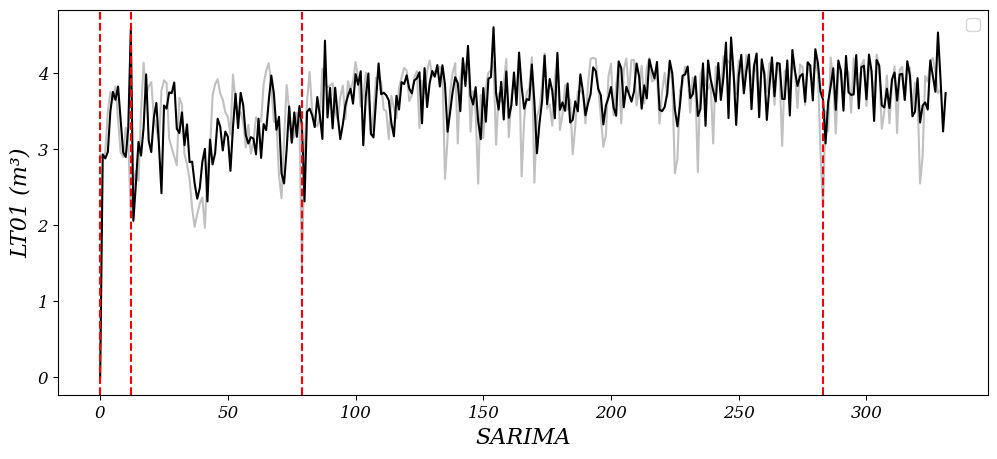

In [121]:
# Código anterior...


# Detecção de anomalias nos resíduos
residuals = res_tst.resid
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
threshold = 3 * std_residuals  # Definindo um limite de 3 desvios padrões

anomalies = np.where(np.abs(residuals) > threshold)[0]

print("Índices das anomalias encontradas:", anomalies)

# Plot dos dados observados
plt.figure(figsize=(12, 5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(sarima_tst), 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel('SARIMA', fontsize = 16)
plt.legend(['Observedo', f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1}"])

# Destacar anomalias
anomaly_indices = anomalies
anomaly_values = endog[anomaly_indices]


# Adicionar linhas verticais para cada valor de anomalia

for anomaly_idx in anomaly_indices:
    plt.axvline(x=anomaly_idx, color='red', linestyle='--')
plt.savefig(f"{pv}-anomalia-SARIMAX.pdf", dpi=500)
plt.legend()
plt.show()


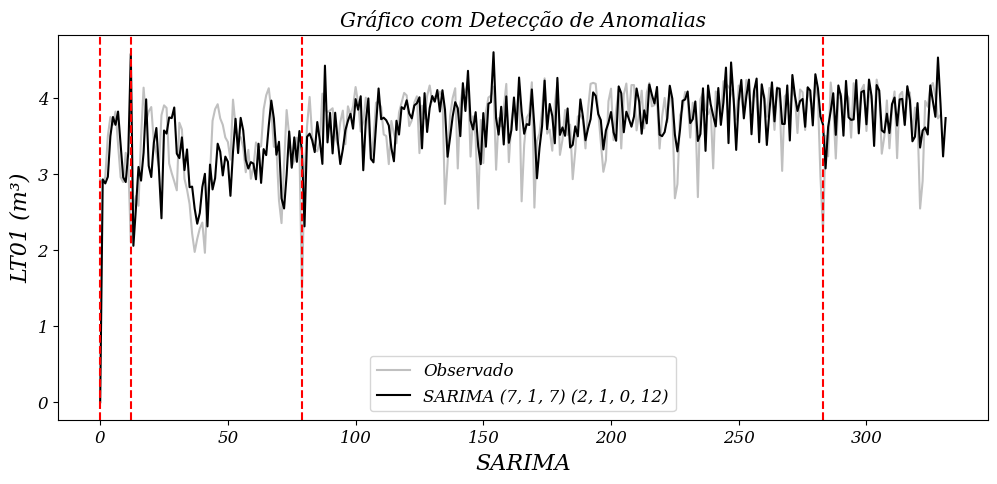

In [122]:

# Código anterior...

# Configuração inicial do gráfico
fig, ax = plt.subplots(figsize=(12, 5))
plt.ylabel(rt, fontsize=16)
plt.xlabel('SARIMA', fontsize=16)
plt.legend(['Observado', f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1}"])

# Função de atualização para a animação
def update(frame):
    plt.cla()
    plt.plot(list(endog_tst), 'silver')
    plt.plot(list(sarima_tst), 'black')
    plt.ylabel(rt, fontsize=16)
    plt.xlabel('SARIMA', fontsize=16)
    plt.legend(['Observado', f"SARIMA {p1,d1,q1} {P1,D1,Q1,M1}"])
    
    # Atualizar a posição das linhas verticais para destacar as anomalias
    for anomaly_idx in anomaly_indices[:frame+1]:
        plt.axvline(x=anomaly_idx, color='red', linestyle='--')
    
    plt.title('Gráfico com Detecção de Anomalias')
    # plt.grid(True)

# Criação da animação
ani = animation.FuncAnimation(fig, update, frames=len(anomaly_indices), interval=200)

# Salvar a animação em um arquivo GIF
animation_file = 'sarima_animacao_detecao_anomalias.gif'
ani.save(animation_file, writer='pillow')

# Exibir a animação
plt.show()


ADF Statistic: -4.2678842574054805
p-value: 0.000504668295643225


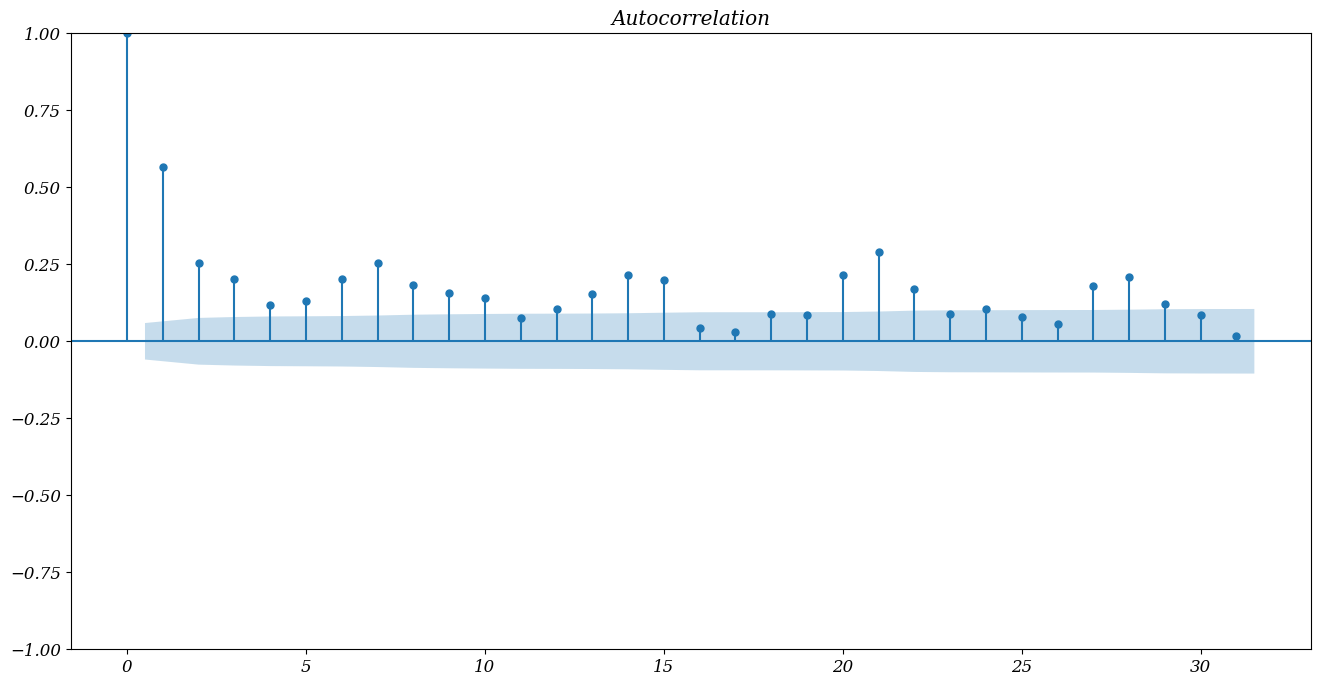

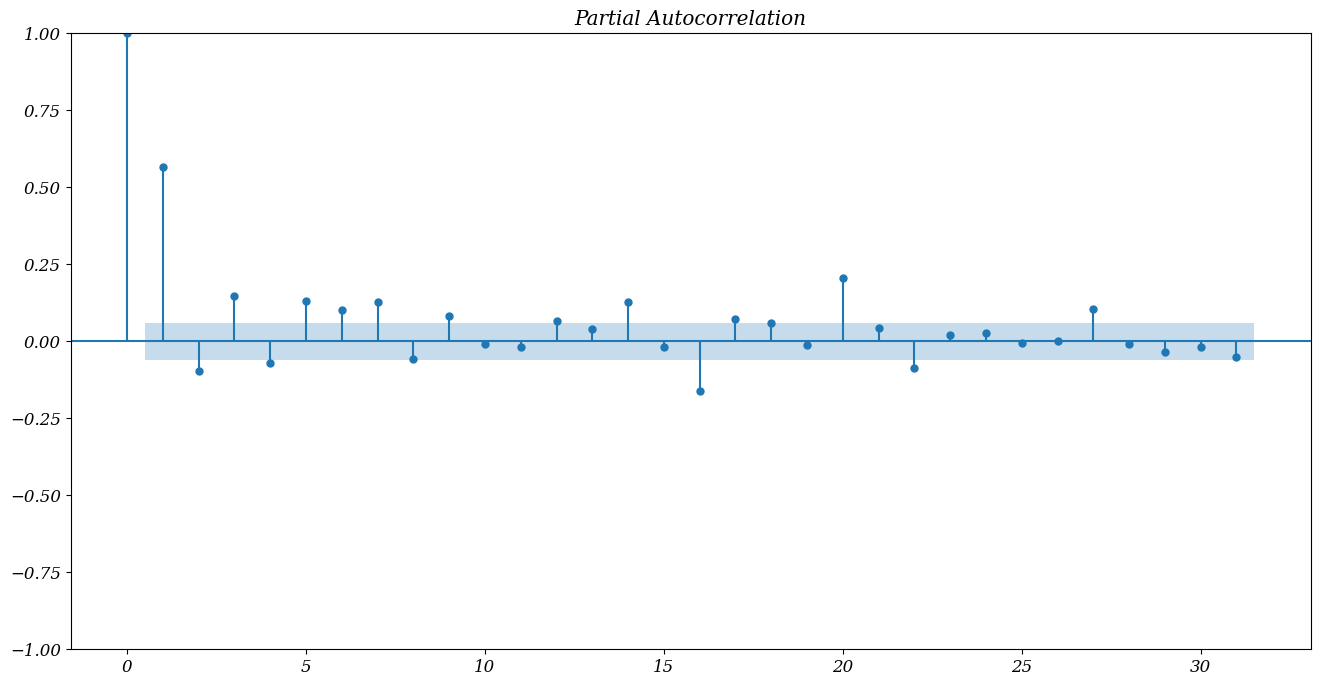

In [123]:

ad_fuller_result = adfuller(endog[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


plot_acf(endog[1:]);
plt.savefig(f"acf.pdf", dpi=600)
plot_pacf(endog[1:]);
plt.savefig(f"pacf.pdf", dpi=600)


In [124]:

lj_sarima_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_sarima_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_sarima_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_sarima_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## ARIMAX

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMAX (7, 1, 7)  sMAPE Error: 4.032 Train
ARIMAX (7, 1, 7)  sMAPE Error: 3.644 Validation
ARIMAX (7, 1, 7)  sMAPE Error: 5.330 Test
ARIMAX (7, 1, 7)  sMAPE Error: 4.305
ARIMAX (7, 1, 7)  MAE Error: 0.265 Train
ARIMAX (7, 1, 7)  MAE Error: 0.252 Validation
ARIMAX (7, 1, 7)  MAE Error: 0.367 Test
ARIMAX (7, 1, 7)  MAE Error: 0.289
ARIMAX (7, 1, 7)  RRMSE Error: 0.105 Train
ARIMAX (7, 1, 7)  RRMSE Error: 0.096 Validation
ARIMAX (7, 1, 7)  RRMSE Error: 0.134 Test
ARIMAX (7, 1, 7)  RRMSE Error: 0.113


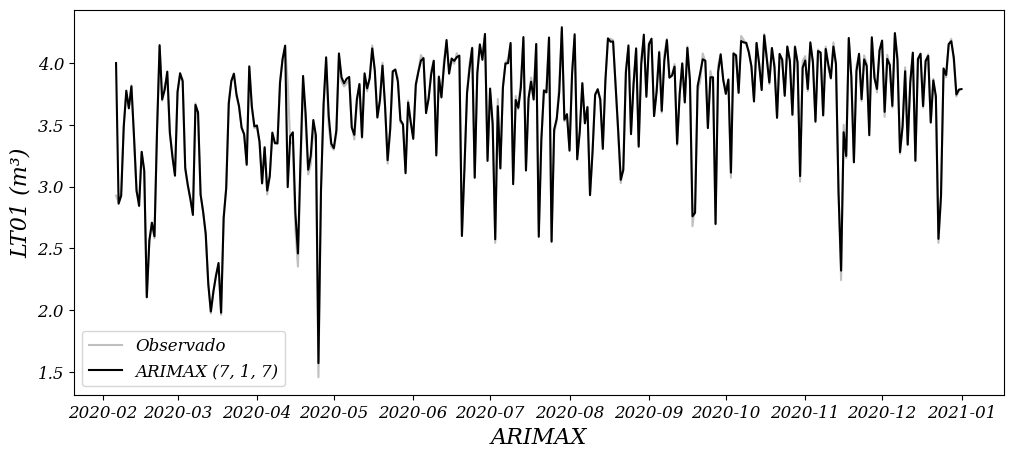

In [125]:

best_model_tst = ARIMA(endog_tst, 
                     exog_tst, 
                     order=(p1,d1,q1))


res_tst = best_model_tst.fit()
### Validação



best_model_vld = ARIMA(endog_vld, 
                     exog_vld, 
                     order=(p1,d1,q1))

res_vld = best_model_vld.fit()

### Treino

best_model_trn = ARIMA(endog_trn, 
                     exog_trn, 
                     order=(p1,d1,q1))

res_trn = best_model_trn.fit()

### ARIMAX

best_model = ARIMA(endog, 
                     exog, 
                     order=(p1,d1,q1))

res = best_model.fit()



### Prevendo ARIMAX

arimax_trn = res_trn.predict(start = -len(trn), end = len(trn)+0, exog = exog_trn[len(trn)-0-1:])
arimax_vld = res_vld.predict(start = -len(vld), end = len(vld)+0, exog = exog_vld[len(vld)-0-1:])
arimax_tst = res_tst.predict(start = -len(tst), end = len(tst)+0, exog = exog_tst[len(tst)-0-1:])
arimax = res.predict(start = -len(df), end = len(df)+0, exog = exog[len(df)-0-1:])


### Erros ARIMAX

smape_arimax_trn = smape(endog_trn, arimax_trn[0+1:])
smape_arimax_vld = smape(endog_vld, arimax_vld[0+1:])
smape_arimax_tst = smape(endog_tst, arimax_tst[0+1:])
arimax_smape = smape(endog, arimax[0+1:])

mae_arimax_trn = mean_absolute_error(endog_trn, arimax_trn[0+1:])
mae_arimax_vld = mean_absolute_error(endog_vld, arimax_vld[0+1:])
mae_arimax_tst = mean_absolute_error(endog_tst, arimax_tst[0+1:])
arimax_mae = mean_absolute_error(endog, arimax[0+1:])

rrmse_arimax_trn = rrmse(endog_trn, arimax_trn[0+1:])
rrmse_arimax_vld = rrmse(endog_vld, arimax_vld[0+1:])
rrmse_arimax_tst = rrmse(endog_tst, arimax_tst[0+1:])
arimax_rrmse = rrmse(endog, arimax[0+1:])

print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {smape_arimax_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {smape_arimax_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {smape_arimax_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {arimax_smape:2.3f}")

print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {arimax_mae:2.3f}")

print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {rrmse_arimax_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {rrmse_arimax_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {rrmse_arimax_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {arimax_rrmse:2.3f}")

# # Visualiza previsão
# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arimax_tst, 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel(f'ARIMAX', fontsize = 16)
plt.legend(['Observado', f"ARIMAX {p1,d1,q1}"])
plt.savefig(f"ARIMAX.pdf", dpi=600)
plt.show()

### 1 dia à frente

In [126]:


### Prevendo ARIMAX

arimax_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv, exog = exog_trn[len(trn)-pv-1:])
arimax_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv, exog = exog_vld[len(vld)-pv-1:])
arimax_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv, exog = exog_tst[len(tst)-pv-1:])
arimax = res.predict(start = -len(df), end = len(df)+pv, exog = exog[len(df)-pv-1:])


### Erros ARIMAX

smape_arimax_trn = smape(endog_trn, arimax_trn[pv+1:])
smape_arimax_vld = smape(endog_vld, arimax_vld[pv+1:])
smape_arimax_tst = smape(endog_tst, arimax_tst[pv+1:])
arimax_smape = smape(endog, arimax[pv+1:])

mae_arimax_trn = mean_absolute_error(endog_trn, arimax_trn[pv+1:])
mae_arimax_vld = mean_absolute_error(endog_vld, arimax_vld[pv+1:])
mae_arimax_tst = mean_absolute_error(endog_tst, arimax_tst[pv+1:])
arimax_mae = mean_absolute_error(endog, arimax[pv+1:])

rrmse_arimax_trn = rrmse(endog_trn, arimax_trn[pv+1:])
rrmse_arimax_vld = rrmse(endog_vld, arimax_vld[pv+1:])
rrmse_arimax_tst = rrmse(endog_tst, arimax_tst[pv+1:])
arimax_rrmse = rrmse(endog, arimax[pv+1:])

print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {smape_arimax_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {smape_arimax_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {smape_arimax_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {arimax_smape:2.3f}")

print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {arimax_mae:2.3f}")

print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {rrmse_arimax_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {rrmse_arimax_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {rrmse_arimax_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {arimax_rrmse:2.3f}")

# # Visualiza previsão
# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(arimax_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel(f'ARIMAX', fontsize = 16)
# plt.legend(['Observado', f"ARIMAX {p1,d1,q1}"])
# plt.savefig(f"{pv}-ARIMAX.pdf", dpi=600)
# plt.show()

ARIMAX (7, 1, 7)  sMAPE Error: 5.746 Train
ARIMAX (7, 1, 7)  sMAPE Error: 5.071 Validation
ARIMAX (7, 1, 7)  sMAPE Error: 6.690 Test
ARIMAX (7, 1, 7)  sMAPE Error: 5.865
ARIMAX (7, 1, 7)  MAE Error: 0.378 Train
ARIMAX (7, 1, 7)  MAE Error: 0.353 Validation
ARIMAX (7, 1, 7)  MAE Error: 0.461 Test
ARIMAX (7, 1, 7)  MAE Error: 0.394
ARIMAX (7, 1, 7)  RRMSE Error: 0.146 Train
ARIMAX (7, 1, 7)  RRMSE Error: 0.128 Validation
ARIMAX (7, 1, 7)  RRMSE Error: 0.162 Test
ARIMAX (7, 1, 7)  RRMSE Error: 0.147


### 7 dias à frente

In [127]:

### Prevendo ARIMAX_7

arimax_7_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_7, exog = exog_trn[len(trn)-pv_7-1:])
arimax_7_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_7, exog = exog_vld[len(vld)-pv_7-1:])
arimax_7_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_7, exog = exog_tst[len(tst)-pv_7-1:])
arimax_7 = res.predict(start = -len(df), end = len(df)+pv_7, exog = exog[len(df)-pv_7-1:])


### Erros ARIMAX_7

smape_arimax_7_trn = smape(endog_trn, arimax_7_trn[pv_7+1:])
smape_arimax_7_vld = smape(endog_vld, arimax_7_vld[pv_7+1:])
smape_arimax_7_tst = smape(endog_tst, arimax_7_tst[pv_7+1:])
arimax_7_smape = smape(endog, arimax_7[pv_7+1:])

mae_arimax_7_trn = mean_absolute_error(endog_trn, arimax_7_trn[pv_7+1:])
mae_arimax_7_vld = mean_absolute_error(endog_vld, arimax_7_vld[pv_7+1:])
mae_arimax_7_tst = mean_absolute_error(endog_tst, arimax_7_tst[pv_7+1:])
arimax_7_mae = mean_absolute_error(endog, arimax_7[pv_7+1:])

rrmse_arimax_7_trn = rrmse(endog_trn, arimax_7_trn[pv_7+1:])
rrmse_arimax_7_vld = rrmse(endog_vld, arimax_7_vld[pv_7+1:])
rrmse_arimax_7_tst = rrmse(endog_tst, arimax_7_tst[pv_7+1:])
arimax_7_rrmse = rrmse(endog, arimax_7[pv_7+1:])

print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {smape_arimax_7_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {smape_arimax_7_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {smape_arimax_7_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {arimax_7_smape:2.3f}")

print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_7_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_7_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_7_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {arimax_7_mae:2.3f}")

print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {rrmse_arimax_7_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {rrmse_arimax_7_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {rrmse_arimax_7_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {arimax_7_rrmse:2.3f}")

# # Visualiza previsão
# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(arimax_7_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel(f'ARIMAX', fontsize = 16)
# plt.legend(['Observado', f"ARIMAX {p1,d1,q1}"])
# plt.savefig(f"{pv_7}-ARIMAX_7.pdf", dpi=600)
# plt.show()

ARIMAX (7, 1, 7)  sMAPE Error: 5.760 Train
ARIMAX (7, 1, 7)  sMAPE Error: 4.574 Validation
ARIMAX (7, 1, 7)  sMAPE Error: 7.026 Test
ARIMAX (7, 1, 7)  sMAPE Error: 5.991
ARIMAX (7, 1, 7)  MAE Error: 0.379 Train
ARIMAX (7, 1, 7)  MAE Error: 0.318 Validation
ARIMAX (7, 1, 7)  MAE Error: 0.480 Test
ARIMAX (7, 1, 7)  MAE Error: 0.402
ARIMAX (7, 1, 7)  RRMSE Error: 0.150 Train
ARIMAX (7, 1, 7)  RRMSE Error: 0.118 Validation
ARIMAX (7, 1, 7)  RRMSE Error: 0.174 Test
ARIMAX (7, 1, 7)  RRMSE Error: 0.154


### 14 dias à frente

In [128]:

### Prevendo ARIMAX_14

arimax_14_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_14, exog = exog_trn[len(trn)-pv_14-1:])
arimax_14_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_14, exog = exog_vld[len(vld)-pv_14-1:])
arimax_14_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_14, exog = exog_tst[len(tst)-pv_14-1:])
arimax_14 = res.predict(start = -len(df), end = len(df)+pv_14, exog = exog[len(df)-pv_14-1:])


### Erros ARIMAX_14

smape_arimax_14_trn = smape(endog_trn, arimax_14_trn[pv_14+1:])
smape_arimax_14_vld = smape(endog_vld, arimax_14_vld[pv_14+1:])
smape_arimax_14_tst = smape(endog_tst, arimax_14_tst[pv_14+1:])
arimax_14_smape = smape(endog, arimax_14[pv_14+1:])

mae_arimax_14_trn = mean_absolute_error(endog_trn, arimax_14_trn[pv_14+1:])
mae_arimax_14_vld = mean_absolute_error(endog_vld, arimax_14_vld[pv_14+1:])
mae_arimax_14_tst = mean_absolute_error(endog_tst, arimax_14_tst[pv_14+1:])
arimax_14_mae = mean_absolute_error(endog, arimax_14[pv_14+1:])

rrmse_arimax_14_trn = rrmse(endog_trn, arimax_14_trn[pv_14+1:])
rrmse_arimax_14_vld = rrmse(endog_vld, arimax_14_vld[pv_14+1:])
rrmse_arimax_14_tst = rrmse(endog_tst, arimax_14_tst[pv_14+1:])
arimax_14_rrmse = rrmse(endog, arimax_14[pv_14+1:])

print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {smape_arimax_14_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {smape_arimax_14_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {smape_arimax_14_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {arimax_14_smape:2.3f}")

print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_14_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_14_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_14_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {arimax_14_mae:2.3f}")

print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {rrmse_arimax_14_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {rrmse_arimax_14_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {rrmse_arimax_14_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {arimax_14_rrmse:2.3f}")

# # Visualiza previsão
# # test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(arimax_14_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel(f'ARIMAX', fontsize = 16)
# plt.legend(['Observado', f"ARIMAX {p1,d1,q1}"])
# plt.savefig(f"{pv_14}-ARIMAX_14.pdf", dpi=600)
# plt.show()

ARIMAX (7, 1, 7)  sMAPE Error: 6.095 Train
ARIMAX (7, 1, 7)  sMAPE Error: 4.428 Validation
ARIMAX (7, 1, 7)  sMAPE Error: 5.733 Test
ARIMAX (7, 1, 7)  sMAPE Error: 5.858
ARIMAX (7, 1, 7)  MAE Error: 0.401 Train
ARIMAX (7, 1, 7)  MAE Error: 0.308 Validation
ARIMAX (7, 1, 7)  MAE Error: 0.384 Test
ARIMAX (7, 1, 7)  MAE Error: 0.389
ARIMAX (7, 1, 7)  RRMSE Error: 0.157 Train
ARIMAX (7, 1, 7)  RRMSE Error: 0.120 Validation
ARIMAX (7, 1, 7)  RRMSE Error: 0.155 Test
ARIMAX (7, 1, 7)  RRMSE Error: 0.152


### 30 dias à frente

In [129]:

### Prevendo ARIMAX_30

arimax_30_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_30, exog = exog_trn[len(trn)-pv_30-1:])
arimax_30_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_30, exog = exog_vld[len(vld)-pv_30-1:])
arimax_30_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_30, exog = exog_tst[len(tst)-pv_30-1:])
arimax_30 = res.predict(start = -len(df), end = len(df)+pv_30, exog = exog[len(df)-pv_30-1:])


### Erros ARIMAX_30

smape_arimax_30_trn = smape(endog_trn, arimax_30_trn[pv_30+1:])
smape_arimax_30_vld = smape(endog_vld, arimax_30_vld[pv_30+1:])
smape_arimax_30_tst = smape(endog_tst, arimax_30_tst[pv_30+1:])
arimax_30_smape = smape(endog, arimax_30[pv_30+1:])

mae_arimax_30_trn = mean_absolute_error(endog_trn, arimax_30_trn[pv_30+1:])
mae_arimax_30_vld = mean_absolute_error(endog_vld, arimax_30_vld[pv_30+1:])
mae_arimax_30_tst = mean_absolute_error(endog_tst, arimax_30_tst[pv_30+1:])
arimax_30_mae = mean_absolute_error(endog, arimax_30[pv_30+1:])

rrmse_arimax_30_trn = rrmse(endog_trn, arimax_30_trn[pv_30+1:])
rrmse_arimax_30_vld = rrmse(endog_vld, arimax_30_vld[pv_30+1:])
rrmse_arimax_30_tst = rrmse(endog_tst, arimax_30_tst[pv_30+1:])
arimax_30_rrmse = rrmse(endog, arimax_30[pv_30+1:])

print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {smape_arimax_30_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {smape_arimax_30_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {smape_arimax_30_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1}  sMAPE Error: {arimax_30_smape:2.3f}")

print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_30_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_30_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {mae_arimax_30_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1}  MAE Error: {arimax_30_mae:2.3f}")

print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {rrmse_arimax_30_trn:2.3f} Train")
print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {rrmse_arimax_30_vld:2.3f} Validation")
print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {rrmse_arimax_30_tst:2.3f} Test")
print(f"ARIMAX {p1,d1,q1}  RRMSE Error: {arimax_30_rrmse:2.3f}")

# # Visualiza previsão
# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(arimax_30_tst, 'black')
# plt.ylabel(rt, fontsize = 16)
# plt.xlabel(f'ARIMAX', fontsize = 16)
# plt.legend(['Observado', f"ARIMAX {p1,d1,q1}"])
# plt.savefig(f"{pv_30}-ARIMAX_30.pdf", dpi=600)
# plt.show()

ARIMAX (7, 1, 7)  sMAPE Error: 6.605 Train
ARIMAX (7, 1, 7)  sMAPE Error: 4.313 Validation
ARIMAX (7, 1, 7)  sMAPE Error: 6.717 Test
ARIMAX (7, 1, 7)  sMAPE Error: 6.627
ARIMAX (7, 1, 7)  MAE Error: 0.434 Train
ARIMAX (7, 1, 7)  MAE Error: 0.301 Validation
ARIMAX (7, 1, 7)  MAE Error: 0.459 Test
ARIMAX (7, 1, 7)  MAE Error: 0.443
ARIMAX (7, 1, 7)  RRMSE Error: 0.170 Train
ARIMAX (7, 1, 7)  RRMSE Error: 0.121 Validation
ARIMAX (7, 1, 7)  RRMSE Error: 0.173 Test
ARIMAX (7, 1, 7)  RRMSE Error: 0.168


Índices das anomalias encontradas: [ 0 67]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


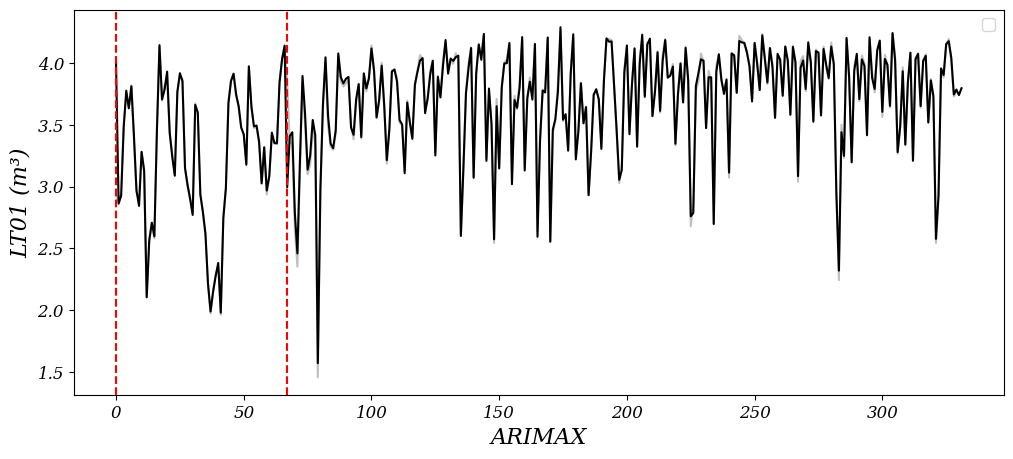

In [130]:
# Código anterior...


# Detecção de anomalias nos resíduos
residuals = res_tst.resid
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
threshold = 3 * std_residuals  # Definindo um limite de 3 desvios padrões

anomalies = np.where(np.abs(residuals) > threshold)[0]

print("Índices das anomalias encontradas:", anomalies)

# Plot dos dados observados
plt.figure(figsize=(12, 5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(arimax_tst), 'black')
plt.ylabel(rt, fontsize = 16)
plt.xlabel(f'ARIMAX', fontsize = 16)
plt.legend(['Observado', f"ARIMAX {p1,d1,q1}"])

# Destacar anomalias
anomaly_indices = anomalies
anomaly_values = endog[anomaly_indices]


# Adicionar linhas verticais para cada valor de anomalia

for anomaly_idx in anomaly_indices:
    plt.axvline(x=anomaly_idx, color='red', linestyle='--')
plt.savefig(f"{pv}-anomalia-SARIMAX.pdf", dpi=500)
plt.legend()
plt.show()


Índices das anomalias encontradas: [ 0 67]


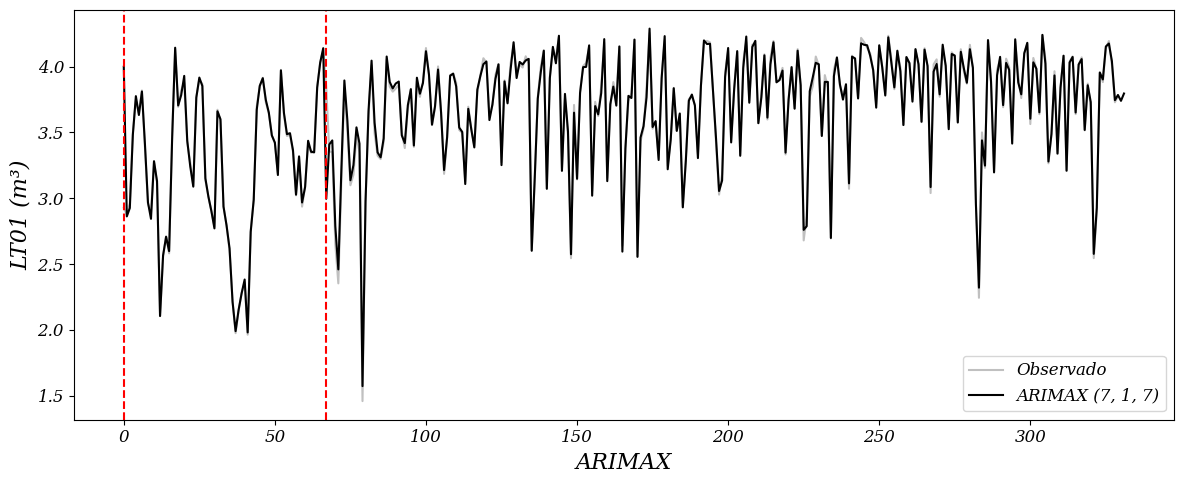

In [131]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from statsmodels.tsa.arima.model import ARIMA

# Detecção de anomalias nos resíduos
residuals = res_tst.resid
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
threshold = 3 * std_residuals  # Definindo um limite de 3 desvios padrões
anomalies = np.where(np.abs(residuals) > threshold)[0]
print("Índices das anomalias encontradas:", anomalies)

# Configuração inicial do gráfico
fig, ax = plt.subplots(figsize=(12, 5))
line_observed, = ax.plot(list(endog_tst), 'silver')
line_arimax, = ax.plot(list(arimax_tst), 'black')
ax.set_ylabel(rt, fontsize=16)
ax.set_xlabel('ARIMAX', fontsize=16)
ax.legend(['Observado', f"ARIMAX {p1,d1,q1}"])

# Função de atualização para a animação
def update(frame):
    plt.cla()
    
    # Plot dos dados observados
    ax.plot(list(endog_tst), 'silver')
    ax.plot(list(arimax_tst), 'black')
    ax.set_ylabel(rt, fontsize=16)
    ax.set_xlabel('ARIMAX', fontsize=16)
    ax.legend(['Observado', f"ARIMAX {p1,d1,q1}"])
    
    # Destacar anomalias
    anomaly_indices = anomalies[:frame+1]
    anomaly_values = endog[anomaly_indices]
    for anomaly_idx in anomaly_indices:
        ax.axvline(x=anomaly_idx, color='red', linestyle='--')
    
    plt.tight_layout()

# Criação da animação
ani = animation.FuncAnimation(fig, update, frames=len(anomalies), interval=1000)

# Salvar a animação em um arquivo GIF
animation_file = 'animacao_arimax_anomalias.gif'
ani.save(animation_file, writer='pillow')

# Exibir a animação
plt.show()


In [132]:

lj_arimax_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_arimax_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_arimax_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_arimax_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## SARIMAX

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\msndo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMAX (7, 1, 7) (2, 1, 0, 12)  sMAPE Erro: 4.019 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  sMAPE Erro: 3.714 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  sMAPE Erro: 5.417 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) sMAPE Erro: 4.391
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.264 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.256 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.372 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) MAE Erro: 0.295
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RRMSE Erro: 0.105 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RRMSE Erro: 0.098 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RRMSE Erro: 0.136 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) RRMSE Erro: 0.115


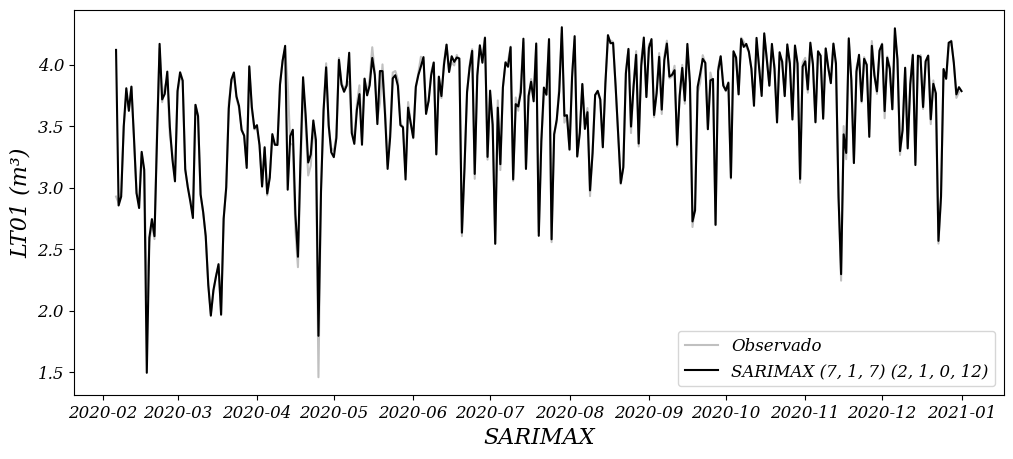

In [133]:

best_model_tst = sr(endog_tst, 
                     exog_tst, 
                     order=(p1,d1,q1), 
                     seasonal_order=(P1,D1,Q1,M1),
                    simple_differencing=False)


res_tst = best_model_tst.fit(dis=False)
### Validação



best_model_vld = sr(endog_vld, 
                     exog_vld, 
                     order=(p1,d1,q1), 
                     seasonal_order=(P1,D1,Q1,M1),
                    simple_differencing=False)

res_vld = best_model_vld.fit(dis=False)

### Treino

best_model_trn = sr(endog_trn, 
                     exog_trn, 
                     order=(p1,d1,q1), 
                     seasonal_order=(P1,D1,Q1,M1),
                    simple_differencing=False)

res_trn = best_model_trn.fit(dis=False)

### DADOS COMPLETO

best_model = sr(endog, 
                     exog, 
                     order=(p1,d1,q1), 
                     seasonal_order=(P1,D1,Q1,M1),
                    simple_differencing=False)

res = best_model.fit(dis=False)

### Prevendo SARIMAX

sarimax_trn = res_trn.predict(start = -len(trn), end = len(trn)+0, exog = exog_trn[len(trn)-0-1:])

sarimax_vld = res_vld.predict(start = -len(vld), end = len(vld)+0, exog = exog_vld[len(vld)-0-1:])

sarimax_tst = res_tst.predict(start = -len(tst), end = len(tst)+0, exog = exog_tst[len(tst)-0-1:])

sarimax = res.predict(start = -len(df), end = len(df)+0, exog = exog[len(df)-0-1:])



### Erros SARIMAX

smape_sarimax_trn = smape(endog_trn, sarimax_trn[0+1:])
smape_sarimax_vld = smape(endog_vld, sarimax_vld[0+1:])
smape_sarimax_tst = smape(endog_tst, sarimax_tst[0+1:])
sarimax_smape = smape(endog, sarimax[0+1:])

mae_sarimax_trn = mean_absolute_error(endog_trn, sarimax_trn[0+1:])
mae_sarimax_vld = mean_absolute_error(endog_vld, sarimax_vld[0+1:])
mae_sarimax_tst = mean_absolute_error(endog_tst, sarimax_tst[0+1:])
sarimax_mae = mean_absolute_error(endog, sarimax[0+1:])

rrmse_sarimax_trn = rrmse(endog_trn, sarimax_trn[0+1:])
rrmse_sarimax_vld = rrmse(endog_vld, sarimax_vld[0+1:])
rrmse_sarimax_tst = rrmse(endog_tst, sarimax_tst[0+1:])
sarimax_rrmse = rrmse(endog, sarimax[0+1:])


print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  sMAPE Erro: {smape_sarimax_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  sMAPE Erro: {smape_sarimax_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  sMAPE Erro: {smape_sarimax_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Erro: {sarimax_smape:2.3f}")

print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} MAE Erro: {sarimax_mae:2.3f}")

print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RRMSE Erro: {rrmse_sarimax_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RRMSE Erro: {rrmse_sarimax_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RRMSE Erro: {rrmse_sarimax_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Erro: {sarimax_rrmse:2.3f}")


# Visualiza previsão

# test
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(sarimax_tst, 'black')
plt.ylabel(rt , fontsize = 16)
plt.xlabel(f'SARIMAX', fontsize = 16)
plt.legend(['Observado',f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
plt.savefig(f"SARIMAX.pdf", dpi=600)
plt.show()

### 1 dia à frente

In [134]:


### Prevendo SARIMAX

sarimax_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv, exog = exog_trn[len(trn)-pv-1:])

sarimax_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv, exog = exog_vld[len(vld)-pv-1:])

sarimax_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv, exog = exog_tst[len(tst)-pv-1:])

sarimax = res.predict(start = -len(df), end = len(df)+pv, exog = exog[len(df)-pv-1:])



### Erros SARIMAX

smape_sarimax_trn = smape(endog_trn, sarimax_trn[pv+1:])
smape_sarimax_vld = smape(endog_vld, sarimax_vld[pv+1:])
smape_sarimax_tst = smape(endog_tst, sarimax_tst[pv+1:])
sarimax_smape = smape(endog, sarimax[pv+1:])

mae_sarimax_trn = mean_absolute_error(endog_trn, sarimax_trn[pv+1:])
mae_sarimax_vld = mean_absolute_error(endog_vld, sarimax_vld[pv+1:])
mae_sarimax_tst = mean_absolute_error(endog_tst, sarimax_tst[pv+1:])
sarimax_mae = mean_absolute_error(endog, sarimax[pv+1:])

rrmse_sarimax_trn = rrmse(endog_trn, sarimax_trn[pv+1:])
rrmse_sarimax_vld = rrmse(endog_vld, sarimax_vld[pv+1:])
rrmse_sarimax_tst = rrmse(endog_tst, sarimax_tst[pv+1:])
sarimax_rrmse = rrmse(endog, sarimax[pv+1:])


print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  sMAPE Erro: {smape_sarimax_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  sMAPE Erro: {smape_sarimax_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  sMAPE Erro: {smape_sarimax_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Erro: {sarimax_smape:2.3f}")

print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} MAE Erro: {sarimax_mae:2.3f}")

print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RRMSE Erro: {rrmse_sarimax_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RRMSE Erro: {rrmse_sarimax_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RRMSE Erro: {rrmse_sarimax_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Erro: {sarimax_rrmse:2.3f}")


# Visualiza previsão

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(sarimax_tst, 'black')
# plt.ylabel(rt , fontsize = 16)
# plt.xlabel(f'SARIMAX', fontsize = 16)
# plt.legend(['Observado',f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
# plt.savefig(f"{pv}-SARIMAX.pdf", dpi=600)
# plt.show()

SARIMAX (7, 1, 7) (2, 1, 0, 12)  sMAPE Erro: 5.734 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  sMAPE Erro: 5.152 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  sMAPE Erro: 6.742 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) sMAPE Erro: 5.960
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.377 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.358 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.464 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) MAE Erro: 0.401
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RRMSE Erro: 0.147 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RRMSE Erro: 0.130 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RRMSE Erro: 0.163 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) RRMSE Erro: 0.150


### 7 dias à frente

In [135]:


### Prevendo SARIMAX_7

sarimax_7_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_7, exog = exog_trn[len(trn)-pv_7-1:])

sarimax_7_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_7, exog = exog_vld[len(vld)-pv_7-1:])

sarimax_7_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_7, exog = exog_tst[len(tst)-pv_7-1:])

sarimax_7 = res.predict(start = -len(df), end = len(df)+pv_7, exog = exog[len(df)-pv_7-1:])



### Erros SARIMAX_7

smape_sarimax_7_trn = smape(endog_trn, sarimax_7_trn[pv_7+1:])
smape_sarimax_7_vld = smape(endog_vld, sarimax_7_vld[pv_7+1:])
smape_sarimax_7_tst = smape(endog_tst, sarimax_7_tst[pv_7+1:])
sarimax_7_smape = smape(endog, sarimax_7[pv_7+1:])

mae_sarimax_7_trn = mean_absolute_error(endog_trn, sarimax_7_trn[pv_7+1:])
mae_sarimax_7_vld = mean_absolute_error(endog_vld, sarimax_7_vld[pv_7+1:])
mae_sarimax_7_tst = mean_absolute_error(endog_tst, sarimax_7_tst[pv_7+1:])
sarimax_7_mae = mean_absolute_error(endog, sarimax_7[pv_7+1:])

rrmse_sarimax_7_trn = rrmse(endog_trn, sarimax_7_trn[pv_7+1:])
rrmse_sarimax_7_vld = rrmse(endog_vld, sarimax_7_vld[pv_7+1:])
rrmse_sarimax_7_tst = rrmse(endog_tst, sarimax_7_tst[pv_7+1:])
sarimax_7_rrmse = rrmse(endog, sarimax_7[pv_7+1:])


print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  sMAPE Erro: {smape_sarimax_7_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  sMAPE Erro: {smape_sarimax_7_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  sMAPE Erro: {smape_sarimax_7_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Erro: {sarimax_7_smape:2.3f}")

print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_7_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_7_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_7_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} MAE Erro: {sarimax_7_mae:2.3f}")

print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RRMSE Erro: {rrmse_sarimax_7_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RRMSE Erro: {rrmse_sarimax_7_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RRMSE Erro: {rrmse_sarimax_7_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Erro: {sarimax_7_rrmse:2.3f}")


# Visualiza previsão

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(sarimax_7_tst, 'black')
# plt.ylabel(rt , fontsize = 16)
# plt.xlabel(f'SARIMAX', fontsize = 16)
# plt.legend(['Observado',f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
# plt.savefig(f"{pv_7}-SARIMAX_7.pdf", dpi=600)
# plt.show()

SARIMAX (7, 1, 7) (2, 1, 0, 12)  sMAPE Erro: 5.763 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  sMAPE Erro: 4.605 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  sMAPE Erro: 7.048 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) sMAPE Erro: 6.040
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.379 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.320 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.481 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) MAE Erro: 0.405
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RRMSE Erro: 0.150 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RRMSE Erro: 0.119 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RRMSE Erro: 0.176 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) RRMSE Erro: 0.155


### 14 dias à frente 

In [136]:


### Prevendo SARIMAX_14

sarimax_14_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_14, exog = exog_trn[len(trn)-pv_14-1:])

sarimax_14_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_14, exog = exog_vld[len(vld)-pv_14-1:])

sarimax_14_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_14, exog = exog_tst[len(tst)-pv_14-1:])

sarimax_14 = res.predict(start = -len(df), end = len(df)+pv_14, exog = exog[len(df)-pv_14-1:])



### Erros SARIMAX_14

smape_sarimax_14_trn = smape(endog_trn, sarimax_14_trn[pv_14+1:])
smape_sarimax_14_vld = smape(endog_vld, sarimax_14_vld[pv_14+1:])
smape_sarimax_14_tst = smape(endog_tst, sarimax_14_tst[pv_14+1:])
sarimax_14_smape = smape(endog, sarimax_14[pv_14+1:])

mae_sarimax_14_trn = mean_absolute_error(endog_trn, sarimax_14_trn[pv_14+1:])
mae_sarimax_14_vld = mean_absolute_error(endog_vld, sarimax_14_vld[pv_14+1:])
mae_sarimax_14_tst = mean_absolute_error(endog_tst, sarimax_14_tst[pv_14+1:])
sarimax_14_mae = mean_absolute_error(endog, sarimax_14[pv_14+1:])

rrmse_sarimax_14_trn = rrmse(endog_trn, sarimax_14_trn[pv_14+1:])
rrmse_sarimax_14_vld = rrmse(endog_vld, sarimax_14_vld[pv_14+1:])
rrmse_sarimax_14_tst = rrmse(endog_tst, sarimax_14_tst[pv_14+1:])
sarimax_14_rrmse = rrmse(endog, sarimax_14[pv_14+1:])


print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  sMAPE Erro: {smape_sarimax_14_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  sMAPE Erro: {smape_sarimax_14_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  sMAPE Erro: {smape_sarimax_14_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Erro: {sarimax_14_smape:2.3f}")

print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_14_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_14_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_14_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} MAE Erro: {sarimax_14_mae:2.3f}")

print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RRMSE Erro: {rrmse_sarimax_14_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RRMSE Erro: {rrmse_sarimax_14_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RRMSE Erro: {rrmse_sarimax_14_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Erro: {sarimax_14_rrmse:2.3f}")


# Visualiza previsão

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(sarimax_14_tst, 'black')
# plt.ylabel(rt , fontsize = 16)
# plt.xlabel(f'SARIMAX', fontsize = 16)
# plt.legend(['Observado',f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
# plt.savefig(f"{pv_14}-SARIMAX_14.pdf", dpi=600)
# plt.show()

SARIMAX (7, 1, 7) (2, 1, 0, 12)  sMAPE Erro: 6.100 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  sMAPE Erro: 4.430 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  sMAPE Erro: 5.720 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) sMAPE Erro: 5.909
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.401 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.308 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.383 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) MAE Erro: 0.393
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RRMSE Erro: 0.156 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RRMSE Erro: 0.120 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RRMSE Erro: 0.154 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) RRMSE Erro: 0.153


### 30 dias à frente

In [137]:


### Prevendo SARIMAX_30

sarimax_30_trn = res_trn.predict(start = -len(trn), end = len(trn)+pv_30, exog = exog_trn[len(trn)-pv_30-1:])

sarimax_30_vld = res_vld.predict(start = -len(vld), end = len(vld)+pv_30, exog = exog_vld[len(vld)-pv_30-1:])

sarimax_30_tst = res_tst.predict(start = -len(tst), end = len(tst)+pv_30, exog = exog_tst[len(tst)-pv_30-1:])

sarimax_30 = res.predict(start = -len(df), end = len(df)+pv_30, exog = exog[len(df)-pv_30-1:])



### Erros SARIMAX_30

smape_sarimax_30_trn = smape(endog_trn, sarimax_30_trn[pv_30+1:])
smape_sarimax_30_vld = smape(endog_vld, sarimax_30_vld[pv_30+1:])
smape_sarimax_30_tst = smape(endog_tst, sarimax_30_tst[pv_30+1:])
sarimax_30_smape = smape(endog, sarimax_30[pv_30+1:])

mae_sarimax_30_trn = mean_absolute_error(endog_trn, sarimax_30_trn[pv_30+1:])
mae_sarimax_30_vld = mean_absolute_error(endog_vld, sarimax_30_vld[pv_30+1:])
mae_sarimax_30_tst = mean_absolute_error(endog_tst, sarimax_30_tst[pv_30+1:])
sarimax_30_mae = mean_absolute_error(endog, sarimax_30[pv_30+1:])

rrmse_sarimax_30_trn = rrmse(endog_trn, sarimax_30_trn[pv_30+1:])
rrmse_sarimax_30_vld = rrmse(endog_vld, sarimax_30_vld[pv_30+1:])
rrmse_sarimax_30_tst = rrmse(endog_tst, sarimax_30_tst[pv_30+1:])
sarimax_30_rrmse = rrmse(endog, sarimax_30[pv_30+1:])


print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  sMAPE Erro: {smape_sarimax_30_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  sMAPE Erro: {smape_sarimax_30_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  sMAPE Erro: {smape_sarimax_30_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} sMAPE Erro: {sarimax_30_smape:2.3f}")

print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_30_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_30_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  MAE Erro: {mae_sarimax_30_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} MAE Erro: {sarimax_30_mae:2.3f}")

print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RRMSE Erro: {rrmse_sarimax_30_trn:2.3f} Train")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RRMSE Erro: {rrmse_sarimax_30_vld:2.3f} Validation")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}  RRMSE Erro: {rrmse_sarimax_30_tst:2.3f} Test")
print(f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1} RRMSE Erro: {sarimax_30_rrmse:2.3f}")


# Visualiza previsão

# test
# plt.figure(figsize = (12,5))
# font = {'family' : 'serif',
#         'style' : 'oblique',
#         'size'   : 12}
# plt.rc('font', **font)
# plt.plot(endog_tst, 'silver')
# plt.plot(sarimax_30_tst, 'black')
# plt.ylabel(rt , fontsize = 16)
# plt.xlabel(f'SARIMAX', fontsize = 16)
# plt.legend(['Observado',f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
# plt.savefig(f"{pv_30}-SARIMAX_30.pdf", dpi=600)
# plt.show()

SARIMAX (7, 1, 7) (2, 1, 0, 12)  sMAPE Erro: 6.617 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  sMAPE Erro: 4.324 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  sMAPE Erro: 6.765 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) sMAPE Erro: 6.669
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.435 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.302 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  MAE Erro: 0.463 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) MAE Erro: 0.446
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RRMSE Erro: 0.171 Train
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RRMSE Erro: 0.122 Validation
SARIMAX (7, 1, 7) (2, 1, 0, 12)  RRMSE Erro: 0.173 Test
SARIMAX (7, 1, 7) (2, 1, 0, 12) RRMSE Erro: 0.170


# Anomalias SARIMAX

Índices das anomalias encontradas: [ 0 12 67 79]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


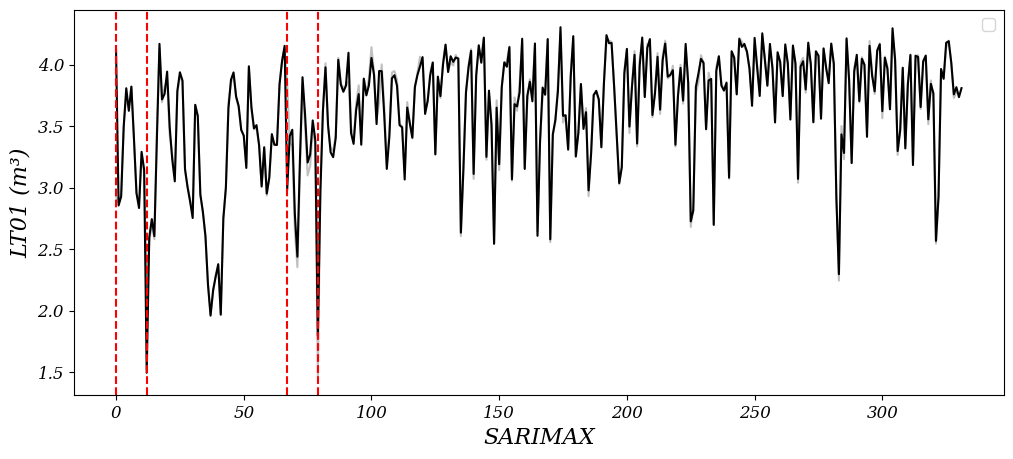

In [138]:
# Código anterior...


# Detecção de anomalias nos resíduos
residuals = res_tst.resid
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
threshold = 3 * std_residuals  # Definindo um limite de 3 desvios padrões

anomalies = np.where(np.abs(residuals) > threshold)[0]

print("Índices das anomalias encontradas:", anomalies)

# Plot dos dados observados
plt.figure(figsize=(12, 5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(sarimax_tst), 'black')
plt.ylabel(rt , fontsize = 16)
plt.xlabel(f'SARIMAX', fontsize = 16)
plt.legend(['Observado',f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])

# Destacar anomalias
anomaly_indices = anomalies
anomaly_values = endog[anomaly_indices]


# Adicionar linhas verticais para cada valor de anomalia

for anomaly_idx in anomaly_indices:
    plt.axvline(x=anomaly_idx, color='red', linestyle='--')
plt.savefig(f"{pv}-anomalia-SARIMAX.pdf", dpi=500)
plt.legend()
plt.show()


Índices das anomalias encontradas: [ 0 12 67 79]


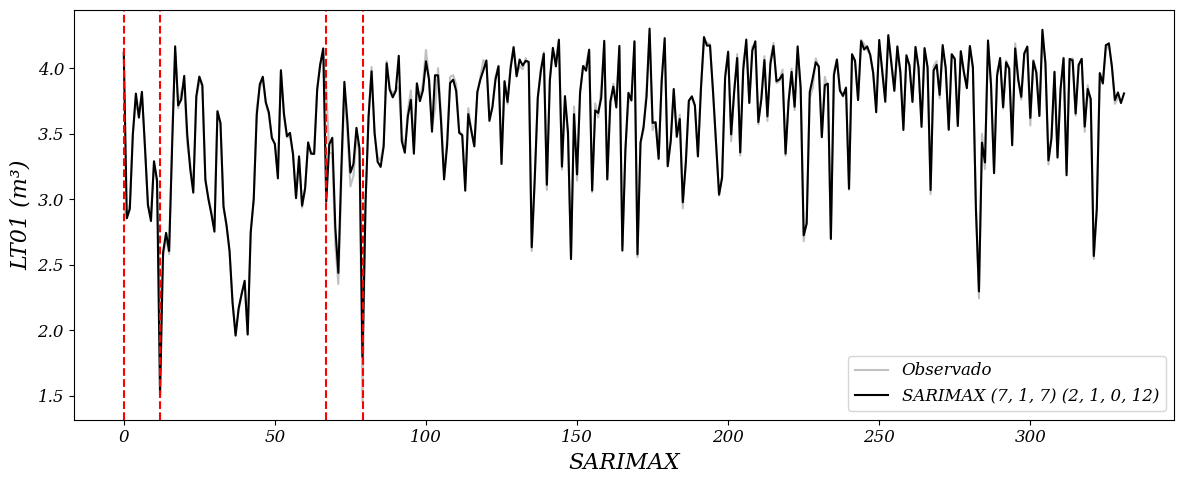

In [139]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Detecção de anomalias nos resíduos
residuals = res_tst.resid
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
threshold = 3 * std_residuals  # Definindo um limite de 3 desvios padrões
anomalies = np.where(np.abs(residuals) > threshold)[0]
print("Índices das anomalias encontradas:", anomalies)

# Configuração inicial do gráfico
fig, ax = plt.subplots(figsize=(12, 5))
line_observed, = ax.plot(list(endog_tst), 'silver')
line_sarimax, = ax.plot(list(sarimax_tst), 'black')
ax.set_ylabel(rt, fontsize=16)
ax.set_xlabel('SARIMAX', fontsize=16)
ax.legend(['Observado', f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}"])

# Função de atualização para a animação
def update(frame):
    plt.cla()
    
    # Plot dos dados observados
    ax.plot(list(endog_tst), 'silver')
    ax.plot(list(sarimax_tst), 'black')
    ax.set_ylabel(rt, fontsize=16)
    ax.set_xlabel('SARIMAX', fontsize=16)
    ax.legend(['Observado', f"SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}"])
    
    # Destacar anomalias
    anomaly_indices = anomalies[:frame+1]
    anomaly_values = endog[anomaly_indices]
    for anomaly_idx in anomaly_indices:
        ax.axvline(x=anomaly_idx, color='red', linestyle='--')
    
    plt.tight_layout()

# Criação da animação
ani = animation.FuncAnimation(fig, update, frames=len(anomalies), interval=1000)

# Salvar a animação em um arquivo GIF
animation_file = 'animacao_sarimax_anomalias.gif'
ani.save(animation_file, writer='pillow')

# Exibir a animação
plt.show()


In [140]:

lj_sarimax_df = sm.stats.acorr_ljungbox(res.resid, lags=lag, return_df=True)
lj_sarimax_trn = sm.stats.acorr_ljungbox(res_trn.resid, lags=lag, return_df=True)
lj_sarimax_tst = sm.stats.acorr_ljungbox(res_tst.resid, lags=lag, return_df=True)
lj_sarimax_vld = sm.stats.acorr_ljungbox(res_vld.resid, lags=lag, return_df=True)

## Comparação dos modelos ARIMA

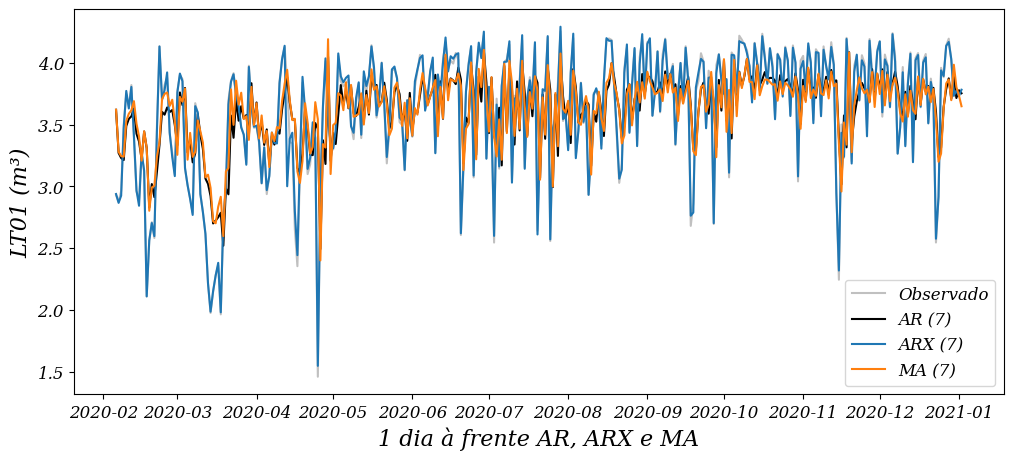

In [141]:
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(ar_tst, 'black')
plt.plot(arx_tst)
plt.plot(ma_tst)


plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl+' AR, ARX e MA', fontsize = 16)
plt.legend(['Observado',f'AR ({p1})',f'ARX ({p1})', f'MA ({q1})'])
plt.savefig(f"{pv}-AR-ARX-MA.pdf", dpi=600)
plt.show()

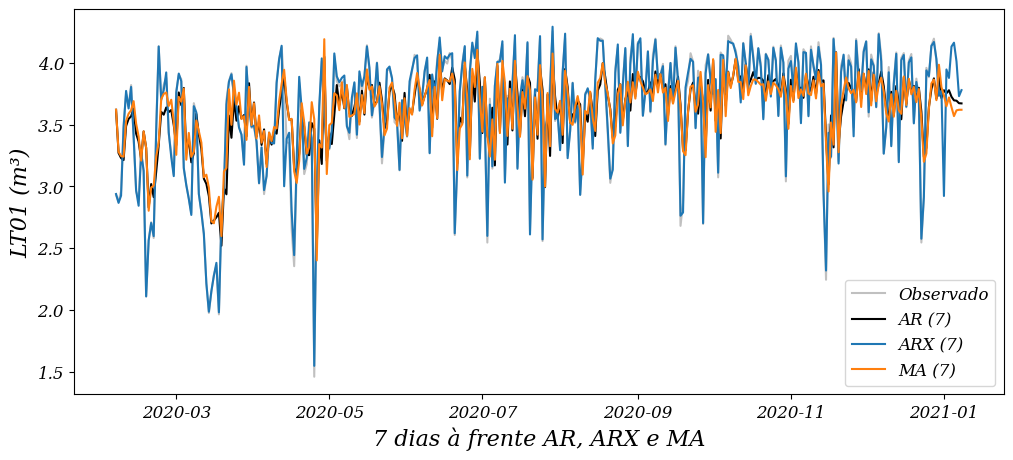

In [142]:
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(ar_7_tst, 'black')
plt.plot(arx_7_tst)
plt.plot(ma_7_tst)


plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl_7+' AR, ARX e MA', fontsize = 16)
plt.legend(['Observado',f'AR ({p1})',f'ARX ({p1})', f'MA ({q1})'])
plt.savefig(f"{pv_7}-AR-ARX-MA-7.pdf", dpi=600)
plt.show()

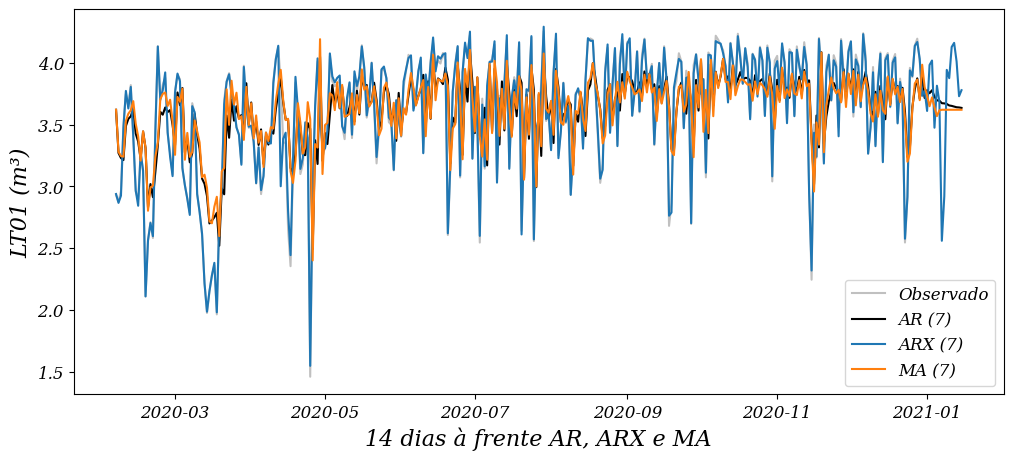

In [143]:
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(ar_14_tst, 'black')
plt.plot(arx_14_tst)
plt.plot(ma_14_tst)


plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl_14+' AR, ARX e MA', fontsize = 16)
plt.legend(['Observado',f'AR ({p1})',f'ARX ({p1})', f'MA ({q1})'])
plt.savefig(f"{pv_14}-AR-ARX-MA-14.pdf", dpi=600)
plt.show()

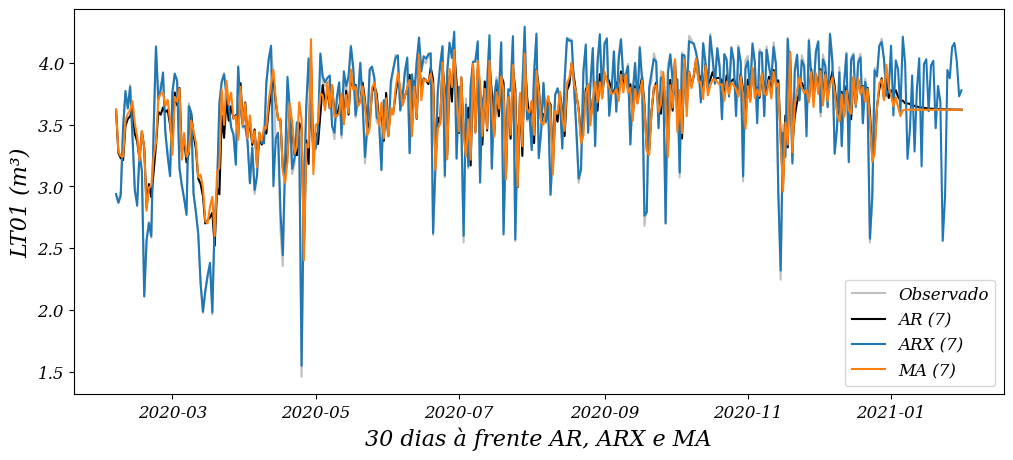

In [144]:
plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(ar_30_tst, 'black')
plt.plot(arx_30_tst)
plt.plot(ma_30_tst)


plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl_30+' AR, ARX e MA', fontsize = 16)
plt.legend(['Observado',f'AR ({p1})',f'ARX ({p1})', f'MA ({q1})'])
plt.savefig(f"{pv_30}-AR-ARX-MA-30.pdf", dpi=600)
plt.show()

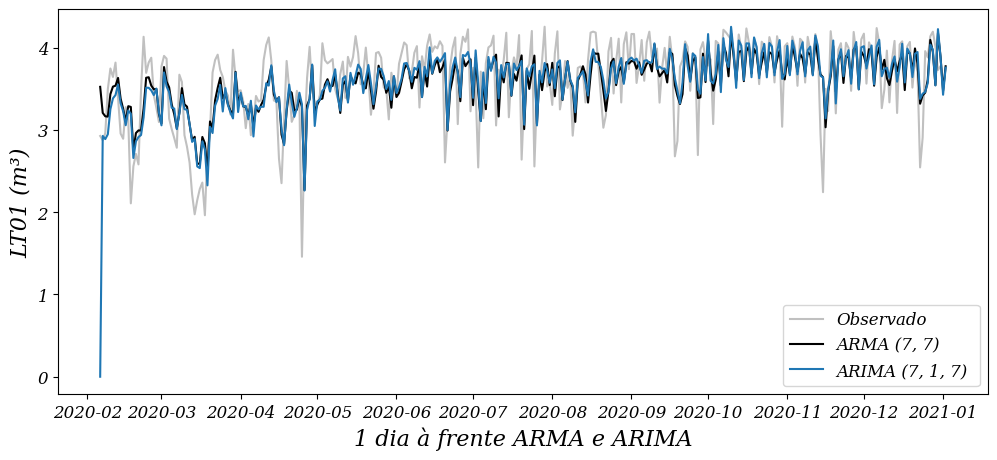

In [145]:


plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arma_tst, 'black')
plt.plot(arima_tst)
plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl+' ARMA e ARIMA', fontsize = 16)
plt.legend(['Observado',f'ARMA {p1,q1}',f'ARIMA {p1,d1,q1} '])
plt.savefig(f"{pv}-ARMA-ARIMA.pdf", dpi=500)
plt.show()


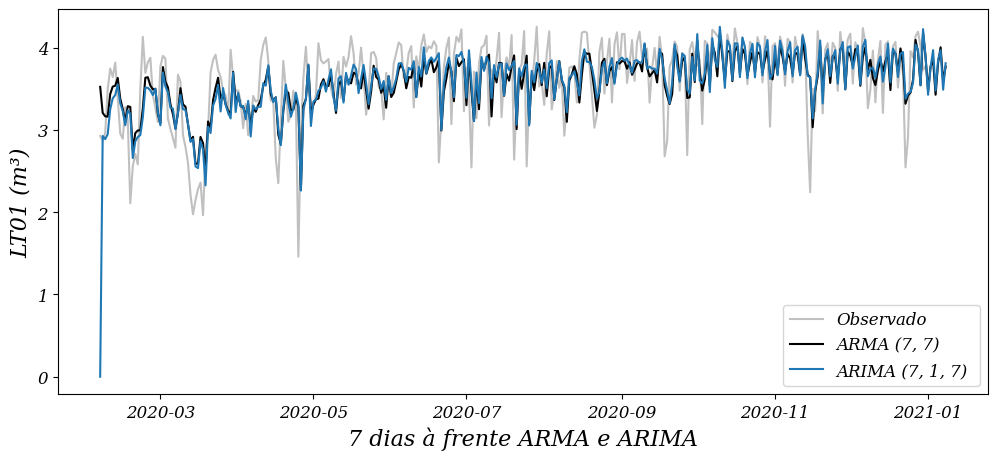

In [146]:


plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arma_7_tst, 'black')
plt.plot(arima_7_tst)
plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl_7+' ARMA e ARIMA', fontsize = 16)
plt.legend(['Observado',f'ARMA {p1,q1}',f'ARIMA {p1,d1,q1} '])
plt.savefig(f"{pv_7}-ARMA-ARIMA-7.pdf", dpi=600)
plt.show()


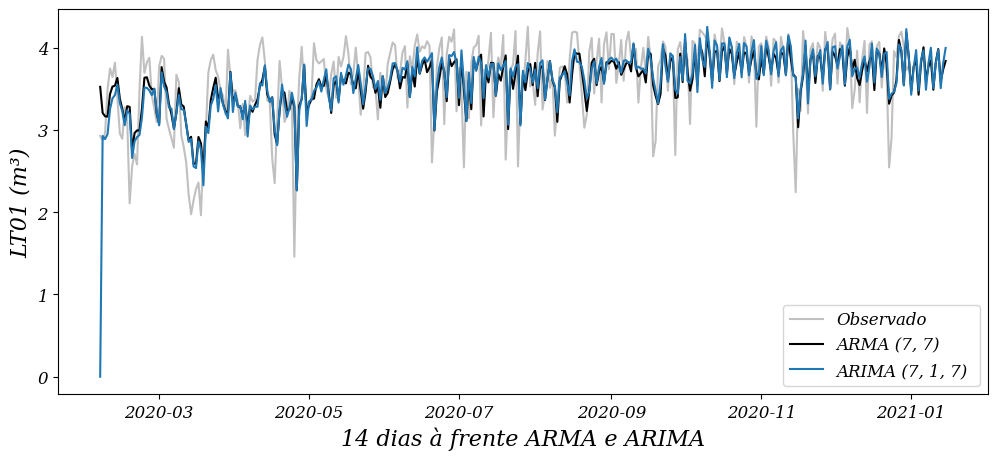

In [147]:


plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arma_14_tst, 'black')
plt.plot(arima_14_tst)
plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl_14+' ARMA e ARIMA', fontsize = 16)
plt.legend(['Observado',f'ARMA {p1,q1}',f'ARIMA {p1,d1,q1} '])
plt.savefig(f"{pv_14}-ARMA-ARIMA-14.pdf", dpi=600)
plt.show()


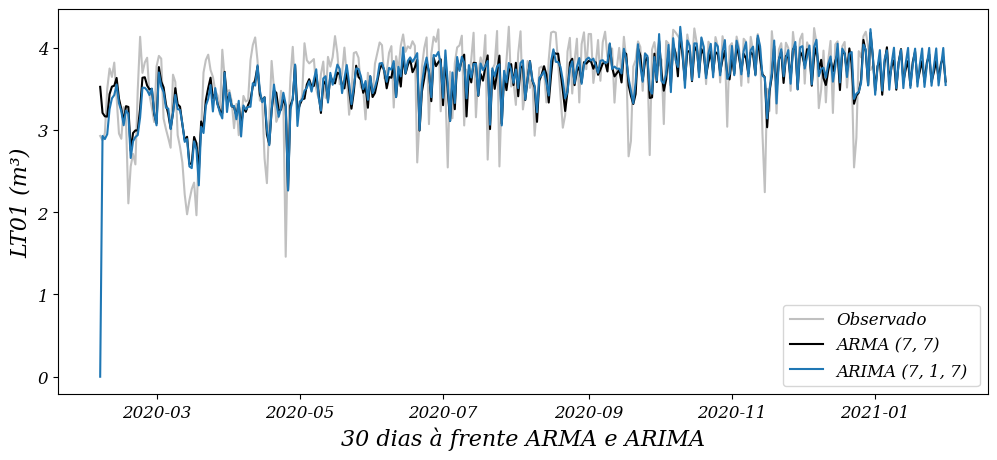

In [148]:


plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(arma_30_tst, 'black')
plt.plot(arima_30_tst)
plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl_30+' ARMA e ARIMA', fontsize = 16)
plt.legend(['Observado',f'ARMA {p1,q1}',f'ARIMA {p1,d1,q1} '])
plt.savefig(f"{pv_30}-ARMA-ARIMA-30.pdf", dpi=600)
plt.show()


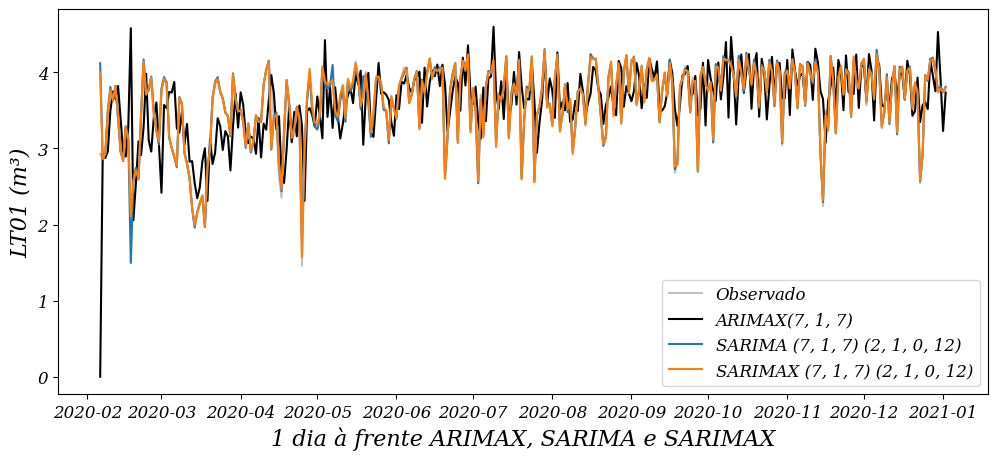

In [149]:

plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(sarima_tst, 'black')
plt.plot(sarimax_tst)
plt.plot(arimax_tst)
plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl+' ARIMAX, SARIMA e SARIMAX', fontsize = 16)
plt.legend(['Observado',f'ARIMAX{p1,d1,q1}',f'SARIMA {p1,d1,q1} {P1,D1,Q1,M1}',
f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
plt.savefig(f"{pv}-ARIMAX-SARIMA-SARIMAX.pdf", dpi=600)
plt.show()

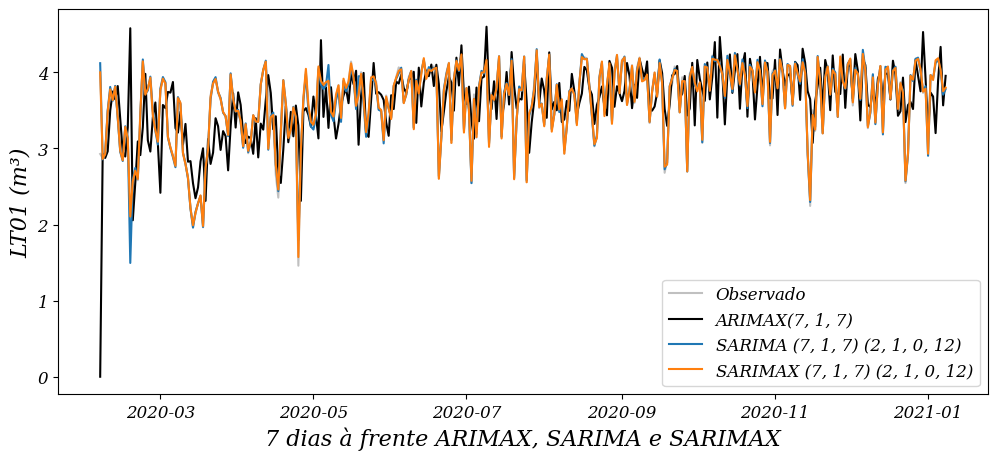

In [150]:

plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(sarima_7_tst, 'black')
plt.plot(sarimax_7_tst)
plt.plot(arimax_7_tst)
plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl_7+' ARIMAX, SARIMA e SARIMAX', fontsize = 16)
plt.legend(['Observado',f'ARIMAX{p1,d1,q1}',f'SARIMA {p1,d1,q1} {P1,D1,Q1,M1}',
f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
plt.savefig(f"{pv_7}-ARIMAX-SARIMA-SARIMAX-7.pdf", dpi=600)
plt.show()

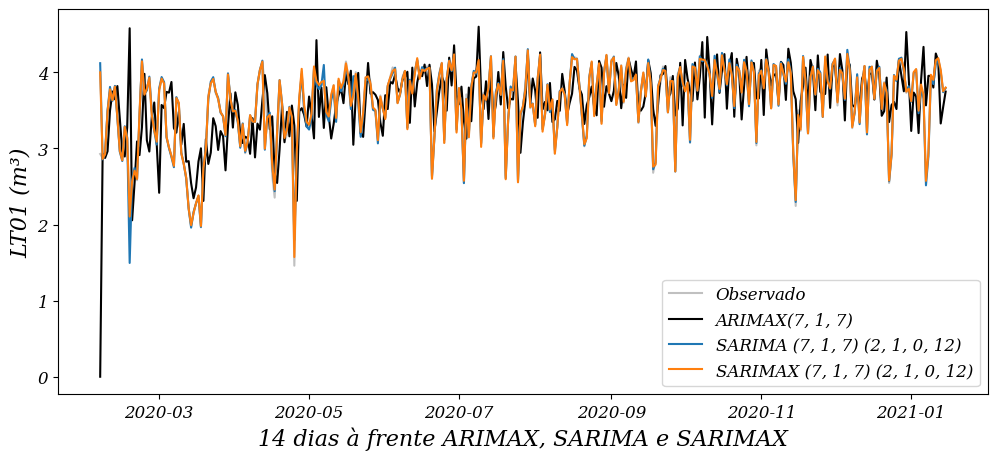

In [151]:

plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(sarima_14_tst, 'black')
plt.plot(sarimax_14_tst)
plt.plot(arimax_14_tst)
plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl_14+' ARIMAX, SARIMA e SARIMAX', fontsize = 16)
plt.legend(['Observado',f'ARIMAX{p1,d1,q1}',f'SARIMA {p1,d1,q1} {P1,D1,Q1,M1}',
f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
plt.savefig(f"{pv_14}-ARIMAX-SARIMA-SARIMAX-14.pdf", dpi=600)
plt.show()

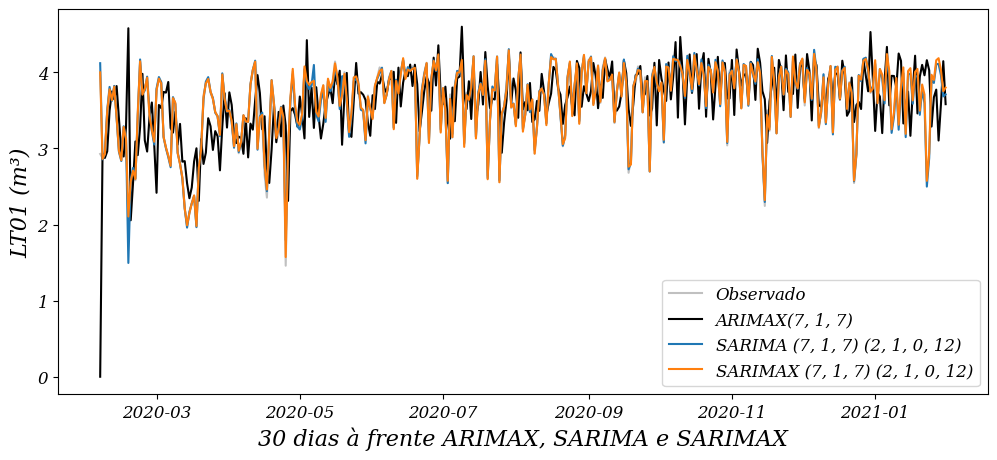

In [152]:

plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.plot(endog_tst, 'silver')
plt.plot(sarima_30_tst, 'black')
plt.plot(sarimax_30_tst)
plt.plot(arimax_30_tst)
plt.ylabel(rt , fontsize = 16)
plt.xlabel(pvl_30+' ARIMAX, SARIMA e SARIMAX', fontsize = 16)
plt.legend(['Observado',f'ARIMAX{p1,d1,q1}',f'SARIMA {p1,d1,q1} {P1,D1,Q1,M1}',
f'SARIMAX {p1,d1,q1} {P1,D1,Q1,M1}'])
plt.savefig(f"{pv_30}-ARIMAX-SARIMA-SARIMAX-30.pdf", dpi=600)
plt.show()

## Regressão

[12:05:25] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:05:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:05:31] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:05:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_

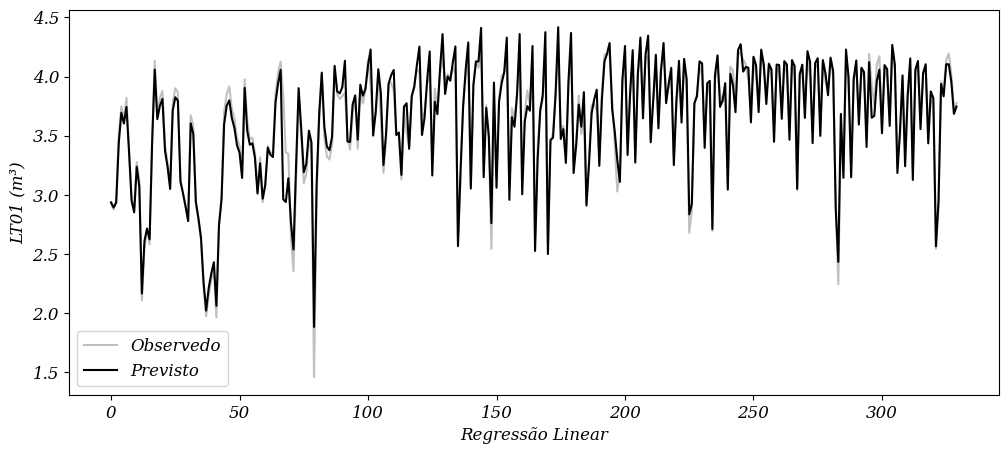

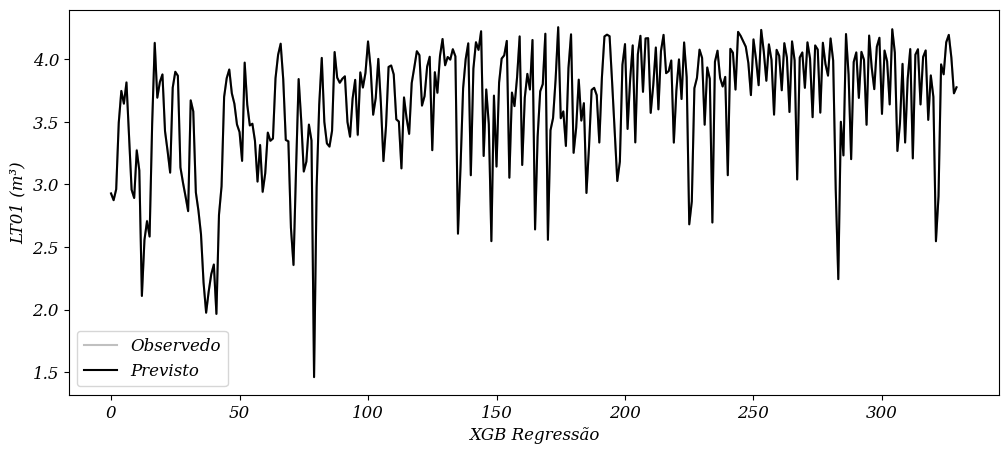

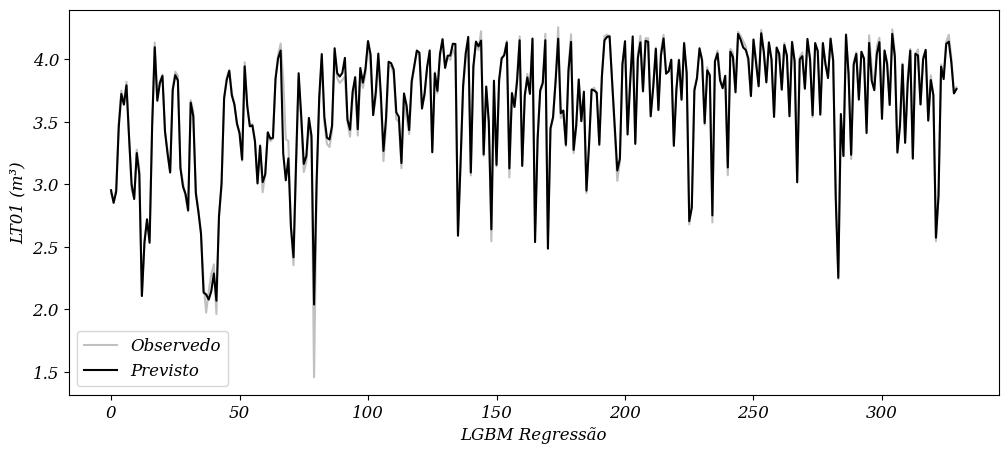

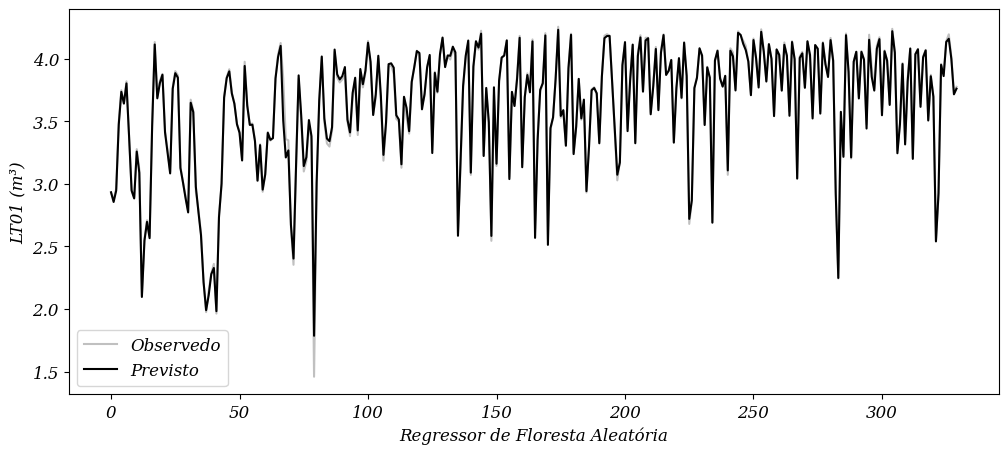

In [153]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

import math

endog_l_trn = trn[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l_tst = tst[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l_vld = vld[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l = df[['PRESSÃO DE SUCÇÃO - PT01']]


my_lm = LinearRegression()
lm_trn = my_lm.fit(X =endog_l_trn, y = endog_trn)
lm_vld = my_lm.fit(X =endog_l_vld, y = endog_vld)
lm_tst = my_lm.fit(X =endog_l_tst, y = endog_tst)
lm = my_lm.fit(X =endog_l, y = endog)
lr_trn = lm_trn.predict(endog_l_trn)
lr_vld = lm_vld.predict(endog_l_vld)
lr_tst = lm_tst.predict(endog_l_tst)
lr = lm_tst.predict(endog_l)

random.seed(0)

# my_xgb = XGBRegressor(base_score=0.5, booster='gbtree', bootstrap=True, callbacks=None,
#              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
#              early_stopping_rounds=None, enable_categorical=False,
#              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
#              grow_policy='depthwise', importance_type=None,
#              interaction_constraints='', learning_rate=0.300000012, max_bin=256,
#              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
#              max_depth=14, max_features='log2', max_leaves=0,
#              min_child_weight=1, min_samples_leaf=3, min_samples_split=2,
#              monotone_constraints='()', n_estimators=800)

my_xgb = XGBRegressor(bootstrap = True, max_depth = 2, max_features = 'auto', min_samples_leaf = 2,
                       min_samples_split = 2, n_estimators = 5650)

# my_xgb = BayesSearchCV(
#     XGBRegressor(){
#         'learning_rate': (10e-6, 1.0, 'log-uniform')
#         'max_depth': Integer(0, 50, 'uniform')
#         'n_estimators' : (10, 1000, 'log-uniform')},
#         n_iter=10, cv=3)
x_trn = my_xgb.fit(X = exog_trn, y = endog_trn)
x_tst = my_xgb.fit(X = exog_tst, y = endog_tst)
x_vld = my_xgb.fit(X = exog_vld, y = endog_vld)
x = my_xgb.fit(X = exog, y = endog)
xgb_trn = x_trn.predict(exog_trn)
xgb_vld = x_vld.predict(exog_vld)
xgb_tst = x_tst.predict(exog_tst)
xgb = x.predict(exog)

# my_lgbm = LGBMRegressor(bootstrap=True, max_depth=2, max_features='auto',
#               min_samples_leaf=2, min_samples_split=2)

# my_lgbm = LGBMRegressor(bootstrap=True, max_depth=14, max_features='log2',
#               min_samples_leaf=3, min_samples_split=2, n_estimators=800)

search_space = {'C': Real(1e-6, 1e6, prior='log-uniform'),
       'gamma': Real(1e-6, 1e1, prior='log-uniform'),
       'degree': Integer(1,8),
       'kernel': Categorical(['linear', 'poly', 'rbf']),
       "bootstrap": Categorical([True, False]), 
        "max_depth": Integer(6, 40), 
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 30),
        "min_samples_split": Integer(2,20),
        "n_estimators": Integer(50, 200)
    }



my_lgbm = BayesSearchCV(LGBMRegressor(), search_space, 
       n_iter=32, verbose=True, cv=4,
       random_state=122)
lb_trn = my_lgbm.fit(X = exog_trn, y = endog_trn)
lb_vld = my_lgbm.fit(X = exog_vld, y = endog_vld)
lb_tst = my_lgbm.fit(X = exog_tst, y = endog_tst)
lb = my_lgbm.fit(X = exog, y = endog)
lgbm_trn = lb_trn.predict(exog_trn)
lgbm_vld = lb_vld.predict(exog_vld)
lgbm_tst = lb_tst.predict(exog_tst)
lgbm = lb.predict(exog)

# my_rf = GridSearchCV(RandomForestRegressor(){
#         'max_features':[0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
#         'n_estimators': [10, 50, 100, 250, 500, 750, 1000]},
#         scoring = 'r2', n_jobs = -1)

# distributions = {'max_features': stats.norm(0.8, math.sqrt(0.005))
# 'n_estimators': stats.randint(50, 1000)}

my_rf = RandomForestRegressor()

# my_rf = RandomForestRegressor(max_depth=8, max_features='auto', min_samples_leaf=4,
#                       n_estimators=400)

trn_rf = my_rf.fit(X = exog_trn, y = endog_trn)
tst_rf = my_rf.fit(X = exog_tst, y = endog_tst)
vld_rf = my_rf.fit(X = exog_vld, y = endog_vld)
rf = my_rf.fit(X = exog, y = endog)
rf_trn = trn_rf.predict(exog_trn)
rf_vld = vld_rf.predict(exog_vld)
rf_tst = tst_rf.predict(exog_tst)
rf_df = rf.predict(exog)

### Erros LR

smape_lr_trn = smape(endog_l_trn, lr_trn)
smape_lr_vld = smape(endog_l_vld, lr_vld)
smape_lr_tst = smape(endog_l_tst, lr_tst)
smape_lr = smape(endog_l, lr)


mae_lr_trn = mean_absolute_error(endog_l_trn, lr_trn)
mae_lr_vld = mean_absolute_error(endog_l_vld, lr_vld)
mae_lr_tst = mean_absolute_error(endog_l_tst, lr_tst)
mae_lr = mean_absolute_error(endog_l, lr)

rrmse_lr_trn = rrmse(endog_l_trn, lr_trn)
rrmse_lr_vld = rrmse(endog_l_vld, lr_vld)
rrmse_lr_tst = rrmse(endog_l_tst, lr_tst)
rrmse_lr = rrmse(endog_l, lr)

### Erros xgb

smape_xgb_trn = smape(endog_trn, xgb_trn)
smape_xgb_tst = smape(endog_tst, xgb_tst)
smape_xgb_vld = smape(endog_vld, xgb_vld)
smape_xgb = smape(endog, xgb)

mae_xgb_trn = mean_absolute_error(endog_trn, xgb_trn)
mae_xgb_tst = mean_absolute_error(endog_tst, xgb_tst)
mae_xgb_vld = mean_absolute_error(endog_vld, xgb_vld)
mae_xgb = mean_absolute_error(endog, xgb)

rrmse_xgb_trn = rrmse(endog_trn, xgb_trn)
rrmse_xgb_tst = rrmse(endog_tst, xgb_tst)
rrmse_xgb_vld = rrmse(endog_vld, xgb_vld)
rrmse_xgb = rrmse(endog, xgb)

### Erros lgbm

smape_lgbm_trn = smape(endog_trn, lgbm_trn)
smape_lgbm_tst = smape(endog_tst, lgbm_tst)
smape_lgbm_vld = smape(endog_vld, lgbm_vld)
smape_lgbm = smape(endog, lgbm)

mae_lgbm_trn = mean_absolute_error(endog_trn, lgbm_trn)
mae_lgbm_tst = mean_absolute_error(endog_tst, lgbm_tst)
mae_lgbm_vld = mean_absolute_error(endog_vld, lgbm_vld)
mae_lgbm = mean_absolute_error(endog, lgbm)

rrmse_lgbm_trn = rrmse(endog_trn, lgbm_trn)
rrmse_lgbm_tst = rrmse(endog_tst, lgbm_tst)
rrmse_lgbm_vld = rrmse(endog_vld, lgbm_vld)
rrmse_lgbm = rrmse(endog, lgbm)


### Erros rf

smape_rf_trn = smape(endog_trn, rf_trn)
smape_rf_tst = smape(endog_tst, rf_tst)
smape_rf_vld = smape(endog_vld, rf_vld)
smape_rf = smape(endog, rf_df)

mae_rf_trn = mean_absolute_error(endog_trn, rf_trn)
mae_rf_tst = mean_absolute_error(endog_tst, rf_tst)
mae_rf_vld = mean_absolute_error(endog_vld, rf_vld)
mae_rf = mean_absolute_error(endog, rf_df)

rrmse_rf_trn = rrmse(endog_trn, rf_trn)
rrmse_rf_tst = rrmse(endog_tst, rf_tst)
rrmse_rf_vld = rrmse(endog_vld, rf_vld)
rrmse_rf = rrmse(endog, rf_df)

print(  f"Regressão linear  sMAPE Erro: {smape_lr_trn:2.3f} Train",'\n',
        f"Regressão linear  sMAPE Erro: {smape_lr_tst:2.3f} Test",'\n',
        f"Regressão linear  sMAPE Erro: {smape_lr_vld:2.3f} Validação",'\n',
        f"Regressão linear  sMAPE Erro: {smape_lr:2.3f} ",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_trn:2.3f} Train",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_tst:2.3f} Test",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_vld:2.3f} Validção",'\n',
        f"Regressão linear  MAE Erro: {mae_lr:2.3f} ",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_trn:2.3f} Train",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_vld:2.3f} Validação",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr:2.3f} ",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_tst:2.3f} Test",'\n','\n',
        f"XGB Regressão  sMAPE Erro: {smape_xgb_trn:2.3f} Train",'\n',
        f"XGB Regressão  sMAPE Erro: {smape_xgb_tst:2.3f} Test",'\n',
        f"XGB Regressão  sMAPE Erro: {smape_xgb_vld:2.3f} Validação",'\n',
        f"XGB Regressão  sMAPE Erro: {smape_xgb:2.3f} ",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb_trn:2.3f} Train",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb_tst:2.3f} Test",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb_vld:2.3f} Validação",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb:2.3f} ",'\n',
        f"XGB Regressão  rRMSE Erro: {rrmse_xgb_trn:2.3f} Train",'\n',
        f"XGB Regressão  rRMSE Erro: {rrmse_xgb_vld:2.3f} Validação",'\n',
        f"XGB Regressão  rRMSE Erro: {rrmse_xgb:2.3f} ",'\n',
        f"XGB Regressão  rRMSE Erro: {rrmse_xgb_tst:2.3f} Test",'\n','\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm:2.3f} ",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm:2.3f} ",'\n'
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm:2.3f}",
        '\n','\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_tst:2.3f} Test",'\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf:2.3f} ",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_tst:2.3f} Test",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf:2.3f}",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf:2.3f} ",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_tst:2.3f} Test")

plt.figure(figsize = (12,5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(lr_tst), 'black')
plt.xlabel('Regressão Linear')
plt.legend(['Observedo','Previsto'])
plt.savefig(f"regressão-linear.pdf", dpi=600)
plt.ylabel(rt)
plt.show()

plt.figure(figsize = (12,5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(xgb_tst), 'black')
plt.xlabel('XGB Regressão')
plt.legend(['Observedo','Previsto'])
plt.ylabel(rt)
plt.savefig(f"xgb-regressão.pdf", dpi=600)
plt.show()

plt.figure(figsize = (12,5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(lgbm_tst), 'black')
plt.xlabel('LGBM Regressão')
plt.legend(['Observedo','Previsto'])
plt.ylabel(rt)
plt.savefig(f"lgbm-regressão.pdf", dpi=600)
plt.show()

plt.figure(figsize = (12,5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(rf_tst), 'black')
plt.xlabel('Regressor de Floresta Aleatória')
plt.legend(['Observedo','Previsto'])
plt.ylabel(rt)
plt.savefig(f"regressão-rfa.pdf", dpi=600)
plt.show()

Comparação

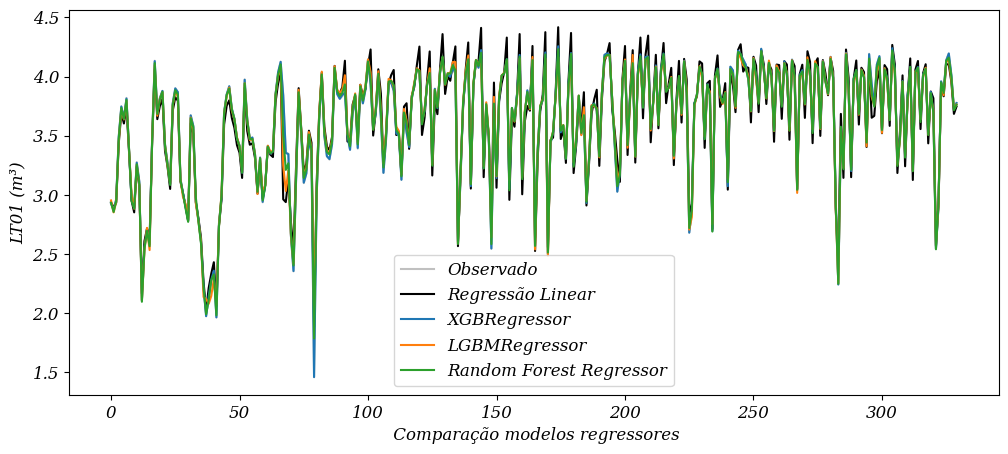

In [154]:
plt.figure(figsize = (12,5))
plt.plot(list(endog_tst), 'silver')
plt.plot(list(lr_tst), 'black')
plt.plot(list(xgb_tst))
plt.plot(list(lgbm_tst))
plt.plot(list(rf_tst))
plt.xlabel(' Comparação modelos regressores', fontsize = 12)
plt.legend(['Observado','Regressão Linear', 'XGBRegressor', 'LGBMRegressor', 'Random Forest Regressor'])
plt.ylabel(rt)
plt.savefig(f"LR-XGB-LGBM-RF.pdf", dpi=600)
plt.show()

### 1 dia à frente

In [155]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

import math

endog_l_trn = trn[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l_tst = tst[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l_vld = vld[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l = df[['PRESSÃO DE SUCÇÃO - PT01']]


my_lm = LinearRegression()
lm_trn = my_lm.fit(X =endog_l_trn, y = endog_trn)
lm_vld = my_lm.fit(X =endog_l_vld, y = endog_vld)
lm_tst = my_lm.fit(X =endog_l_tst, y = endog_tst)
lm = my_lm.fit(X =endog_l, y = endog)
lr_trn = lm_trn.predict(endog_l_trn+pv)
lr_vld = lm_vld.predict(endog_l_vld+pv)
lr_tst = lm_tst.predict(endog_l_tst+pv)
lr = lm_tst.predict(endog_l+pv)

random.seed(0)

# my_xgb = XGBRegressor(base_score=0.5, booster='gbtree', bootstrap=True, callbacks=None,
#              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
#              early_stopping_rounds=None, enable_categorical=False,
#              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
#              grow_policy='depthwise', importance_type=None,
#              interaction_constraints='', learning_rate=0.300000012, max_bin=256,
#              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
#              max_depth=14, max_features='log2', max_leaves=0,
#              min_child_weight=1, min_samples_leaf=3, min_samples_split=2,
#              monotone_constraints='()', n_estimators=800)

my_xgb = XGBRegressor(bootstrap = True, max_depth = 2, max_features = 'auto', min_samples_leaf = 2,
                       min_samples_split = 2, n_estimators = 5650)

# my_xgb = BayesSearchCV(
#     XGBRegressor(){
#         'learning_rate': (10e-6, 1.0, 'log-uniform')
#         'max_depth': Integer(0, 50, 'uniform')
#         'n_estimators' : (10, 1000, 'log-uniform')},
#         n_iter=10, cv=3)
x_trn = my_xgb.fit(X = exog_trn, y = endog_trn)
x_tst = my_xgb.fit(X = exog_tst, y = endog_tst)
x_vld = my_xgb.fit(X = exog_vld, y = endog_vld)
x = my_xgb.fit(X = exog, y = endog)
xgb_trn = x_trn.predict(exog_trn+pv)
xgb_vld = x_vld.predict(exog_vld+pv)
xgb_tst = x_tst.predict(exog_tst+pv)
xgb = x.predict(exog+pv)

# my_lgbm = LGBMRegressor(bootstrap=True, max_depth=2, max_features='auto',
#               min_samples_leaf=2, min_samples_split=2)

# my_lgbm = LGBMRegressor(bootstrap=True, max_depth=14, max_features='log2',
#               min_samples_leaf=3, min_samples_split=2, n_estimators=800)

search_space = {'C': Real(1e-6, 1e+6, prior='log-uniform'),
       'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
       'degree': Integer(1,8),
       'kernel': Categorical(['linear', 'poly', 'rbf']),
       "bootstrap": Categorical([True, False]), 
        "max_depth": Integer(6, 40), 
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 30),
        "min_samples_split": Integer(2,20),
        "n_estimators": Integer(50, 200)
    }



my_lgbm = BayesSearchCV(LGBMRegressor(), search_space, 
       n_iter=32, verbose=True, cv=4,
       random_state=122)
lb_trn = my_lgbm.fit(X = exog_trn, y = endog_trn)
lb_vld = my_lgbm.fit(X = exog_vld, y = endog_vld)
lb_tst = my_lgbm.fit(X = exog_tst, y = endog_tst)
lb = my_lgbm.fit(X = exog, y = endog)
lgbm_trn = lb_trn.predict(exog_trn+pv)
lgbm_vld = lb_vld.predict(exog_vld+pv)
lgbm_tst = lb_tst.predict(exog_tst+pv)
lgbm = lb.predict(exog+pv)

# my_rf = GridSearchCV(RandomForestRegressor(){
#         'max_features':[0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
#         'n_estimators': [10, 50, 100, 250, 500, 750, 1000]},
#         scoring = 'r2', n_jobs = -1)

# distributions = {'max_features': stats.norm(0.8, math.sqrt(0.005))
# 'n_estimators': stats.randint(50, 1000)}

my_rf = RandomForestRegressor()

# my_rf = RandomForestRegressor(max_depth=8, max_features='auto', min_samples_leaf=4,
#                       n_estimators=400)

trn_rf = my_rf.fit(X = exog_trn, y = endog_trn)
tst_rf = my_rf.fit(X = exog_tst, y = endog_tst)
vld_rf = my_rf.fit(X = exog_vld, y = endog_vld)
rf = my_rf.fit(X = exog, y = endog)
rf_trn = trn_rf.predict(exog_trn+pv)
rf_vld = vld_rf.predict(exog_vld+pv)
rf_tst = tst_rf.predict(exog_tst+pv)
rf_df = rf.predict(exog+pv)

### Erros LR

smape_lr_trn = smape(endog_l_trn, lr_trn)
smape_lr_vld = smape(endog_l_vld, lr_vld)
smape_lr_tst = smape(endog_l_tst, lr_tst)
smape_lr = smape(endog_l, lr)


mae_lr_trn = mean_absolute_error(endog_l_trn, lr_trn)
mae_lr_vld = mean_absolute_error(endog_l_vld, lr_vld)
mae_lr_tst = mean_absolute_error(endog_l_tst, lr_tst)
mae_lr = mean_absolute_error(endog_l, lr)

rrmse_lr_trn = rrmse(endog_l_trn, lr_trn)
rrmse_lr_vld = rrmse(endog_l_vld, lr_vld)
rrmse_lr_tst = rrmse(endog_l_tst, lr_tst)
rrmse_lr = rrmse(endog_l, lr)

### Erros xgb

smape_xgb_trn = smape(endog_trn, xgb_trn)
smape_xgb_tst = smape(endog_tst, xgb_tst)
smape_xgb_vld = smape(endog_vld, xgb_vld)
smape_xgb = smape(endog, xgb)

mae_xgb_trn = mean_absolute_error(endog_trn, xgb_trn)
mae_xgb_tst = mean_absolute_error(endog_tst, xgb_tst)
mae_xgb_vld = mean_absolute_error(endog_vld, xgb_vld)
mae_xgb = mean_absolute_error(endog, xgb)

rrmse_xgb_trn = rrmse(endog_trn, xgb_trn)
rrmse_xgb_tst = rrmse(endog_tst, xgb_tst)
rrmse_xgb_vld = rrmse(endog_vld, xgb_vld)
rrmse_xgb = rrmse(endog, xgb)

### Erros lgbm

smape_lgbm_trn = smape(endog_trn, lgbm_trn)
smape_lgbm_tst = smape(endog_tst, lgbm_tst)
smape_lgbm_vld = smape(endog_vld, lgbm_vld)
smape_lgbm = smape(endog, lgbm)

mae_lgbm_trn = mean_absolute_error(endog_trn, lgbm_trn)
mae_lgbm_tst = mean_absolute_error(endog_tst, lgbm_tst)
mae_lgbm_vld = mean_absolute_error(endog_vld, lgbm_vld)
mae_lgbm = mean_absolute_error(endog, lgbm)

rrmse_lgbm_trn = rrmse(endog_trn, lgbm_trn)
rrmse_lgbm_tst = rrmse(endog_tst, lgbm_tst)
rrmse_lgbm_vld = rrmse(endog_vld, lgbm_vld)
rrmse_lgbm = rrmse(endog, lgbm)


### Erros rf

smape_rf_trn = smape(endog_trn, rf_trn)
smape_rf_tst = smape(endog_tst, rf_tst)
smape_rf_vld = smape(endog_vld, rf_vld)
smape_rf = smape(endog, rf_df)

mae_rf_trn = mean_absolute_error(endog_trn, rf_trn)
mae_rf_tst = mean_absolute_error(endog_tst, rf_tst)
mae_rf_vld = mean_absolute_error(endog_vld, rf_vld)
mae_rf = mean_absolute_error(endog, rf_df)

rrmse_rf_trn = rrmse(endog_trn, rf_trn)
rrmse_rf_tst = rrmse(endog_tst, rf_tst)
rrmse_rf_vld = rrmse(endog_vld, rf_vld)
rrmse_rf = rrmse(endog, rf_df)

print(  f"Regressão linear  sMAPE Erro: {smape_lr_trn:2.3f} Train",'\n',
        f"Regressão linear  sMAPE Erro: {smape_lr_tst:2.3f} Test",'\n',
        f"Regressão linear  sMAPE Erro: {smape_lr_vld:2.3f} Validação",'\n',
        f"Regressão linear  sMAPE Erro: {smape_lr:2.3f} ",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_trn:2.3f} Train",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_tst:2.3f} Test",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_vld:2.3f} Validção",'\n',
        f"Regressão linear  MAE Erro: {mae_lr:2.3f} ",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_trn:2.3f} Train",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_vld:2.3f} Validação",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr:2.3f} ",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_tst:2.3f} Test",'\n','\n',
        f"XGB Regressão  sMAPE Erro: {smape_xgb_trn:2.3f} Train",'\n',
        f"XGB Regressão  sMAPE Erro: {smape_xgb_tst:2.3f} Test",'\n',
        f"XGB Regressão  sMAPE Erro: {smape_xgb_vld:2.3f} Validação",'\n',
        f"XGB Regressão  sMAPE Erro: {smape_xgb:2.3f} ",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb_trn:2.3f} Train",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb_tst:2.3f} Test",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb_vld:2.3f} Validação",'\n',
        f"XGB Regressão  MAE Erro: {mae_xgb:2.3f} ",'\n',
        f"XGB Regressão  rRMSE Erro: {rrmse_xgb_trn:2.3f} Train",'\n',
        f"XGB Regressão  rRMSE Erro: {rrmse_xgb_vld:2.3f} Validação",'\n',
        f"XGB Regressão  rRMSE Erro: {rrmse_xgb:2.3f} ",'\n',
        f"XGB Regressão  rRMSE Erro: {rrmse_xgb_tst:2.3f} Test",'\n','\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm:2.3f} ",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm:2.3f} ",'\n'
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm:2.3f}",
        '\n','\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_tst:2.3f} Test",'\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf:2.3f} ",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_tst:2.3f} Test",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf:2.3f}",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf:2.3f} ",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_tst:2.3f} Test")

# plt.figure(figsize = (12,5))
# plt.plot(list(endog_tst), 'silver')
# plt.plot(list(lr_tst), 'black')
# plt.xlabel('Regressão Linear')
# plt.legend(['Observedo','Previsto'])
# plt.savefig(f"{pv}-regressão-linear.pdf", dpi=600)
# plt.ylabel(rt)
# plt.show()

# plt.figure(figsize = (12,5))
# plt.plot(list(endog_tst), 'silver')
# plt.plot(list(xgb_tst), 'black')
# plt.xlabel('XGB Regressão')
# plt.legend(['Observedo','Previsto'])
# plt.ylabel(rt)
# plt.savefig(f"{pv}-xgb-regressão.pdf", dpi=600)
# plt.show()

# plt.figure(figsize = (12,5))
# plt.plot(list(endog_tst), 'silver')
# plt.plot(list(lgbm_tst), 'black')
# plt.xlabel('LGBM Regressão')
# plt.legend(['Observedo','Previsto'])
# plt.ylabel(rt)
# plt.savefig(f"{pv}-lgbm-regressão.pdf", dpi=600)
# plt.show()

# plt.figure(figsize = (12,5))
# plt.plot(list(endog_tst), 'silver')
# plt.plot(list(rf_tst), 'black')
# plt.xlabel('Regressor de Floresta Aleatória')
# plt.legend(['Observedo','Previsto'])
# plt.ylabel(rt)
# plt.savefig(f"{pv}-regressão-rfa.pdf", dpi=600)
# plt.show()

[12:11:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.



[12:11:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:11:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:11:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[LightGBM] [Warning] Unknown parameter: C
[LightGBM] [Warning] Unknown parameter: bootstrap
[LightGBM] [Warning] Unknown parameter: degree
[LightGBM] [Warning] Unknown param

### 7 dias à frente

In [156]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

import math

endog_l_trn = trn[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l_tst = tst[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l_vld = vld[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l = df[['PRESSÃO DE SUCÇÃO - PT01']]


my_lm = LinearRegression()
lm_trn = my_lm.fit(X =endog_l_trn, y = endog_trn)
lm_vld = my_lm.fit(X =endog_l_vld, y = endog_vld)
lm_tst = my_lm.fit(X =endog_l_tst, y = endog_tst)
lm = my_lm.fit(X =endog_l, y = endog)
lr_7_trn = lm_trn.predict(endog_l_trn+pv_7)
lr_7_vld = lm_vld.predict(endog_l_vld+pv_7)
lr_7_tst = lm_tst.predict(endog_l_tst+pv_7)
lr_7 = lm_tst.predict(endog_l+pv_7)

random.seed(0)

# my_xgb_7 = XGBRegressor(base_score=0.5, booster='gbtree', bootstrap=True, callbacks=None,
#              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
#              early_stopping_rounds=None, enable_categorical=False,
#              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
#              grow_policy='depthwise', importance_type=None,
#              interaction_constraints='', learning_rate=0.300000012, max_bin=256,
#              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
#              max_depth=14, max_features='log2', max_leaves=0,
#              min_child_weight=1, min_samples_leaf=3, min_samples_split=2,
#              monotone_constraints='()', n_estimators=800)

my_xgb_7 = XGBRegressor(bootstrap = True, max_depth = 2, max_features = 'auto', min_samples_leaf = 2,
                       min_samples_split = 2, n_estimators = 5650)

# my_xgb_7 = BayesSearchCV(
#     XGBRegressor(){
#         'learning_rate': (10e-6, 1.0, 'log-uniform')
#         'max_depth': Integer(0, 50, 'uniform')
#         'n_estimators' : (10, 1000, 'log-uniform')},
#         n_iter=10, cv=3)
x_trn = my_xgb_7.fit(X = exog_trn, y = endog_trn)
x_tst = my_xgb_7.fit(X = exog_tst, y = endog_tst)
x_vld = my_xgb_7.fit(X = exog_vld, y = endog_vld)
x = my_xgb_7.fit(X = exog, y = endog)
xgb_7_trn = x_trn.predict(exog_trn+pv_7)
xgb_7_vld = x_vld.predict(exog_vld+pv_7)
xgb_7_tst = x_tst.predict(exog_tst+pv_7)
xgb_7 = x.predict(exog+pv_7)

# my_lgbm_7 = LGBMRegressor(bootstrap=True, max_depth=2, max_features='auto',
#               min_samples_leaf=2, min_samples_split=2)

# my_lgbm_7 = LGBMRegressor(bootstrap=True, max_depth=14, max_features='log2',
#               min_samples_leaf=3, min_samples_split=2, n_estimators=800)

search_space = {'C': Real(1e-6, 1e+6, prior='log-uniform'),
       'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
       'degree': Integer(1,8),
       'kernel': Categorical(['linear', 'poly', 'rbf']),
       "bootstrap": Categorical([True, False]), 
        "max_depth": Integer(6, 40), 
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 30),
        "min_samples_split": Integer(2,20),
        "n_estimators": Integer(50, 200)
    }



my_lgbm_7 = BayesSearchCV(LGBMRegressor(), search_space, 
       n_iter=32, verbose=True, cv=4,
       random_state=122)
lb_trn = my_lgbm_7.fit(X = exog_trn, y = endog_trn)
lb_vld = my_lgbm_7.fit(X = exog_vld, y = endog_vld)
lb_tst = my_lgbm_7.fit(X = exog_tst, y = endog_tst)
lb = my_lgbm_7.fit(X = exog, y = endog)
lgbm_7_trn = lb_trn.predict(exog_trn+pv_7)
lgbm_7_vld = lb_vld.predict(exog_vld+pv_7)
lgbm_7_tst = lb_tst.predict(exog_tst+pv_7)
lgbm_7 = lb.predict(exog+pv_7)

# my_rf_7 = GridSearchCV(RandomForestRegressor(){
#         'max_features':[0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
#         'n_estimators': [10, 50, 100, 250, 500, 750, 1000]},
#         scoring = 'r2', n_jobs = -1)

# distributions = {'max_features': stats.norm(0.8, math.sqrt(0.005))
# 'n_estimators': stats.randint(50, 1000)}

my_rf_7 = RandomForestRegressor()

# my_rf_7 = RandomForestRegressor(max_depth=8, max_features='auto', min_samples_leaf=4,
#                       n_estimators=400)

trn_rf_7 = my_rf_7.fit(X = exog_trn, y = endog_trn)
tst_rf_7 = my_rf_7.fit(X = exog_tst, y = endog_tst)
vld_rf_7 = my_rf_7.fit(X = exog_vld, y = endog_vld)
rf_7 = my_rf_7.fit(X = exog, y = endog)
rf_7_trn = trn_rf_7.predict(exog_trn+pv_7)
rf_7_vld = vld_rf_7.predict(exog_vld+pv_7)
rf_7_tst = tst_rf_7.predict(exog_tst+pv_7)
rf_7_df = rf_7.predict(exog+pv_7)

### Erros LR_7

smape_lr_7_trn = smape(endog_l_trn, lr_7_trn)
smape_lr_7_vld = smape(endog_l_vld, lr_7_vld)
smape_lr_7_tst = smape(endog_l_tst, lr_7_tst)
smape_lr_7 = smape(endog_l, lr_7)


mae_lr_7_trn = mean_absolute_error(endog_l_trn, lr_7_trn)
mae_lr_7_vld = mean_absolute_error(endog_l_vld, lr_7_vld)
mae_lr_7_tst = mean_absolute_error(endog_l_tst, lr_7_tst)
mae_lr_7 = mean_absolute_error(endog_l, lr_7)

rrmse_lr_7_trn = rrmse(endog_l_trn, lr_7_trn)
rrmse_lr_7_vld = rrmse(endog_l_vld, lr_7_vld)
rrmse_lr_7_tst = rrmse(endog_l_tst, lr_7_tst)
rrmse_lr_7 = rrmse(endog_l, lr_7)

### Erros xgb_7

smape_xgb_7_trn = smape(endog_trn, xgb_7_trn)
smape_xgb_7_tst = smape(endog_tst, xgb_7_tst)
smape_xgb_7_vld = smape(endog_vld, xgb_7_vld)
smape_xgb_7 = smape(endog, xgb_7)

mae_xgb_7_trn = mean_absolute_error(endog_trn, xgb_7_trn)
mae_xgb_7_tst = mean_absolute_error(endog_tst, xgb_7_tst)
mae_xgb_7_vld = mean_absolute_error(endog_vld, xgb_7_vld)
mae_xgb_7 = mean_absolute_error(endog, xgb_7)

rrmse_xgb_7_trn = rrmse(endog_trn, xgb_7_trn)
rrmse_xgb_7_tst = rrmse(endog_tst, xgb_7_tst)
rrmse_xgb_7_vld = rrmse(endog_vld, xgb_7_vld)
rrmse_xgb_7 = rrmse(endog, xgb_7)

### Erros lgbm_7

smape_lgbm_7_trn = smape(endog_trn, lgbm_7_trn)
smape_lgbm_7_tst = smape(endog_tst, lgbm_7_tst)
smape_lgbm_7_vld = smape(endog_vld, lgbm_7_vld)
smape_lgbm_7 = smape(endog, lgbm_7)

mae_lgbm_7_trn = mean_absolute_error(endog_trn, lgbm_7_trn)
mae_lgbm_7_tst = mean_absolute_error(endog_tst, lgbm_7_tst)
mae_lgbm_7_vld = mean_absolute_error(endog_vld, lgbm_7_vld)
mae_lgbm_7 = mean_absolute_error(endog, lgbm_7)

rrmse_lgbm_7_trn = rrmse(endog_trn, lgbm_7_trn)
rrmse_lgbm_7_tst = rrmse(endog_tst, lgbm_7_tst)
rrmse_lgbm_7_vld = rrmse(endog_vld, lgbm_7_vld)
rrmse_lgbm_7 = rrmse(endog, lgbm_7)


### Erros rf_7

smape_rf_7_trn = smape(endog_trn, rf_7_trn)
smape_rf_7_tst = smape(endog_tst, rf_7_tst)
smape_rf_7_vld = smape(endog_vld, rf_7_vld)
smape_rf_7 = smape(endog, rf_7_df)

mae_rf_7_trn = mean_absolute_error(endog_trn, rf_7_trn)
mae_rf_7_tst = mean_absolute_error(endog_tst, rf_7_tst)
mae_rf_7_vld = mean_absolute_error(endog_vld, rf_7_vld)
mae_rf_7 = mean_absolute_error(endog, rf_7_df)

rrmse_rf_7_trn = rrmse(endog_trn, rf_7_trn)
rrmse_rf_7_tst = rrmse(endog_tst, rf_7_tst)
rrmse_rf_7_vld = rrmse(endog_vld, rf_7_vld)
rrmse_rf_7 = rrmse(endog, rf_7_df)

print(  f"Regressão linear  sMAPE Erro: {smape_lr_7_trn:2.3f} Train",'\n',
        f"Regressão linear  sMAPE Erro: {smape_lr_7_tst:2.3f} Test",'\n',
        f"Regressão linear  sMAPE Erro: {smape_lr_7_vld:2.3f} Validação",'\n',
        f"Regressão linear  sMAPE Erro: {smape_lr_7:2.3f} ",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_7_trn:2.3f} Train",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_7_tst:2.3f} Test",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_7_vld:2.3f} Validção",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_7:2.3f} ",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_7_trn:2.3f} Train",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_7_vld:2.3f} Validação",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_7:2.3f} ",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_7_tst:2.3f} Test",'\n','\n',
        f"XGB_7 Regressão  sMAPE Erro: {smape_xgb_7_trn:2.3f} Train",'\n',
        f"XGB_7 Regressão  sMAPE Erro: {smape_xgb_7_tst:2.3f} Test",'\n',
        f"XGB_7 Regressão  sMAPE Erro: {smape_xgb_7_vld:2.3f} Validação",'\n',
        f"XGB_7 Regressão  sMAPE Erro: {smape_xgb_7:2.3f} ",'\n',
        f"XGB_7 Regressão  MAE Erro: {mae_xgb_7_trn:2.3f} Train",'\n',
        f"XGB_7 Regressão  MAE Erro: {mae_xgb_7_tst:2.3f} Test",'\n',
        f"XGB_7 Regressão  MAE Erro: {mae_xgb_7_vld:2.3f} Validação",'\n',
        f"XGB_7 Regressão  MAE Erro: {mae_xgb_7:2.3f} ",'\n',
        f"XGB_7 Regressão  rRMSE Erro: {rrmse_xgb_7_trn:2.3f} Train",'\n',
        f"XGB_7 Regressão  rRMSE Erro: {rrmse_xgb_7_vld:2.3f} Validação",'\n',
        f"XGB_7 Regressão  rRMSE Erro: {rrmse_xgb_7:2.3f} ",'\n',
        f"XGB_7 Regressão  rRMSE Erro: {rrmse_xgb_7_tst:2.3f} Test",'\n','\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_7_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_7_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_7_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_7:2.3f} ",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_7_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_7_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_7_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_7:2.3f} ",'\n'
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_7_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_7_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_7_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_7:2.3f}",
        '\n','\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_7_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_7_tst:2.3f} Test",'\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_7_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_7:2.3f} ",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_7_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_7_tst:2.3f} Test",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_7_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_7:2.3f}",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_7_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_7_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_7:2.3f} ",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_7_tst:2.3f} Test")

# plt.figure(figsize = (12,5))
# plt.plot(list(endog_tst), 'silver')
# plt.plot(list(lr_7_tst), 'black')
# plt.xlabel('Regressão Linear')
# plt.legend(['Observedo','Previsto'])
# plt.savefig(f"{pv_7}-regressão-linear.pdf", dpi=600)
# plt.ylabel(rt)
# plt.show()

# plt.figure(figsize = (12,5))
# plt.plot(list(endog_tst), 'silver')
# plt.plot(list(xgb_7_tst), 'black')
# plt.xlabel('XGB Regressão')
# plt.legend(['Observedo','Previsto'])
# plt.ylabel(rt)
# plt.savefig(f"{pv_7}-xgb_7-regressão.pdf", dpi=600)
# plt.show()

# plt.figure(figsize = (12,5))
# plt.plot(list(endog_tst), 'silver')
# plt.plot(list(lgbm_7_tst), 'black')
# plt.xlabel('LGBM Regressão')
# plt.legend(['Observedo','Previsto'])
# plt.ylabel(rt)
# plt.savefig(f"{pv_7}-lgbm_7-regressão.pdf", dpi=600)
# plt.show()

# plt.figure(figsize = (12,5))
# plt.plot(list(endog_tst), 'silver')
# plt.plot(list(rf_7_tst), 'black')
# plt.xlabel('Regressor de Floresta Aleatória')
# plt.legend(['Observedo','Previsto'])
# plt.ylabel(rt)
# plt.savefig(f"{pv_7}-regressão-rf_7a.pdf", dpi=600)
# plt.show()

[12:16:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:16:55] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:16:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:16:59] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_

### 14 dias à frente

In [157]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

import math

endog_l_trn = trn[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l_tst = tst[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l_vld = vld[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l = df[['PRESSÃO DE SUCÇÃO - PT01']]


my_lm = LinearRegression()
lm_trn = my_lm.fit(X =endog_l_trn, y = endog_trn)
lm_vld = my_lm.fit(X =endog_l_vld, y = endog_vld)
lm_tst = my_lm.fit(X =endog_l_tst, y = endog_tst)
lm = my_lm.fit(X =endog_l, y = endog)
lr_14_trn = lm_trn.predict(endog_l_trn+pv_14)
lr_14_vld = lm_vld.predict(endog_l_vld+pv_14)
lr_14_tst = lm_tst.predict(endog_l_tst+pv_14)
lr_14 = lm_tst.predict(endog_l+pv_14)

random.seed(0)

# my_xgb_14 = XGBRegressor(base_score=0.5, booster='gbtree', bootstrap=True, callbacks=None,
#              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
#              early_stopping_rounds=None, enable_categorical=False,
#              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
#              grow_policy='depthwise', importance_type=None,
#              interaction_constraints='', learning_rate=0.300000012, max_bin=256,
#              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
#              max_depth=14, max_features='log2', max_leaves=0,
#              min_child_weight=1, min_samples_leaf=3, min_samples_split=2,
#              monotone_constraints='()', n_estimators=800)

my_xgb_14 = XGBRegressor(bootstrap = True, max_depth = 2, max_features = 'auto', min_samples_leaf = 2,
                       min_samples_split = 2, n_estimators = 5650)

# my_xgb_14 = BayesSearchCV(
#     XGBRegressor(){
#         'learning_rate': (10e-6, 1.0, 'log-uniform')
#         'max_depth': Integer(0, 50, 'uniform')
#         'n_estimators' : (10, 1000, 'log-uniform')},
#         n_iter=10, cv=3)
x_trn = my_xgb_14.fit(X = exog_trn, y = endog_trn)
x_tst = my_xgb_14.fit(X = exog_tst, y = endog_tst)
x_vld = my_xgb_14.fit(X = exog_vld, y = endog_vld)
x = my_xgb_14.fit(X = exog, y = endog)
xgb_14_trn = x_trn.predict(exog_trn+pv_14)
xgb_14_vld = x_vld.predict(exog_vld+pv_14)
xgb_14_tst = x_tst.predict(exog_tst+pv_14)
xgb_14 = x.predict(exog+pv_14)

# my_lgbm_14 = LGBMRegressor(bootstrap=True, max_depth=2, max_features='auto',
#               min_samples_leaf=2, min_samples_split=2)

# my_lgbm_14 = LGBMRegressor(bootstrap=True, max_depth=14, max_features='log2',
#               min_samples_leaf=3, min_samples_split=2, n_estimators=800)

search_space = {'C': Real(1e-6, 1e+6, prior='log-uniform'),
       'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
       'degree': Integer(1,8),
       'kernel': Categorical(['linear', 'poly', 'rbf']),
       "bootstrap": Categorical([True, False]), 
        "max_depth": Integer(6, 40), 
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 30),
        "min_samples_split": Integer(2,20),
        "n_estimators": Integer(50, 200)
    }



my_lgbm_14 = BayesSearchCV(LGBMRegressor(), search_space, 
       n_iter=32, verbose=True, cv=4,
       random_state=122)
lb_trn = my_lgbm_14.fit(X = exog_trn, y = endog_trn)
lb_vld = my_lgbm_14.fit(X = exog_vld, y = endog_vld)
lb_tst = my_lgbm_14.fit(X = exog_tst, y = endog_tst)
lb = my_lgbm_14.fit(X = exog, y = endog)
lgbm_14_trn = lb_trn.predict(exog_trn+pv_14)
lgbm_14_vld = lb_vld.predict(exog_vld+pv_14)
lgbm_14_tst = lb_tst.predict(exog_tst+pv_14)
lgbm_14 = lb.predict(exog+pv_14)

# my_rf_14 = GridSearchCV(RandomForestRegressor(){
#         'max_features':[0.65, 0.14, 0.145, 0.8, 0.85, 0.9, 0.95],
#         'n_estimators': [10, 50, 100, 250, 500, 1450, 1000]},
#         scoring = 'r2', n_jobs = -1)

# distributions = {'max_features': stats.norm(0.8, math.sqrt(0.005))
# 'n_estimators': stats.randint(50, 1000)}

my_rf_14 = RandomForestRegressor()

# my_rf_14 = RandomForestRegressor(max_depth=8, max_features='auto', min_samples_leaf=4,
#                       n_estimators=400)

trn_rf_14 = my_rf_14.fit(X = exog_trn, y = endog_trn)
tst_rf_14 = my_rf_14.fit(X = exog_tst, y = endog_tst)
vld_rf_14 = my_rf_14.fit(X = exog_vld, y = endog_vld)
rf_14 = my_rf_14.fit(X = exog, y = endog)
rf_14_trn = trn_rf_14.predict(exog_trn+pv_14)
rf_14_vld = vld_rf_14.predict(exog_vld+pv_14)
rf_14_tst = tst_rf_14.predict(exog_tst+pv_14)
rf_14_df = rf_14.predict(exog+pv_14)

### Erros LR_14

smape_lr_14_trn = smape(endog_l_trn, lr_14_trn)
smape_lr_14_vld = smape(endog_l_vld, lr_14_vld)
smape_lr_14_tst = smape(endog_l_tst, lr_14_tst)
smape_lr_14 = smape(endog_l, lr_14)


mae_lr_14_trn = mean_absolute_error(endog_l_trn, lr_14_trn)
mae_lr_14_vld = mean_absolute_error(endog_l_vld, lr_14_vld)
mae_lr_14_tst = mean_absolute_error(endog_l_tst, lr_14_tst)
mae_lr_14 = mean_absolute_error(endog_l, lr_14)

rrmse_lr_14_trn = rrmse(endog_l_trn, lr_14_trn)
rrmse_lr_14_vld = rrmse(endog_l_vld, lr_14_vld)
rrmse_lr_14_tst = rrmse(endog_l_tst, lr_14_tst)
rrmse_lr_14 = rrmse(endog_l, lr_14)

### Erros xgb_14

smape_xgb_14_trn = smape(endog_trn, xgb_14_trn)
smape_xgb_14_tst = smape(endog_tst, xgb_14_tst)
smape_xgb_14_vld = smape(endog_vld, xgb_14_vld)
smape_xgb_14 = smape(endog, xgb_14)

mae_xgb_14_trn = mean_absolute_error(endog_trn, xgb_14_trn)
mae_xgb_14_tst = mean_absolute_error(endog_tst, xgb_14_tst)
mae_xgb_14_vld = mean_absolute_error(endog_vld, xgb_14_vld)
mae_xgb_14 = mean_absolute_error(endog, xgb_14)

rrmse_xgb_14_trn = rrmse(endog_trn, xgb_14_trn)
rrmse_xgb_14_tst = rrmse(endog_tst, xgb_14_tst)
rrmse_xgb_14_vld = rrmse(endog_vld, xgb_14_vld)
rrmse_xgb_14 = rrmse(endog, xgb_14)

### Erros lgbm_14

smape_lgbm_14_trn = smape(endog_trn, lgbm_14_trn)
smape_lgbm_14_tst = smape(endog_tst, lgbm_14_tst)
smape_lgbm_14_vld = smape(endog_vld, lgbm_14_vld)
smape_lgbm_14 = smape(endog, lgbm_14)

mae_lgbm_14_trn = mean_absolute_error(endog_trn, lgbm_14_trn)
mae_lgbm_14_tst = mean_absolute_error(endog_tst, lgbm_14_tst)
mae_lgbm_14_vld = mean_absolute_error(endog_vld, lgbm_14_vld)
mae_lgbm_14 = mean_absolute_error(endog, lgbm_14)

rrmse_lgbm_14_trn = rrmse(endog_trn, lgbm_14_trn)
rrmse_lgbm_14_tst = rrmse(endog_tst, lgbm_14_tst)
rrmse_lgbm_14_vld = rrmse(endog_vld, lgbm_14_vld)
rrmse_lgbm_14 = rrmse(endog, lgbm_14)


### Erros rf_14

smape_rf_14_trn = smape(endog_trn, rf_14_trn)
smape_rf_14_tst = smape(endog_tst, rf_14_tst)
smape_rf_14_vld = smape(endog_vld, rf_14_vld)
smape_rf_14 = smape(endog, rf_14_df)

mae_rf_14_trn = mean_absolute_error(endog_trn, rf_14_trn)
mae_rf_14_tst = mean_absolute_error(endog_tst, rf_14_tst)
mae_rf_14_vld = mean_absolute_error(endog_vld, rf_14_vld)
mae_rf_14 = mean_absolute_error(endog, rf_14_df)

rrmse_rf_14_trn = rrmse(endog_trn, rf_14_trn)
rrmse_rf_14_tst = rrmse(endog_tst, rf_14_tst)
rrmse_rf_14_vld = rrmse(endog_vld, rf_14_vld)
rrmse_rf_14 = rrmse(endog, rf_14_df)

print(  f"Regressão linear  sMAPE Erro: {smape_lr_14_trn:2.3f} Train",'\n',
        f"Regressão linear  sMAPE Erro: {smape_lr_14_tst:2.3f} Test",'\n',
        f"Regressão linear  sMAPE Erro: {smape_lr_14_vld:2.3f} Validação",'\n',
        f"Regressão linear  sMAPE Erro: {smape_lr_14:2.3f} ",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_14_trn:2.3f} Train",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_14_tst:2.3f} Test",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_14_vld:2.3f} Validção",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_14:2.3f} ",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_14_trn:2.3f} Train",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_14_vld:2.3f} Validação",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_14:2.3f} ",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_14_tst:2.3f} Test",'\n','\n',
        f"XGB_14 Regressão  sMAPE Erro: {smape_xgb_14_trn:2.3f} Train",'\n',
        f"XGB_14 Regressão  sMAPE Erro: {smape_xgb_14_tst:2.3f} Test",'\n',
        f"XGB_14 Regressão  sMAPE Erro: {smape_xgb_14_vld:2.3f} Validação",'\n',
        f"XGB_14 Regressão  sMAPE Erro: {smape_xgb_14:2.3f} ",'\n',
        f"XGB_14 Regressão  MAE Erro: {mae_xgb_14_trn:2.3f} Train",'\n',
        f"XGB_14 Regressão  MAE Erro: {mae_xgb_14_tst:2.3f} Test",'\n',
        f"XGB_14 Regressão  MAE Erro: {mae_xgb_14_vld:2.3f} Validação",'\n',
        f"XGB_14 Regressão  MAE Erro: {mae_xgb_14:2.3f} ",'\n',
        f"XGB_14 Regressão  rRMSE Erro: {rrmse_xgb_14_trn:2.3f} Train",'\n',
        f"XGB_14 Regressão  rRMSE Erro: {rrmse_xgb_14_vld:2.3f} Validação",'\n',
        f"XGB_14 Regressão  rRMSE Erro: {rrmse_xgb_14:2.3f} ",'\n',
        f"XGB_14 Regressão  rRMSE Erro: {rrmse_xgb_14_tst:2.3f} Test",'\n','\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_14_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_14_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_14_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_14:2.3f} ",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_14_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_14_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_14_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_14:2.3f} ",'\n'
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_14_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_14_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_14_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_14:2.3f}",
        '\n','\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_14_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_14_tst:2.3f} Test",'\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_14_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_14:2.3f} ",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_14_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_14_tst:2.3f} Test",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_14_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_14:2.3f}",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_14_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_14_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_14:2.3f} ",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_14_tst:2.3f} Test")

# plt.figure(figsize = (12,5))
# plt.plot(list(endog_tst), 'silver')
# plt.plot(list(lr_14_tst), 'black')
# plt.xlabel('Regressão Linear')
# plt.legend(['Observedo','Previsto'])
# plt.savefig(f"{pv_14}-regressão-linear.pdf", dpi=600)
# plt.ylabel(rt)
# plt.show()

# plt.figure(figsize = (12,5))
# plt.plot(list(endog_tst), 'silver')
# plt.plot(list(xgb_14_tst), 'black')
# plt.xlabel('XGB Regressão')
# plt.legend(['Observedo','Previsto'])
# plt.ylabel(rt)
# plt.savefig(f"{pv_14}-xgb_14-regressão.pdf", dpi=600)
# plt.show()

# plt.figure(figsize = (12,5))
# plt.plot(list(endog_tst), 'silver')
# plt.plot(list(lgbm_14_tst), 'black')
# plt.xlabel('LGBM Regressão')
# plt.legend(['Observedo','Previsto'])
# plt.ylabel(rt)
# plt.savefig(f"{pv_14}-lgbm_14-regressão.pdf", dpi=600)
# plt.show()

# plt.figure(figsize = (12,5))
# plt.plot(list(endog_tst), 'silver')
# plt.plot(list(rf_14_tst), 'black')
# plt.xlabel('Regressor de Floresta Aleatória')
# plt.legend(['Observedo','Previsto'])
# plt.ylabel(rt)
# plt.savefig(f"{pv_14}-regressão-rf_14a.pdf", dpi=600)
# plt.show()

[12:22:15] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:22:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:22:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:22:21] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_

### 30 dias à frente 

In [158]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

import math

endog_l_trn = trn[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l_tst = tst[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l_vld = vld[['PRESSÃO DE SUCÇÃO - PT01']]

endog_l = df[['PRESSÃO DE SUCÇÃO - PT01']]


my_lm = LinearRegression()
lm_trn = my_lm.fit(X =endog_l_trn, y = endog_trn)
lm_vld = my_lm.fit(X =endog_l_vld, y = endog_vld)
lm_tst = my_lm.fit(X =endog_l_tst, y = endog_tst)
lm = my_lm.fit(X =endog_l, y = endog)
lr_30_trn = lm_trn.predict(endog_l_trn+pv_30)
lr_30_vld = lm_vld.predict(endog_l_vld+pv_30)
lr_30_tst = lm_tst.predict(endog_l_tst+pv_30)
lr_30 = lm_tst.predict(endog_l+pv_30)

random.seed(0)

# my_xgb_30 = XGBRegressor(base_score=0.5, booster='gbtree', bootstrap=True, callbacks=None,
#              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
#              early_stopping_rounds=None, enable_categorical=False,
#              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
#              grow_policy='depthwise', importance_type=None,
#              interaction_constraints='', learning_rate=0.300000012, max_bin=256,
#              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
#              max_depth=30, max_features='log2', max_leaves=0,
#              min_child_weight=1, min_samples_leaf=3, min_samples_split=2,
#              monotone_constraints='()', n_estimators=800)

my_xgb_30 = XGBRegressor(bootstrap = True, max_depth = 2, max_features = 'auto', min_samples_leaf = 2,
                       min_samples_split = 2, n_estimators = 5650)

# my_xgb_30 = BayesSearchCV(
#     XGBRegressor(){
#         'learning_rate': (10e-6, 1.0, 'log-uniform')
#         'max_depth': Integer(0, 50, 'uniform')
#         'n_estimators' : (10, 1000, 'log-uniform')},
#         n_iter=10, cv=3)
x_trn = my_xgb_30.fit(X = exog_trn, y = endog_trn)
x_tst = my_xgb_30.fit(X = exog_tst, y = endog_tst)
x_vld = my_xgb_30.fit(X = exog_vld, y = endog_vld)
x = my_xgb_30.fit(X = exog, y = endog)
xgb_30_trn = x_trn.predict(exog_trn+pv_30)
xgb_30_vld = x_vld.predict(exog_vld+pv_30)
xgb_30_tst = x_tst.predict(exog_tst+pv_30)
xgb_30 = x.predict(exog+pv_30)

# my_lgbm_30 = LGBMRegressor(bootstrap=True, max_depth=2, max_features='auto',
#               min_samples_leaf=2, min_samples_split=2)

# my_lgbm_30 = LGBMRegressor(bootstrap=True, max_depth=30, max_features='log2',
#               min_samples_leaf=3, min_samples_split=2, n_estimators=800)

search_space = {'C': Real(1e-6, 1e+6, prior='log-uniform'),
       'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
       'degree': Integer(1,8),
       'kernel': Categorical(['linear', 'poly', 'rbf']),
       "bootstrap": Categorical([True, False]), 
        "max_depth": Integer(6, 40), 
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 30),
        "min_samples_split": Integer(2,20),
        "n_estimators": Integer(50, 200)
    }



my_lgbm_30 = BayesSearchCV(LGBMRegressor(), search_space, 
       n_iter=32, verbose=True, cv=4,
       random_state=122)
lb_trn = my_lgbm_30.fit(X = exog_trn, y = endog_trn)
lb_vld = my_lgbm_30.fit(X = exog_vld, y = endog_vld)
lb_tst = my_lgbm_30.fit(X = exog_tst, y = endog_tst)
lb = my_lgbm_30.fit(X = exog, y = endog)
lgbm_30_trn = lb_trn.predict(exog_trn+pv_30)
lgbm_30_vld = lb_vld.predict(exog_vld+pv_30)
lgbm_30_tst = lb_tst.predict(exog_tst+pv_30)
lgbm_30 = lb.predict(exog+pv_30)

# my_rf_30 = GridSearchCV(RandomForestRegressor(){
#         'max_features':[0.65, 0.30, 0.305, 0.8, 0.85, 0.9, 0.95],
#         'n_estimators': [10, 50, 100, 250, 500, 3050, 1000]},
#         scoring = 'r2', n_jobs = -1)

# distributions = {'max_features': stats.norm(0.8, math.sqrt(0.005))
# 'n_estimators': stats.randint(50, 1000)}

my_rf_30 = RandomForestRegressor()

# my_rf_30 = RandomForestRegressor(max_depth=8, max_features='auto', min_samples_leaf=4,
#                       n_estimators=400)

trn_rf_30 = my_rf_30.fit(X = exog_trn, y = endog_trn)
tst_rf_30 = my_rf_30.fit(X = exog_tst, y = endog_tst)
vld_rf_30 = my_rf_30.fit(X = exog_vld, y = endog_vld)
rf_30 = my_rf_30.fit(X = exog, y = endog)
rf_30_trn = trn_rf_30.predict(exog_trn+pv_30)
rf_30_vld = vld_rf_30.predict(exog_vld+pv_30)
rf_30_tst = tst_rf_30.predict(exog_tst+pv_30)
rf_30_df = rf_30.predict(exog+pv_30)

### Erros LR_30

smape_lr_30_trn = smape(endog_l_trn, lr_30_trn)
smape_lr_30_vld = smape(endog_l_vld, lr_30_vld)
smape_lr_30_tst = smape(endog_l_tst, lr_30_tst)
smape_lr_30 = smape(endog_l, lr_30)


mae_lr_30_trn = mean_absolute_error(endog_l_trn, lr_30_trn)
mae_lr_30_vld = mean_absolute_error(endog_l_vld, lr_30_vld)
mae_lr_30_tst = mean_absolute_error(endog_l_tst, lr_30_tst)
mae_lr_30 = mean_absolute_error(endog_l, lr_30)

rrmse_lr_30_trn = rrmse(endog_l_trn, lr_30_trn)
rrmse_lr_30_vld = rrmse(endog_l_vld, lr_30_vld)
rrmse_lr_30_tst = rrmse(endog_l_tst, lr_30_tst)
rrmse_lr_30 = rrmse(endog_l, lr_30)

### Erros xgb_30

smape_xgb_30_trn = smape(endog_trn, xgb_30_trn)
smape_xgb_30_tst = smape(endog_tst, xgb_30_tst)
smape_xgb_30_vld = smape(endog_vld, xgb_30_vld)
smape_xgb_30 = smape(endog, xgb_30)

mae_xgb_30_trn = mean_absolute_error(endog_trn, xgb_30_trn)
mae_xgb_30_tst = mean_absolute_error(endog_tst, xgb_30_tst)
mae_xgb_30_vld = mean_absolute_error(endog_vld, xgb_30_vld)
mae_xgb_30 = mean_absolute_error(endog, xgb_30)

rrmse_xgb_30_trn = rrmse(endog_trn, xgb_30_trn)
rrmse_xgb_30_tst = rrmse(endog_tst, xgb_30_tst)
rrmse_xgb_30_vld = rrmse(endog_vld, xgb_30_vld)
rrmse_xgb_30 = rrmse(endog, xgb_30)

### Erros lgbm_30

smape_lgbm_30_trn = smape(endog_trn, lgbm_30_trn)
smape_lgbm_30_tst = smape(endog_tst, lgbm_30_tst)
smape_lgbm_30_vld = smape(endog_vld, lgbm_30_vld)
smape_lgbm_30 = smape(endog, lgbm_30)

mae_lgbm_30_trn = mean_absolute_error(endog_trn, lgbm_30_trn)
mae_lgbm_30_tst = mean_absolute_error(endog_tst, lgbm_30_tst)
mae_lgbm_30_vld = mean_absolute_error(endog_vld, lgbm_30_vld)
mae_lgbm_30 = mean_absolute_error(endog, lgbm_30)

rrmse_lgbm_30_trn = rrmse(endog_trn, lgbm_30_trn)
rrmse_lgbm_30_tst = rrmse(endog_tst, lgbm_30_tst)
rrmse_lgbm_30_vld = rrmse(endog_vld, lgbm_30_vld)
rrmse_lgbm_30 = rrmse(endog, lgbm_30)


### Erros rf_30

smape_rf_30_trn = smape(endog_trn, rf_30_trn)
smape_rf_30_tst = smape(endog_tst, rf_30_tst)
smape_rf_30_vld = smape(endog_vld, rf_30_vld)
smape_rf_30 = smape(endog, rf_30_df)

mae_rf_30_trn = mean_absolute_error(endog_trn, rf_30_trn)
mae_rf_30_tst = mean_absolute_error(endog_tst, rf_30_tst)
mae_rf_30_vld = mean_absolute_error(endog_vld, rf_30_vld)
mae_rf_30 = mean_absolute_error(endog, rf_30_df)

rrmse_rf_30_trn = rrmse(endog_trn, rf_30_trn)
rrmse_rf_30_tst = rrmse(endog_tst, rf_30_tst)
rrmse_rf_30_vld = rrmse(endog_vld, rf_30_vld)
rrmse_rf_30 = rrmse(endog, rf_30_df)

print(  f"Regressão linear  sMAPE Erro: {smape_lr_30_trn:2.3f} Train",'\n',
        f"Regressão linear  sMAPE Erro: {smape_lr_30_tst:2.3f} Test",'\n',
        f"Regressão linear  sMAPE Erro: {smape_lr_30_vld:2.3f} Validação",'\n',
        f"Regressão linear  sMAPE Erro: {smape_lr_30:2.3f} ",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_30_trn:2.3f} Train",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_30_tst:2.3f} Test",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_30_vld:2.3f} Validção",'\n',
        f"Regressão linear  MAE Erro: {mae_lr_30:2.3f} ",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_30_trn:2.3f} Train",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_30_vld:2.3f} Validação",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_30:2.3f} ",'\n',
        f"Regressão linear  rRMSE Erro: {rrmse_lr_30_tst:2.3f} Test",'\n','\n',
        f"XGB_30 Regressão  sMAPE Erro: {smape_xgb_30_trn:2.3f} Train",'\n',
        f"XGB_30 Regressão  sMAPE Erro: {smape_xgb_30_tst:2.3f} Test",'\n',
        f"XGB_30 Regressão  sMAPE Erro: {smape_xgb_30_vld:2.3f} Validação",'\n',
        f"XGB_30 Regressão  sMAPE Erro: {smape_xgb_30:2.3f} ",'\n',
        f"XGB_30 Regressão  MAE Erro: {mae_xgb_30_trn:2.3f} Train",'\n',
        f"XGB_30 Regressão  MAE Erro: {mae_xgb_30_tst:2.3f} Test",'\n',
        f"XGB_30 Regressão  MAE Erro: {mae_xgb_30_vld:2.3f} Validação",'\n',
        f"XGB_30 Regressão  MAE Erro: {mae_xgb_30:2.3f} ",'\n',
        f"XGB_30 Regressão  rRMSE Erro: {rrmse_xgb_30_trn:2.3f} Train",'\n',
        f"XGB_30 Regressão  rRMSE Erro: {rrmse_xgb_30_vld:2.3f} Validação",'\n',
        f"XGB_30 Regressão  rRMSE Erro: {rrmse_xgb_30:2.3f} ",'\n',
        f"XGB_30 Regressão  rRMSE Erro: {rrmse_xgb_30_tst:2.3f} Test",'\n','\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_30_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_30_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_30_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  sMAPE Erro: {smape_lgbm_30:2.3f} ",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_30_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_30_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_30_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  MAE Erro: {mae_lgbm_30:2.3f} ",'\n'
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_30_trn:2.3f} Train",'\n',
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_30_tst:2.3f} Test",'\n',
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_30_vld:2.3f} Validação",'\n',
        f"Ligth GBM Regressão  rRMSE Erro: {rrmse_lgbm_30:2.3f}",
        '\n','\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_30_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_30_tst:2.3f} Test",'\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_30_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  sMAPE Erro: {smape_rf_30:2.3f} ",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_30_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_30_tst:2.3f} Test",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_30_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  MAE Erro: {mae_rf_30:2.3f}",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_30_trn:2.3f} Train",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_30_vld:2.3f} Validação",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_30:2.3f} ",'\n',
        f"Regressor de Floresta Aleatória  rRMSE Erro: {rrmse_rf_30_tst:2.3f} Test")

# plt.figure(figsize = (12,5))
# plt.plot(list(endog_tst), 'silver')
# plt.plot(list(lr_30_tst), 'black')
# plt.xlabel('Regressão Linear')
# plt.legend(['Observedo','Previsto'])
# plt.savefig(f"{pv_30}-regressão-linear.pdf", dpi=600)
# plt.ylabel(rt)
# plt.show()

# plt.figure(figsize = (12,5))
# plt.plot(list(endog_tst), 'silver')
# plt.plot(list(xgb_30_tst), 'black')
# plt.xlabel('XGB Regressão')
# plt.legend(['Observedo','Previsto'])
# plt.ylabel(rt)
# plt.savefig(f"{pv_30}-xgb_30-regressão.pdf", dpi=600)
# plt.show()

# plt.figure(figsize = (12,5))
# plt.plot(list(endog_tst), 'silver')
# plt.plot(list(lgbm_30_tst), 'black')
# plt.xlabel('LGBM Regressão')
# plt.legend(['Observedo','Previsto'])
# plt.ylabel(rt)
# plt.savefig(f"{pv_30}-lgbm_30-regressão.pdf", dpi=600)
# plt.show()

# plt.figure(figsize = (12,5))
# plt.plot(list(endog_tst), 'silver')
# plt.plot(list(rf_30_tst), 'black')
# plt.xlabel('Regressor de Floresta Aleatória')
# plt.legend(['Observedo','Previsto'])
# plt.ylabel(rt)
# plt.savefig(f"{pv_30}-regressão-rf_30a.pdf", dpi=600)
# plt.show()

[12:27:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:27:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:27:37] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[12:27:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "bootstrap", "max_features", "min_samples_leaf", "min_samples_

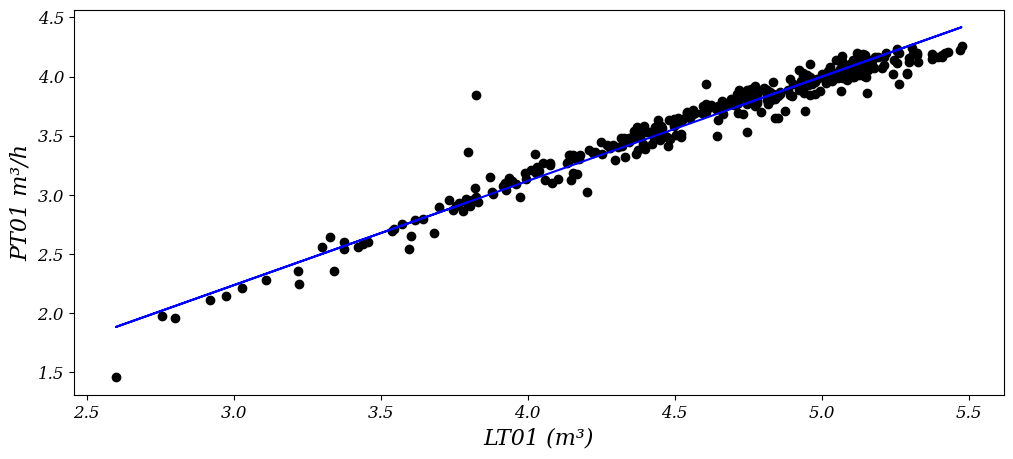

In [159]:
my_lm = LinearRegression()
lm_trn = my_lm.fit(X =endog_l_trn, y = endog_trn)
lm_vld = my_lm.fit(X =endog_l_vld, y = endog_vld)
lm_tst = my_lm.fit(X =endog_l_tst, y = endog_tst)
lm = my_lm.fit(X =endog_l, y = endog)
lr_trn = lm_trn.predict(endog_l_trn)
lr_vld = lm_vld.predict(endog_l_vld)
lr_tst = lm_tst.predict(endog_l_tst)
lr = lm_tst.predict(endog_l)

plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.scatter(endog_l_tst, endog_tst, color = 'black')
plt.plot(endog_l_tst, lr_tst, 'b')
plt.xlabel(f'{rt}',fontsize = 16)
plt.ylabel(f'PT01 m³/h',fontsize = 16)
plt.savefig(f"LR {rt}.png", dpi=1000)
plt.show()



Coeficiente R²: 0.3062


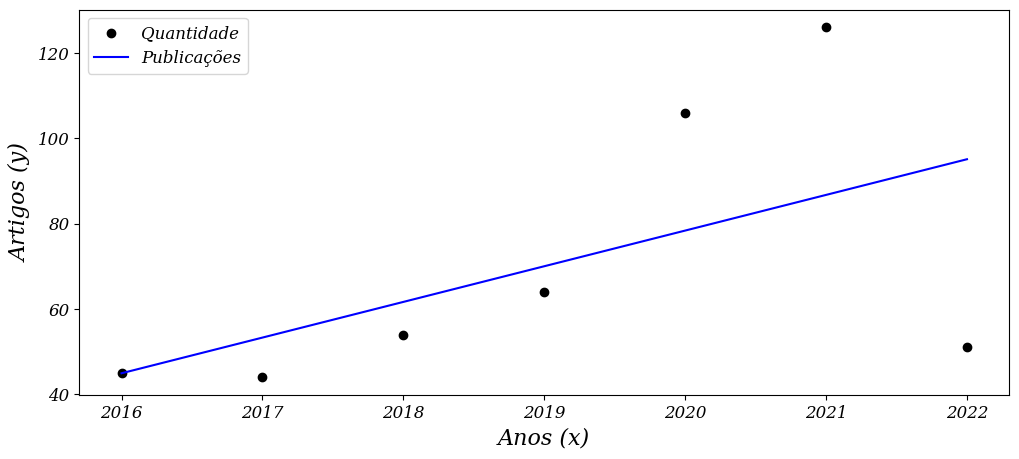

In [160]:
rg = pd.read_csv('regressão linear.csv', sep = ';')
# rg.set_index('Ano', inplace = True)

X = rg[['Ano']]
Y = rg['quantidade de artigo']

rg1 = my_lm.fit(X, Y)
reg = rg1.predict(X)

r_squared = r2_score(Y, reg)
print(f'Coeficiente R²: {r_squared:2.4f}')

plt.figure(figsize = (12,5))
font = {'family' : 'serif',
        'style' : 'oblique',
        'size'   : 12}
plt.rc('font', **font)
plt.scatter(X, Y, color = 'black')
plt.plot(X, reg, 'b')
plt.xlabel('Anos (x)',fontsize = 16)
plt.ylabel('Artigos (y)',fontsize = 16)
plt.legend(['Quantidade', 'Publicações'], loc='upper left')
plt.savefig("regressão linear dos artigos baseados nos anos.pdf", dpi=500)
plt.show()

# Optuna

In [161]:
# import optuna

# def objective(trial):
#     x = trial.suggest_float('x', -10, 10)
#     return (x - 2) ** 2

# study = optuna.create_study()
# study.optimize(objective, n_trials=100)

# study.best_params  # E.g. {'x': 2.002108042}

In [162]:
# opt = BayesSearchCV(
#     XGBRegressor(),
#        {'C': Real(1e-6, 1e+6, prior='log-uniform'),
#        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#        'degree': Integer(1,20),
#        'kernel': Categorical(['linear', 'poly', 'rbf']),
#        },
#        n_iter=52,
#        random_state=0)
# crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100

In [163]:
# opt = XGBRegressor()
# crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100

In [164]:

# opt.fit(exog_trn, endog_trn)

In [165]:
# opt = BayesSearchCV(
#     LGBMRegressor(),
#        {'C': Real(1e-6, 1e+6, prior='log-uniform'),
#        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#        'degree': Integer(1,8),
#        'kernel': Categorical(['linear', 'poly', 'rbf']),
#        },
#        n_iter=32,
#        random_state=0)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100

In [166]:
# from sklearn.model_selection import RandomizedSearchCV

# param_space = {"bootstrap": [True],
#         "max_depth": [6, 8, 10, 12, 14],
#         "max_features": ['auto', 'sqrt','log2'],
#         "min_samples_leaf": [2, 3, 4],
#         "min_samples_split": [2, 3, 4, 5],
#         "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# }

# opt = RandomizedSearchCV(XGBRegressor(), param_space, n_iter=32,
#                                         scoring="accuracy", verbose=True, cv=5,
#                                         n_jobs=-1, random_state=42)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'r2').mean()*100

# Grid

In [167]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'bootstrap': [True],
#      'max_depth': [2, 500],
#      'max_features': ['auto', 'sqrt', 'log2'],
#      'min_samples_leaf': [2, 40],
#      'min_samples_split': [2, 40],
#      'n_estimators': [100,5650]
#     }
     

# forest_clf = XGBRegressor()

# opt = GridSearchCV(my_xgb, param_grid, cv=30,
#                                   scoring="neg_mean_absolute_percentage_error",
#                                   return_train_score=True,
#                                   verbose=True,
#                                   n_jobs=-1)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

# # melhor otimização xgb


In [168]:
# print(opt.best_params_)


In [169]:
# print(opt.best_estimator_)


In [170]:
# print(opt.best_score_)

In [171]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'bootstrap': [True],
#      'max_depth': [2, 500],
#      'max_features': ['auto', 'sqrt', 'log2'],
#      'min_samples_leaf': [2, 40],
#      'min_samples_split': [2, 40],
#      'n_estimators': [100,5650]
#     }
     


# opt = GridSearchCV(my_lgbm, param_grid, cv=30,
#                                   scoring="neg_mean_absolute_percentage_error",
#                                   return_train_score=True,
#                                   verbose=True,
#                                   n_jobs=-1)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100


In [172]:
# print(opt.best_params_)

In [173]:
# print(opt.best_estimator_)

In [174]:
# print(opt.best_score_)

In [175]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'bootstrap': [True],
#      'max_depth': [2, 500],
#      'max_features': ['auto', 'sqrt', 'log2'],
#      'min_samples_leaf': [2, 40],
#      'min_samples_split': [2, 40],
#      'n_estimators': [100,5650]
#     }
     



# opt = GridSearchCV(my_rf, param_grid, cv=6,
#                                   scoring="neg_mean_absolute_percentage_error",
#                                   return_train_score=True,
#                                   verbose=True,
#                                   n_jobs=-1)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100


In [176]:
# print(opt.best_params_)

In [177]:
# print(opt.best_estimator_)

In [178]:
# print(opt.best_score_)

# Randomizer

In [179]:
# param_space = {"bootstrap": [True],
#         "max_depth": [6, 8, 10, 12, 14],
#         "max_features": ['auto', 'sqrt','log2'],
#         "min_samples_leaf": [2, 3, 4],
#         "min_samples_split": [2, 3, 4, 5],
#         "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# }

# opt = RandomizedSearchCV(my_xgb, param_space, n_iter=32,
#                                         scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#                                         n_jobs=-1, random_state=122)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)


In [180]:
# print(opt.best_params_)


In [181]:
# print(opt.best_estimator_)


In [182]:
# print(opt.best_score_)


In [183]:
# param_space = {"bootstrap": [True],
#         "max_depth": [6, 8, 10, 12, 14],
#         "max_features": ['auto', 'sqrt','log2'],
#         "min_samples_leaf": [2, 3, 4],
#         "min_samples_split": [2, 3, 4, 5],
#         "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# }

# opt = RandomizedSearchCV(my_lgbm, param_space, n_iter=32,
#                                         scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#                                         n_jobs=-1, random_state=122)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)

In [184]:
# print(opt.best_params_)

In [185]:
# print(opt.best_estimator_)

In [186]:
# print(opt.best_score_*100)

In [187]:
# param_space = {"bootstrap": [True],
#         "max_depth": [6, 8, 10, 12, 14],
#         "max_features": ['auto', 'sqrt','log2'],
#         "min_samples_leaf": [2, 3, 4],
#         "min_samples_split": [2, 3, 4, 5],
#         "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# }

# opt = RandomizedSearchCV(my_rf, param_space, n_iter=32,
#                                         scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#                                         n_jobs=-1, random_state=122)

# opt.fit(exog_trn, endog_trn)

# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)

# #melhor otimização rf


In [188]:
# print(opt.best_params_)


In [189]:
# print(opt.best_estimator_)


In [190]:
# print(opt.best_score_)


# Bayes

In [191]:
# opt = BayesSearchCV(
#     LGBMRegressor(),
#        {'C': Real(1e-6, 1e+6, prior='log-uniform'),
#        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#        'degree': Integer(1,8),
#        'kernel': Categorical(['linear', 'poly', 'rbf']),
#        },
#        n_iter=32,
#        random_state=0)

# opt.fit(exog_trn, endog_trn)

# crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

In [192]:

# search_space = {'C': Real(1e-6, 1e+6, prior='log-uniform'),
#        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#        'degree': Integer(1,8),
#        'kernel': Categorical(['linear', 'poly', 'rbf']),
#        "bootstrap": Categorical([True, False]), 
#         "max_depth": Integer(6, 40), 
#         "max_features": Categorical(['auto', 'sqrt','log2']), 
#         "min_samples_leaf": Integer(2, 30),
#         "min_samples_split": Integer(2,20),
#         "n_estimators": Integer(5, 200)
#        }

# opt = BayesSearchCV(my_xgb, search_space, 
#        n_iter=32, scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#        random_state=122)
       
# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)


In [193]:

# search_space = {"bootstrap": Categorical([True, False]), 
#         "max_depth": Integer(6, 40), 
#         "max_features": Categorical(['auto', 'sqrt','log2']), 
#         "min_samples_leaf": Integer(2, 30),
#         "min_samples_split": Integer(2,20),
#         "n_estimators": Integer(50, 200)
#     }

# opt = BayesSearchCV(my_xgb, search_space, 
#        n_iter=32, scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#        random_state=122)
       
# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)


In [194]:

# search_space = {'C': Real(1e-6, 1e+6, prior='log-uniform'),
#        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
#        'degree': Integer(1,8),
#        'kernel': Categorical(['linear', 'poly', 'rbf']),
#        "bootstrap": Categorical([True, False]), 
#         "max_depth": Integer(6, 40), 
#         "max_features": Categorical(['auto', 'sqrt','log2']), 
#         "min_samples_leaf": Integer(2, 30),
#         "min_samples_split": Integer(2,20),
#         "n_estimators": Integer(50, 200)
#     }

# opt = BayesSearchCV(my_lgbm, search_space, 
#        n_iter=32, scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#        random_state=122)
       
# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)


In [195]:

# search_space = {"bootstrap": Categorical([True, False]), 
#        "max_depth": Integer(6, 40), 
#        "max_features": Categorical(['auto', 'sqrt','log2']), 
#        "min_samples_leaf": Integer(2, 30),
#        "min_samples_split": Integer(2,20),
#        "n_estimators": Integer(50, 200)
#     }

# opt = BayesSearchCV(my_rf, search_space, 
#        n_iter=32, scoring="neg_mean_absolute_percentage_error", verbose=True, cv=4,
#        random_state=122)
       
# print(crv(opt, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100)


# Cross Validation

In [196]:
# crv(my_xgb, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

In [197]:
# crv(my_lgbm, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

In [198]:
# crv(my_lm, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

In [199]:
# crv(my_rf, exog_trn, endog_trn, scoring = 'neg_mean_absolute_percentage_error').mean()*100

#  Comparação Modelos Violino

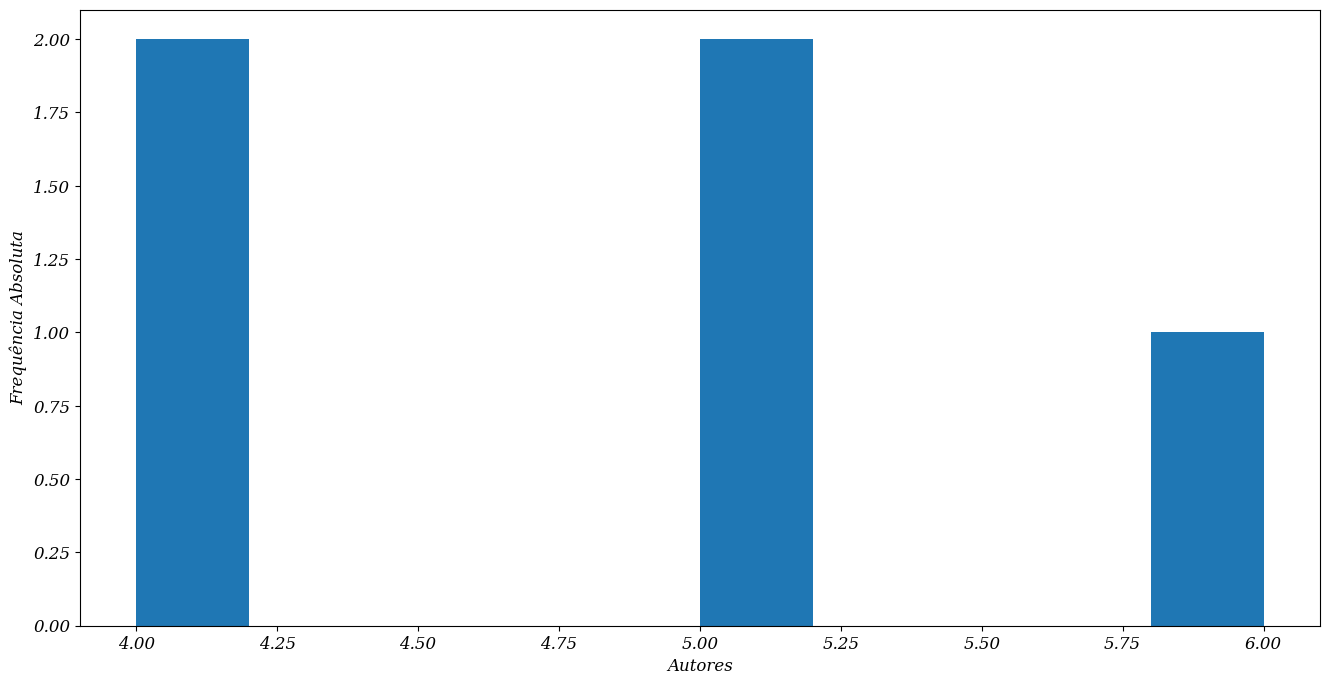

In [200]:
artigos=[6,5,5,4,4]
plt.xlabel('Autores')
plt.ylabel('Frequência Absoluta')
plt.hist(artigos)
plt.show()

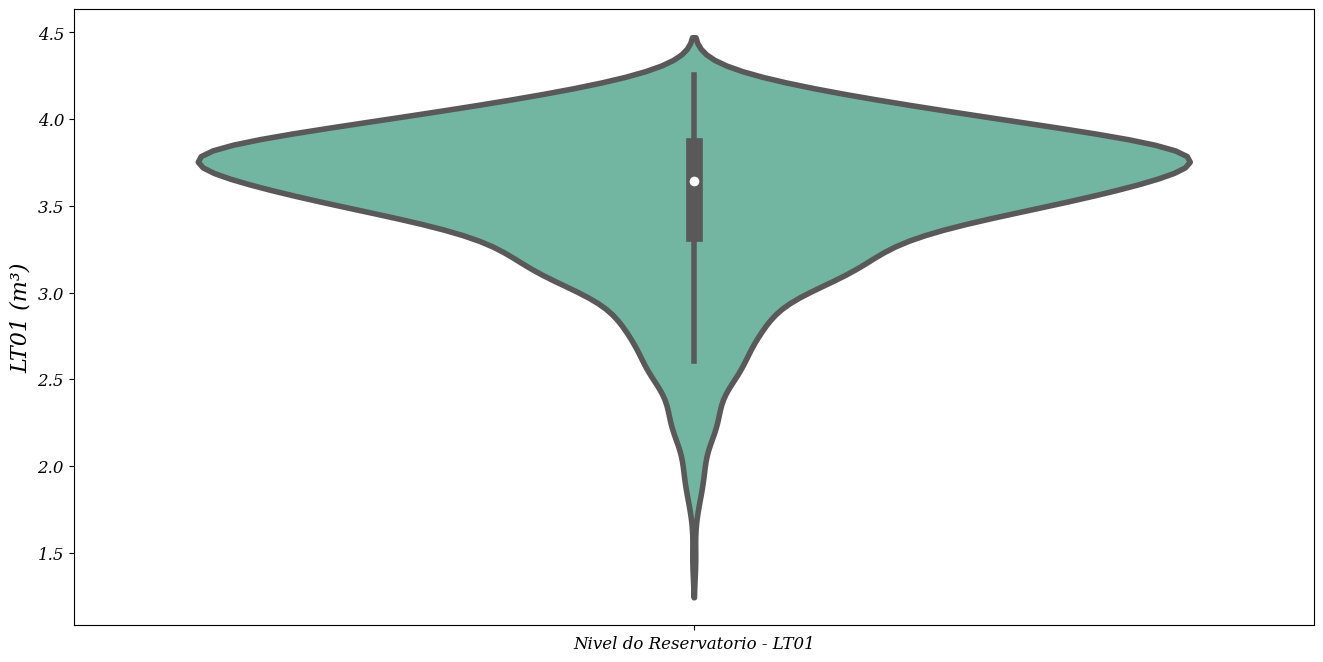

In [201]:
sns.violinplot(data = df['NIVEL DO RESERVATÓRIO - LT01'], linewidth = 4, palette="Set2")
x = [0]
labels = ['Nivel do Reservatorio - LT01']

plt.xticks(x, labels)
plt.ylabel(rt , fontsize = 16)
plt.savefig(f"viol.pdf", dpi=500)
plt.show()

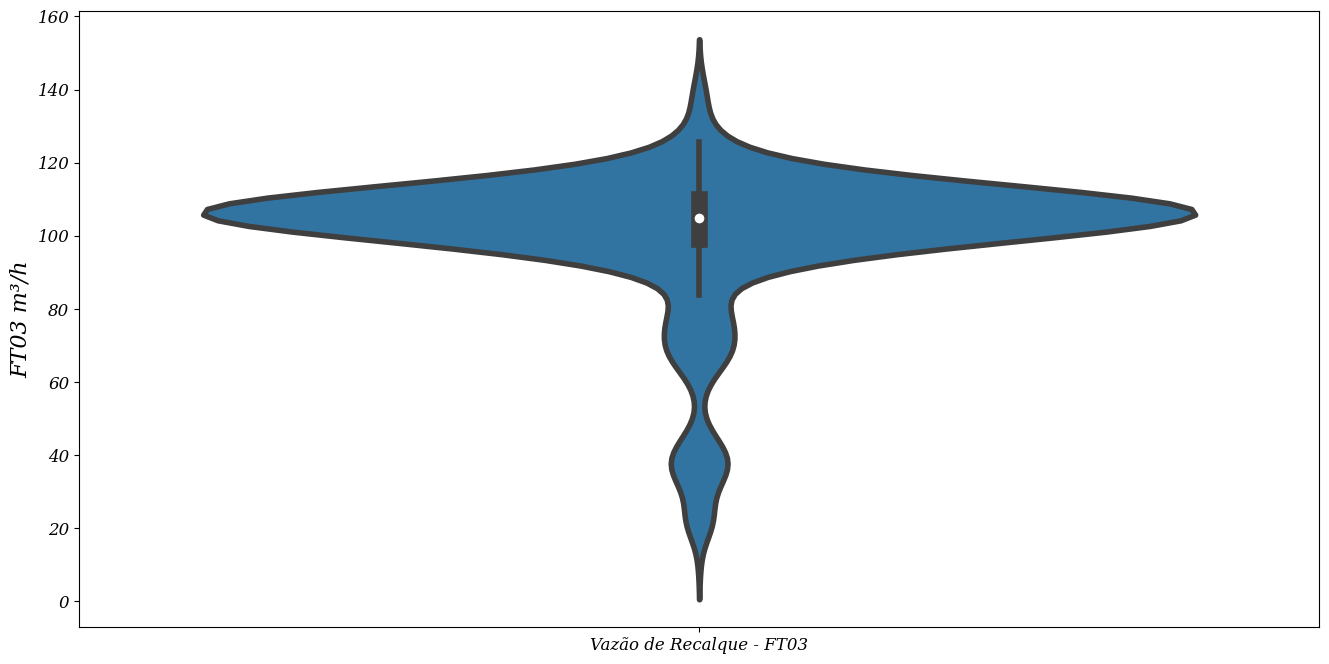

In [202]:
sns.violinplot(data = df['VAZÃO DE RECALQUE - FT03'],linewidth = 4)
x = [0]
labels = ['Vazão de Recalque - FT03']
plt.xticks(x, labels)
plt.ylabel('FT03 m³/h' , fontsize = 16)
plt.savefig(f"ft03.pdf", dpi=500)
plt.show()

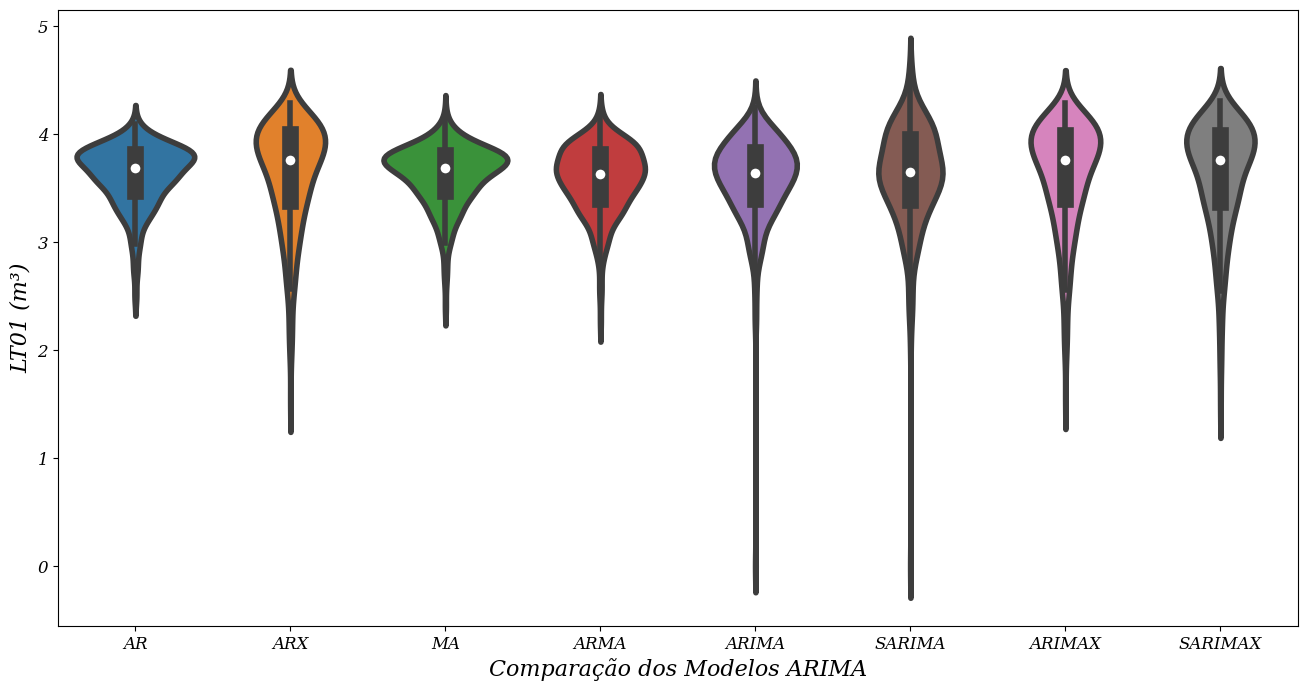

In [203]:
sns.violinplot(data = [ar_tst, arx_tst, ma_tst, arma_tst, arima_tst, sarima_tst, arimax_tst, sarimax_tst], 
               linewidth = 4)
x = [0,1,2,3,4,5,6,7]
labels = ['AR', 'ARX', 'MA', 'ARMA', 'ARIMA', 'SARIMA', 'ARIMAX', 'SARIMAX']
plt.xticks(x, labels)
plt.ylabel(rt , fontsize = 16)
plt.xlabel('Comparação dos Modelos ARIMA', fontsize = 16)
plt.savefig(f"{pv}-modelos-arima.pdf", dpi=500)
plt.show()

# Redes neurais

## LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1200)              5769600   
                                                                 
 dense (Dense)               (None, 613)               736213    
                                                                 
Total params: 6,505,813
Trainable params: 6,505,813
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
16/16 [==============================] - 5s 109ms/step - loss: 1.4959 - mean_absolute_error: 1.4959 - val_loss: 0.7724 - val_mean_absolute_error: 0.7724
Epoch 2/5
16/16 [==============================] - 1s 53ms/step - loss: 0.3658 - mean_absolute_error: 0.3658 - val_loss: 0.1315 - val_mean_absolute_error: 0.1315
Epoch 3/5
16/16 [==============================] - 1s 56ms/step - loss: 0.1968 - mean_absolute_error: 0.1968 - val_lo

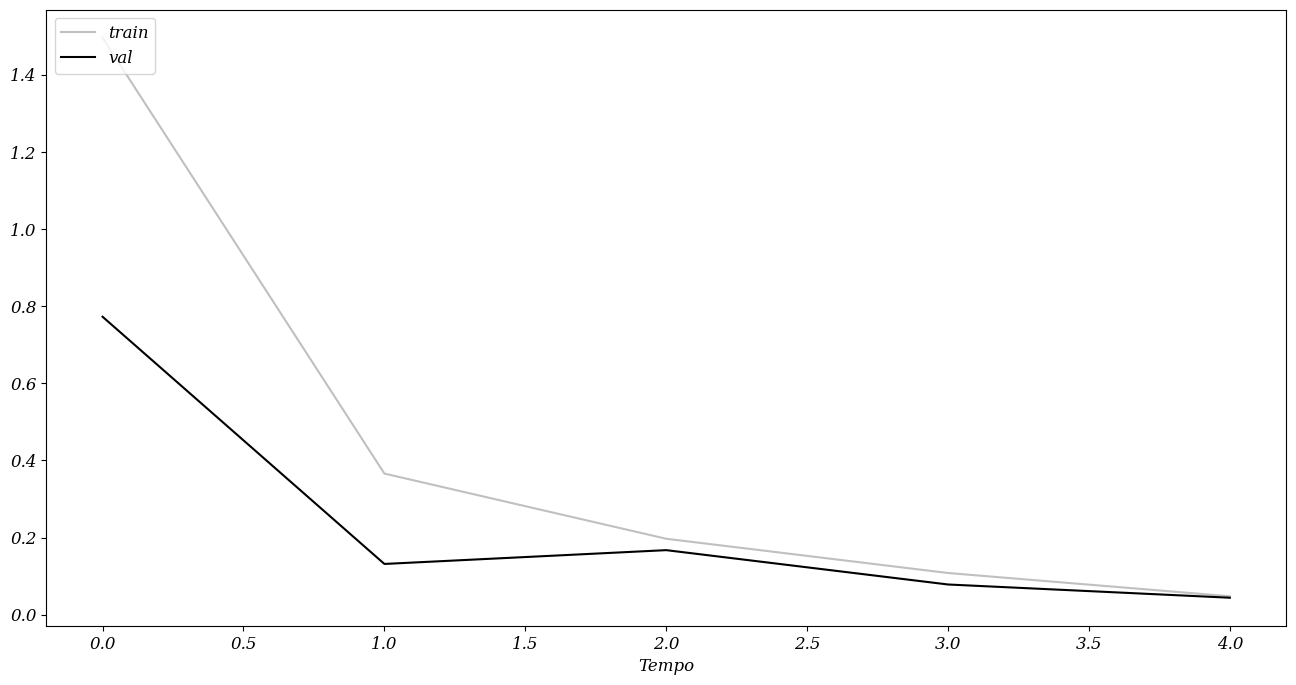

In [204]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

n_samples = endog_trn.shape[0]
n_timesteps = endog_trn.shape[0]
n_steps = endog_trn.shape[0]
n_features = 1

# endog_trn_rs = endog_trn.reshape(n_samples, n_timesteps, n_features )
# endog_tst_rs = endog_tst.reshape(endog_tst.shape[0], n_timesteps, n_features )

random.seed(42)
batch_size = 32
simple_model = Sequential([LSTM(1200, activation='tanh',input_shape=(n_timesteps, n_features)),Dense(endog_trn.shape[0])])
simple_model.summary()
simple_model.compile(
optimizer=keras.optimizers.Adam(learning_rate=0.01),
loss='mean_absolute_error',
metrics=['mean_absolute_error'],
)
smod_history = simple_model.fit(endog_trn, endog_trn,
                                validation_split=0.2,
                                epochs=5,
                                batch_size=batch_size,
                                shuffle = True)
                                
preds = simple_model.predict(endog_tst+pv)
# print(mean_absolute_error(preds, endog_tst))
plt.plot(smod_history.history['loss'], 'silver')
plt.plot(smod_history.history['val_loss'], 'black')
plt.xlabel('Tempo')
plt.legend(['train', 'val'], loc='upper left')
plt.show()




# Salva Erro


1 dia à frente

In [266]:

pd.options.display.float_format = "{:.3f}".format
sarimax_erro = pd.DataFrame(
    {
        'sMAPE':[ smape_AR_trn, smape_ARX_trn, smape_MA_trn ,smape_ARMA_trn, 
        smape_ARIMA_trn,smape_SARIMA_trn, smape_arimax_trn,smape_sarimax_trn, smape_lr_trn, smape_rf_trn, smape_xgb_trn, 
        smape_lgbm_trn],
        'MAE':[ mae_AR_trn, mae_ARX_trn, mae_MA_trn, mae_ARMA_trn,mae_ARIMA_trn,
        mae_SARIMA_trn, mae_arimax_trn, mae_sarimax_trn, mae_lr_trn, mae_rf_trn, mae_xgb_trn, mae_lgbm_trn],
        'RRMSE':[ rrmse_AR_trn, rrmse_ARX_trn, rrmse_MA_trn, rrmse_ARMA_trn,rrmse_ARIMA_trn,
        rrmse_SARIMA_trn,rrmse_arimax_trn, rrmse_sarimax_trn, rrmse_lr_trn, rrmse_rf_trn, rrmse_xgb_trn, rrmse_lgbm_trn],
},
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA', f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_erro.to_excel(pvl+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros treino.xlsx')
print(sarimax_erro)


pd.options.display.float_format = "{:.3f}".format
sarimax_erro = pd.DataFrame(
    {
        'sMAPE':[ smape_AR_tst, smape_ARX_tst, smape_MA_tst ,smape_ARMA_tst, 
        smape_ARIMA_tst,smape_SARIMA_tst, smape_arimax_tst,smape_sarimax_tst, smape_lr_tst, smape_rf_tst, smape_xgb_tst, 
        smape_lgbm_tst],
        'MAE':[ mae_AR_tst, mae_ARX_tst, mae_MA_tst, mae_ARMA_tst,mae_ARIMA_tst,
        mae_SARIMA_tst, mae_arimax_tst, mae_sarimax_tst, mae_lr_tst, mae_rf_tst, mae_xgb_tst, mae_lgbm_tst],
        'RRMSE':[ rrmse_AR_tst, rrmse_ARX_tst, rrmse_MA_tst, rrmse_ARMA_tst,rrmse_ARIMA_tst,
        rrmse_SARIMA_tst,rrmse_arimax_tst, rrmse_sarimax_tst, rrmse_lr_tst, rrmse_rf_tst, rrmse_xgb_tst, rrmse_lgbm_tst],
},
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA', f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_erro.to_excel(pvl+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros test.xlsx')
print(sarimax_erro)


pd.options.display.float_format = "{:.3f}".format
sarimax_erro = pd.DataFrame(
    {
        'sMAPE':[ smape_AR_vld, smape_ARX_vld, smape_MA_vld ,smape_ARMA_vld, 
        smape_ARIMA_vld,smape_SARIMA_vld, smape_arimax_vld,smape_sarimax_vld, smape_lr_vld, smape_rf_vld, smape_xgb_vld, 
        smape_lgbm_vld],
        'MAE':[ mae_AR_vld, mae_ARX_vld, mae_MA_vld, mae_ARMA_vld,mae_ARIMA_vld,
        mae_SARIMA_vld, mae_arimax_vld, mae_sarimax_vld, mae_lr_vld, mae_rf_vld, mae_xgb_vld, mae_lgbm_vld],
        'RRMSE':[ rrmse_AR_vld, rrmse_ARX_vld, rrmse_MA_vld, rrmse_ARMA_vld,rrmse_ARIMA_vld,
        rrmse_SARIMA_vld,rrmse_arimax_vld, rrmse_sarimax_vld, rrmse_lr_vld, rrmse_rf_vld, rrmse_xgb_vld, rrmse_lgbm_vld],
},
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA', f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_erro.to_excel(pvl+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros validação.xlsx')
print(sarimax_erro)


pd.options.display.float_format = "{:.3f}".format
sarimax_erro = pd.DataFrame(
    {
        "sMAPE": [AR_smape, ARX_smape, MA_smape, ARMA_smape, ARIMA_smape, SARIMA_smape, arimax_smape, sarimax_smape, smape_lr, smape_rf,
         smape_xgb, smape_lgbm],


        "MAE": [AR_mae, ARX_mae, MA_mae, ARMA_mae, ARIMA_mae, SARIMA_mae, arimax_mae, sarimax_mae, mae_lr, mae_rf, mae_xgb, mae_lgbm],


        'RRMSE': [ AR_rrmse, ARX_rrmse, MA_rrmse ,ARMA_rrmse, ARIMA_rrmse, SARIMA_rrmse, arimax_rrmse, sarimax_rrmse, rrmse_lr, rrmse_rf, 
        rrmse_xgb, rrmse_lgbm],


    },
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', 
      f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_erro.to_excel(pvl+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros todo.xlsx')
sarimax_erro



                         sMAPE   MAE  RRMSE
AR                       4.559 0.306  0.120
ARX                      5.743 0.377  0.147
MA                       4.421 0.296  0.115
ARMA                     4.837 0.325  0.125
ARIMA                    4.496 0.302  0.116
SARIMA                   5.088 0.342  0.129
ARIMAX                   5.746 0.378  0.146
SARIMAX                  5.734 0.377  0.147
Linear Regression        5.440 0.069  0.139
Random Forest Regressor  8.477 0.622  0.192
XGBRegressor             9.196 0.683  0.206
LGBMRegressor            8.207 0.599  0.187
                         sMAPE   MAE  RRMSE
AR                       4.748 0.329  0.117
ARX                      6.694 0.462  0.162
MA                       4.862 0.336  0.119
ARMA                     4.920 0.340  0.119
ARIMA                    4.982 0.346  0.122
SARIMA                   5.681 0.398  0.138
ARIMAX                   6.690 0.461  0.162
SARIMAX                  6.742 0.464  0.163
Linear Regression        6.789 0

sMAPE   MAE  RRMSE
AR                       4.436 0.302  0.115
ARX                      5.980 0.402  0.150
MA                       4.434 0.302  0.114
ARMA                     4.629 0.316  0.120
ARIMA                    4.461 0.303  0.115
SARIMA                   5.118 0.350  0.126
ARIMAX                   5.865 0.394  0.147
SARIMAX                  5.960 0.401  0.150
Linear Regression        5.788 0.074  0.145
Random Forest Regressor  7.868 0.578  0.180
XGBRegressor             8.628 0.643  0.196
LGBMRegressor            7.586 0.554  0.176

7 dias à frente

In [267]:

pd.options.display.float_format = "{:.3f}".format
sarimax_7_erro = pd.DataFrame(
    {
        'sMAPE':[ smape_AR_7_trn, smape_ARX_7_trn, smape_MA_7_trn ,smape_ARMA_7_trn, 
        smape_ARIMA_7_trn,smape_SARIMA_7_trn, smape_arimax_7_trn,smape_sarimax_7_trn, smape_lr_7_trn, smape_rf_7_trn, smape_xgb_7_trn, 
        smape_lgbm_trn],
        'MAE':[ mae_AR_7_trn, mae_ARX_7_trn, mae_MA_7_trn, mae_ARMA_7_trn,mae_ARIMA_7_trn,
        mae_SARIMA_7_trn, mae_arimax_7_trn, mae_sarimax_7_trn, mae_lr_7_trn, mae_rf_7_trn, mae_xgb_7_trn, mae_lgbm_trn],
        'RRMSE':[ rrmse_AR_7_trn, rrmse_ARX_7_trn, rrmse_MA_7_trn, rrmse_ARMA_7_trn,rrmse_ARIMA_7_trn,
        rrmse_SARIMA_7_trn,rrmse_arimax_7_trn, rrmse_sarimax_7_trn, rrmse_lr_7_trn, rrmse_rf_7_trn, rrmse_xgb_7_trn, rrmse_lgbm_trn],
},
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA', f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_7_erro.to_excel(pvl_7+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros treino.xlsx')
print(sarimax_7_erro)


pd.options.display.float_format = "{:.3f}".format
sarimax_7_erro = pd.DataFrame(
    {
        'sMAPE':[ smape_AR_7_tst, smape_ARX_7_tst, smape_MA_7_tst ,smape_ARMA_7_tst, 
        smape_ARIMA_7_tst,smape_SARIMA_7_tst, smape_arimax_7_tst,smape_sarimax_7_tst, smape_lr_7_tst, smape_rf_7_tst, smape_xgb_7_tst, 
        smape_lgbm_tst],
        'MAE':[ mae_AR_7_tst, mae_ARX_7_tst, mae_MA_7_tst, mae_ARMA_7_tst,mae_ARIMA_7_tst,
        mae_SARIMA_7_tst, mae_arimax_7_tst, mae_sarimax_7_tst, mae_lr_7_tst, mae_rf_7_tst, mae_xgb_7_tst, mae_lgbm_tst],
        'RRMSE':[ rrmse_AR_7_tst, rrmse_ARX_7_tst, rrmse_MA_7_tst, rrmse_ARMA_7_tst,rrmse_ARIMA_7_tst,
        rrmse_SARIMA_7_tst,rrmse_arimax_7_tst, rrmse_sarimax_7_tst, rrmse_lr_7_tst, rrmse_rf_7_tst, rrmse_xgb_7_tst, rrmse_lgbm_tst],
},
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA', f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_7_erro.to_excel(pvl_7+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros test.xlsx')
print(sarimax_7_erro)


pd.options.display.float_format = "{:.3f}".format
sarimax_7_erro = pd.DataFrame(
    {
        'sMAPE':[ smape_AR_7_vld, smape_ARX_7_vld, smape_MA_7_vld ,smape_ARMA_7_vld, 
        smape_ARIMA_7_vld,smape_SARIMA_7_vld, smape_arimax_7_vld,smape_sarimax_7_vld, smape_lr_7_vld, smape_rf_7_vld, smape_xgb_7_vld, 
        smape_lgbm_vld],
        'MAE':[ mae_AR_7_vld, mae_ARX_7_vld, mae_MA_7_vld, mae_ARMA_7_vld,mae_ARIMA_7_vld,
        mae_SARIMA_7_vld, mae_arimax_7_vld, mae_sarimax_7_vld, mae_lr_7_vld, mae_rf_7_vld, mae_xgb_7_vld, mae_lgbm_vld],
        'RRMSE':[ rrmse_AR_7_vld, rrmse_ARX_7_vld, rrmse_MA_7_vld, rrmse_ARMA_7_vld,rrmse_ARIMA_7_vld,
        rrmse_SARIMA_7_vld,rrmse_arimax_7_vld, rrmse_sarimax_7_vld, rrmse_lr_7_vld, rrmse_rf_7_vld, rrmse_xgb_7_vld, rrmse_lgbm_vld],
},
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA', f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_7_erro.to_excel(pvl_7+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros validação.xlsx')
print(sarimax_7_erro)


pd.options.display.float_format = "{:.3f}".format
sarimax_7_erro = pd.DataFrame(
    {
        "sMAPE": [AR_7_smape, ARX_7_smape, MA_7_smape, ARMA_7_smape, ARIMA_7_smape, SARIMA_7_smape, arimax_7_smape, sarimax_7_smape, smape_lr_7, smape_rf_7,
         smape_xgb_7, smape_lgbm_7],


        "MAE": [AR_7_mae, ARX_7_mae, MA_7_mae, ARMA_7_mae, ARIMA_7_mae, SARIMA_7_mae, arimax_7_mae, sarimax_7_mae, mae_lr_7, mae_rf_7, mae_xgb_7, mae_lgbm_7],


        'RRMSE': [ AR_7_rrmse, ARX_7_rrmse, MA_7_rrmse ,ARMA_7_rrmse, ARIMA_7_rrmse, SARIMA_7_rrmse, arimax_7_rrmse, sarimax_7_rrmse, rrmse_lr_7, rrmse_rf_7, 
        rrmse_xgb_7, rrmse_lgbm_7],


    },
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', 
      f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_7_erro.to_excel(pvl_7+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros todo.xlsx')
sarimax_7_erro



                         sMAPE   MAE  RRMSE
AR                       4.458 0.296  0.114
ARX                      5.737 0.377  0.150
MA                       4.947 0.329  0.127
ARMA                     4.947 0.330  0.125
ARIMA                    5.129 0.342  0.132
SARIMA                   5.379 0.360  0.139
ARIMAX                   5.760 0.379  0.150
SARIMAX                  5.763 0.379  0.150
Linear Regression       37.192 5.230  1.187
Random Forest Regressor  9.483 0.702  0.234
XGBRegressor            10.883 0.823  0.267
LGBMRegressor            8.207 0.599  0.187
                         sMAPE   MAE  RRMSE
AR                       5.536 0.383  0.138
ARX                      7.015 0.479  0.174
MA                       5.804 0.403  0.146
ARMA                     5.582 0.384  0.136
ARIMA                    5.702 0.393  0.139
SARIMA                   6.283 0.437  0.150
ARIMAX                   7.026 0.480  0.174
SARIMAX                  7.048 0.481  0.176
Linear Regression       36.406 5

sMAPE   MAE  RRMSE
AR                       4.666 0.316  0.119
ARX                      6.059 0.406  0.156
MA                       5.144 0.350  0.132
ARMA                     4.612 0.312  0.118
ARIMA                    4.635 0.314  0.119
SARIMA                   5.657 0.386  0.143
ARIMAX                   5.991 0.402  0.154
SARIMAX                  6.040 0.405  0.155
Linear Regression       36.909 5.224  1.174
Random Forest Regressor  8.813 0.653  0.221
XGBRegressor            10.215 0.775  0.254
LGBMRegressor            8.462 0.623  0.214

14 dias à frente

In [268]:

pd.options.display.float_format = "{:.3f}".format
sarimax_14_erro = pd.DataFrame(
    {
        'sMAPE':[ smape_AR_14_trn, smape_ARX_14_trn, smape_MA_14_trn ,smape_ARMA_14_trn, 
        smape_ARIMA_14_trn,smape_SARIMA_14_trn, smape_arimax_14_trn,smape_sarimax_14_trn, smape_lr_14_trn, smape_rf_14_trn, smape_xgb_14_trn, 
        smape_lgbm_trn],
        'MAE':[ mae_AR_14_trn, mae_ARX_14_trn, mae_MA_14_trn, mae_ARMA_14_trn,mae_ARIMA_14_trn,
        mae_SARIMA_14_trn, mae_arimax_14_trn, mae_sarimax_14_trn, mae_lr_14_trn, mae_rf_14_trn, mae_xgb_14_trn, mae_lgbm_trn],
        'RRMSE':[ rrmse_AR_14_trn, rrmse_ARX_14_trn, rrmse_MA_14_trn, rrmse_ARMA_14_trn,rrmse_ARIMA_14_trn,
        rrmse_SARIMA_14_trn,rrmse_arimax_14_trn, rrmse_sarimax_14_trn, rrmse_lr_14_trn, rrmse_rf_14_trn, rrmse_xgb_14_trn, rrmse_lgbm_trn],
},
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA', f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_14_erro.to_excel(pvl_14+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros treino.xlsx')
print(sarimax_14_erro)


pd.options.display.float_format = "{:.3f}".format
sarimax_14_erro = pd.DataFrame(
    {
        'sMAPE':[ smape_AR_14_tst, smape_ARX_14_tst, smape_MA_14_tst ,smape_ARMA_14_tst, 
        smape_ARIMA_14_tst,smape_SARIMA_14_tst, smape_arimax_14_tst,smape_sarimax_14_tst, smape_lr_14_tst, smape_rf_14_tst, smape_xgb_14_tst, 
        smape_lgbm_tst],
        'MAE':[ mae_AR_14_tst, mae_ARX_14_tst, mae_MA_14_tst, mae_ARMA_14_tst,mae_ARIMA_14_tst,
        mae_SARIMA_14_tst, mae_arimax_14_tst, mae_sarimax_14_tst, mae_lr_14_tst, mae_rf_14_tst, mae_xgb_14_tst, mae_lgbm_tst],
        'RRMSE':[ rrmse_AR_14_tst, rrmse_ARX_14_tst, rrmse_MA_14_tst, rrmse_ARMA_14_tst,rrmse_ARIMA_14_tst,
        rrmse_SARIMA_14_tst,rrmse_arimax_14_tst, rrmse_sarimax_14_tst, rrmse_lr_14_tst, rrmse_rf_14_tst, rrmse_xgb_14_tst, rrmse_lgbm_tst],
},
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA', f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_14_erro.to_excel(pvl_14+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros test.xlsx')
print(sarimax_14_erro)


pd.options.display.float_format = "{:.3f}".format
sarimax_14_erro = pd.DataFrame(
    {
        'sMAPE':[ smape_AR_14_vld, smape_ARX_14_vld, smape_MA_14_vld ,smape_ARMA_14_vld, 
        smape_ARIMA_14_vld,smape_SARIMA_14_vld, smape_arimax_14_vld,smape_sarimax_14_vld, smape_lr_14_vld, smape_rf_14_vld, smape_xgb_14_vld, 
        smape_lgbm_vld],
        'MAE':[ mae_AR_14_vld, mae_ARX_14_vld, mae_MA_14_vld, mae_ARMA_14_vld,mae_ARIMA_14_vld,
        mae_SARIMA_14_vld, mae_arimax_14_vld, mae_sarimax_14_vld, mae_lr_14_vld, mae_rf_14_vld, mae_xgb_14_vld, mae_lgbm_vld],
        'RRMSE':[ rrmse_AR_14_vld, rrmse_ARX_14_vld, rrmse_MA_14_vld, rrmse_ARMA_14_vld,rrmse_ARIMA_14_vld,
        rrmse_SARIMA_14_vld,rrmse_arimax_14_vld, rrmse_sarimax_14_vld, rrmse_lr_14_vld, rrmse_rf_14_vld, rrmse_xgb_14_vld, rrmse_lgbm_vld],
},
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA', f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_14_erro.to_excel(pvl_14+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros validação.xlsx')
print(sarimax_14_erro)



pd.options.display.float_format = "{:.3f}".format
sarimax_14_erro = pd.DataFrame(
    {
        "sMAPE": [AR_14_smape, ARX_14_smape, MA_14_smape, ARMA_14_smape, ARIMA_14_smape, SARIMA_14_smape, arimax_14_smape, sarimax_14_smape, smape_lr_14, smape_rf_14,
         smape_xgb_14, smape_lgbm_14],


        "MAE": [AR_14_mae, ARX_14_mae, MA_14_mae, ARMA_14_mae, ARIMA_14_mae, SARIMA_14_mae, arimax_14_mae, sarimax_14_mae, mae_lr_14, mae_rf_14, mae_xgb_14, mae_lgbm_14],


        'RRMSE': [ AR_14_rrmse, ARX_14_rrmse, MA_14_rrmse ,ARMA_14_rrmse, ARIMA_14_rrmse, SARIMA_14_rrmse, arimax_14_rrmse, sarimax_14_rrmse, rrmse_lr_14, rrmse_rf_14, 
        rrmse_xgb_14, rrmse_lgbm_14],


    },
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', 
      f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_14_erro.to_excel(pvl_14+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros todo.xlsx')
sarimax_14_erro




                         sMAPE    MAE  RRMSE
AR                       5.016  0.334  0.127
ARX                      6.081  0.399  0.157
MA                       5.048  0.336  0.128
ARMA                     5.248  0.350  0.132
ARIMA                    5.282  0.353  0.137
SARIMA                   5.485  0.366  0.140
ARIMAX                   6.095  0.401  0.157
SARIMAX                  6.100  0.401  0.156
Linear Regression       56.295 11.394  2.573
Random Forest Regressor  9.479  0.701  0.234
XGBRegressor            11.284  0.859  0.275
LGBMRegressor            8.207  0.599  0.187
                         sMAPE    MAE  RRMSE
AR                       5.502  0.378  0.139
ARX                      5.743  0.384  0.155
MA                       5.606  0.385  0.141
ARMA                     5.059  0.344  0.128
ARIMA                    4.975  0.338  0.127
SARIMA                   5.335  0.364  0.137
ARIMAX                   5.733  0.384  0.155
SARIMAX                  5.720  0.383  0.154
Linear Reg

sMAPE    MAE  RRMSE
AR                       4.950  0.335  0.127
ARX                      5.923  0.393  0.154
MA                       5.002  0.339  0.128
ARMA                     4.616  0.311  0.119
ARIMA                    4.720  0.318  0.122
SARIMA                   5.387  0.365  0.139
ARIMAX                   5.858  0.389  0.152
SARIMAX                  5.909  0.393  0.153
Linear Regression       56.009 11.388  2.543
Random Forest Regressor  8.798  0.652  0.221
XGBRegressor            10.551  0.804  0.261
LGBMRegressor            8.457  0.623  0.214

30 dias à frente

In [269]:

pd.options.display.float_format = "{:.3f}".format
sarimax_30_erro = pd.DataFrame(
    {
        'sMAPE':[ smape_AR_30_trn, smape_ARX_30_trn, smape_MA_30_trn ,smape_ARMA_30_trn, 
        smape_ARIMA_30_trn,smape_SARIMA_30_trn, smape_arimax_30_trn,smape_sarimax_30_trn, smape_lr_30_trn, smape_rf_30_trn, smape_xgb_30_trn, 
        smape_lgbm_trn],
        'MAE':[ mae_AR_30_trn, mae_ARX_30_trn, mae_MA_30_trn, mae_ARMA_30_trn,mae_ARIMA_30_trn,
        mae_SARIMA_30_trn, mae_arimax_30_trn, mae_sarimax_30_trn, mae_lr_30_trn, mae_rf_30_trn, mae_xgb_30_trn, mae_lgbm_trn],
        'RRMSE':[ rrmse_AR_30_trn, rrmse_ARX_30_trn, rrmse_MA_30_trn, rrmse_ARMA_30_trn,rrmse_ARIMA_30_trn,
        rrmse_SARIMA_30_trn,rrmse_arimax_30_trn, rrmse_sarimax_30_trn, rrmse_lr_30_trn, rrmse_rf_30_trn, rrmse_xgb_30_trn, rrmse_lgbm_trn],
},
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA', f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_30_erro.to_excel(pvl_30+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros treino.xlsx')
print(sarimax_30_erro)


pd.options.display.float_format = "{:.3f}".format
sarimax_30_erro = pd.DataFrame(
    {
        'sMAPE':[ smape_AR_30_tst, smape_ARX_30_tst, smape_MA_30_tst ,smape_ARMA_30_tst, 
        smape_ARIMA_30_tst,smape_SARIMA_30_tst, smape_arimax_30_tst,smape_sarimax_30_tst, smape_lr_30_tst, smape_rf_30_tst, smape_xgb_30_tst, 
        smape_lgbm_tst],
        'MAE':[ mae_AR_30_tst, mae_ARX_30_tst, mae_MA_30_tst, mae_ARMA_30_tst,mae_ARIMA_30_tst,
        mae_SARIMA_30_tst, mae_arimax_30_tst, mae_sarimax_30_tst, mae_lr_30_tst, mae_rf_30_tst, mae_xgb_30_tst, mae_lgbm_tst],
        'RRMSE':[ rrmse_AR_30_tst, rrmse_ARX_30_tst, rrmse_MA_30_tst, rrmse_ARMA_30_tst,rrmse_ARIMA_30_tst,
        rrmse_SARIMA_30_tst,rrmse_arimax_30_tst, rrmse_sarimax_30_tst, rrmse_lr_30_tst, rrmse_rf_30_tst, rrmse_xgb_30_tst, rrmse_lgbm_tst],
},
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA', f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_30_erro.to_excel(pvl_30+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros test.xlsx')
print(sarimax_30_erro)


pd.options.display.float_format = "{:.3f}".format
sarimax_30_erro = pd.DataFrame(
    {
        'sMAPE':[ smape_AR_30_vld, smape_ARX_30_vld, smape_MA_30_vld ,smape_ARMA_30_vld, 
        smape_ARIMA_30_vld,smape_SARIMA_30_vld, smape_arimax_30_vld,smape_sarimax_30_vld, smape_lr_30_vld, smape_rf_30_vld, smape_xgb_30_vld, 
        smape_lgbm_vld],
        'MAE':[ mae_AR_30_vld, mae_ARX_30_vld, mae_MA_30_vld, mae_ARMA_30_vld,mae_ARIMA_30_vld,
        mae_SARIMA_30_vld, mae_arimax_30_vld, mae_sarimax_30_vld, mae_lr_30_vld, mae_rf_30_vld, mae_xgb_30_vld, mae_lgbm_vld],
        'RRMSE':[ rrmse_AR_30_vld, rrmse_ARX_30_vld, rrmse_MA_30_vld, rrmse_ARMA_30_vld,rrmse_ARIMA_30_vld,
        rrmse_SARIMA_30_vld,rrmse_arimax_30_vld, rrmse_sarimax_30_vld, rrmse_lr_30_vld, rrmse_rf_30_vld, rrmse_xgb_30_vld, rrmse_lgbm_vld],
},
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA', f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_30_erro.to_excel(pvl_30+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros validação.xlsx')
print(sarimax_30_erro)


pd.options.display.float_format = "{:.3f}".format
sarimax_30_erro = pd.DataFrame(
    {
        "sMAPE": [AR_30_smape, ARX_30_smape, MA_30_smape, ARMA_30_smape, ARIMA_30_smape, SARIMA_30_smape, arimax_30_smape, sarimax_30_smape, smape_lr_30, smape_rf_30,
         smape_xgb_30, smape_lgbm_30],


        "MAE": [AR_30_mae, ARX_30_mae, MA_30_mae, ARMA_30_mae, ARIMA_30_mae, SARIMA_30_mae, arimax_30_mae, sarimax_30_mae, mae_lr_30, mae_rf_30, mae_xgb_30, mae_lgbm_30],


        'RRMSE': [ AR_30_rrmse, ARX_30_rrmse, MA_30_rrmse ,ARMA_30_rrmse, ARIMA_30_rrmse, SARIMA_30_rrmse, arimax_30_rrmse, sarimax_30_rrmse, rrmse_lr_30, rrmse_rf_30, 
        rrmse_xgb_30, rrmse_lgbm_30],


    },
    index=[f'AR', f'ARX', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX', f'Linear Regression', f'Random Forest Regressor', 
      f'XGBRegressor', f'LGBMRegressor'],
)

sarimax_30_erro.to_excel(pvl_30+ f'{p1,d1,q1} {P1,D1,Q1,M1} {hora} Erros todo.xlsx')
sarimax_30_erro



                         sMAPE    MAE  RRMSE
AR                       5.729  0.383  0.147
ARX                      6.585  0.432  0.169
MA                       5.670  0.379  0.146
ARMA                     5.731  0.383  0.145
ARIMA                    5.902  0.395  0.151
SARIMA                   6.058  0.405  0.154
ARIMAX                   6.605  0.434  0.170
SARIMAX                  6.617  0.435  0.171
Linear Regression       74.210 25.483  5.748
Random Forest Regressor  9.401  0.695  0.232
XGBRegressor            11.770  0.902  0.285
LGBMRegressor            8.207  0.599  0.187
                         sMAPE    MAE  RRMSE
AR                       5.432  0.375  0.137
ARX                      6.762  0.462  0.173
MA                       5.553  0.384  0.139
ARMA                     5.554  0.384  0.137
ARIMA                    5.634  0.390  0.140
SARIMA                   6.169  0.431  0.157
ARIMAX                   6.717  0.459  0.173
SARIMAX                  6.765  0.463  0.173
Linear Reg

sMAPE    MAE  RRMSE
AR                       5.404  0.367  0.137
ARX                      6.682  0.447  0.169
MA                       5.362  0.364  0.137
ARMA                     5.664  0.385  0.143
ARIMA                    5.526  0.375  0.140
SARIMA                   5.938  0.404  0.150
ARIMAX                   6.627  0.443  0.168
SARIMAX                  6.669  0.446  0.170
Linear Regression       73.991 25.477  5.682
Random Forest Regressor  8.745  0.647  0.220
XGBRegressor            11.036  0.847  0.271
LGBMRegressor            8.304  0.610  0.210


# Teste significancia


In [270]:

from scipy import stats

#faça o teste de Friedman
friendma = stats.friedmanchisquare(df['FREQUENCIA BOMBA 1'], df['FREQUENCIA BOMBA 2'], df['FREQUENCIA BOMBA 3'],
       endog, df['VAZÃO DE ENTRADA - FT01'],
       df['VAZÃO DE GRAVIDADE - FT02'], df['VAZÃO DE RECALQUE - FT03'],
       df['PRESSÃO DE SUCÇÃO - PT01'], df['PRESSÃO DE RECALQUE - PT02'])

print(friendma)

import scikit_posthocs as sp

#combine three groups into one array
data = np.array([df['FREQUENCIA BOMBA 1'], df['FREQUENCIA BOMBA 2'], df['FREQUENCIA BOMBA 3'],
       endog, df['VAZÃO DE ENTRADA - FT01'],
       df['VAZÃO DE GRAVIDADE - FT02'], df['VAZÃO DE RECALQUE - FT03'],
       df['PRESSÃO DE SUCÇÃO - PT01'], df['PRESSÃO DE RECALQUE - PT02']])

#perform Nemenyi post-hoc test
print(sp.posthoc_nemenyi_friedman(data.T))



FriedmanchisquareResult(statistic=8015.610533599998, pvalue=0.0)
      0     1     2     3     4     5     6     7     8
0 1.000 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
1 0.001 1.000 0.001 0.001 0.001 0.001 0.001 0.001 0.157
2 0.001 0.001 1.000 0.847 0.001 0.001 0.001 0.001 0.001
3 0.001 0.001 0.847 1.000 0.001 0.001 0.001 0.001 0.001
4 0.001 0.001 0.001 0.001 1.000 0.001 0.001 0.001 0.001
5 0.001 0.001 0.001 0.001 0.001 1.000 0.001 0.001 0.001
6 0.001 0.001 0.001 0.001 0.001 0.001 1.000 0.001 0.001
7 0.001 0.001 0.001 0.001 0.001 0.001 0.001 1.000 0.001
8 0.001 0.157 0.001 0.001 0.001 0.001 0.001 0.001 1.000


# Ljung Box

In [271]:
ar1 = str(lj_ar_df)
arx1 = str(lj_arx_df)
ma1 = str(lj_ma_df)
arma1 = str(lj_arma_df)
arima1 = str(lj_arima_df)
arimax1 = str(lj_arimax_df)
sarima1 = str(lj_sarima_df)
sarimax1 = str(lj_sarimax_df)


In [272]:

pd.options.display.float_format = "{:.3f}".format
ljung = pd.DataFrame(
    {
        'Estatística de Teste' : [arx1[28]+arx1[29]+arx1[30]+arx1[31]+arx1[32]+arx1[33],arx1[28]+ar1[29]+ar1[30]+ar1[31]+ar1[32]+ar1[33],
        ma1[28]+ma1[29]+ma1[30]+ma1[31]+ma1[32]+ma1[33],arma1[28]+arma1[29]+arma1[30]+arma1[31]+arma1[32]+arma1[33],
        arima1[28]+arima1[29]+arima1[30]+arima1[31]+arima1[32]+arima1[33],sarima1[28]+sarima1[29]+sarima1[30]+sarima1[31]+sarima1[32]+sarima1[33],
        arimax1[28]+arimax1[29]+arimax1[30]+arimax1[31]+arimax1[32]+arimax1[33],sarimax1[28]+sarimax1[29]+sarimax1[30]+sarimax1[31]+sarimax1[32]+sarimax1[33]],
        
        'Valor De p' : [arx1[40]+arx1[41]+arx1[42]+arx1[43]+arx1[44],ar1[40]+ar1[41]+ar1[42]+ar1[43]+ar1[44],
        ma1[40]+ma1[41]+ma1[42]+ma1[43]+ma1[44],arma1[40]+arma1[41]+arma1[42]+arma1[43]+arma1[44],
        arima1[40]+arima1[41]+arima1[42]+arima1[43]+arima1[44],sarima1[40]+sarima1[41]+sarima1[42]+sarima1[43]+sarima1[44],
        arimax1[40]+arimax1[41]+arimax1[42]+arimax1[43]+arimax1[44],sarimax1[40]+sarimax1[41]+sarimax1[42]+sarimax1[43]+sarimax1[44]]

        
    },
    index=[f'ARX', f'AR', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX'],
)

ljung.to_excel('ljung.xlsx')
ljung


Estatística de Teste Valor De p
ARX                    4.703      0.910
AR                     4.262      0.161
MA                    30.713      0.001
ARMA                  40.490      0.000
ARIMA                 40.490      0.000
SARIMA                40.490      0.000
ARIMAX                60.913      0.000
SARIMAX                5.827      0.830

In [273]:
ar1 = str(lj_ar_trn)
arx1 = str(lj_arx_trn)
ma1 = str(lj_ma_trn)
arma1 = str(lj_arma_trn)
arima1 = str(lj_arima_trn)
arimax1 = str(lj_arimax_trn)
sarima1 = str(lj_sarima_trn)
sarimax1 = str(lj_sarimax_trn)


In [274]:

pd.options.display.float_format = "{:.3f}".format
ljung = pd.DataFrame(
    {
        'Estatística de Teste' : [arx1[28]+arx1[29]+arx1[30]+arx1[31]+arx1[32]+arx1[33],arx1[28]+ar1[29]+ar1[30]+ar1[31]+ar1[32]+ar1[33],
        ma1[28]+ma1[29]+ma1[30]+ma1[31]+ma1[32]+ma1[33],arma1[28]+arma1[29]+arma1[30]+arma1[31]+arma1[32]+arma1[33],
        arima1[28]+arima1[29]+arima1[30]+arima1[31]+arima1[32]+arima1[33],sarima1[28]+sarima1[29]+sarima1[30]+sarima1[31]+sarima1[32]+sarima1[33],
        arimax1[28]+arimax1[29]+arimax1[30]+arimax1[31]+arimax1[32]+arimax1[33],sarimax1[28]+sarimax1[29]+sarimax1[30]+sarimax1[31]+sarimax1[32]+sarimax1[33]],
        
        'Valor De p' : [arx1[40]+arx1[41]+arx1[42]+arx1[43]+arx1[44],ar1[40]+ar1[41]+ar1[42]+ar1[43]+ar1[44],
        ma1[40]+ma1[41]+ma1[42]+ma1[43]+ma1[44],arma1[40]+arma1[41]+arma1[42]+arma1[43]+arma1[44],
        arima1[40]+arima1[41]+arima1[42]+arima1[43]+arima1[44],sarima1[40]+sarima1[41]+sarima1[42]+sarima1[43]+sarima1[44],
        arimax1[40]+arimax1[41]+arimax1[42]+arimax1[43]+arimax1[44],sarimax1[40]+sarimax1[41]+sarimax1[42]+sarimax1[43]+sarimax1[44]]

        
    },
    index=[f'ARX', f'AR', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX'],
)

ljung.to_excel('ljung_trn.xlsx')
ljung


Estatística de Teste Valor De p
ARX                    6.297      0.790
AR                     7.125      0.072
MA                    34.340      0.000
ARMA                  11.603      0.313
ARIMA                 13.011      0.223
SARIMA                10.165      0.426
ARIMAX                30.360      0.001
SARIMAX               11.634      0.310

In [275]:
ar1 = str(lj_ar_tst)
arx1 = str(lj_arx_tst)
ma1 = str(lj_ma_tst)
arma1 = str(lj_arma_tst)
arima1 = str(lj_arima_tst)
arimax1 = str(lj_arimax_tst)
sarima1 = str(lj_sarima_tst)
sarimax1 = str(lj_sarimax_tst)


In [276]:

pd.options.display.float_format = "{:.3f}".format
ljung = pd.DataFrame(
    {
        'Estatística de Teste' : [arx1[28]+arx1[29]+arx1[30]+arx1[31]+arx1[32]+arx1[33],arx1[28]+ar1[29]+ar1[30]+ar1[31]+ar1[32]+ar1[33],
        ma1[28]+ma1[29]+ma1[30]+ma1[31]+ma1[32]+ma1[33],arma1[28]+arma1[29]+arma1[30]+arma1[31]+arma1[32]+arma1[33],
        arima1[28]+arima1[29]+arima1[30]+arima1[31]+arima1[32]+arima1[33],sarima1[28]+sarima1[29]+sarima1[30]+sarima1[31]+sarima1[32]+sarima1[33],
        arimax1[28]+arimax1[29]+arimax1[30]+arimax1[31]+arimax1[32]+arimax1[33],sarimax1[28]+sarimax1[29]+sarimax1[30]+sarimax1[31]+sarimax1[32]+sarimax1[33]],
        
        'Valor De p' : [arx1[40]+arx1[41]+arx1[42]+arx1[43]+arx1[44],ar1[40]+ar1[41]+ar1[42]+ar1[43]+ar1[44],
        ma1[40]+ma1[41]+ma1[42]+ma1[43]+ma1[44],arma1[40]+arma1[41]+arma1[42]+arma1[43]+arma1[44],
        arima1[40]+arima1[41]+arima1[42]+arima1[43]+arima1[44],sarima1[40]+sarima1[41]+sarima1[42]+sarima1[43]+sarima1[44],
        arimax1[40]+arimax1[41]+arimax1[42]+arimax1[43]+arimax1[44],sarimax1[40]+sarimax1[41]+sarimax1[42]+sarimax1[43]+sarimax1[44]]

        
    },
    index=[f'ARX', f'AR', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX'],
)

ljung.to_excel('ljung_tst.xlsx')
ljung


Estatística de Teste Valor De p
ARX                    0.857      1.000
AR                     7.795      0.649
MA                     7.886      0.640
ARMA                  19.344      0.036
ARIMA                  9.499      0.485
SARIMA                 3.567      0.965
ARIMAX                 0.597      1.000
SARIMAX                3.717      0.959

In [277]:
ar1 = str(lj_ar_vld)
arx1 = str(lj_arx_vld)
ma1 = str(lj_ma_vld)
arma1 = str(lj_arma_vld)
arima1 = str(lj_arima_vld)
arimax1 = str(lj_arimax_vld)
sarima1 = str(lj_sarima_vld)
sarimax1 = str(lj_sarimax_vld)


In [278]:

pd.options.display.float_format = "{:.3f}".format
ljung = pd.DataFrame(
    {
        'Estatística de Teste' : [arx1[28]+arx1[29]+arx1[30]+arx1[31]+arx1[32]+arx1[33],arx1[28]+ar1[29]+ar1[30]+ar1[31]+ar1[32]+ar1[33],
        ma1[28]+ma1[29]+ma1[30]+ma1[31]+ma1[32]+ma1[33],arma1[28]+arma1[29]+arma1[30]+arma1[31]+arma1[32]+arma1[33],
        arima1[28]+arima1[29]+arima1[30]+arima1[31]+arima1[32]+arima1[33],sarima1[28]+sarima1[29]+sarima1[30]+sarima1[31]+sarima1[32]+sarima1[33],
        arimax1[28]+arimax1[29]+arimax1[30]+arimax1[31]+arimax1[32]+arimax1[33],sarimax1[28]+sarimax1[29]+sarimax1[30]+sarimax1[31]+sarimax1[32]+sarimax1[33]],
        
        'Valor De p' : [arx1[40]+arx1[41]+arx1[42]+arx1[43]+arx1[44],ar1[40]+ar1[41]+ar1[42]+ar1[43]+ar1[44],
        ma1[40]+ma1[41]+ma1[42]+ma1[43]+ma1[44],arma1[40]+arma1[41]+arma1[42]+arma1[43]+arma1[44],
        arima1[40]+arima1[41]+arima1[42]+arima1[43]+arima1[44],sarima1[40]+sarima1[41]+sarima1[42]+sarima1[43]+sarima1[44],
        arimax1[40]+arimax1[41]+arimax1[42]+arimax1[43]+arimax1[44],sarimax1[40]+sarimax1[41]+sarimax1[42]+sarimax1[43]+sarimax1[44]]

        
    },
    index=[f'ARX', f'AR', f'MA',f'ARMA', f'ARIMA', f'SARIMA',
      f'ARIMAX', f'SARIMAX'],
)

ljung.to_excel('ljung_vld.xlsx')
ljung


Estatística de Teste Valor De p
ARX                    7.468      0.681
AR                     2.428      0.992
MA                     1.387      0.999
ARMA                   5.416      0.862
ARIMA                  4.038      0.946
SARIMA                 4.447      0.925
ARIMAX                 0.021      1.000
SARIMAX                0.044      1.000